In [3]:
from time import sleep
from datetime import datetime
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import os
import pickle
import ast
import shap
import matplotlib.pyplot as plt
from joblib import dump, load
from tqdm import tqdm
from hypermapper import optimizer
%matplotlib inline

In [10]:
df_X_train = pd.read_csv("../../X_train_by_subnet.csv")
df_Y_train = pd.read_csv("../../Y_train_by_subnet.csv")
df_X_test = pd.read_csv("../../X_test_by_subnet.csv")
df_Y_test = pd.read_csv("../../Y_test_by_subnet.csv")

In [11]:
selected_columns = [3, 7, 8, 9, 10, 12, 13, 14, 15, 18, 19, 20, 21]
print(len(selected_columns))
df_X_train = df_X_train.iloc[:, selected_columns]
df_X_test = df_X_test.iloc[:, selected_columns]

13


#### only use top 10 IP addresses to train
value_counts = df_Y_train.iloc[:, 1].value_counts()

top_10_values = value_counts.index[:10]

mask = df_Y_train.iloc[:, 1].isin(top_10_values)

top10_df_Y_train = df_Y_train[mask]
top10_df_X_train = df_X_train[mask]

In [12]:
from sklearn.metrics import accuracy_score
from joblib import dump, load
def get_accuracy_for_feat_subset(df_X_train, df_X_test, df_Y_train, df_Y_test, feat_idx, custom_text_ext):
    print(feat_idx)
    if not feat_idx:
        return 1, 0.00001
    new_train = df_X_train.to_numpy()[:, feat_idx]
    new_test = df_X_test.to_numpy()[:, feat_idx]
    threat_model = RandomForestClassifier(random_state=42)
    threat_model.fit(new_train, df_Y_train.iloc[:, 1].to_numpy())
    source_model = RandomForestClassifier(random_state=42)
    source_model.fit(new_train, df_Y_train.iloc[:, 0].to_numpy())
    threat_pred_new = threat_model.predict(new_test)
    source_pred_new = source_model.predict(new_test)
    threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), threat_pred_new)  # Source IP re-id classifier (Threat)
    source_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), source_pred_new) # Network Intrusion classifier
    return threat_score, source_score

In [ ]:
parameters_file = "hypermapper-param.json"
def bayesian_opt(X):
    feat_idx = []
    for i in range(1, 14):
        if X[f'f{i}'] == 'true':
            feat_idx.append(i-1)
    threat_score, source_score = get_accuracy_for_feat_subset(df_X_train, df_X_test, df_Y_train, df_Y_test, feat_idx, 'bayesian')
    print("Source accuracy and threat accuracy:", source_score, threat_score)
    return threat_score/source_score
value_at_optimum = optimizer.optimize(parameters_file, bayesian_opt)

Design of experiment phase, number of new doe samples = 8192 .......
[4, 5, 10, 11]
Source accuracy and threat accuracy: 0.26847042406388094 0.21176954683428054
[]
Source accuracy and threat accuracy: 1e-05 1
[12]
Source accuracy and threat accuracy: 0.21336776255762224 0.1704306237215765
[11]
Source accuracy and threat accuracy: 0.22416764567318873 0.18452235414790652
[11, 12]
Source accuracy and threat accuracy: 0.2292246864694341 0.18452235414790652
[10]
Source accuracy and threat accuracy: 0.22081019995587017 0.18689582376689903
[10, 12]
Source accuracy and threat accuracy: 0.22586724075211556 0.18689582376689903
[10, 11]
Source accuracy and threat accuracy: 0.23666712386768204 0.20098755419322906
[10, 11, 12]
Source accuracy and threat accuracy: 0.24172416466392743 0.20098755419322906
[9]
Source accuracy and threat accuracy: 0.21473340211226868 0.17526105184063165
[9, 12]
Source accuracy and threat accuracy: 0.21979044290851407 0.17526105184063165
[9, 11]
Source accuracy and threa

In [3]:
threat_classes = df_Y_train.iloc[:, 1].unique()
threat_classes

array([194, 300, 294, 304, 295, 511, 299, 305, 301, 297, 134, 195, 293,
       303, 296, 298, 302, 200, 892, 351,  47, 733, 610, 895, 504, 935,
       361, 919, 524, 243, 931, 153, 335, 525, 729, 904, 362,  51, 678,
        83, 702, 437, 595, 894, 424, 210, 405, 648,  20, 531, 900, 228,
       902, 862, 996, 505, 552, 201, 176, 908, 583, 839, 927, 136, 196,
       307, 494, 130, 893, 891, 492, 199, 642,  94, 542, 489, 163, 976,
        57, 687, 408,  60, 463, 288, 530, 449, 427, 310,  39, 315, 638,
       156, 736, 278, 379,  56, 932, 870, 353, 216, 752, 723, 640, 429,
       490, 622, 761, 981, 508, 925, 786, 168, 312, 378, 344, 879, 333,
       698, 719, 334, 182,  28, 255, 203, 708, 782, 491,  21, 262, 532,
       564, 848, 983, 771, 787, 432, 252, 422, 179,  69, 198, 704, 732,
       744, 796, 546, 487, 696, 464, 544, 215, 251, 567, 836, 668, 831,
       663, 988, 939, 393, 649, 149, 899, 810, 253, 876, 502, 239, 283,
        63, 584, 450, 456, 611,  42,  34, 162, 161, 788, 725, 66

In [4]:
shap_values_act = load(f'shap_values_act_train size:1.joblib')
shap_values_act.values.shape

(5086, 74, 2)

In [52]:
shap_values_threat = load(f'shap_values_threat_train size:1,top10.joblib')
shap_values_threat.values.shape

(4113, 74, 10)

In [54]:
shap_values_reduced = correct_class_for_shap(shap_values_threat, top10_df_Y_train)


IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (4113,1) (4719,1) 

In [53]:
np.mean(np.absolute(correct_class_for_shap(shap_values_threat, top10_df_Y_train)), axis=0)

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (4113,1) (4719,1) 

In [5]:
def correct_class_for_shap(shap_values_threat, df_Y_train):
    threat_classes = df_Y_train.iloc[:, 1].unique()
    # Get the true class indices from df_Y_train
    true_class_indices = np.array([np.where(threat_classes == label)[0][0] for label in df_Y_train.iloc[:, 1]])

    # Use advanced indexing to select the SHAP values for the true class labels
    shap_values_reduced = shap_values_threat.values[np.arange(shap_values_threat.values.shape[0])[:, None], :, true_class_indices[:, None]]

    # The resulting shape will be (5086, 74, 1)
    shap_values_reduced = shap_values_reduced.reshape((shap_values_threat.values.shape[0], shap_values_threat.values.shape[1]))
    return shap_values_reduced

divide by zero encountered in log
invalid value encountered in log


Flow Duration  Total Fwd Packets  Total Backward Packets  \
0              16.0                1.0                     0.0   
1              10.0                0.0                     0.0   
2              11.0                1.0                     1.0   
3               3.0                0.0                     0.0   
4              16.0                1.0                     1.0   
...             ...                ...                     ...   
5081           19.0                3.0                     3.0   
5082           13.0                2.0                     2.0   
5083           19.0                3.0                     3.0   
5084           13.0                0.0                     0.0   
5085           15.0                1.0                     0.0   

      Total Length of Fwd Packets  Total Length of Bwd Packets  \
0                            -inf                         -inf   
1                             4.0                          5.0   
2                             5.0                          6.0   
3                             2.0                          2.0   
4                             6.0                          6.0   
...                           ...                          ...   
5081                          6.0                          9.0   
5082                          7.0                          7.0   
5083                          7.0                          8.0   
5084                          4.0                          5.0   
5085                          2.0                         -inf   

      Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
0                      -inf                   -inf                    -inf   
1                       4.0                    4.0                     4.0   
2                       4.0                    4.0                     4.0   
3                       2.0                    2.0                     2.0   
4                       6.0                   -inf                     5.0   
...                     ...                    ...                     ...   
5081                    6.0                   -inf                     3.0   
5082                    7.0                   -inf                     5.0   
5083                    6.0                   -inf                     5.0   
5084                    4.0                    4.0                     4.0   
5085                    2.0                   -inf                     1.0   

      Fwd Packet Length Std  Bwd Packet Length Max  ...  act_data_pkt_fwd  \
0                      -inf                   -inf  ...              -inf   
1                      -inf                    5.0  ...              -inf   
2                      -inf                    5.0  ...               1.0   
3                      -inf                    2.0  ...              -inf   
4                       5.0                    6.0  ...               0.0   
...                     ...                    ...  ...               ...   
5081                    4.0                    8.0  ...               3.0   
5082                    6.0                    7.0  ...               1.0   
5083                    5.0                    6.0  ...               1.0   
5084                   -inf                    5.0  ...              -inf   
5085                    1.0                   -inf  ...               1.0   

      min_seg_size_forward  Active Mean  Active Std  Active Max  Active Min  \
0                      3.0         -inf        -inf        -inf        -inf   
1                      3.0         -inf        -inf        -inf        -inf   
2                      3.0         -inf        -inf        -inf        -inf   
3                      3.0         -inf        -inf        -inf        -inf   
4                      3.0         -inf        -inf        -inf        -inf   
...                    ...          ...         ...         ...         ...   
5081 

In [6]:
def shap_feature_selection(df_X_train, df_Y_train, utility_perc, ident_perc, custom_text='', custom_text_ext='', threat_model_name=''):
    df_X_train_quantized = np.round(np.log(np.where(df_X_train<0, 0, df_X_train)+1))
    df_X_train_combined = np.hstack((df_X_train, df_X_train_quantized))
    df_X_test_quantized = np.round(np.log(np.where(df_X_test<0, 0, df_X_test)+1))
    df_X_test_combined = np.hstack((df_X_test, df_X_test_quantized))
    if 'quantized' in custom_text:
        df_X_train_local = df_X_train_combined
        df_X_test_local = df_X_test_combined
    else:
        df_X_train_local = df_X_train.to_numpy()
        df_X_test_local = df_X_test.to_numpy()

    rfc_act = RandomForestClassifier()
    rfc_act.fit(df_X_train_local, df_Y_train.iloc[:, 0].to_numpy())

    rfc_threat = RandomForestClassifier()
#     rfc_threat.fit(df_X_train_local, df_Y_train.iloc[:, 1].to_numpy())
    rfc_threat.fit(top10_df_X_train, top10_df_Y_train.iloc[:, 1].to_numpy())

    if os.path.exists(f'shap_values_act_{custom_text}.joblib'):
        shap_values_act = load(f'shap_values_act_{custom_text}.joblib')
    else:
        explainer_act = shap.Explainer(rfc_act, feature_names=df_X_train.columns.tolist())
        shap_values_act = explainer_act(df_X_train_local)
        dump(shap_values_act, f'shap_values_act_{custom_text}.joblib')
#     y_labels = df_Y_train.iloc[:, 0].to_numpy()
    
    if utility_perc == 'mean':
        y_value = np.mean(np.amax(np.absolute(shap_values_act.values), axis=2), axis=0)
    elif utility_perc == 'max':
        y_value = np.amax(np.amax(np.absolute(shap_values_act.values), axis=2), axis=0)
    else:
        y_value = np.percentile(np.amax(np.absolute(shap_values_act.values), axis=2), utility_perc, axis=0)


    if os.path.exists(f'shap_values_threat_{custom_text}.joblib'):
        shap_values_threat = load(f'shap_values_threat_{custom_text}.joblib')
    else:
        explainer_threat = shap.Explainer(rfc_threat, feature_names=df_X_train.columns.tolist())
#         shap_values_threat = explainer_threat(df_X_train_local)
        shap_values_threat = explainer_threat(top10_df_X_train)
        dump(shap_values_threat, f'shap_values_threat_{custom_text}.joblib')
    shap_values_reduced = correct_class_for_shap(shap_values_threat, top10_df_Y_train)

    if ident_perc == 'mean':
        x_src_ip = np.mean(np.absolute(shap_values_reduced), axis=0)
    elif ident_perc == 'max':
        x_src_ip = np.amax(np.absolute(shap_values_reduced), axis=0)
    else:
        x_src_ip = np.percentile(np.absolute(shap_values_reduced), ident_perc, axis=0)

    score_lists = []
    legend_lists = []
    threat_models = [
#                      ('SVC', SVC(random_state=42)),
#                      ('GaussianNB', GaussianNB()),
#                      ('GaussianProcess', GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42)),
#                      ('MLPClassifier', MLPClassifier(alpha=1, max_iter=1000, random_state=42)),
                     ('RandomForest', RandomForestClassifier(random_state=42))]

    for model in tqdm(threat_models):
        score_list_both = []
        score_list_threat = []
        score_list_source = []
        for perc in [3,5,7,9,10,20,30,40,50,60,70,80,90,100]:
#         for perc in [30,40,50,60,70,80,90,100]:
#         for perc in [3,5,7,9,10,30,60,100]:
            len_feat_i_threat, threat_score_i_threat, y_score_i_threat = get_accuracy_for_threat_model(perc, df_X_train_local, df_X_test_local, df_Y_train, x_src_ip, y_value, model, custom_text_ext)
            score_list_threat.append([len_feat_i_threat, y_score_i_threat, threat_score_i_threat])

            len_feat_i_source, threat_score_i_source, y_score_i_source = get_accuracy_for_source_model(perc, df_X_train_local, df_X_test_local, df_Y_train, x_src_ip, y_value, model, custom_text_ext)
            score_list_source.append([len_feat_i_source, y_score_i_source, threat_score_i_source])

            len_feat_i, threat_score_i, y_score_i = get_accuracy_for_both_models(perc, df_X_train_local, df_X_test_local, df_Y_train, x_src_ip, y_value, model, custom_text_ext)
            score_list_both.append([len_feat_i, y_score_i, threat_score_i])

        np.savetxt(f'shap_{custom_text}_{custom_text_ext}.score_list_both_{model[0]}.csv', np.array(score_list_both), delimiter=",")
        np.savetxt(f'shap_{custom_text}_{custom_text_ext}.score_list_source_{model[0]}.csv', np.array(score_list_source), delimiter=",")
        np.savetxt(f'shap_{custom_text}_{custom_text_ext}.score_list_threat_{model[0]}.csv', np.array(score_list_threat), delimiter=",")

        score_lists += [np.array(score_list_both), np.array(score_list_source), np.array(score_list_threat)]
        legend_lists += [f'SHAP greedy on both ({model[0]})', f'SHAP greedy on source ({model[0]})', f'SHAP greedy on threat ({model[0]})']
#     plot_multiple_accuracies(score_lists, legend_lists, custom_text, custom_text_ext)
    display_results_as_table(score_lists, legend_lists, custom_text, custom_text_ext)

In [7]:
import numpy as np
import pandas as pd

def display_results_as_table(score_lists, legend_names, custom_text='', custom_text_ext=''):
    # Prepare the data for the table
    data = []
    
    for i, (score_list, legend_name) in enumerate(zip(score_lists, legend_names)):
        for row in score_list:
            threat_accuracy = row[2]  # threat accuracy
            source_accuracy = row[1]      # Source model accuracy
            num_features = row[0]         # Number of features used
            data.append([legend_name, threat_accuracy, source_accuracy, num_features])
    
    # Create a DataFrame for the table
    df = pd.DataFrame(data, columns=['Model', 'Threat accuracy', 'Source model accuracy', 'Number of features'])

    # Display the table
    print(f"Results: {custom_text}, {custom_text_ext}")
    print(df)

    # Optionally, save the table as a CSV file
    df.to_csv(f'transfer_models_table_{custom_text}_{custom_text_ext}.csv', index=False)


In [8]:
import numpy as np
import matplotlib.pyplot as plt

def plot_multiple_accuracies(score_lists, legend_names, custom_text='', custom_text_ext=''):
    # Load data from CSV files
#     score_list_both = np.loadtxt(f'shap_{custom_text}.score_list_both_{threat_model_name}.csv', delimiter=",")
#     score_list_source = np.loadtxt(f'shap_{custom_text}.score_list_source_{threat_model_name}.csv', delimiter=",")
#     score_list_threat = np.loadtxt(f'shap_{custom_text}.score_list_threat_{threat_model_name}.csv', delimiter=",")

        
    # Create the plot
    plt.figure(figsize=(10, 6))

    # Define a list of colors for different plots
    colors = ['ro-', 'bo-', 'go-', 'co-', 'mo-', 'yo-', 'r--', 'b--', 'g--', 'c--', 'm--', 'y--']
    marker_size = 2

    for i, (score_list, legend_name) in enumerate(zip(score_lists, legend_names)):
        color = colors[i % len(colors)]  # Cycle through colors if there are more score_lists than colors
        plt.plot(1 - score_list[:, 2], score_list[:, 1], color, label=legend_name, markersize=marker_size)
    
    plt.title(f'Comparison of Threat vs. Source Models Accuracy\n{custom_text}, {custom_text_ext}')
    plt.xlabel('1-threat accuracy')
    plt.ylabel('Source model accuracy')
#     plt.ylim(0, 1.1)
#     plt.xlim(0, 1.1)

    # Adding the arrow annotation
    bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="white", ec="blue", lw=2, alpha=0.5)
    plt.text(0.1, 0.1, "Better", ha="center", va="center", rotation=45, size=15,
             bbox=bbox_props, transform=plt.gca().transAxes)

    # Adding a legend
    plt.legend(loc='lower center')

    # Show grid
    plt.grid(True)

    # Display the plot
    plt.savefig(f'transfer_models_{custom_text}_{custom_text_ext}.png')
    plt.show()

In [21]:
# 2024-09-23: use 100-perc and x/(1+y) as both. fix >/< issues.
# 2024-07-22: use multiple models for threat, but always random forest for source model
# 2024-06-24: fix nan issue with np.percentile
from sklearn.metrics import accuracy_score
from joblib import dump, load
def get_accuracy_for_both_models(perc, df_X_train, df_X_test, df_Y_train, x_src_ip, y_value, threat_model, custom_text_ext):
    # threat_model: (model_name, model_obj)
    ratio = x_src_ip / (1+y_value)
    ratio = ratio[~np.isnan(ratio)]
    max_finite = np.max(ratio[np.isfinite(ratio)])
    ratio[ratio == np.inf] = max_finite
    threshold = np.percentile(ratio, 100-perc)
    if perc == 100:
        threshold = 0 # np.inf
    print("Both score:", ratio)
    feat_idx = np.where(x_src_ip / (1+y_value) >= threshold)[0]
    print("Features for both:", feat_idx)
    print(f"Percentile of features to keep: {perc}; Number of features to keep: {len(feat_idx)}; Ratio Threshold: {threshold}")
    new_train = df_X_train[:, feat_idx]
    new_test = df_X_test[:, feat_idx]
    
#     if os.path.exists(f'threat_model_{threat_model[0]}_{perc}_greedy_on_both_{custom_text_ext}.joblib'):
#         rfc_src_ip_noise = load(f'threat_model_{threat_model[0]}_{perc}_greedy_on_both_{custom_text_ext}.joblib')
#     else:
    rfc_src_ip_noise = threat_model[1]
#     rfc_src_ip_noise.fit(new_train, df_Y_train.iloc[:, 1].to_numpy())
    rfc_src_ip_noise.fit(top10_df_X_train.to_numpy()[:, feat_idx], top10_df_Y_train.iloc[:, 1].to_numpy())
#     dump(rfc_src_ip_noise, f'threat_model_{threat_model[0]}_{perc}_greedy_on_both_{custom_text_ext}.joblib')
        

#     if os.path.exists(f'source_model_rfc_{perc}_greedy_on_both_{custom_text_ext}.joblib'): 
#         rfc_label = load(f'source_model_rfc_{perc}_greedy_on_both_{custom_text_ext}.joblib')
#     else:
    rfc_label = RandomForestClassifier(random_state=42)
    rfc_label.fit(new_train, df_Y_train.iloc[:, 0].to_numpy())
#     dump(rfc_label, f'source_model_rfc_{perc}_greedy_on_both_{custom_text_ext}.joblib')

    ip_pred_new = rfc_src_ip_noise.predict(new_test)
    act_pred_new = rfc_label.predict(new_test)
    
    threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)  # Source IP re-id classifier (Threat)
    y_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new) # Network Intrusion classifier
    
    
    # Compute class-wise accuracies and confidence intervals
#     threat_class_accuracies, threat_confidence_intervals = compute_class_accuracies_and_confidence(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)
#     source_class_accuracies, source_confidence_intervals = compute_class_accuracies_and_confidence(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new)
    
    # Compute overall confidence intervals
#     threat_conf_interval = compute_overall_confidence_interval(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)
#     source_conf_interval = compute_overall_confidence_interval(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new)
    
    
#     cdf_classwise_accuracy(perc, df_Y_test, ip_pred_new, act_pred_new)
    return len(feat_idx), threat_score, y_score


def get_accuracy_for_threat_model(perc, df_X_train, df_X_test, df_Y_train, x_src_ip, y_value, threat_model, custom_text_ext):
    ratio = x_src_ip
    ratio = ratio[~np.isnan(ratio)]
    max_finite = np.max(ratio[np.isfinite(ratio)])
    ratio[ratio == np.inf] = max_finite
    threshold = np.percentile(ratio, perc)
    print("Threat score:", ratio)
    
    if perc == 100:
        threshold = np.inf
#     if threshold == 0:
#         threshold = min(ratio[ratio != 0])
#     print(threshold)
    feat_idx = np.where(x_src_ip <= threshold)[0]
    print("Features for threat:", feat_idx)
    print(f"Percentile of features to keep: {perc}; Number of features to keep: {len(feat_idx)}; Ratio Threshold: {threshold}")
    new_train = df_X_train[:, feat_idx]
    new_test = df_X_test[:, feat_idx]

#     if os.path.exists(f'threat_model_{threat_model[0]}_{perc}_greedy_on_threat_{custom_text_ext}.joblib'):
#         rfc_src_ip_noise = load(f'threat_model_{threat_model[0]}_{perc}_greedy_on_threat_{custom_text_ext}.joblib')
#     else:
    rfc_src_ip_noise = threat_model[1]
#     rfc_src_ip_noise.fit(new_train, df_Y_train.iloc[:, 1].to_numpy())
    rfc_src_ip_noise.fit(top10_df_X_train.to_numpy()[:, feat_idx], top10_df_Y_train.iloc[:, 1].to_numpy())
#         dump(rfc_src_ip_noise, f'threat_model_{threat_model[0]}_{perc}_greedy_on_threat_{custom_text_ext}.joblib')
        

#     if os.path.exists(f'source_model_rfc_{perc}_greedy_on_threat_{custom_text_ext}.joblib'): 
#         rfc_label = load(f'source_model_rfc_{perc}_greedy_on_threat_{custom_text_ext}.joblib')
#     else:
    rfc_label = RandomForestClassifier(random_state=42)
    rfc_label.fit(new_train, df_Y_train.iloc[:, 0].to_numpy())
#         dump(rfc_label, f'source_model_rfc_{perc}_greedy_on_threat_{custom_text_ext}.joblib')

    ip_pred_new = rfc_src_ip_noise.predict(new_test)
    act_pred_new = rfc_label.predict(new_test)
    
    threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)  # Source IP re-id classifier (Threat)
    y_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new) # Network Intrusion classifier

    # Compute class-wise accuracies and confidence intervals
#     threat_class_accuracies, threat_confidence_intervals = compute_class_accuracies_and_confidence(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)
#     source_class_accuracies, source_confidence_intervals = compute_class_accuracies_and_confidence(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new)
    
    # Compute overall confidence intervals
#     threat_conf_interval = compute_overall_confidence_interval(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)
#     source_conf_interval = compute_overall_confidence_interval(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new)
    
    
#     cdf_classwise_accuracy(perc, df_Y_test, ip_pred_new, act_pred_new)
    return len(feat_idx), threat_score, y_score


def get_accuracy_for_source_model(perc, df_X_train, df_X_test, df_Y_train, x_src_ip, y_value, threat_model, custom_text_ext):
    ratio = y_value
    ratio = ratio[~np.isnan(ratio)]
    max_finite = np.max(ratio[np.isfinite(ratio)])
    ratio[ratio == np.inf] = max_finite
    threshold = np.percentile(ratio, 100-perc)
    print("Source score:", ratio)

    if perc == 100:
        threshold = 0 # np.inf
#     if threshold == 0:
#         threshold = min(ratio[ratio != 0])
#     print(threshold)
    feat_idx = np.where(y_value >= threshold)[0]
    print("Features for source:", feat_idx)
    print(f"Percentile of features to keep: {perc}; Number of features to keep: {len(feat_idx)}; Ratio Threshold: {threshold}")
    new_train = df_X_train[:, feat_idx]
    new_test = df_X_test[:, feat_idx]

#     if os.path.exists(f'threat_model_{threat_model[0]}_{perc}_greedy_on_source_{custom_text_ext}.joblib'):
#         rfc_src_ip_noise = load(f'threat_model_{threat_model[0]}_{perc}_greedy_on_source_{custom_text_ext}.joblib')
#     else:
    rfc_src_ip_noise = threat_model[1]
#     rfc_src_ip_noise.fit(new_train, df_Y_train.iloc[:, 1].to_numpy())
    rfc_src_ip_noise.fit(top10_df_X_train.to_numpy()[:, feat_idx], top10_df_Y_train.iloc[:, 1].to_numpy())
#         dump(rfc_src_ip_noise, f'threat_model_{threat_model[0]}_{perc}_greedy_on_source_{custom_text_ext}.joblib')
        

#     if os.path.exists(f'source_model_rfc_{perc}_greedy_on_source_{custom_text_ext}.joblib'): 
#         rfc_label = load(f'source_model_rfc_{perc}_greedy_on_source_{custom_text_ext}.joblib')
#     else:
    rfc_label = RandomForestClassifier(random_state=42)
    rfc_label.fit(new_train, df_Y_train.iloc[:, 0].to_numpy())
#         dump(rfc_label, f'source_model_rfc_{perc}_greedy_on_source_{custom_text_ext}.joblib')

    ip_pred_new = rfc_src_ip_noise.predict(new_test)
    act_pred_new = rfc_label.predict(new_test)
    
    threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)  # Source IP re-id classifier (Threat)
    y_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new) # Network Intrusion classifier
    
    # Compute class-wise accuracies and confidence intervals
#     threat_class_accuracies, threat_confidence_intervals = compute_class_accuracies_and_confidence(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)
#     source_class_accuracies, source_confidence_intervals = compute_class_accuracies_and_confidence(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new)
    
    # Compute overall confidence intervals
#     threat_conf_interval = compute_overall_confidence_interval(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)
#     source_conf_interval = compute_overall_confidence_interval(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new)
    
    
#     cdf_classwise_accuracy(perc, df_Y_test, ip_pred_new, act_pred_new)
    return len(feat_idx), threat_score, y_score




In [22]:
ident_perc, utility_perc = 'mean', 'mean'
shap_feature_selection(df_X_train, df_Y_train, utility_perc=utility_perc, ident_perc=ident_perc, custom_text=f'train size:1,top10', custom_text_ext=f'utility_perc:{utility_perc},ident_perc:{ident_perc}')

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Threat score: [0.         0.         0.         0.02439708 0.         0.
 0.         0.03255634 0.01916906 0.01446979 0.0006349  0.
 0.00782142 0.00575671 0.00925863 0.01947178 0.00035749 0.00031849
 0.0016117  0.00318743 0.00501819 0.0007037 ]
Features for threat: [ 0  1  2  4  5  6 11]
Percentile of features to keep: 3; Number of features to keep: 7; Ratio Threshold: 0.0
Source score: [0.         0.         0.         0.11928233 0.         0.
 0.         0.2745796  0.04530751 0.04285406 0.00226573 0.
 0.03903141 0.02797876 0.05014321 0.14077757 0.00136696 0.00151944
 0.00896313 0.01104361 0.01793623 0.00623293]
Features for source: [7]
Percentile of features to keep: 3; Number of features to keep: 1; Ratio Threshold: 0.1902843247619803
Both score: [0.         0.         0.         0.02179708 0.         0.
 0.         0.0255428  0.0183382  0.01387518 0.00063346 0.
 0.00752761 0.00560003 0.00881654 0.01706887 0.000357   0.00031801
 0.00159738 0.00315261 0.00492977 0.00069934]
Features 

Source score: [0.         0.         0.         0.11928233 0.         0.
 0.         0.2745796  0.04530751 0.04285406 0.00226573 0.
 0.03903141 0.02797876 0.05014321 0.14077757 0.00136696 0.00151944
 0.00896313 0.01104361 0.01793623 0.00623293]
Features for source: [ 3  7  8  9 12 13 14 15 20]
Percentile of features to keep: 40; Number of features to keep: 9; Ratio Threshold: 0.015179183597211744
Both score: [0.         0.         0.         0.02179708 0.         0.
 0.         0.0255428  0.0183382  0.01387518 0.00063346 0.
 0.00752761 0.00560003 0.00881654 0.01706887 0.000357   0.00031801
 0.00159738 0.00315261 0.00492977 0.00069934]
Features for both: [ 3  7  8  9 12 13 14 15 20]
Percentile of features to keep: 40; Number of features to keep: 9; Ratio Threshold: 0.004218904174167889
Threat score: [0.         0.         0.         0.02439708 0.         0.
 0.         0.03255634 0.01916906 0.01446979 0.0006349  0.
 0.00782142 0.00575671 0.00925863 0.01947178 0.00035749 0.00031849
 0.00

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [10:08<00:00, 608.89s/it]

Results: train size:1,top10, utility_perc:mean,ident_perc:mean
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.237156   
1     SHAP greedy on both (RandomForest)         0.360928   
2     SHAP greedy on both (RandomForest)         0.360928   
3     SHAP greedy on both (RandomForest)         0.360928   
4     SHAP greedy on both (RandomForest)         0.433260   
5     SHAP greedy on both (RandomForest)         0.454639   
6     SHAP greedy on both (RandomForest)         0.456744   
7     SHAP greedy on both (RandomForest)         0.458002   
8     SHAP greedy on both (RandomForest)         0.458092   
9     SHAP greedy on both (RandomForest)         0.458211   
10    SHAP greedy on both (RandomForest)         0.458103   
11    SHAP greedy on both (RandomForest)         0.458133   
12    SHAP greedy on both (RandomForest)         0.458133   
13    SHAP greedy on both (RandomForest)         0.458133   
14  SHAP greedy on sou

In [19]:
ident_perc, utility_perc = 'mean', 'mean'
shap_feature_selection(df_X_train, df_Y_train, utility_perc=utility_perc, ident_perc=ident_perc, custom_text=f'train size:1,top10classes,top10features', custom_text_ext=f'utility_perc:{utility_perc},ident_perc:{ident_perc}')

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Threat score: [0.02576263 0.03180299 0.02109506 0.01354815 0.0004933  0.0087559
 0.00551635 0.00975304 0.01933509 0.00135848 0.00266582 0.0048224
 0.00072581]
Features for threat: [4]
Percentile of features to keep: 3; Number of features to keep: 1; Ratio Threshold: 0.0005770045923377447
Source score: [0.11898286 0.27961413 0.04765558 0.04794126 0.00183048 0.04003637
 0.02577931 0.05051952 0.13768315 0.00827693 0.00904961 0.01813694
 0.00464743]
Features for source: [1]
Percentile of features to keep: 3; Number of features to keep: 1; Ratio Threshold: 0.22851897491537052
Both score: [0.02302325 0.02485358 0.02013549 0.01292835 0.0004924  0.00841884
 0.00537772 0.00928402 0.01699514 0.00134733 0.00264191 0.00473649
 0.00072246]
Features for both: [1]
Percentile of features to keep: 3; Number of features to keep: 1; Ratio Threshold: 0.024194660453808636
(18631, 22)


  0%|                                                                                             | 0/1 [00:23<?, ?it/s]


KeyboardInterrupt: 

In [12]:
ident_perc, utility_perc = 'mean', 'mean'
shap_feature_selection(df_X_train, df_Y_train, utility_perc=utility_perc, ident_perc=ident_perc, custom_text=f'train size:1,top10classes,top10features', custom_text_ext=f'utility_perc:{utility_perc},ident_perc:{ident_perc}')

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Threat score: [0.02576263 0.03180299 0.02109506 0.01354815 0.0004933  0.0087559
 0.00551635 0.00975304 0.01933509 0.00135848 0.00266582 0.0048224
 0.00072581]
Features for threat: [4]
Percentile of features to keep: 3; Number of features to keep: 1; Ratio Threshold: 0.0005770045923377447
Source score: [0.11898286 0.27961413 0.04765558 0.04794126 0.00183048 0.04003637
 0.02577931 0.05051952 0.13768315 0.00827693 0.00904961 0.01813694
 0.00464743]
Features for source: [1]
Percentile of features to keep: 3; Number of features to keep: 1; Ratio Threshold: 0.22851897491537052
Both score: [0.02302325 0.02485358 0.02013549 0.01292835 0.0004924  0.00841884
 0.00537772 0.00928402 0.01699514 0.00134733 0.00264191 0.00473649
 0.00072246]
Features for both: [1]
Percentile of features to keep: 3; Number of features to keep: 1; Ratio Threshold: 0.024194660453808636
Threat score: [0.02576263 0.03180299 0.02109506 0.01354815 0.0004933  0.0087559
 0.00551635 0.00975304 0.01933509 0.00135848 0.00266582 

Source score: [0.11898286 0.27961413 0.04765558 0.04794126 0.00183048 0.04003637
 0.02577931 0.05051952 0.13768315 0.00827693 0.00904961 0.01813694
 0.00464743]
Features for source: [0 1 2 3 5 6 7 8]
Percentile of features to keep: 60; Number of features to keep: 8; Ratio Threshold: 0.024250832935218774
Both score: [0.02302325 0.02485358 0.02013549 0.01292835 0.0004924  0.00841884
 0.00537772 0.00928402 0.01699514 0.00134733 0.00264191 0.00473649
 0.00072246]
Features for both: [0 1 2 3 5 6 7 8]
Percentile of features to keep: 60; Number of features to keep: 8; Ratio Threshold: 0.005249473045298415
Threat score: [0.02576263 0.03180299 0.02109506 0.01354815 0.0004933  0.0087559
 0.00551635 0.00975304 0.01933509 0.00135848 0.00266582 0.0048224
 0.00072581]
Features for threat: [ 3  4  5  6  7  9 10 11 12]
Percentile of features to keep: 70; Number of features to keep: 9; Ratio Threshold: 0.015862922869196636
Source score: [0.11898286 0.27961413 0.04765558 0.04794126 0.00183048 0.04003637

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [08:43<00:00, 523.19s/it]

Results: train size:1,top10classes,top10features, utility_perc:mean,ident_perc:mean
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.170431   
1     SHAP greedy on both (RandomForest)         0.170431   
2     SHAP greedy on both (RandomForest)         0.170431   
3     SHAP greedy on both (RandomForest)         0.170431   
4     SHAP greedy on both (RandomForest)         0.170431   
5     SHAP greedy on both (RandomForest)         0.170431   
6     SHAP greedy on both (RandomForest)         0.264201   
7     SHAP greedy on both (RandomForest)         0.392207   
8     SHAP greedy on both (RandomForest)         0.433397   
9     SHAP greedy on both (RandomForest)         0.433790   
10    SHAP greedy on both (RandomForest)         0.433576   
11    SHAP greedy on both (RandomForest)         0.433403   
12    SHAP greedy on both (RandomForest)         0.440595   
13    SHAP greedy on both (RandomForest)         0.446809   
1

In [15]:
df_X_train.to_numpy().shape

(18631, 22)

In [46]:
ident_perc, utility_perc = 'max', 'max'
shap_feature_selection(df_X_train, df_Y_train, utility_perc=utility_perc, ident_perc=ident_perc, custom_text=f'train size:1,top10', custom_text_ext=f'utility_perc:{utility_perc},ident_perc:{ident_perc}')

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 12; Ratio Threshold: 0.0
0.11341986639278168
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: 0.11341986639278168
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: 0.09570778286285204
0.0
Percentile of features to keep: 5; Number of features to keep: 12; Ratio Threshold: 0.0
0.08670825604421452
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 0.08670825604421452
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 0.0776249930071593
0.0
Percentile of features to keep: 7; Number of features to keep: 12; Ratio Threshold: 0.0
0.08135000682051186
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: 0.08135000682051186
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: 0.07050430527858521
0.0
Percentile of features to keep: 9; Number o

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:10<00:00, 70.63s/it]

Results: train size:1,top10, utility_perc:max,ident_perc:max
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.488767   
1     SHAP greedy on both (RandomForest)         0.490142   
2     SHAP greedy on both (RandomForest)         0.512150   
3     SHAP greedy on both (RandomForest)         0.511692   
4     SHAP greedy on both (RandomForest)         0.516735   
5     SHAP greedy on both (RandomForest)         0.537827   
6     SHAP greedy on both (RandomForest)         0.543329   
7     SHAP greedy on both (RandomForest)         0.545163   
8     SHAP greedy on both (RandomForest)         0.546997   
9     SHAP greedy on both (RandomForest)         0.546997   
10    SHAP greedy on both (RandomForest)         0.549289   
11    SHAP greedy on both (RandomForest)         0.546997   
12    SHAP greedy on both (RandomForest)         0.553416   
13    SHAP greedy on both (RandomForest)         0.553416   
14  SHAP greedy on sourc

In [47]:
ident_perc, utility_perc = 50, 50
shap_feature_selection(df_X_train, df_Y_train, utility_perc=utility_perc, ident_perc=ident_perc, custom_text=f'train size:1,top10', custom_text_ext=f'utility_perc:{utility_perc},ident_perc:{ident_perc}')

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 12; Ratio Threshold: 0.0
0.020031876188647477
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: 0.020031876188647477
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: 0.007260777490064282
0.0
Percentile of features to keep: 5; Number of features to keep: 12; Ratio Threshold: 0.0
0.016561938689606655
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 0.016561938689606655
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 0.006958461080778727
0.0
Percentile of features to keep: 7; Number of features to keep: 12; Ratio Threshold: 0.0
0.014181023126569756
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: 0.014181023126569756
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: 0.006699628470426619
0.0
Percentile of features to keep: 9

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:12<00:00, 72.89s/it]

Results: train size:1,top10, utility_perc:50,ident_perc:50
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.493810   
1     SHAP greedy on both (RandomForest)         0.502980   
2     SHAP greedy on both (RandomForest)         0.511692   
3     SHAP greedy on both (RandomForest)         0.523613   
4     SHAP greedy on both (RandomForest)         0.518569   
5     SHAP greedy on both (RandomForest)         0.516735   
6     SHAP greedy on both (RandomForest)         0.533700   
7     SHAP greedy on both (RandomForest)         0.534617   
8     SHAP greedy on both (RandomForest)         0.547455   
9     SHAP greedy on both (RandomForest)         0.545163   
10    SHAP greedy on both (RandomForest)         0.543329   
11    SHAP greedy on both (RandomForest)         0.545621   
12    SHAP greedy on both (RandomForest)         0.553416   
13    SHAP greedy on both (RandomForest)         0.553416   
14  SHAP greedy on source 

In [ ]:
ident_perc, utility_perc = 'max', 'max'
shap_feature_selection(df_X_train, df_Y_train, utility_perc=utility_perc, ident_perc=ident_perc, custom_text=f'train size:1,top10', custom_text_ext=f'utility_perc:{utility_perc},ident_perc:{ident_perc}')

In [169]:
ident_perc, utility_perc = 'max', 'mean'
shap_feature_selection(df_X_train, df_Y_train, utility_perc=utility_perc, ident_perc=ident_perc, custom_text=f'train size:1', custom_text_ext=f'utility_perc:{utility_perc},ident_perc:{ident_perc}')

KeyboardInterrupt: 

In [ ]:
ident_perc, utility_perc = 'max', 'mean'
shap_feature_selection(df_X_train, df_Y_train, utility_perc=utility_perc, ident_perc=ident_perc, custom_text=f'train size:1', custom_text_ext=f'utility_perc:{utility_perc},ident_perc:{ident_perc}')

In [243]:
ident_perc, utility_perc = 'mean', 'mean'
shap_feature_selection(df_X_train, df_Y_train, utility_perc=utility_perc, ident_perc=ident_perc, custom_text=f'train size:1,quantized', custom_text_ext=f'utility_perc:{utility_perc},ident_perc:{ident_perc},with-quantized')

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 24; Ratio Threshold: 0.0
0.015692184980321464
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.015692184980321464
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.000125835523160333
0.0
Percentile of features to keep: 5; Number of features to keep: 24; Ratio Threshold: 0.0
0.013829370694345007
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.013829370694345007
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.00011283830482211684
0.0
Percentile of features to keep: 7; Number of features to keep: 24; Ratio Threshold: 0.0
0.011680919131494107
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.011680919131494107
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 9.631616347481659e-05
0.0
Percentile of features to ke

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:05<00:00, 185.11s/it]


Results: train size:1,quantized, utility_perc:mean,ident_perc:mean,with-quantized
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.512609   
1     SHAP greedy on both (RandomForest)         0.520862   
2     SHAP greedy on both (RandomForest)         0.556167   
3     SHAP greedy on both (RandomForest)         0.559376   
4     SHAP greedy on both (RandomForest)         0.551123   
5     SHAP greedy on both (RandomForest)         0.563503   
6     SHAP greedy on both (RandomForest)         0.571756   
7     SHAP greedy on both (RandomForest)         0.575883   
8     SHAP greedy on both (RandomForest)         0.571756   
9     SHAP greedy on both (RandomForest)         0.578175   
10    SHAP greedy on both (RandomForest)         0.578634   
11    SHAP greedy on both (RandomForest)         0.581843   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14 

In [172]:
ident_perc, utility_perc = 'max', 'mean'
shap_feature_selection(df_X_train, df_Y_train, utility_perc=utility_perc, ident_perc=ident_perc, custom_text=f'train size:1', custom_text_ext=f'utility_perc:{utility_perc},ident_perc:{ident_perc},accuracy-score')

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0002677216532795222
Percentile of features to keep: 3; Number of features to keep: 12; Ratio Threshold: 0.0002677216532795222
-0.0259483046287807
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.0259483046287807


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 0.39320396679777264
0.0002677216532795222
Percentile of features to keep: 5; Number of features to keep: 12; Ratio Threshold: 0.0002677216532795222
-0.021055770686732467
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.021055770686732467


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 0.42901974917081165
0.0002677216532795222
Percentile of features to keep: 7; Number of features to keep: 12; Ratio Threshold: 0.0002677216532795222
-0.019566215999852567
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.019566215999852567


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 0.45662389352790006
0.0002677216532795222
Percentile of features to keep: 9; Number of features to keep: 12; Ratio Threshold: 0.0002677216532795222
-0.018518796471866567
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.018518796471866567


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 0.49742762759848896
0.0002677216532795222
Percentile of features to keep: 10; Number of features to keep: 12; Ratio Threshold: 0.0002677216532795222
-0.018298797875781588
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.018298797875781588


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 0.5058235565432316
0.0006185031594817502
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 0.0006185031594817502
-0.011480830745940428
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.011480830745940428


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 0.7464880754043304
0.0015939033741877078
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 0.0015939033741877078
-0.007032418034195749
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.007032418034195749


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 1.217593250654959
0.005855503979419877
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 0.005855503979419877
-0.0032641488662918327
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.0032641488662918327


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 1.5773617969971827
0.008234512539767947
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 0.008234512539767947
-0.0026320228393253977
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.0026320228393253977


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 1.8858427003970755
0.009964273165634663
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 0.009964273165634663
-0.0018981602316618072
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.0018981602316618072


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 3.049700090026186
0.01234353945313373
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 0.01234353945313373
-0.001045037868649539
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.001045037868649539


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 3.8089309842774464
0.01602798581270244
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 0.01602798581270244
4.010057997261147e-05
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 4.010057997261147e-05


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 6.340426558429848
0.025886622856821306
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 0.025886622856821306
4.010057997261147e-05
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 4.010057997261147e-05


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 55; Ratio Threshold: 18.197407113060247
inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf
inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 58; Ratio Threshold: inf


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:31<00:00, 211.29s/it]

Results: train size:1, utility_perc:mean,ident_perc:max,accuracy-score
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.333792   
1     SHAP greedy on both (RandomForest)         0.487391   
2     SHAP greedy on both (RandomForest)         0.503439   
3     SHAP greedy on both (RandomForest)         0.511692   
4     SHAP greedy on both (RandomForest)         0.510775   
5     SHAP greedy on both (RandomForest)         0.526823   
6     SHAP greedy on both (RandomForest)         0.543787   
7     SHAP greedy on both (RandomForest)         0.556167   
8     SHAP greedy on both (RandomForest)         0.579092   
9     SHAP greedy on both (RandomForest)         0.572673   
10    SHAP greedy on both (RandomForest)         0.579092   
11    SHAP greedy on both (RandomForest)         0.582302   
12    SHAP greedy on both (RandomForest)         0.580009   
13    SHAP greedy on both (RandomForest)         0.575883   
14  SHAP greed

In [173]:
ident_perc, utility_perc = 50, 'mean'
shap_feature_selection(df_X_train, df_Y_train, utility_perc=utility_perc, ident_perc=ident_perc, custom_text=f'train size:1', custom_text_ext=f'utility_perc:{utility_perc},ident_perc:{ident_perc},accuracy-score')

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

3.9760225375562084e-09
Percentile of features to keep: 3; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09
-0.0259483046287807
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.0259483046287807


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 1.0267947755109346e-05
3.9760225375562084e-09
Percentile of features to keep: 5; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09
-0.021055770686732467
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.021055770686732467


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 2.036551022284549e-05
3.9760225375562084e-09
Percentile of features to keep: 7; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09
-0.019566215999852567
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.019566215999852567


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 2.5034905872997977e-05
3.9760225375562084e-09
Percentile of features to keep: 9; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09
-0.018518796471866567
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.018518796471866567


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 6.638909338046528e-05
3.9760225375562084e-09
Percentile of features to keep: 10; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09
-0.018298797875781588
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.018298797875781588


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 9.918466918233623e-05
1.8051797480973213e-08
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 1.8051797480973213e-08
-0.011480830745940428
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.011480830745940428


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 0.0008145389930097145
9.378546362341515e-07
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 9.378546362341515e-07
-0.007032418034195749
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.007032418034195749


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 0.0012208930751894406
9.167330963282947e-06
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 9.167330963282947e-06
-0.0032641488662918327
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.0032641488662918327


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 0.001997477570481198
1.533239007913022e-05
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 1.533239007913022e-05
-0.0026320228393253977
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.0026320228393253977


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 0.0028582338947832934
1.7403752007480012e-05
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 1.7403752007480012e-05
-0.0018981602316618072
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.0018981602316618072


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 0.004031097059157718
2.0590769289333242e-05
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 2.0590769289333242e-05
-0.001045037868649539
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.001045037868649539


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 0.006335047531285966
2.6912971013156287e-05
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 2.6912971013156287e-05
4.010057997261147e-05
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 4.010057997261147e-05


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 0.008108088662218006
3.4411598868195356e-05
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 3.4411598868195356e-05
4.010057997261147e-05
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 4.010057997261147e-05


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 55; Ratio Threshold: 0.017570336220296155
inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf
inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 58; Ratio Threshold: inf


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:28<00:00, 208.47s/it]

Results: train size:1, utility_perc:mean,ident_perc:50,accuracy-score
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.339752   
1     SHAP greedy on both (RandomForest)         0.350298   
2     SHAP greedy on both (RandomForest)         0.354425   
3     SHAP greedy on both (RandomForest)         0.353966   
4     SHAP greedy on both (RandomForest)         0.351674   
5     SHAP greedy on both (RandomForest)         0.502063   
6     SHAP greedy on both (RandomForest)         0.523155   
7     SHAP greedy on both (RandomForest)         0.558918   
8     SHAP greedy on both (RandomForest)         0.563961   
9     SHAP greedy on both (RandomForest)         0.570381   
10    SHAP greedy on both (RandomForest)         0.580009   
11    SHAP greedy on both (RandomForest)         0.573132   
12    SHAP greedy on both (RandomForest)         0.579551   
13    SHAP greedy on both (RandomForest)         0.575883   
14  SHAP greedy

In [174]:
ident_perc, utility_perc = 90, 'mean'
shap_feature_selection(df_X_train, df_Y_train, utility_perc=utility_perc, ident_perc=ident_perc, custom_text=f'train size:1', custom_text_ext=f'utility_perc:{utility_perc},ident_perc:{ident_perc},accuracy-score')

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

1.237458988101425e-07
Percentile of features to keep: 3; Number of features to keep: 13; Ratio Threshold: 1.237458988101425e-07
-0.0259483046287807
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.0259483046287807


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 0.00026701793503926995
1.237458988101425e-07
Percentile of features to keep: 5; Number of features to keep: 13; Ratio Threshold: 1.237458988101425e-07
-0.021055770686732467
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.021055770686732467


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 0.0006960997252939852
1.237458988101425e-07
Percentile of features to keep: 7; Number of features to keep: 13; Ratio Threshold: 1.237458988101425e-07
-0.019566215999852567
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.019566215999852567


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 0.0007761838911407146
1.237458988101425e-07
Percentile of features to keep: 9; Number of features to keep: 13; Ratio Threshold: 1.237458988101425e-07
-0.018518796471866567
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.018518796471866567


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 0.0008474248230691936
1.237458988101425e-07
Percentile of features to keep: 10; Number of features to keep: 13; Ratio Threshold: 1.237458988101425e-07
-0.018298797875781588
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.018298797875781588


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 0.0010427283532551627
5.641148096500045e-07
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 5.641148096500045e-07
-0.011480830745940428
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.011480830745940428


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 0.0046089094349049085
1.0370367824938097e-05
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 1.0370367824938097e-05
-0.007032418034195749
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.007032418034195749


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 0.007470884824947333
5.9533977385968276e-05
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 5.9533977385968276e-05
-0.0032641488662918327
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.0032641488662918327


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 0.01195681635585624
7.519647230158092e-05
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 7.519647230158092e-05
-0.0026320228393253977
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.0026320228393253977


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 0.016344979097695833
8.609632407042576e-05
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 8.609632407042576e-05
-0.0018981602316618072
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.0018981602316618072


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 0.022415914207901948
0.00010233160184723627
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 0.00010233160184723627
-0.001045037868649539
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.001045037868649539


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 0.031213338328991726
0.00013063477703981522
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 0.00013063477703981522
4.010057997261147e-05
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 4.010057997261147e-05


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 0.03877433131187983
0.00018179863338824213
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 0.00018179863338824213
4.010057997261147e-05
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 4.010057997261147e-05


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 55; Ratio Threshold: 0.10498221701224149
inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf
inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 58; Ratio Threshold: inf


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:31<00:00, 211.65s/it]

Results: train size:1, utility_perc:mean,ident_perc:90,accuracy-score
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.332416   
1     SHAP greedy on both (RandomForest)         0.348464   
2     SHAP greedy on both (RandomForest)         0.352591   
3     SHAP greedy on both (RandomForest)         0.359927   
4     SHAP greedy on both (RandomForest)         0.356259   
5     SHAP greedy on both (RandomForest)         0.520862   
6     SHAP greedy on both (RandomForest)         0.555250   
7     SHAP greedy on both (RandomForest)         0.558918   
8     SHAP greedy on both (RandomForest)         0.563961   
9     SHAP greedy on both (RandomForest)         0.568547   
10    SHAP greedy on both (RandomForest)         0.568088   
11    SHAP greedy on both (RandomForest)         0.575424   
12    SHAP greedy on both (RandomForest)         0.580009   
13    SHAP greedy on both (RandomForest)         0.575883   
14  SHAP greedy

In [165]:
ident_perc, utility_perc = 50, 50
shap_feature_selection(df_X_train, df_Y_train, utility_perc=utility_perc, ident_perc=ident_perc, custom_text=f'train size:1', custom_text_ext=f'utility_perc:{utility_perc},ident_perc:{ident_perc}')

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

[2.94395876e-05 1.82519826e-05 1.53289400e-05 2.15984250e-05
 1.73376260e-05 3.23734297e-05 1.93941611e-05 2.14010671e-05
 3.33096102e-06 1.49354501e-05 1.51595621e-05 1.63678888e-05
 9.46826886e-07 3.08637757e-05 2.25513917e-05 3.64916987e-05
 2.62629095e-05 3.44439285e-05 1.82308955e-05 1.40699889e-05
 3.22654885e-05 2.14643978e-05 4.58773335e-05 2.78880632e-05
 1.81955155e-05 2.05007362e-05 1.03640380e-06 1.88641743e-05
 1.53358401e-05 5.62904764e-07 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.23311287e-05 1.74202835e-05 3.53468316e-05
 3.75348918e-05 1.57842737e-05 3.49392760e-05 3.43361631e-05
 6.54306312e-06 1.57338007e-05 8.57104392e-07 2.35137598e-06
 0.00000000e+00 8.54043470e-06 5.53699147e-05 1.36338021e-05
 0.00000000e+00 0.00000000e+00 3.31451011e-06 2.61633270e-05
 1.57302850e-05 1.69149221e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.22608892e-05 2.00365309e-05 1.49254856e-05 8.58828976e-06
 1.14834958e-05 4.711224

y_pred contains classes not in y_true


[9.94956428e-03 2.29557085e-03 4.27535126e-03 1.15556849e-02
 1.69262650e-03 1.10966015e-02 1.67989914e-03 1.42572499e-02
 2.35131639e-03 1.59384737e-03 0.00000000e+00 6.12015222e-04
 1.33339104e-03 1.06607977e-02 1.34457958e-02 1.44502354e-02
 1.17994021e-02 5.52564749e-03 6.07492842e-03 5.42553064e-03
 6.41705494e-03 2.54891861e-02 1.02262814e-02 7.92410916e-03
 1.77458928e-03 2.28903996e-03 3.23792961e-03 1.72585028e-03
 1.63027427e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.13782082e-02 3.59973998e-03 9.76978791e-03
 6.79275692e-03 1.62113396e-03 2.61532031e-02 1.03317755e-02
 1.03108761e-03 1.68915165e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.39648817e-03 8.04090455e-04 2.23793962e-03
 0.00000000e+00 0.00000000e+00 1.16190935e-03 1.78277953e-02
 1.25276259e-02 2.22690995e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.01456681e-03 1.39832721e-02 1.89240416e-03 8.42816125e-04
 1.54281298e-03 6.470062

y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide


[2.95888210e-03 7.95095590e-03 3.58542237e-03 1.86907355e-03
 1.02430312e-02 2.91741842e-03 1.15448366e-02 1.50106558e-03
 1.41663667e-03 9.37069032e-03 9.31461701e-02 2.67442511e-02
 7.10089430e-04 2.89507189e-03 1.67720766e-03 2.52533593e-03
 2.22578309e-03 6.23346469e-03 3.00100581e-03 2.59329269e-03
 5.02808356e-03 8.42098202e-04 4.48621856e-03 3.51939412e-03
 1.02533672e-02 8.95604119e-03 3.20082252e-04 1.09303655e-02
 9.40690807e-03 9.31461701e-02 2.84149562e-03 4.83931718e-03
 3.61797328e-03 5.52572280e-03 9.73656347e-03 1.33594634e-03
 3.32335551e-03 6.34578778e-03 9.31461701e-02 9.31461701e-02
 9.31461701e-02 1.33517556e-03 6.88603059e-02 6.09212240e-03
 2.85264088e-03 1.46755819e-03 1.25564773e-03 7.59569200e-03
 7.38444050e-03 1.43289288e-03 7.88704970e-03 1.01899922e-02
 7.44321956e-03 7.28157585e-02 8.29933830e-05 2.39699325e-04
 3.53981853e-05 0.00000000e+00 1.48838361e-04 0.00000000e+00
 3.51270474e-05 4.36418324e-05]
[57 59]
Percentile of features to keep: 3; Number of 

y_pred contains classes not in y_true


[9.94956428e-03 2.29557085e-03 4.27535126e-03 1.15556849e-02
 1.69262650e-03 1.10966015e-02 1.67989914e-03 1.42572499e-02
 2.35131639e-03 1.59384737e-03 0.00000000e+00 6.12015222e-04
 1.33339104e-03 1.06607977e-02 1.34457958e-02 1.44502354e-02
 1.17994021e-02 5.52564749e-03 6.07492842e-03 5.42553064e-03
 6.41705494e-03 2.54891861e-02 1.02262814e-02 7.92410916e-03
 1.77458928e-03 2.28903996e-03 3.23792961e-03 1.72585028e-03
 1.63027427e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.13782082e-02 3.59973998e-03 9.76978791e-03
 6.79275692e-03 1.62113396e-03 2.61532031e-02 1.03317755e-02
 1.03108761e-03 1.68915165e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.39648817e-03 8.04090455e-04 2.23793962e-03
 0.00000000e+00 0.00000000e+00 1.16190935e-03 1.78277953e-02
 1.25276259e-02 2.22690995e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.01456681e-03 1.39832721e-02 1.89240416e-03 8.42816125e-04
 1.54281298e-03 6.470062

y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide


[2.95888210e-03 7.95095590e-03 3.58542237e-03 1.86907355e-03
 1.02430312e-02 2.91741842e-03 1.15448366e-02 1.50106558e-03
 1.41663667e-03 9.37069032e-03 9.31461701e-02 2.67442511e-02
 7.10089430e-04 2.89507189e-03 1.67720766e-03 2.52533593e-03
 2.22578309e-03 6.23346469e-03 3.00100581e-03 2.59329269e-03
 5.02808356e-03 8.42098202e-04 4.48621856e-03 3.51939412e-03
 1.02533672e-02 8.95604119e-03 3.20082252e-04 1.09303655e-02
 9.40690807e-03 9.31461701e-02 2.84149562e-03 4.83931718e-03
 3.61797328e-03 5.52572280e-03 9.73656347e-03 1.33594634e-03
 3.32335551e-03 6.34578778e-03 9.31461701e-02 9.31461701e-02
 9.31461701e-02 1.33517556e-03 6.88603059e-02 6.09212240e-03
 2.85264088e-03 1.46755819e-03 1.25564773e-03 7.59569200e-03
 7.38444050e-03 1.43289288e-03 7.88704970e-03 1.01899922e-02
 7.44321956e-03 7.28157585e-02 8.29933830e-05 2.39699325e-04
 3.53981853e-05 0.00000000e+00 1.48838361e-04 0.00000000e+00
 3.51270474e-05 4.36418324e-05]
[56 57 59 60]
Percentile of features to keep: 5; Numb

y_pred contains classes not in y_true


[9.94956428e-03 2.29557085e-03 4.27535126e-03 1.15556849e-02
 1.69262650e-03 1.10966015e-02 1.67989914e-03 1.42572499e-02
 2.35131639e-03 1.59384737e-03 0.00000000e+00 6.12015222e-04
 1.33339104e-03 1.06607977e-02 1.34457958e-02 1.44502354e-02
 1.17994021e-02 5.52564749e-03 6.07492842e-03 5.42553064e-03
 6.41705494e-03 2.54891861e-02 1.02262814e-02 7.92410916e-03
 1.77458928e-03 2.28903996e-03 3.23792961e-03 1.72585028e-03
 1.63027427e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.13782082e-02 3.59973998e-03 9.76978791e-03
 6.79275692e-03 1.62113396e-03 2.61532031e-02 1.03317755e-02
 1.03108761e-03 1.68915165e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.39648817e-03 8.04090455e-04 2.23793962e-03
 0.00000000e+00 0.00000000e+00 1.16190935e-03 1.78277953e-02
 1.25276259e-02 2.22690995e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.01456681e-03 1.39832721e-02 1.89240416e-03 8.42816125e-04
 1.54281298e-03 6.470062

y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide


[2.95888210e-03 7.95095590e-03 3.58542237e-03 1.86907355e-03
 1.02430312e-02 2.91741842e-03 1.15448366e-02 1.50106558e-03
 1.41663667e-03 9.37069032e-03 9.31461701e-02 2.67442511e-02
 7.10089430e-04 2.89507189e-03 1.67720766e-03 2.52533593e-03
 2.22578309e-03 6.23346469e-03 3.00100581e-03 2.59329269e-03
 5.02808356e-03 8.42098202e-04 4.48621856e-03 3.51939412e-03
 1.02533672e-02 8.95604119e-03 3.20082252e-04 1.09303655e-02
 9.40690807e-03 9.31461701e-02 2.84149562e-03 4.83931718e-03
 3.61797328e-03 5.52572280e-03 9.73656347e-03 1.33594634e-03
 3.32335551e-03 6.34578778e-03 9.31461701e-02 9.31461701e-02
 9.31461701e-02 1.33517556e-03 6.88603059e-02 6.09212240e-03
 2.85264088e-03 1.46755819e-03 1.25564773e-03 7.59569200e-03
 7.38444050e-03 1.43289288e-03 7.88704970e-03 1.01899922e-02
 7.44321956e-03 7.28157585e-02 8.29933830e-05 2.39699325e-04
 3.53981853e-05 0.00000000e+00 1.48838361e-04 0.00000000e+00
 3.51270474e-05 4.36418324e-05]
[56 57 59 60 61]
Percentile of features to keep: 7; N

y_pred contains classes not in y_true


[9.94956428e-03 2.29557085e-03 4.27535126e-03 1.15556849e-02
 1.69262650e-03 1.10966015e-02 1.67989914e-03 1.42572499e-02
 2.35131639e-03 1.59384737e-03 0.00000000e+00 6.12015222e-04
 1.33339104e-03 1.06607977e-02 1.34457958e-02 1.44502354e-02
 1.17994021e-02 5.52564749e-03 6.07492842e-03 5.42553064e-03
 6.41705494e-03 2.54891861e-02 1.02262814e-02 7.92410916e-03
 1.77458928e-03 2.28903996e-03 3.23792961e-03 1.72585028e-03
 1.63027427e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.13782082e-02 3.59973998e-03 9.76978791e-03
 6.79275692e-03 1.62113396e-03 2.61532031e-02 1.03317755e-02
 1.03108761e-03 1.68915165e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.39648817e-03 8.04090455e-04 2.23793962e-03
 0.00000000e+00 0.00000000e+00 1.16190935e-03 1.78277953e-02
 1.25276259e-02 2.22690995e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.01456681e-03 1.39832721e-02 1.89240416e-03 8.42816125e-04
 1.54281298e-03 6.470062

y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide


[2.95888210e-03 7.95095590e-03 3.58542237e-03 1.86907355e-03
 1.02430312e-02 2.91741842e-03 1.15448366e-02 1.50106558e-03
 1.41663667e-03 9.37069032e-03 9.31461701e-02 2.67442511e-02
 7.10089430e-04 2.89507189e-03 1.67720766e-03 2.52533593e-03
 2.22578309e-03 6.23346469e-03 3.00100581e-03 2.59329269e-03
 5.02808356e-03 8.42098202e-04 4.48621856e-03 3.51939412e-03
 1.02533672e-02 8.95604119e-03 3.20082252e-04 1.09303655e-02
 9.40690807e-03 9.31461701e-02 2.84149562e-03 4.83931718e-03
 3.61797328e-03 5.52572280e-03 9.73656347e-03 1.33594634e-03
 3.32335551e-03 6.34578778e-03 9.31461701e-02 9.31461701e-02
 9.31461701e-02 1.33517556e-03 6.88603059e-02 6.09212240e-03
 2.85264088e-03 1.46755819e-03 1.25564773e-03 7.59569200e-03
 7.38444050e-03 1.43289288e-03 7.88704970e-03 1.01899922e-02
 7.44321956e-03 7.28157585e-02 8.29933830e-05 2.39699325e-04
 3.53981853e-05 0.00000000e+00 1.48838361e-04 0.00000000e+00
 3.51270474e-05 4.36418324e-05]
[54 56 57 59 60 61]
Percentile of features to keep: 9

y_pred contains classes not in y_true


[9.94956428e-03 2.29557085e-03 4.27535126e-03 1.15556849e-02
 1.69262650e-03 1.10966015e-02 1.67989914e-03 1.42572499e-02
 2.35131639e-03 1.59384737e-03 0.00000000e+00 6.12015222e-04
 1.33339104e-03 1.06607977e-02 1.34457958e-02 1.44502354e-02
 1.17994021e-02 5.52564749e-03 6.07492842e-03 5.42553064e-03
 6.41705494e-03 2.54891861e-02 1.02262814e-02 7.92410916e-03
 1.77458928e-03 2.28903996e-03 3.23792961e-03 1.72585028e-03
 1.63027427e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.13782082e-02 3.59973998e-03 9.76978791e-03
 6.79275692e-03 1.62113396e-03 2.61532031e-02 1.03317755e-02
 1.03108761e-03 1.68915165e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.39648817e-03 8.04090455e-04 2.23793962e-03
 0.00000000e+00 0.00000000e+00 1.16190935e-03 1.78277953e-02
 1.25276259e-02 2.22690995e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.01456681e-03 1.39832721e-02 1.89240416e-03 8.42816125e-04
 1.54281298e-03 6.470062

y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide


[2.95888210e-03 7.95095590e-03 3.58542237e-03 1.86907355e-03
 1.02430312e-02 2.91741842e-03 1.15448366e-02 1.50106558e-03
 1.41663667e-03 9.37069032e-03 9.31461701e-02 2.67442511e-02
 7.10089430e-04 2.89507189e-03 1.67720766e-03 2.52533593e-03
 2.22578309e-03 6.23346469e-03 3.00100581e-03 2.59329269e-03
 5.02808356e-03 8.42098202e-04 4.48621856e-03 3.51939412e-03
 1.02533672e-02 8.95604119e-03 3.20082252e-04 1.09303655e-02
 9.40690807e-03 9.31461701e-02 2.84149562e-03 4.83931718e-03
 3.61797328e-03 5.52572280e-03 9.73656347e-03 1.33594634e-03
 3.32335551e-03 6.34578778e-03 9.31461701e-02 9.31461701e-02
 9.31461701e-02 1.33517556e-03 6.88603059e-02 6.09212240e-03
 2.85264088e-03 1.46755819e-03 1.25564773e-03 7.59569200e-03
 7.38444050e-03 1.43289288e-03 7.88704970e-03 1.01899922e-02
 7.44321956e-03 7.28157585e-02 8.29933830e-05 2.39699325e-04
 3.53981853e-05 0.00000000e+00 1.48838361e-04 0.00000000e+00
 3.51270474e-05 4.36418324e-05]
[54 56 57 58 59 60 61]
Percentile of features to keep

y_pred contains classes not in y_true


[9.94956428e-03 2.29557085e-03 4.27535126e-03 1.15556849e-02
 1.69262650e-03 1.10966015e-02 1.67989914e-03 1.42572499e-02
 2.35131639e-03 1.59384737e-03 0.00000000e+00 6.12015222e-04
 1.33339104e-03 1.06607977e-02 1.34457958e-02 1.44502354e-02
 1.17994021e-02 5.52564749e-03 6.07492842e-03 5.42553064e-03
 6.41705494e-03 2.54891861e-02 1.02262814e-02 7.92410916e-03
 1.77458928e-03 2.28903996e-03 3.23792961e-03 1.72585028e-03
 1.63027427e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.13782082e-02 3.59973998e-03 9.76978791e-03
 6.79275692e-03 1.62113396e-03 2.61532031e-02 1.03317755e-02
 1.03108761e-03 1.68915165e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.39648817e-03 8.04090455e-04 2.23793962e-03
 0.00000000e+00 0.00000000e+00 1.16190935e-03 1.78277953e-02
 1.25276259e-02 2.22690995e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.01456681e-03 1.39832721e-02 1.89240416e-03 8.42816125e-04
 1.54281298e-03 6.470062

y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide


[2.95888210e-03 7.95095590e-03 3.58542237e-03 1.86907355e-03
 1.02430312e-02 2.91741842e-03 1.15448366e-02 1.50106558e-03
 1.41663667e-03 9.37069032e-03 9.31461701e-02 2.67442511e-02
 7.10089430e-04 2.89507189e-03 1.67720766e-03 2.52533593e-03
 2.22578309e-03 6.23346469e-03 3.00100581e-03 2.59329269e-03
 5.02808356e-03 8.42098202e-04 4.48621856e-03 3.51939412e-03
 1.02533672e-02 8.95604119e-03 3.20082252e-04 1.09303655e-02
 9.40690807e-03 9.31461701e-02 2.84149562e-03 4.83931718e-03
 3.61797328e-03 5.52572280e-03 9.73656347e-03 1.33594634e-03
 3.32335551e-03 6.34578778e-03 9.31461701e-02 9.31461701e-02
 9.31461701e-02 1.33517556e-03 6.88603059e-02 6.09212240e-03
 2.85264088e-03 1.46755819e-03 1.25564773e-03 7.59569200e-03
 7.38444050e-03 1.43289288e-03 7.88704970e-03 1.01899922e-02
 7.44321956e-03 7.28157585e-02 8.29933830e-05 2.39699325e-04
 3.53981853e-05 0.00000000e+00 1.48838361e-04 0.00000000e+00
 3.51270474e-05 4.36418324e-05]
[12 21 26 41 46 54 55 56 57 58 59 60 61]
Percentile o

y_pred contains classes not in y_true


[2.94395876e-05 1.82519826e-05 1.53289400e-05 2.15984250e-05
 1.73376260e-05 3.23734297e-05 1.93941611e-05 2.14010671e-05
 3.33096102e-06 1.49354501e-05 1.51595621e-05 1.63678888e-05
 9.46826886e-07 3.08637757e-05 2.25513917e-05 3.64916987e-05
 2.62629095e-05 3.44439285e-05 1.82308955e-05 1.40699889e-05
 3.22654885e-05 2.14643978e-05 4.58773335e-05 2.78880632e-05
 1.81955155e-05 2.05007362e-05 1.03640380e-06 1.88641743e-05
 1.53358401e-05 5.62904764e-07 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.23311287e-05 1.74202835e-05 3.53468316e-05
 3.75348918e-05 1.57842737e-05 3.49392760e-05 3.43361631e-05
 6.54306312e-06 1.57338007e-05 8.57104392e-07 2.35137598e-06
 0.00000000e+00 8.54043470e-06 5.53699147e-05 1.36338021e-05
 0.00000000e+00 0.00000000e+00 3.31451011e-06 2.61633270e-05
 1.57302850e-05 1.69149221e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.22608892e-05 2.00365309e-05 1.49254856e-05 8.58828976e-06
 1.14834958e-05 4.711224

y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide


[2.95888210e-03 7.95095590e-03 3.58542237e-03 1.86907355e-03
 1.02430312e-02 2.91741842e-03 1.15448366e-02 1.50106558e-03
 1.41663667e-03 9.37069032e-03 9.31461701e-02 2.67442511e-02
 7.10089430e-04 2.89507189e-03 1.67720766e-03 2.52533593e-03
 2.22578309e-03 6.23346469e-03 3.00100581e-03 2.59329269e-03
 5.02808356e-03 8.42098202e-04 4.48621856e-03 3.51939412e-03
 1.02533672e-02 8.95604119e-03 3.20082252e-04 1.09303655e-02
 9.40690807e-03 9.31461701e-02 2.84149562e-03 4.83931718e-03
 3.61797328e-03 5.52572280e-03 9.73656347e-03 1.33594634e-03
 3.32335551e-03 6.34578778e-03 9.31461701e-02 9.31461701e-02
 9.31461701e-02 1.33517556e-03 6.88603059e-02 6.09212240e-03
 2.85264088e-03 1.46755819e-03 1.25564773e-03 7.59569200e-03
 7.38444050e-03 1.43289288e-03 7.88704970e-03 1.01899922e-02
 7.44321956e-03 7.28157585e-02 8.29933830e-05 2.39699325e-04
 3.53981853e-05 0.00000000e+00 1.48838361e-04 0.00000000e+00
 3.51270474e-05 4.36418324e-05]
[ 7  8 12 14 21 26 35 41 45 46 49 54 55 56 57 58 59 6

y_pred contains classes not in y_true


[2.94395876e-05 1.82519826e-05 1.53289400e-05 2.15984250e-05
 1.73376260e-05 3.23734297e-05 1.93941611e-05 2.14010671e-05
 3.33096102e-06 1.49354501e-05 1.51595621e-05 1.63678888e-05
 9.46826886e-07 3.08637757e-05 2.25513917e-05 3.64916987e-05
 2.62629095e-05 3.44439285e-05 1.82308955e-05 1.40699889e-05
 3.22654885e-05 2.14643978e-05 4.58773335e-05 2.78880632e-05
 1.81955155e-05 2.05007362e-05 1.03640380e-06 1.88641743e-05
 1.53358401e-05 5.62904764e-07 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.23311287e-05 1.74202835e-05 3.53468316e-05
 3.75348918e-05 1.57842737e-05 3.49392760e-05 3.43361631e-05
 6.54306312e-06 1.57338007e-05 8.57104392e-07 2.35137598e-06
 0.00000000e+00 8.54043470e-06 5.53699147e-05 1.36338021e-05
 0.00000000e+00 0.00000000e+00 3.31451011e-06 2.61633270e-05
 1.57302850e-05 1.69149221e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.22608892e-05 2.00365309e-05 1.49254856e-05 8.58828976e-06
 1.14834958e-05 4.711224

y_pred contains classes not in y_true


[9.94956428e-03 2.29557085e-03 4.27535126e-03 1.15556849e-02
 1.69262650e-03 1.10966015e-02 1.67989914e-03 1.42572499e-02
 2.35131639e-03 1.59384737e-03 0.00000000e+00 6.12015222e-04
 1.33339104e-03 1.06607977e-02 1.34457958e-02 1.44502354e-02
 1.17994021e-02 5.52564749e-03 6.07492842e-03 5.42553064e-03
 6.41705494e-03 2.54891861e-02 1.02262814e-02 7.92410916e-03
 1.77458928e-03 2.28903996e-03 3.23792961e-03 1.72585028e-03
 1.63027427e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.13782082e-02 3.59973998e-03 9.76978791e-03
 6.79275692e-03 1.62113396e-03 2.61532031e-02 1.03317755e-02
 1.03108761e-03 1.68915165e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.39648817e-03 8.04090455e-04 2.23793962e-03
 0.00000000e+00 0.00000000e+00 1.16190935e-03 1.78277953e-02
 1.25276259e-02 2.22690995e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.01456681e-03 1.39832721e-02 1.89240416e-03 8.42816125e-04
 1.54281298e-03 6.470062

y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide


[2.95888210e-03 7.95095590e-03 3.58542237e-03 1.86907355e-03
 1.02430312e-02 2.91741842e-03 1.15448366e-02 1.50106558e-03
 1.41663667e-03 9.37069032e-03 9.31461701e-02 2.67442511e-02
 7.10089430e-04 2.89507189e-03 1.67720766e-03 2.52533593e-03
 2.22578309e-03 6.23346469e-03 3.00100581e-03 2.59329269e-03
 5.02808356e-03 8.42098202e-04 4.48621856e-03 3.51939412e-03
 1.02533672e-02 8.95604119e-03 3.20082252e-04 1.09303655e-02
 9.40690807e-03 9.31461701e-02 2.84149562e-03 4.83931718e-03
 3.61797328e-03 5.52572280e-03 9.73656347e-03 1.33594634e-03
 3.32335551e-03 6.34578778e-03 9.31461701e-02 9.31461701e-02
 9.31461701e-02 1.33517556e-03 6.88603059e-02 6.09212240e-03
 2.85264088e-03 1.46755819e-03 1.25564773e-03 7.59569200e-03
 7.38444050e-03 1.43289288e-03 7.88704970e-03 1.01899922e-02
 7.44321956e-03 7.28157585e-02 8.29933830e-05 2.39699325e-04
 3.53981853e-05 0.00000000e+00 1.48838361e-04 0.00000000e+00
 3.51270474e-05 4.36418324e-05]
[ 3  7  8 12 14 15 16 19 21 26 30 35 41 44 45 46 49 5

y_pred contains classes not in y_true


[2.94395876e-05 1.82519826e-05 1.53289400e-05 2.15984250e-05
 1.73376260e-05 3.23734297e-05 1.93941611e-05 2.14010671e-05
 3.33096102e-06 1.49354501e-05 1.51595621e-05 1.63678888e-05
 9.46826886e-07 3.08637757e-05 2.25513917e-05 3.64916987e-05
 2.62629095e-05 3.44439285e-05 1.82308955e-05 1.40699889e-05
 3.22654885e-05 2.14643978e-05 4.58773335e-05 2.78880632e-05
 1.81955155e-05 2.05007362e-05 1.03640380e-06 1.88641743e-05
 1.53358401e-05 5.62904764e-07 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.23311287e-05 1.74202835e-05 3.53468316e-05
 3.75348918e-05 1.57842737e-05 3.49392760e-05 3.43361631e-05
 6.54306312e-06 1.57338007e-05 8.57104392e-07 2.35137598e-06
 0.00000000e+00 8.54043470e-06 5.53699147e-05 1.36338021e-05
 0.00000000e+00 0.00000000e+00 3.31451011e-06 2.61633270e-05
 1.57302850e-05 1.69149221e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.22608892e-05 2.00365309e-05 1.49254856e-05 8.58828976e-06
 1.14834958e-05 4.711224

y_pred contains classes not in y_true


[9.94956428e-03 2.29557085e-03 4.27535126e-03 1.15556849e-02
 1.69262650e-03 1.10966015e-02 1.67989914e-03 1.42572499e-02
 2.35131639e-03 1.59384737e-03 0.00000000e+00 6.12015222e-04
 1.33339104e-03 1.06607977e-02 1.34457958e-02 1.44502354e-02
 1.17994021e-02 5.52564749e-03 6.07492842e-03 5.42553064e-03
 6.41705494e-03 2.54891861e-02 1.02262814e-02 7.92410916e-03
 1.77458928e-03 2.28903996e-03 3.23792961e-03 1.72585028e-03
 1.63027427e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.13782082e-02 3.59973998e-03 9.76978791e-03
 6.79275692e-03 1.62113396e-03 2.61532031e-02 1.03317755e-02
 1.03108761e-03 1.68915165e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.39648817e-03 8.04090455e-04 2.23793962e-03
 0.00000000e+00 0.00000000e+00 1.16190935e-03 1.78277953e-02
 1.25276259e-02 2.22690995e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.01456681e-03 1.39832721e-02 1.89240416e-03 8.42816125e-04
 1.54281298e-03 6.470062

y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide


[2.95888210e-03 7.95095590e-03 3.58542237e-03 1.86907355e-03
 1.02430312e-02 2.91741842e-03 1.15448366e-02 1.50106558e-03
 1.41663667e-03 9.37069032e-03 9.31461701e-02 2.67442511e-02
 7.10089430e-04 2.89507189e-03 1.67720766e-03 2.52533593e-03
 2.22578309e-03 6.23346469e-03 3.00100581e-03 2.59329269e-03
 5.02808356e-03 8.42098202e-04 4.48621856e-03 3.51939412e-03
 1.02533672e-02 8.95604119e-03 3.20082252e-04 1.09303655e-02
 9.40690807e-03 9.31461701e-02 2.84149562e-03 4.83931718e-03
 3.61797328e-03 5.52572280e-03 9.73656347e-03 1.33594634e-03
 3.32335551e-03 6.34578778e-03 9.31461701e-02 9.31461701e-02
 9.31461701e-02 1.33517556e-03 6.88603059e-02 6.09212240e-03
 2.85264088e-03 1.46755819e-03 1.25564773e-03 7.59569200e-03
 7.38444050e-03 1.43289288e-03 7.88704970e-03 1.01899922e-02
 7.44321956e-03 7.28157585e-02 8.29933830e-05 2.39699325e-04
 3.53981853e-05 0.00000000e+00 1.48838361e-04 0.00000000e+00
 3.51270474e-05 4.36418324e-05]
[ 0  3  5  7  8 12 13 14 15 16 18 19 21 23 26 30 35 3

y_pred contains classes not in y_true


[2.94395876e-05 1.82519826e-05 1.53289400e-05 2.15984250e-05
 1.73376260e-05 3.23734297e-05 1.93941611e-05 2.14010671e-05
 3.33096102e-06 1.49354501e-05 1.51595621e-05 1.63678888e-05
 9.46826886e-07 3.08637757e-05 2.25513917e-05 3.64916987e-05
 2.62629095e-05 3.44439285e-05 1.82308955e-05 1.40699889e-05
 3.22654885e-05 2.14643978e-05 4.58773335e-05 2.78880632e-05
 1.81955155e-05 2.05007362e-05 1.03640380e-06 1.88641743e-05
 1.53358401e-05 5.62904764e-07 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.23311287e-05 1.74202835e-05 3.53468316e-05
 3.75348918e-05 1.57842737e-05 3.49392760e-05 3.43361631e-05
 6.54306312e-06 1.57338007e-05 8.57104392e-07 2.35137598e-06
 0.00000000e+00 8.54043470e-06 5.53699147e-05 1.36338021e-05
 0.00000000e+00 0.00000000e+00 3.31451011e-06 2.61633270e-05
 1.57302850e-05 1.69149221e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.22608892e-05 2.00365309e-05 1.49254856e-05 8.58828976e-06
 1.14834958e-05 4.711224

y_pred contains classes not in y_true


[9.94956428e-03 2.29557085e-03 4.27535126e-03 1.15556849e-02
 1.69262650e-03 1.10966015e-02 1.67989914e-03 1.42572499e-02
 2.35131639e-03 1.59384737e-03 0.00000000e+00 6.12015222e-04
 1.33339104e-03 1.06607977e-02 1.34457958e-02 1.44502354e-02
 1.17994021e-02 5.52564749e-03 6.07492842e-03 5.42553064e-03
 6.41705494e-03 2.54891861e-02 1.02262814e-02 7.92410916e-03
 1.77458928e-03 2.28903996e-03 3.23792961e-03 1.72585028e-03
 1.63027427e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.13782082e-02 3.59973998e-03 9.76978791e-03
 6.79275692e-03 1.62113396e-03 2.61532031e-02 1.03317755e-02
 1.03108761e-03 1.68915165e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.39648817e-03 8.04090455e-04 2.23793962e-03
 0.00000000e+00 0.00000000e+00 1.16190935e-03 1.78277953e-02
 1.25276259e-02 2.22690995e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.01456681e-03 1.39832721e-02 1.89240416e-03 8.42816125e-04
 1.54281298e-03 6.470062

y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide


[2.95888210e-03 7.95095590e-03 3.58542237e-03 1.86907355e-03
 1.02430312e-02 2.91741842e-03 1.15448366e-02 1.50106558e-03
 1.41663667e-03 9.37069032e-03 9.31461701e-02 2.67442511e-02
 7.10089430e-04 2.89507189e-03 1.67720766e-03 2.52533593e-03
 2.22578309e-03 6.23346469e-03 3.00100581e-03 2.59329269e-03
 5.02808356e-03 8.42098202e-04 4.48621856e-03 3.51939412e-03
 1.02533672e-02 8.95604119e-03 3.20082252e-04 1.09303655e-02
 9.40690807e-03 9.31461701e-02 2.84149562e-03 4.83931718e-03
 3.61797328e-03 5.52572280e-03 9.73656347e-03 1.33594634e-03
 3.32335551e-03 6.34578778e-03 9.31461701e-02 9.31461701e-02
 9.31461701e-02 1.33517556e-03 6.88603059e-02 6.09212240e-03
 2.85264088e-03 1.46755819e-03 1.25564773e-03 7.59569200e-03
 7.38444050e-03 1.43289288e-03 7.88704970e-03 1.01899922e-02
 7.44321956e-03 7.28157585e-02 8.29933830e-05 2.39699325e-04
 3.53981853e-05 0.00000000e+00 1.48838361e-04 0.00000000e+00
 3.51270474e-05 4.36418324e-05]
[ 0  2  3  5  7  8 12 13 14 15 16 18 19 20 21 22 23 2

y_pred contains classes not in y_true


[2.94395876e-05 1.82519826e-05 1.53289400e-05 2.15984250e-05
 1.73376260e-05 3.23734297e-05 1.93941611e-05 2.14010671e-05
 3.33096102e-06 1.49354501e-05 1.51595621e-05 1.63678888e-05
 9.46826886e-07 3.08637757e-05 2.25513917e-05 3.64916987e-05
 2.62629095e-05 3.44439285e-05 1.82308955e-05 1.40699889e-05
 3.22654885e-05 2.14643978e-05 4.58773335e-05 2.78880632e-05
 1.81955155e-05 2.05007362e-05 1.03640380e-06 1.88641743e-05
 1.53358401e-05 5.62904764e-07 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.23311287e-05 1.74202835e-05 3.53468316e-05
 3.75348918e-05 1.57842737e-05 3.49392760e-05 3.43361631e-05
 6.54306312e-06 1.57338007e-05 8.57104392e-07 2.35137598e-06
 0.00000000e+00 8.54043470e-06 5.53699147e-05 1.36338021e-05
 0.00000000e+00 0.00000000e+00 3.31451011e-06 2.61633270e-05
 1.57302850e-05 1.69149221e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.22608892e-05 2.00365309e-05 1.49254856e-05 8.58828976e-06
 1.14834958e-05 4.711224

y_pred contains classes not in y_true


[9.94956428e-03 2.29557085e-03 4.27535126e-03 1.15556849e-02
 1.69262650e-03 1.10966015e-02 1.67989914e-03 1.42572499e-02
 2.35131639e-03 1.59384737e-03 0.00000000e+00 6.12015222e-04
 1.33339104e-03 1.06607977e-02 1.34457958e-02 1.44502354e-02
 1.17994021e-02 5.52564749e-03 6.07492842e-03 5.42553064e-03
 6.41705494e-03 2.54891861e-02 1.02262814e-02 7.92410916e-03
 1.77458928e-03 2.28903996e-03 3.23792961e-03 1.72585028e-03
 1.63027427e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.13782082e-02 3.59973998e-03 9.76978791e-03
 6.79275692e-03 1.62113396e-03 2.61532031e-02 1.03317755e-02
 1.03108761e-03 1.68915165e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.39648817e-03 8.04090455e-04 2.23793962e-03
 0.00000000e+00 0.00000000e+00 1.16190935e-03 1.78277953e-02
 1.25276259e-02 2.22690995e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.01456681e-03 1.39832721e-02 1.89240416e-03 8.42816125e-04
 1.54281298e-03 6.470062

y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide


[2.95888210e-03 7.95095590e-03 3.58542237e-03 1.86907355e-03
 1.02430312e-02 2.91741842e-03 1.15448366e-02 1.50106558e-03
 1.41663667e-03 9.37069032e-03 9.31461701e-02 2.67442511e-02
 7.10089430e-04 2.89507189e-03 1.67720766e-03 2.52533593e-03
 2.22578309e-03 6.23346469e-03 3.00100581e-03 2.59329269e-03
 5.02808356e-03 8.42098202e-04 4.48621856e-03 3.51939412e-03
 1.02533672e-02 8.95604119e-03 3.20082252e-04 1.09303655e-02
 9.40690807e-03 9.31461701e-02 2.84149562e-03 4.83931718e-03
 3.61797328e-03 5.52572280e-03 9.73656347e-03 1.33594634e-03
 3.32335551e-03 6.34578778e-03 9.31461701e-02 9.31461701e-02
 9.31461701e-02 1.33517556e-03 6.88603059e-02 6.09212240e-03
 2.85264088e-03 1.46755819e-03 1.25564773e-03 7.59569200e-03
 7.38444050e-03 1.43289288e-03 7.88704970e-03 1.01899922e-02
 7.44321956e-03 7.28157585e-02 8.29933830e-05 2.39699325e-04
 3.53981853e-05 0.00000000e+00 1.48838361e-04 0.00000000e+00
 3.51270474e-05 4.36418324e-05]
[ 0  2  3  5  7  8 12 13 14 15 16 17 18 19 20 21 22 2

y_pred contains classes not in y_true


[2.94395876e-05 1.82519826e-05 1.53289400e-05 2.15984250e-05
 1.73376260e-05 3.23734297e-05 1.93941611e-05 2.14010671e-05
 3.33096102e-06 1.49354501e-05 1.51595621e-05 1.63678888e-05
 9.46826886e-07 3.08637757e-05 2.25513917e-05 3.64916987e-05
 2.62629095e-05 3.44439285e-05 1.82308955e-05 1.40699889e-05
 3.22654885e-05 2.14643978e-05 4.58773335e-05 2.78880632e-05
 1.81955155e-05 2.05007362e-05 1.03640380e-06 1.88641743e-05
 1.53358401e-05 5.62904764e-07 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.23311287e-05 1.74202835e-05 3.53468316e-05
 3.75348918e-05 1.57842737e-05 3.49392760e-05 3.43361631e-05
 6.54306312e-06 1.57338007e-05 8.57104392e-07 2.35137598e-06
 0.00000000e+00 8.54043470e-06 5.53699147e-05 1.36338021e-05
 0.00000000e+00 0.00000000e+00 3.31451011e-06 2.61633270e-05
 1.57302850e-05 1.69149221e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.22608892e-05 2.00365309e-05 1.49254856e-05 8.58828976e-06
 1.14834958e-05 4.711224

y_pred contains classes not in y_true


[9.94956428e-03 2.29557085e-03 4.27535126e-03 1.15556849e-02
 1.69262650e-03 1.10966015e-02 1.67989914e-03 1.42572499e-02
 2.35131639e-03 1.59384737e-03 0.00000000e+00 6.12015222e-04
 1.33339104e-03 1.06607977e-02 1.34457958e-02 1.44502354e-02
 1.17994021e-02 5.52564749e-03 6.07492842e-03 5.42553064e-03
 6.41705494e-03 2.54891861e-02 1.02262814e-02 7.92410916e-03
 1.77458928e-03 2.28903996e-03 3.23792961e-03 1.72585028e-03
 1.63027427e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.13782082e-02 3.59973998e-03 9.76978791e-03
 6.79275692e-03 1.62113396e-03 2.61532031e-02 1.03317755e-02
 1.03108761e-03 1.68915165e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.39648817e-03 8.04090455e-04 2.23793962e-03
 0.00000000e+00 0.00000000e+00 1.16190935e-03 1.78277953e-02
 1.25276259e-02 2.22690995e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.01456681e-03 1.39832721e-02 1.89240416e-03 8.42816125e-04
 1.54281298e-03 6.470062

y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide


[2.95888210e-03 7.95095590e-03 3.58542237e-03 1.86907355e-03
 1.02430312e-02 2.91741842e-03 1.15448366e-02 1.50106558e-03
 1.41663667e-03 9.37069032e-03 9.31461701e-02 2.67442511e-02
 7.10089430e-04 2.89507189e-03 1.67720766e-03 2.52533593e-03
 2.22578309e-03 6.23346469e-03 3.00100581e-03 2.59329269e-03
 5.02808356e-03 8.42098202e-04 4.48621856e-03 3.51939412e-03
 1.02533672e-02 8.95604119e-03 3.20082252e-04 1.09303655e-02
 9.40690807e-03 9.31461701e-02 2.84149562e-03 4.83931718e-03
 3.61797328e-03 5.52572280e-03 9.73656347e-03 1.33594634e-03
 3.32335551e-03 6.34578778e-03 9.31461701e-02 9.31461701e-02
 9.31461701e-02 1.33517556e-03 6.88603059e-02 6.09212240e-03
 2.85264088e-03 1.46755819e-03 1.25564773e-03 7.59569200e-03
 7.38444050e-03 1.43289288e-03 7.88704970e-03 1.01899922e-02
 7.44321956e-03 7.28157585e-02 8.29933830e-05 2.39699325e-04
 3.53981853e-05 0.00000000e+00 1.48838361e-04 0.00000000e+00
 3.51270474e-05 4.36418324e-05]
[ 0  1  2  3  5  7  8  9 12 13 14 15 16 17 18 19 20 2

y_pred contains classes not in y_true


[2.94395876e-05 1.82519826e-05 1.53289400e-05 2.15984250e-05
 1.73376260e-05 3.23734297e-05 1.93941611e-05 2.14010671e-05
 3.33096102e-06 1.49354501e-05 1.51595621e-05 1.63678888e-05
 9.46826886e-07 3.08637757e-05 2.25513917e-05 3.64916987e-05
 2.62629095e-05 3.44439285e-05 1.82308955e-05 1.40699889e-05
 3.22654885e-05 2.14643978e-05 4.58773335e-05 2.78880632e-05
 1.81955155e-05 2.05007362e-05 1.03640380e-06 1.88641743e-05
 1.53358401e-05 5.62904764e-07 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.23311287e-05 1.74202835e-05 3.53468316e-05
 3.75348918e-05 1.57842737e-05 3.49392760e-05 3.43361631e-05
 6.54306312e-06 1.57338007e-05 8.57104392e-07 2.35137598e-06
 0.00000000e+00 8.54043470e-06 5.53699147e-05 1.36338021e-05
 0.00000000e+00 0.00000000e+00 3.31451011e-06 2.61633270e-05
 1.57302850e-05 1.69149221e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.22608892e-05 2.00365309e-05 1.49254856e-05 8.58828976e-06
 1.14834958e-05 4.711224

y_pred contains classes not in y_true


[9.94956428e-03 2.29557085e-03 4.27535126e-03 1.15556849e-02
 1.69262650e-03 1.10966015e-02 1.67989914e-03 1.42572499e-02
 2.35131639e-03 1.59384737e-03 0.00000000e+00 6.12015222e-04
 1.33339104e-03 1.06607977e-02 1.34457958e-02 1.44502354e-02
 1.17994021e-02 5.52564749e-03 6.07492842e-03 5.42553064e-03
 6.41705494e-03 2.54891861e-02 1.02262814e-02 7.92410916e-03
 1.77458928e-03 2.28903996e-03 3.23792961e-03 1.72585028e-03
 1.63027427e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.13782082e-02 3.59973998e-03 9.76978791e-03
 6.79275692e-03 1.62113396e-03 2.61532031e-02 1.03317755e-02
 1.03108761e-03 1.68915165e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.39648817e-03 8.04090455e-04 2.23793962e-03
 0.00000000e+00 0.00000000e+00 1.16190935e-03 1.78277953e-02
 1.25276259e-02 2.22690995e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.01456681e-03 1.39832721e-02 1.89240416e-03 8.42816125e-04
 1.54281298e-03 6.470062

y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide


[2.95888210e-03 7.95095590e-03 3.58542237e-03 1.86907355e-03
 1.02430312e-02 2.91741842e-03 1.15448366e-02 1.50106558e-03
 1.41663667e-03 9.37069032e-03 9.31461701e-02 2.67442511e-02
 7.10089430e-04 2.89507189e-03 1.67720766e-03 2.52533593e-03
 2.22578309e-03 6.23346469e-03 3.00100581e-03 2.59329269e-03
 5.02808356e-03 8.42098202e-04 4.48621856e-03 3.51939412e-03
 1.02533672e-02 8.95604119e-03 3.20082252e-04 1.09303655e-02
 9.40690807e-03 9.31461701e-02 2.84149562e-03 4.83931718e-03
 3.61797328e-03 5.52572280e-03 9.73656347e-03 1.33594634e-03
 3.32335551e-03 6.34578778e-03 9.31461701e-02 9.31461701e-02
 9.31461701e-02 1.33517556e-03 6.88603059e-02 6.09212240e-03
 2.85264088e-03 1.46755819e-03 1.25564773e-03 7.59569200e-03
 7.38444050e-03 1.43289288e-03 7.88704970e-03 1.01899922e-02
 7.44321956e-03 7.28157585e-02 8.29933830e-05 2.39699325e-04
 3.53981853e-05 0.00000000e+00 1.48838361e-04 0.00000000e+00
 3.51270474e-05 4.36418324e-05]
[ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 1

y_pred contains classes not in y_true


[2.94395876e-05 1.82519826e-05 1.53289400e-05 2.15984250e-05
 1.73376260e-05 3.23734297e-05 1.93941611e-05 2.14010671e-05
 3.33096102e-06 1.49354501e-05 1.51595621e-05 1.63678888e-05
 9.46826886e-07 3.08637757e-05 2.25513917e-05 3.64916987e-05
 2.62629095e-05 3.44439285e-05 1.82308955e-05 1.40699889e-05
 3.22654885e-05 2.14643978e-05 4.58773335e-05 2.78880632e-05
 1.81955155e-05 2.05007362e-05 1.03640380e-06 1.88641743e-05
 1.53358401e-05 5.62904764e-07 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.23311287e-05 1.74202835e-05 3.53468316e-05
 3.75348918e-05 1.57842737e-05 3.49392760e-05 3.43361631e-05
 6.54306312e-06 1.57338007e-05 8.57104392e-07 2.35137598e-06
 0.00000000e+00 8.54043470e-06 5.53699147e-05 1.36338021e-05
 0.00000000e+00 0.00000000e+00 3.31451011e-06 2.61633270e-05
 1.57302850e-05 1.69149221e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.22608892e-05 2.00365309e-05 1.49254856e-05 8.58828976e-06
 1.14834958e-05 4.711224

y_pred contains classes not in y_true


[9.94956428e-03 2.29557085e-03 4.27535126e-03 1.15556849e-02
 1.69262650e-03 1.10966015e-02 1.67989914e-03 1.42572499e-02
 2.35131639e-03 1.59384737e-03 0.00000000e+00 6.12015222e-04
 1.33339104e-03 1.06607977e-02 1.34457958e-02 1.44502354e-02
 1.17994021e-02 5.52564749e-03 6.07492842e-03 5.42553064e-03
 6.41705494e-03 2.54891861e-02 1.02262814e-02 7.92410916e-03
 1.77458928e-03 2.28903996e-03 3.23792961e-03 1.72585028e-03
 1.63027427e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.13782082e-02 3.59973998e-03 9.76978791e-03
 6.79275692e-03 1.62113396e-03 2.61532031e-02 1.03317755e-02
 1.03108761e-03 1.68915165e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.39648817e-03 8.04090455e-04 2.23793962e-03
 0.00000000e+00 0.00000000e+00 1.16190935e-03 1.78277953e-02
 1.25276259e-02 2.22690995e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.01456681e-03 1.39832721e-02 1.89240416e-03 8.42816125e-04
 1.54281298e-03 6.470062

y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide


[2.95888210e-03 7.95095590e-03 3.58542237e-03 1.86907355e-03
 1.02430312e-02 2.91741842e-03 1.15448366e-02 1.50106558e-03
 1.41663667e-03 9.37069032e-03 9.31461701e-02 2.67442511e-02
 7.10089430e-04 2.89507189e-03 1.67720766e-03 2.52533593e-03
 2.22578309e-03 6.23346469e-03 3.00100581e-03 2.59329269e-03
 5.02808356e-03 8.42098202e-04 4.48621856e-03 3.51939412e-03
 1.02533672e-02 8.95604119e-03 3.20082252e-04 1.09303655e-02
 9.40690807e-03 9.31461701e-02 2.84149562e-03 4.83931718e-03
 3.61797328e-03 5.52572280e-03 9.73656347e-03 1.33594634e-03
 3.32335551e-03 6.34578778e-03 9.31461701e-02 9.31461701e-02
 9.31461701e-02 1.33517556e-03 6.88603059e-02 6.09212240e-03
 2.85264088e-03 1.46755819e-03 1.25564773e-03 7.59569200e-03
 7.38444050e-03 1.43289288e-03 7.88704970e-03 1.01899922e-02
 7.44321956e-03 7.28157585e-02 8.29933830e-05 2.39699325e-04
 3.53981853e-05 0.00000000e+00 1.48838361e-04 0.00000000e+00
 3.51270474e-05 4.36418324e-05]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 1

  0%|                                                                                             | 0/1 [00:32<?, ?it/s]


ValueError: X has 62 features, but RandomForestClassifier is expecting 58 features as input.

In [159]:
ident_perc, utility_perc = 50, 50
shap_feature_selection(df_X_train, df_Y_train, utility_perc=utility_perc, ident_perc=ident_perc, custom_text=f'train size:1', custom_text_ext=f'utility_perc:{utility_perc},ident_perc:{ident_perc}')

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

[2.94395876e-05 1.82519826e-05 1.53289400e-05 2.15984250e-05
 1.73376260e-05 3.23734297e-05 1.93941611e-05 2.14010671e-05
 3.33096102e-06 1.49354501e-05 1.51595621e-05 1.63678888e-05
 9.46826886e-07 3.08637757e-05 2.25513917e-05 3.64916987e-05
 2.62629095e-05 3.44439285e-05 1.82308955e-05 1.40699889e-05
 3.22654885e-05 2.14643978e-05 4.58773335e-05 2.78880632e-05
 1.81955155e-05 2.05007362e-05 1.03640380e-06 1.88641743e-05
 1.53358401e-05 5.62904764e-07 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.23311287e-05 1.74202835e-05 3.53468316e-05
 3.75348918e-05 1.57842737e-05 3.49392760e-05 3.43361631e-05
 6.54306312e-06 1.57338007e-05 8.57104392e-07 2.35137598e-06
 0.00000000e+00 8.54043470e-06 5.53699147e-05 1.36338021e-05
 0.00000000e+00 0.00000000e+00 3.31451011e-06 2.61633270e-05
 1.57302850e-05 1.69149221e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.22608892e-05 2.00365309e-05 1.49254856e-05 8.58828976e-06
 1.14834958e-05 4.711224

y_pred contains classes not in y_true


[9.94956428e-03 2.29557085e-03 4.27535126e-03 1.15556849e-02
 1.69262650e-03 1.10966015e-02 1.67989914e-03 1.42572499e-02
 2.35131639e-03 1.59384737e-03 0.00000000e+00 6.12015222e-04
 1.33339104e-03 1.06607977e-02 1.34457958e-02 1.44502354e-02
 1.17994021e-02 5.52564749e-03 6.07492842e-03 5.42553064e-03
 6.41705494e-03 2.54891861e-02 1.02262814e-02 7.92410916e-03
 1.77458928e-03 2.28903996e-03 3.23792961e-03 1.72585028e-03
 1.63027427e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.13782082e-02 3.59973998e-03 9.76978791e-03
 6.79275692e-03 1.62113396e-03 2.61532031e-02 1.03317755e-02
 1.03108761e-03 1.68915165e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.39648817e-03 8.04090455e-04 2.23793962e-03
 0.00000000e+00 0.00000000e+00 1.16190935e-03 1.78277953e-02
 1.25276259e-02 2.22690995e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.01456681e-03 1.39832721e-02 1.89240416e-03 8.42816125e-04
 1.54281298e-03 6.470062

y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


[2.95888210e-03 7.95095590e-03 3.58542237e-03 1.86907355e-03
 1.02430312e-02 2.91741842e-03 1.15448366e-02 1.50106558e-03
 1.41663667e-03 9.37069032e-03 9.31461701e-02 2.67442511e-02
 7.10089430e-04 2.89507189e-03 1.67720766e-03 2.52533593e-03
 2.22578309e-03 6.23346469e-03 3.00100581e-03 2.59329269e-03
 5.02808356e-03 8.42098202e-04 4.48621856e-03 3.51939412e-03
 1.02533672e-02 8.95604119e-03 3.20082252e-04 1.09303655e-02
 9.40690807e-03 9.31461701e-02 2.84149562e-03 4.83931718e-03
 3.61797328e-03 5.52572280e-03 9.73656347e-03 1.33594634e-03
 3.32335551e-03 6.34578778e-03 9.31461701e-02 9.31461701e-02
 9.31461701e-02 1.33517556e-03 6.88603059e-02 6.09212240e-03
 2.85264088e-03 1.46755819e-03 1.25564773e-03 7.59569200e-03
 7.38444050e-03 1.43289288e-03 7.88704970e-03 1.01899922e-02
 7.44321956e-03 7.28157585e-02 8.29933830e-05 2.39699325e-04
 3.53981853e-05 0.00000000e+00 1.48838361e-04 0.00000000e+00
 3.51270474e-05 4.36418324e-05]
Percentile of features to keep: 3; Number of features

y_pred contains classes not in y_true


[2.94395876e-05 1.82519826e-05 1.53289400e-05 2.15984250e-05
 1.73376260e-05 3.23734297e-05 1.93941611e-05 2.14010671e-05
 3.33096102e-06 1.49354501e-05 1.51595621e-05 1.63678888e-05
 9.46826886e-07 3.08637757e-05 2.25513917e-05 3.64916987e-05
 2.62629095e-05 3.44439285e-05 1.82308955e-05 1.40699889e-05
 3.22654885e-05 2.14643978e-05 4.58773335e-05 2.78880632e-05
 1.81955155e-05 2.05007362e-05 1.03640380e-06 1.88641743e-05
 1.53358401e-05 5.62904764e-07 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.23311287e-05 1.74202835e-05 3.53468316e-05
 3.75348918e-05 1.57842737e-05 3.49392760e-05 3.43361631e-05
 6.54306312e-06 1.57338007e-05 8.57104392e-07 2.35137598e-06
 0.00000000e+00 8.54043470e-06 5.53699147e-05 1.36338021e-05
 0.00000000e+00 0.00000000e+00 3.31451011e-06 2.61633270e-05
 1.57302850e-05 1.69149221e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.22608892e-05 2.00365309e-05 1.49254856e-05 8.58828976e-06
 1.14834958e-05 4.711224

y_pred contains classes not in y_true


[9.94956428e-03 2.29557085e-03 4.27535126e-03 1.15556849e-02
 1.69262650e-03 1.10966015e-02 1.67989914e-03 1.42572499e-02
 2.35131639e-03 1.59384737e-03 0.00000000e+00 6.12015222e-04
 1.33339104e-03 1.06607977e-02 1.34457958e-02 1.44502354e-02
 1.17994021e-02 5.52564749e-03 6.07492842e-03 5.42553064e-03
 6.41705494e-03 2.54891861e-02 1.02262814e-02 7.92410916e-03
 1.77458928e-03 2.28903996e-03 3.23792961e-03 1.72585028e-03
 1.63027427e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.13782082e-02 3.59973998e-03 9.76978791e-03
 6.79275692e-03 1.62113396e-03 2.61532031e-02 1.03317755e-02
 1.03108761e-03 1.68915165e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.39648817e-03 8.04090455e-04 2.23793962e-03
 0.00000000e+00 0.00000000e+00 1.16190935e-03 1.78277953e-02
 1.25276259e-02 2.22690995e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.01456681e-03 1.39832721e-02 1.89240416e-03 8.42816125e-04
 1.54281298e-03 6.470062

y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


[2.95888210e-03 7.95095590e-03 3.58542237e-03 1.86907355e-03
 1.02430312e-02 2.91741842e-03 1.15448366e-02 1.50106558e-03
 1.41663667e-03 9.37069032e-03 9.31461701e-02 2.67442511e-02
 7.10089430e-04 2.89507189e-03 1.67720766e-03 2.52533593e-03
 2.22578309e-03 6.23346469e-03 3.00100581e-03 2.59329269e-03
 5.02808356e-03 8.42098202e-04 4.48621856e-03 3.51939412e-03
 1.02533672e-02 8.95604119e-03 3.20082252e-04 1.09303655e-02
 9.40690807e-03 9.31461701e-02 2.84149562e-03 4.83931718e-03
 3.61797328e-03 5.52572280e-03 9.73656347e-03 1.33594634e-03
 3.32335551e-03 6.34578778e-03 9.31461701e-02 9.31461701e-02
 9.31461701e-02 1.33517556e-03 6.88603059e-02 6.09212240e-03
 2.85264088e-03 1.46755819e-03 1.25564773e-03 7.59569200e-03
 7.38444050e-03 1.43289288e-03 7.88704970e-03 1.01899922e-02
 7.44321956e-03 7.28157585e-02 8.29933830e-05 2.39699325e-04
 3.53981853e-05 0.00000000e+00 1.48838361e-04 0.00000000e+00
 3.51270474e-05 4.36418324e-05]
Percentile of features to keep: 5; Number of features

y_pred contains classes not in y_true


[9.94956428e-03 2.29557085e-03 4.27535126e-03 1.15556849e-02
 1.69262650e-03 1.10966015e-02 1.67989914e-03 1.42572499e-02
 2.35131639e-03 1.59384737e-03 0.00000000e+00 6.12015222e-04
 1.33339104e-03 1.06607977e-02 1.34457958e-02 1.44502354e-02
 1.17994021e-02 5.52564749e-03 6.07492842e-03 5.42553064e-03
 6.41705494e-03 2.54891861e-02 1.02262814e-02 7.92410916e-03
 1.77458928e-03 2.28903996e-03 3.23792961e-03 1.72585028e-03
 1.63027427e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.13782082e-02 3.59973998e-03 9.76978791e-03
 6.79275692e-03 1.62113396e-03 2.61532031e-02 1.03317755e-02
 1.03108761e-03 1.68915165e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.39648817e-03 8.04090455e-04 2.23793962e-03
 0.00000000e+00 0.00000000e+00 1.16190935e-03 1.78277953e-02
 1.25276259e-02 2.22690995e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.01456681e-03 1.39832721e-02 1.89240416e-03 8.42816125e-04
 1.54281298e-03 6.470062

y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


[2.95888210e-03 7.95095590e-03 3.58542237e-03 1.86907355e-03
 1.02430312e-02 2.91741842e-03 1.15448366e-02 1.50106558e-03
 1.41663667e-03 9.37069032e-03 9.31461701e-02 2.67442511e-02
 7.10089430e-04 2.89507189e-03 1.67720766e-03 2.52533593e-03
 2.22578309e-03 6.23346469e-03 3.00100581e-03 2.59329269e-03
 5.02808356e-03 8.42098202e-04 4.48621856e-03 3.51939412e-03
 1.02533672e-02 8.95604119e-03 3.20082252e-04 1.09303655e-02
 9.40690807e-03 9.31461701e-02 2.84149562e-03 4.83931718e-03
 3.61797328e-03 5.52572280e-03 9.73656347e-03 1.33594634e-03
 3.32335551e-03 6.34578778e-03 9.31461701e-02 9.31461701e-02
 9.31461701e-02 1.33517556e-03 6.88603059e-02 6.09212240e-03
 2.85264088e-03 1.46755819e-03 1.25564773e-03 7.59569200e-03
 7.38444050e-03 1.43289288e-03 7.88704970e-03 1.01899922e-02
 7.44321956e-03 7.28157585e-02 8.29933830e-05 2.39699325e-04
 3.53981853e-05 0.00000000e+00 1.48838361e-04 0.00000000e+00
 3.51270474e-05 4.36418324e-05]
Percentile of features to keep: 7; Number of features

y_pred contains classes not in y_true


[2.94395876e-05 1.82519826e-05 1.53289400e-05 2.15984250e-05
 1.73376260e-05 3.23734297e-05 1.93941611e-05 2.14010671e-05
 3.33096102e-06 1.49354501e-05 1.51595621e-05 1.63678888e-05
 9.46826886e-07 3.08637757e-05 2.25513917e-05 3.64916987e-05
 2.62629095e-05 3.44439285e-05 1.82308955e-05 1.40699889e-05
 3.22654885e-05 2.14643978e-05 4.58773335e-05 2.78880632e-05
 1.81955155e-05 2.05007362e-05 1.03640380e-06 1.88641743e-05
 1.53358401e-05 5.62904764e-07 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.23311287e-05 1.74202835e-05 3.53468316e-05
 3.75348918e-05 1.57842737e-05 3.49392760e-05 3.43361631e-05
 6.54306312e-06 1.57338007e-05 8.57104392e-07 2.35137598e-06
 0.00000000e+00 8.54043470e-06 5.53699147e-05 1.36338021e-05
 0.00000000e+00 0.00000000e+00 3.31451011e-06 2.61633270e-05
 1.57302850e-05 1.69149221e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.22608892e-05 2.00365309e-05 1.49254856e-05 8.58828976e-06
 1.14834958e-05 4.711224

y_pred contains classes not in y_true


[9.94956428e-03 2.29557085e-03 4.27535126e-03 1.15556849e-02
 1.69262650e-03 1.10966015e-02 1.67989914e-03 1.42572499e-02
 2.35131639e-03 1.59384737e-03 0.00000000e+00 6.12015222e-04
 1.33339104e-03 1.06607977e-02 1.34457958e-02 1.44502354e-02
 1.17994021e-02 5.52564749e-03 6.07492842e-03 5.42553064e-03
 6.41705494e-03 2.54891861e-02 1.02262814e-02 7.92410916e-03
 1.77458928e-03 2.28903996e-03 3.23792961e-03 1.72585028e-03
 1.63027427e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.13782082e-02 3.59973998e-03 9.76978791e-03
 6.79275692e-03 1.62113396e-03 2.61532031e-02 1.03317755e-02
 1.03108761e-03 1.68915165e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.39648817e-03 8.04090455e-04 2.23793962e-03
 0.00000000e+00 0.00000000e+00 1.16190935e-03 1.78277953e-02
 1.25276259e-02 2.22690995e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.01456681e-03 1.39832721e-02 1.89240416e-03 8.42816125e-04
 1.54281298e-03 6.470062

y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


[2.95888210e-03 7.95095590e-03 3.58542237e-03 1.86907355e-03
 1.02430312e-02 2.91741842e-03 1.15448366e-02 1.50106558e-03
 1.41663667e-03 9.37069032e-03 9.31461701e-02 2.67442511e-02
 7.10089430e-04 2.89507189e-03 1.67720766e-03 2.52533593e-03
 2.22578309e-03 6.23346469e-03 3.00100581e-03 2.59329269e-03
 5.02808356e-03 8.42098202e-04 4.48621856e-03 3.51939412e-03
 1.02533672e-02 8.95604119e-03 3.20082252e-04 1.09303655e-02
 9.40690807e-03 9.31461701e-02 2.84149562e-03 4.83931718e-03
 3.61797328e-03 5.52572280e-03 9.73656347e-03 1.33594634e-03
 3.32335551e-03 6.34578778e-03 9.31461701e-02 9.31461701e-02
 9.31461701e-02 1.33517556e-03 6.88603059e-02 6.09212240e-03
 2.85264088e-03 1.46755819e-03 1.25564773e-03 7.59569200e-03
 7.38444050e-03 1.43289288e-03 7.88704970e-03 1.01899922e-02
 7.44321956e-03 7.28157585e-02 8.29933830e-05 2.39699325e-04
 3.53981853e-05 0.00000000e+00 1.48838361e-04 0.00000000e+00
 3.51270474e-05 4.36418324e-05]
Percentile of features to keep: 9; Number of features

y_pred contains classes not in y_true


[9.94956428e-03 2.29557085e-03 4.27535126e-03 1.15556849e-02
 1.69262650e-03 1.10966015e-02 1.67989914e-03 1.42572499e-02
 2.35131639e-03 1.59384737e-03 0.00000000e+00 6.12015222e-04
 1.33339104e-03 1.06607977e-02 1.34457958e-02 1.44502354e-02
 1.17994021e-02 5.52564749e-03 6.07492842e-03 5.42553064e-03
 6.41705494e-03 2.54891861e-02 1.02262814e-02 7.92410916e-03
 1.77458928e-03 2.28903996e-03 3.23792961e-03 1.72585028e-03
 1.63027427e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.13782082e-02 3.59973998e-03 9.76978791e-03
 6.79275692e-03 1.62113396e-03 2.61532031e-02 1.03317755e-02
 1.03108761e-03 1.68915165e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.39648817e-03 8.04090455e-04 2.23793962e-03
 0.00000000e+00 0.00000000e+00 1.16190935e-03 1.78277953e-02
 1.25276259e-02 2.22690995e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.01456681e-03 1.39832721e-02 1.89240416e-03 8.42816125e-04
 1.54281298e-03 6.470062

y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


[2.95888210e-03 7.95095590e-03 3.58542237e-03 1.86907355e-03
 1.02430312e-02 2.91741842e-03 1.15448366e-02 1.50106558e-03
 1.41663667e-03 9.37069032e-03 9.31461701e-02 2.67442511e-02
 7.10089430e-04 2.89507189e-03 1.67720766e-03 2.52533593e-03
 2.22578309e-03 6.23346469e-03 3.00100581e-03 2.59329269e-03
 5.02808356e-03 8.42098202e-04 4.48621856e-03 3.51939412e-03
 1.02533672e-02 8.95604119e-03 3.20082252e-04 1.09303655e-02
 9.40690807e-03 9.31461701e-02 2.84149562e-03 4.83931718e-03
 3.61797328e-03 5.52572280e-03 9.73656347e-03 1.33594634e-03
 3.32335551e-03 6.34578778e-03 9.31461701e-02 9.31461701e-02
 9.31461701e-02 1.33517556e-03 6.88603059e-02 6.09212240e-03
 2.85264088e-03 1.46755819e-03 1.25564773e-03 7.59569200e-03
 7.38444050e-03 1.43289288e-03 7.88704970e-03 1.01899922e-02
 7.44321956e-03 7.28157585e-02 8.29933830e-05 2.39699325e-04
 3.53981853e-05 0.00000000e+00 1.48838361e-04 0.00000000e+00
 3.51270474e-05 4.36418324e-05]
Percentile of features to keep: 10; Number of feature

y_pred contains classes not in y_true


[9.94956428e-03 2.29557085e-03 4.27535126e-03 1.15556849e-02
 1.69262650e-03 1.10966015e-02 1.67989914e-03 1.42572499e-02
 2.35131639e-03 1.59384737e-03 0.00000000e+00 6.12015222e-04
 1.33339104e-03 1.06607977e-02 1.34457958e-02 1.44502354e-02
 1.17994021e-02 5.52564749e-03 6.07492842e-03 5.42553064e-03
 6.41705494e-03 2.54891861e-02 1.02262814e-02 7.92410916e-03
 1.77458928e-03 2.28903996e-03 3.23792961e-03 1.72585028e-03
 1.63027427e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.13782082e-02 3.59973998e-03 9.76978791e-03
 6.79275692e-03 1.62113396e-03 2.61532031e-02 1.03317755e-02
 1.03108761e-03 1.68915165e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.39648817e-03 8.04090455e-04 2.23793962e-03
 0.00000000e+00 0.00000000e+00 1.16190935e-03 1.78277953e-02
 1.25276259e-02 2.22690995e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.01456681e-03 1.39832721e-02 1.89240416e-03 8.42816125e-04
 1.54281298e-03 6.470062

y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


[2.95888210e-03 7.95095590e-03 3.58542237e-03 1.86907355e-03
 1.02430312e-02 2.91741842e-03 1.15448366e-02 1.50106558e-03
 1.41663667e-03 9.37069032e-03 9.31461701e-02 2.67442511e-02
 7.10089430e-04 2.89507189e-03 1.67720766e-03 2.52533593e-03
 2.22578309e-03 6.23346469e-03 3.00100581e-03 2.59329269e-03
 5.02808356e-03 8.42098202e-04 4.48621856e-03 3.51939412e-03
 1.02533672e-02 8.95604119e-03 3.20082252e-04 1.09303655e-02
 9.40690807e-03 9.31461701e-02 2.84149562e-03 4.83931718e-03
 3.61797328e-03 5.52572280e-03 9.73656347e-03 1.33594634e-03
 3.32335551e-03 6.34578778e-03 9.31461701e-02 9.31461701e-02
 9.31461701e-02 1.33517556e-03 6.88603059e-02 6.09212240e-03
 2.85264088e-03 1.46755819e-03 1.25564773e-03 7.59569200e-03
 7.38444050e-03 1.43289288e-03 7.88704970e-03 1.01899922e-02
 7.44321956e-03 7.28157585e-02 8.29933830e-05 2.39699325e-04
 3.53981853e-05 0.00000000e+00 1.48838361e-04 0.00000000e+00
 3.51270474e-05 4.36418324e-05]
Percentile of features to keep: 20; Number of feature

y_pred contains classes not in y_true


[2.94395876e-05 1.82519826e-05 1.53289400e-05 2.15984250e-05
 1.73376260e-05 3.23734297e-05 1.93941611e-05 2.14010671e-05
 3.33096102e-06 1.49354501e-05 1.51595621e-05 1.63678888e-05
 9.46826886e-07 3.08637757e-05 2.25513917e-05 3.64916987e-05
 2.62629095e-05 3.44439285e-05 1.82308955e-05 1.40699889e-05
 3.22654885e-05 2.14643978e-05 4.58773335e-05 2.78880632e-05
 1.81955155e-05 2.05007362e-05 1.03640380e-06 1.88641743e-05
 1.53358401e-05 5.62904764e-07 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.23311287e-05 1.74202835e-05 3.53468316e-05
 3.75348918e-05 1.57842737e-05 3.49392760e-05 3.43361631e-05
 6.54306312e-06 1.57338007e-05 8.57104392e-07 2.35137598e-06
 0.00000000e+00 8.54043470e-06 5.53699147e-05 1.36338021e-05
 0.00000000e+00 0.00000000e+00 3.31451011e-06 2.61633270e-05
 1.57302850e-05 1.69149221e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.22608892e-05 2.00365309e-05 1.49254856e-05 8.58828976e-06
 1.14834958e-05 4.711224

y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


[2.95888210e-03 7.95095590e-03 3.58542237e-03 1.86907355e-03
 1.02430312e-02 2.91741842e-03 1.15448366e-02 1.50106558e-03
 1.41663667e-03 9.37069032e-03 9.31461701e-02 2.67442511e-02
 7.10089430e-04 2.89507189e-03 1.67720766e-03 2.52533593e-03
 2.22578309e-03 6.23346469e-03 3.00100581e-03 2.59329269e-03
 5.02808356e-03 8.42098202e-04 4.48621856e-03 3.51939412e-03
 1.02533672e-02 8.95604119e-03 3.20082252e-04 1.09303655e-02
 9.40690807e-03 9.31461701e-02 2.84149562e-03 4.83931718e-03
 3.61797328e-03 5.52572280e-03 9.73656347e-03 1.33594634e-03
 3.32335551e-03 6.34578778e-03 9.31461701e-02 9.31461701e-02
 9.31461701e-02 1.33517556e-03 6.88603059e-02 6.09212240e-03
 2.85264088e-03 1.46755819e-03 1.25564773e-03 7.59569200e-03
 7.38444050e-03 1.43289288e-03 7.88704970e-03 1.01899922e-02
 7.44321956e-03 7.28157585e-02 8.29933830e-05 2.39699325e-04
 3.53981853e-05 0.00000000e+00 1.48838361e-04 0.00000000e+00
 3.51270474e-05 4.36418324e-05]
Percentile of features to keep: 30; Number of feature

y_pred contains classes not in y_true


[2.94395876e-05 1.82519826e-05 1.53289400e-05 2.15984250e-05
 1.73376260e-05 3.23734297e-05 1.93941611e-05 2.14010671e-05
 3.33096102e-06 1.49354501e-05 1.51595621e-05 1.63678888e-05
 9.46826886e-07 3.08637757e-05 2.25513917e-05 3.64916987e-05
 2.62629095e-05 3.44439285e-05 1.82308955e-05 1.40699889e-05
 3.22654885e-05 2.14643978e-05 4.58773335e-05 2.78880632e-05
 1.81955155e-05 2.05007362e-05 1.03640380e-06 1.88641743e-05
 1.53358401e-05 5.62904764e-07 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.23311287e-05 1.74202835e-05 3.53468316e-05
 3.75348918e-05 1.57842737e-05 3.49392760e-05 3.43361631e-05
 6.54306312e-06 1.57338007e-05 8.57104392e-07 2.35137598e-06
 0.00000000e+00 8.54043470e-06 5.53699147e-05 1.36338021e-05
 0.00000000e+00 0.00000000e+00 3.31451011e-06 2.61633270e-05
 1.57302850e-05 1.69149221e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.22608892e-05 2.00365309e-05 1.49254856e-05 8.58828976e-06
 1.14834958e-05 4.711224

y_pred contains classes not in y_true


[9.94956428e-03 2.29557085e-03 4.27535126e-03 1.15556849e-02
 1.69262650e-03 1.10966015e-02 1.67989914e-03 1.42572499e-02
 2.35131639e-03 1.59384737e-03 0.00000000e+00 6.12015222e-04
 1.33339104e-03 1.06607977e-02 1.34457958e-02 1.44502354e-02
 1.17994021e-02 5.52564749e-03 6.07492842e-03 5.42553064e-03
 6.41705494e-03 2.54891861e-02 1.02262814e-02 7.92410916e-03
 1.77458928e-03 2.28903996e-03 3.23792961e-03 1.72585028e-03
 1.63027427e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.13782082e-02 3.59973998e-03 9.76978791e-03
 6.79275692e-03 1.62113396e-03 2.61532031e-02 1.03317755e-02
 1.03108761e-03 1.68915165e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.39648817e-03 8.04090455e-04 2.23793962e-03
 0.00000000e+00 0.00000000e+00 1.16190935e-03 1.78277953e-02
 1.25276259e-02 2.22690995e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.01456681e-03 1.39832721e-02 1.89240416e-03 8.42816125e-04
 1.54281298e-03 6.470062

y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


[2.95888210e-03 7.95095590e-03 3.58542237e-03 1.86907355e-03
 1.02430312e-02 2.91741842e-03 1.15448366e-02 1.50106558e-03
 1.41663667e-03 9.37069032e-03 9.31461701e-02 2.67442511e-02
 7.10089430e-04 2.89507189e-03 1.67720766e-03 2.52533593e-03
 2.22578309e-03 6.23346469e-03 3.00100581e-03 2.59329269e-03
 5.02808356e-03 8.42098202e-04 4.48621856e-03 3.51939412e-03
 1.02533672e-02 8.95604119e-03 3.20082252e-04 1.09303655e-02
 9.40690807e-03 9.31461701e-02 2.84149562e-03 4.83931718e-03
 3.61797328e-03 5.52572280e-03 9.73656347e-03 1.33594634e-03
 3.32335551e-03 6.34578778e-03 9.31461701e-02 9.31461701e-02
 9.31461701e-02 1.33517556e-03 6.88603059e-02 6.09212240e-03
 2.85264088e-03 1.46755819e-03 1.25564773e-03 7.59569200e-03
 7.38444050e-03 1.43289288e-03 7.88704970e-03 1.01899922e-02
 7.44321956e-03 7.28157585e-02 8.29933830e-05 2.39699325e-04
 3.53981853e-05 0.00000000e+00 1.48838361e-04 0.00000000e+00
 3.51270474e-05 4.36418324e-05]
Percentile of features to keep: 40; Number of feature

y_pred contains classes not in y_true


[2.94395876e-05 1.82519826e-05 1.53289400e-05 2.15984250e-05
 1.73376260e-05 3.23734297e-05 1.93941611e-05 2.14010671e-05
 3.33096102e-06 1.49354501e-05 1.51595621e-05 1.63678888e-05
 9.46826886e-07 3.08637757e-05 2.25513917e-05 3.64916987e-05
 2.62629095e-05 3.44439285e-05 1.82308955e-05 1.40699889e-05
 3.22654885e-05 2.14643978e-05 4.58773335e-05 2.78880632e-05
 1.81955155e-05 2.05007362e-05 1.03640380e-06 1.88641743e-05
 1.53358401e-05 5.62904764e-07 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.23311287e-05 1.74202835e-05 3.53468316e-05
 3.75348918e-05 1.57842737e-05 3.49392760e-05 3.43361631e-05
 6.54306312e-06 1.57338007e-05 8.57104392e-07 2.35137598e-06
 0.00000000e+00 8.54043470e-06 5.53699147e-05 1.36338021e-05
 0.00000000e+00 0.00000000e+00 3.31451011e-06 2.61633270e-05
 1.57302850e-05 1.69149221e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.22608892e-05 2.00365309e-05 1.49254856e-05 8.58828976e-06
 1.14834958e-05 4.711224

y_pred contains classes not in y_true


[9.94956428e-03 2.29557085e-03 4.27535126e-03 1.15556849e-02
 1.69262650e-03 1.10966015e-02 1.67989914e-03 1.42572499e-02
 2.35131639e-03 1.59384737e-03 0.00000000e+00 6.12015222e-04
 1.33339104e-03 1.06607977e-02 1.34457958e-02 1.44502354e-02
 1.17994021e-02 5.52564749e-03 6.07492842e-03 5.42553064e-03
 6.41705494e-03 2.54891861e-02 1.02262814e-02 7.92410916e-03
 1.77458928e-03 2.28903996e-03 3.23792961e-03 1.72585028e-03
 1.63027427e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.13782082e-02 3.59973998e-03 9.76978791e-03
 6.79275692e-03 1.62113396e-03 2.61532031e-02 1.03317755e-02
 1.03108761e-03 1.68915165e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.39648817e-03 8.04090455e-04 2.23793962e-03
 0.00000000e+00 0.00000000e+00 1.16190935e-03 1.78277953e-02
 1.25276259e-02 2.22690995e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.01456681e-03 1.39832721e-02 1.89240416e-03 8.42816125e-04
 1.54281298e-03 6.470062

y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


[2.95888210e-03 7.95095590e-03 3.58542237e-03 1.86907355e-03
 1.02430312e-02 2.91741842e-03 1.15448366e-02 1.50106558e-03
 1.41663667e-03 9.37069032e-03 9.31461701e-02 2.67442511e-02
 7.10089430e-04 2.89507189e-03 1.67720766e-03 2.52533593e-03
 2.22578309e-03 6.23346469e-03 3.00100581e-03 2.59329269e-03
 5.02808356e-03 8.42098202e-04 4.48621856e-03 3.51939412e-03
 1.02533672e-02 8.95604119e-03 3.20082252e-04 1.09303655e-02
 9.40690807e-03 9.31461701e-02 2.84149562e-03 4.83931718e-03
 3.61797328e-03 5.52572280e-03 9.73656347e-03 1.33594634e-03
 3.32335551e-03 6.34578778e-03 9.31461701e-02 9.31461701e-02
 9.31461701e-02 1.33517556e-03 6.88603059e-02 6.09212240e-03
 2.85264088e-03 1.46755819e-03 1.25564773e-03 7.59569200e-03
 7.38444050e-03 1.43289288e-03 7.88704970e-03 1.01899922e-02
 7.44321956e-03 7.28157585e-02 8.29933830e-05 2.39699325e-04
 3.53981853e-05 0.00000000e+00 1.48838361e-04 0.00000000e+00
 3.51270474e-05 4.36418324e-05]
Percentile of features to keep: 50; Number of feature

y_pred contains classes not in y_true


[2.94395876e-05 1.82519826e-05 1.53289400e-05 2.15984250e-05
 1.73376260e-05 3.23734297e-05 1.93941611e-05 2.14010671e-05
 3.33096102e-06 1.49354501e-05 1.51595621e-05 1.63678888e-05
 9.46826886e-07 3.08637757e-05 2.25513917e-05 3.64916987e-05
 2.62629095e-05 3.44439285e-05 1.82308955e-05 1.40699889e-05
 3.22654885e-05 2.14643978e-05 4.58773335e-05 2.78880632e-05
 1.81955155e-05 2.05007362e-05 1.03640380e-06 1.88641743e-05
 1.53358401e-05 5.62904764e-07 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.23311287e-05 1.74202835e-05 3.53468316e-05
 3.75348918e-05 1.57842737e-05 3.49392760e-05 3.43361631e-05
 6.54306312e-06 1.57338007e-05 8.57104392e-07 2.35137598e-06
 0.00000000e+00 8.54043470e-06 5.53699147e-05 1.36338021e-05
 0.00000000e+00 0.00000000e+00 3.31451011e-06 2.61633270e-05
 1.57302850e-05 1.69149221e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.22608892e-05 2.00365309e-05 1.49254856e-05 8.58828976e-06
 1.14834958e-05 4.711224

y_pred contains classes not in y_true


[9.94956428e-03 2.29557085e-03 4.27535126e-03 1.15556849e-02
 1.69262650e-03 1.10966015e-02 1.67989914e-03 1.42572499e-02
 2.35131639e-03 1.59384737e-03 0.00000000e+00 6.12015222e-04
 1.33339104e-03 1.06607977e-02 1.34457958e-02 1.44502354e-02
 1.17994021e-02 5.52564749e-03 6.07492842e-03 5.42553064e-03
 6.41705494e-03 2.54891861e-02 1.02262814e-02 7.92410916e-03
 1.77458928e-03 2.28903996e-03 3.23792961e-03 1.72585028e-03
 1.63027427e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.13782082e-02 3.59973998e-03 9.76978791e-03
 6.79275692e-03 1.62113396e-03 2.61532031e-02 1.03317755e-02
 1.03108761e-03 1.68915165e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.39648817e-03 8.04090455e-04 2.23793962e-03
 0.00000000e+00 0.00000000e+00 1.16190935e-03 1.78277953e-02
 1.25276259e-02 2.22690995e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.01456681e-03 1.39832721e-02 1.89240416e-03 8.42816125e-04
 1.54281298e-03 6.470062

y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


[2.95888210e-03 7.95095590e-03 3.58542237e-03 1.86907355e-03
 1.02430312e-02 2.91741842e-03 1.15448366e-02 1.50106558e-03
 1.41663667e-03 9.37069032e-03 9.31461701e-02 2.67442511e-02
 7.10089430e-04 2.89507189e-03 1.67720766e-03 2.52533593e-03
 2.22578309e-03 6.23346469e-03 3.00100581e-03 2.59329269e-03
 5.02808356e-03 8.42098202e-04 4.48621856e-03 3.51939412e-03
 1.02533672e-02 8.95604119e-03 3.20082252e-04 1.09303655e-02
 9.40690807e-03 9.31461701e-02 2.84149562e-03 4.83931718e-03
 3.61797328e-03 5.52572280e-03 9.73656347e-03 1.33594634e-03
 3.32335551e-03 6.34578778e-03 9.31461701e-02 9.31461701e-02
 9.31461701e-02 1.33517556e-03 6.88603059e-02 6.09212240e-03
 2.85264088e-03 1.46755819e-03 1.25564773e-03 7.59569200e-03
 7.38444050e-03 1.43289288e-03 7.88704970e-03 1.01899922e-02
 7.44321956e-03 7.28157585e-02 8.29933830e-05 2.39699325e-04
 3.53981853e-05 0.00000000e+00 1.48838361e-04 0.00000000e+00
 3.51270474e-05 4.36418324e-05]
Percentile of features to keep: 60; Number of feature

y_pred contains classes not in y_true


[2.94395876e-05 1.82519826e-05 1.53289400e-05 2.15984250e-05
 1.73376260e-05 3.23734297e-05 1.93941611e-05 2.14010671e-05
 3.33096102e-06 1.49354501e-05 1.51595621e-05 1.63678888e-05
 9.46826886e-07 3.08637757e-05 2.25513917e-05 3.64916987e-05
 2.62629095e-05 3.44439285e-05 1.82308955e-05 1.40699889e-05
 3.22654885e-05 2.14643978e-05 4.58773335e-05 2.78880632e-05
 1.81955155e-05 2.05007362e-05 1.03640380e-06 1.88641743e-05
 1.53358401e-05 5.62904764e-07 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.23311287e-05 1.74202835e-05 3.53468316e-05
 3.75348918e-05 1.57842737e-05 3.49392760e-05 3.43361631e-05
 6.54306312e-06 1.57338007e-05 8.57104392e-07 2.35137598e-06
 0.00000000e+00 8.54043470e-06 5.53699147e-05 1.36338021e-05
 0.00000000e+00 0.00000000e+00 3.31451011e-06 2.61633270e-05
 1.57302850e-05 1.69149221e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.22608892e-05 2.00365309e-05 1.49254856e-05 8.58828976e-06
 1.14834958e-05 4.711224

y_pred contains classes not in y_true


[9.94956428e-03 2.29557085e-03 4.27535126e-03 1.15556849e-02
 1.69262650e-03 1.10966015e-02 1.67989914e-03 1.42572499e-02
 2.35131639e-03 1.59384737e-03 0.00000000e+00 6.12015222e-04
 1.33339104e-03 1.06607977e-02 1.34457958e-02 1.44502354e-02
 1.17994021e-02 5.52564749e-03 6.07492842e-03 5.42553064e-03
 6.41705494e-03 2.54891861e-02 1.02262814e-02 7.92410916e-03
 1.77458928e-03 2.28903996e-03 3.23792961e-03 1.72585028e-03
 1.63027427e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.13782082e-02 3.59973998e-03 9.76978791e-03
 6.79275692e-03 1.62113396e-03 2.61532031e-02 1.03317755e-02
 1.03108761e-03 1.68915165e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.39648817e-03 8.04090455e-04 2.23793962e-03
 0.00000000e+00 0.00000000e+00 1.16190935e-03 1.78277953e-02
 1.25276259e-02 2.22690995e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.01456681e-03 1.39832721e-02 1.89240416e-03 8.42816125e-04
 1.54281298e-03 6.470062

y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


[2.95888210e-03 7.95095590e-03 3.58542237e-03 1.86907355e-03
 1.02430312e-02 2.91741842e-03 1.15448366e-02 1.50106558e-03
 1.41663667e-03 9.37069032e-03 9.31461701e-02 2.67442511e-02
 7.10089430e-04 2.89507189e-03 1.67720766e-03 2.52533593e-03
 2.22578309e-03 6.23346469e-03 3.00100581e-03 2.59329269e-03
 5.02808356e-03 8.42098202e-04 4.48621856e-03 3.51939412e-03
 1.02533672e-02 8.95604119e-03 3.20082252e-04 1.09303655e-02
 9.40690807e-03 9.31461701e-02 2.84149562e-03 4.83931718e-03
 3.61797328e-03 5.52572280e-03 9.73656347e-03 1.33594634e-03
 3.32335551e-03 6.34578778e-03 9.31461701e-02 9.31461701e-02
 9.31461701e-02 1.33517556e-03 6.88603059e-02 6.09212240e-03
 2.85264088e-03 1.46755819e-03 1.25564773e-03 7.59569200e-03
 7.38444050e-03 1.43289288e-03 7.88704970e-03 1.01899922e-02
 7.44321956e-03 7.28157585e-02 8.29933830e-05 2.39699325e-04
 3.53981853e-05 0.00000000e+00 1.48838361e-04 0.00000000e+00
 3.51270474e-05 4.36418324e-05]
Percentile of features to keep: 70; Number of feature

y_pred contains classes not in y_true


[2.94395876e-05 1.82519826e-05 1.53289400e-05 2.15984250e-05
 1.73376260e-05 3.23734297e-05 1.93941611e-05 2.14010671e-05
 3.33096102e-06 1.49354501e-05 1.51595621e-05 1.63678888e-05
 9.46826886e-07 3.08637757e-05 2.25513917e-05 3.64916987e-05
 2.62629095e-05 3.44439285e-05 1.82308955e-05 1.40699889e-05
 3.22654885e-05 2.14643978e-05 4.58773335e-05 2.78880632e-05
 1.81955155e-05 2.05007362e-05 1.03640380e-06 1.88641743e-05
 1.53358401e-05 5.62904764e-07 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.23311287e-05 1.74202835e-05 3.53468316e-05
 3.75348918e-05 1.57842737e-05 3.49392760e-05 3.43361631e-05
 6.54306312e-06 1.57338007e-05 8.57104392e-07 2.35137598e-06
 0.00000000e+00 8.54043470e-06 5.53699147e-05 1.36338021e-05
 0.00000000e+00 0.00000000e+00 3.31451011e-06 2.61633270e-05
 1.57302850e-05 1.69149221e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.22608892e-05 2.00365309e-05 1.49254856e-05 8.58828976e-06
 1.14834958e-05 4.711224

y_pred contains classes not in y_true


[9.94956428e-03 2.29557085e-03 4.27535126e-03 1.15556849e-02
 1.69262650e-03 1.10966015e-02 1.67989914e-03 1.42572499e-02
 2.35131639e-03 1.59384737e-03 0.00000000e+00 6.12015222e-04
 1.33339104e-03 1.06607977e-02 1.34457958e-02 1.44502354e-02
 1.17994021e-02 5.52564749e-03 6.07492842e-03 5.42553064e-03
 6.41705494e-03 2.54891861e-02 1.02262814e-02 7.92410916e-03
 1.77458928e-03 2.28903996e-03 3.23792961e-03 1.72585028e-03
 1.63027427e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.13782082e-02 3.59973998e-03 9.76978791e-03
 6.79275692e-03 1.62113396e-03 2.61532031e-02 1.03317755e-02
 1.03108761e-03 1.68915165e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.39648817e-03 8.04090455e-04 2.23793962e-03
 0.00000000e+00 0.00000000e+00 1.16190935e-03 1.78277953e-02
 1.25276259e-02 2.22690995e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.01456681e-03 1.39832721e-02 1.89240416e-03 8.42816125e-04
 1.54281298e-03 6.470062

y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


[2.95888210e-03 7.95095590e-03 3.58542237e-03 1.86907355e-03
 1.02430312e-02 2.91741842e-03 1.15448366e-02 1.50106558e-03
 1.41663667e-03 9.37069032e-03 9.31461701e-02 2.67442511e-02
 7.10089430e-04 2.89507189e-03 1.67720766e-03 2.52533593e-03
 2.22578309e-03 6.23346469e-03 3.00100581e-03 2.59329269e-03
 5.02808356e-03 8.42098202e-04 4.48621856e-03 3.51939412e-03
 1.02533672e-02 8.95604119e-03 3.20082252e-04 1.09303655e-02
 9.40690807e-03 9.31461701e-02 2.84149562e-03 4.83931718e-03
 3.61797328e-03 5.52572280e-03 9.73656347e-03 1.33594634e-03
 3.32335551e-03 6.34578778e-03 9.31461701e-02 9.31461701e-02
 9.31461701e-02 1.33517556e-03 6.88603059e-02 6.09212240e-03
 2.85264088e-03 1.46755819e-03 1.25564773e-03 7.59569200e-03
 7.38444050e-03 1.43289288e-03 7.88704970e-03 1.01899922e-02
 7.44321956e-03 7.28157585e-02 8.29933830e-05 2.39699325e-04
 3.53981853e-05 0.00000000e+00 1.48838361e-04 0.00000000e+00
 3.51270474e-05 4.36418324e-05]
Percentile of features to keep: 80; Number of feature

y_pred contains classes not in y_true


[2.94395876e-05 1.82519826e-05 1.53289400e-05 2.15984250e-05
 1.73376260e-05 3.23734297e-05 1.93941611e-05 2.14010671e-05
 3.33096102e-06 1.49354501e-05 1.51595621e-05 1.63678888e-05
 9.46826886e-07 3.08637757e-05 2.25513917e-05 3.64916987e-05
 2.62629095e-05 3.44439285e-05 1.82308955e-05 1.40699889e-05
 3.22654885e-05 2.14643978e-05 4.58773335e-05 2.78880632e-05
 1.81955155e-05 2.05007362e-05 1.03640380e-06 1.88641743e-05
 1.53358401e-05 5.62904764e-07 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.23311287e-05 1.74202835e-05 3.53468316e-05
 3.75348918e-05 1.57842737e-05 3.49392760e-05 3.43361631e-05
 6.54306312e-06 1.57338007e-05 8.57104392e-07 2.35137598e-06
 0.00000000e+00 8.54043470e-06 5.53699147e-05 1.36338021e-05
 0.00000000e+00 0.00000000e+00 3.31451011e-06 2.61633270e-05
 1.57302850e-05 1.69149221e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.22608892e-05 2.00365309e-05 1.49254856e-05 8.58828976e-06
 1.14834958e-05 4.711224

y_pred contains classes not in y_true


[9.94956428e-03 2.29557085e-03 4.27535126e-03 1.15556849e-02
 1.69262650e-03 1.10966015e-02 1.67989914e-03 1.42572499e-02
 2.35131639e-03 1.59384737e-03 0.00000000e+00 6.12015222e-04
 1.33339104e-03 1.06607977e-02 1.34457958e-02 1.44502354e-02
 1.17994021e-02 5.52564749e-03 6.07492842e-03 5.42553064e-03
 6.41705494e-03 2.54891861e-02 1.02262814e-02 7.92410916e-03
 1.77458928e-03 2.28903996e-03 3.23792961e-03 1.72585028e-03
 1.63027427e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.13782082e-02 3.59973998e-03 9.76978791e-03
 6.79275692e-03 1.62113396e-03 2.61532031e-02 1.03317755e-02
 1.03108761e-03 1.68915165e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.39648817e-03 8.04090455e-04 2.23793962e-03
 0.00000000e+00 0.00000000e+00 1.16190935e-03 1.78277953e-02
 1.25276259e-02 2.22690995e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.01456681e-03 1.39832721e-02 1.89240416e-03 8.42816125e-04
 1.54281298e-03 6.470062

y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


[2.95888210e-03 7.95095590e-03 3.58542237e-03 1.86907355e-03
 1.02430312e-02 2.91741842e-03 1.15448366e-02 1.50106558e-03
 1.41663667e-03 9.37069032e-03 9.31461701e-02 2.67442511e-02
 7.10089430e-04 2.89507189e-03 1.67720766e-03 2.52533593e-03
 2.22578309e-03 6.23346469e-03 3.00100581e-03 2.59329269e-03
 5.02808356e-03 8.42098202e-04 4.48621856e-03 3.51939412e-03
 1.02533672e-02 8.95604119e-03 3.20082252e-04 1.09303655e-02
 9.40690807e-03 9.31461701e-02 2.84149562e-03 4.83931718e-03
 3.61797328e-03 5.52572280e-03 9.73656347e-03 1.33594634e-03
 3.32335551e-03 6.34578778e-03 9.31461701e-02 9.31461701e-02
 9.31461701e-02 1.33517556e-03 6.88603059e-02 6.09212240e-03
 2.85264088e-03 1.46755819e-03 1.25564773e-03 7.59569200e-03
 7.38444050e-03 1.43289288e-03 7.88704970e-03 1.01899922e-02
 7.44321956e-03 7.28157585e-02 8.29933830e-05 2.39699325e-04
 3.53981853e-05 0.00000000e+00 1.48838361e-04 0.00000000e+00
 3.51270474e-05 4.36418324e-05]
Percentile of features to keep: 90; Number of feature

y_pred contains classes not in y_true


[2.94395876e-05 1.82519826e-05 1.53289400e-05 2.15984250e-05
 1.73376260e-05 3.23734297e-05 1.93941611e-05 2.14010671e-05
 3.33096102e-06 1.49354501e-05 1.51595621e-05 1.63678888e-05
 9.46826886e-07 3.08637757e-05 2.25513917e-05 3.64916987e-05
 2.62629095e-05 3.44439285e-05 1.82308955e-05 1.40699889e-05
 3.22654885e-05 2.14643978e-05 4.58773335e-05 2.78880632e-05
 1.81955155e-05 2.05007362e-05 1.03640380e-06 1.88641743e-05
 1.53358401e-05 5.62904764e-07 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.23311287e-05 1.74202835e-05 3.53468316e-05
 3.75348918e-05 1.57842737e-05 3.49392760e-05 3.43361631e-05
 6.54306312e-06 1.57338007e-05 8.57104392e-07 2.35137598e-06
 0.00000000e+00 8.54043470e-06 5.53699147e-05 1.36338021e-05
 0.00000000e+00 0.00000000e+00 3.31451011e-06 2.61633270e-05
 1.57302850e-05 1.69149221e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.22608892e-05 2.00365309e-05 1.49254856e-05 8.58828976e-06
 1.14834958e-05 4.711224

y_pred contains classes not in y_true


[9.94956428e-03 2.29557085e-03 4.27535126e-03 1.15556849e-02
 1.69262650e-03 1.10966015e-02 1.67989914e-03 1.42572499e-02
 2.35131639e-03 1.59384737e-03 0.00000000e+00 6.12015222e-04
 1.33339104e-03 1.06607977e-02 1.34457958e-02 1.44502354e-02
 1.17994021e-02 5.52564749e-03 6.07492842e-03 5.42553064e-03
 6.41705494e-03 2.54891861e-02 1.02262814e-02 7.92410916e-03
 1.77458928e-03 2.28903996e-03 3.23792961e-03 1.72585028e-03
 1.63027427e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.13782082e-02 3.59973998e-03 9.76978791e-03
 6.79275692e-03 1.62113396e-03 2.61532031e-02 1.03317755e-02
 1.03108761e-03 1.68915165e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.39648817e-03 8.04090455e-04 2.23793962e-03
 0.00000000e+00 0.00000000e+00 1.16190935e-03 1.78277953e-02
 1.25276259e-02 2.22690995e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.01456681e-03 1.39832721e-02 1.89240416e-03 8.42816125e-04
 1.54281298e-03 6.470062

y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


[2.95888210e-03 7.95095590e-03 3.58542237e-03 1.86907355e-03
 1.02430312e-02 2.91741842e-03 1.15448366e-02 1.50106558e-03
 1.41663667e-03 9.37069032e-03 9.31461701e-02 2.67442511e-02
 7.10089430e-04 2.89507189e-03 1.67720766e-03 2.52533593e-03
 2.22578309e-03 6.23346469e-03 3.00100581e-03 2.59329269e-03
 5.02808356e-03 8.42098202e-04 4.48621856e-03 3.51939412e-03
 1.02533672e-02 8.95604119e-03 3.20082252e-04 1.09303655e-02
 9.40690807e-03 9.31461701e-02 2.84149562e-03 4.83931718e-03
 3.61797328e-03 5.52572280e-03 9.73656347e-03 1.33594634e-03
 3.32335551e-03 6.34578778e-03 9.31461701e-02 9.31461701e-02
 9.31461701e-02 1.33517556e-03 6.88603059e-02 6.09212240e-03
 2.85264088e-03 1.46755819e-03 1.25564773e-03 7.59569200e-03
 7.38444050e-03 1.43289288e-03 7.88704970e-03 1.01899922e-02
 7.44321956e-03 7.28157585e-02 8.29933830e-05 2.39699325e-04
 3.53981853e-05 0.00000000e+00 1.48838361e-04 0.00000000e+00
 3.51270474e-05 4.36418324e-05]
Percentile of features to keep: 100; Number of featur

y_pred contains classes not in y_true
100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:29<00:00, 89.26s/it]

Results: train size:1, utility_perc:50,ident_perc:50
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.012902   
1     SHAP greedy on both (RandomForest)         0.014879   
2     SHAP greedy on both (RandomForest)         0.015398   
3     SHAP greedy on both (RandomForest)         0.015294   
4     SHAP greedy on both (RandomForest)         0.015727   
5     SHAP greedy on both (RandomForest)         0.045586   
6     SHAP greedy on both (RandomForest)         0.077652   
7     SHAP greedy on both (RandomForest)         0.072846   
8     SHAP greedy on both (RandomForest)         0.072368   
9     SHAP greedy on both (RandomForest)         0.071682   
10    SHAP greedy on both (RandomForest)         0.070087   
11    SHAP greedy on both (RandomForest)         0.074468   
12    SHAP greedy on both (RandomForest)         0.074737   
13    SHAP greedy on both (RandomForest)         0.074282   
14  SHAP greedy on source (Rando

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

3.9760225375562084e-09
Percentile of features to keep: 3; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09


y_pred contains classes not in y_true


-0.0259483046287807
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.0259483046287807


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 1.0267947755109346e-05


y_pred contains classes not in y_true


3.9760225375562084e-09
Percentile of features to keep: 5; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09


y_pred contains classes not in y_true


-0.021055770686732467
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.021055770686732467


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 2.036551022284549e-05


y_pred contains classes not in y_true


3.9760225375562084e-09
Percentile of features to keep: 7; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09


y_pred contains classes not in y_true


-0.019566215999852567
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.019566215999852567


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 2.5034905872997977e-05


y_pred contains classes not in y_true


3.9760225375562084e-09
Percentile of features to keep: 9; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09


y_pred contains classes not in y_true


-0.018518796471866567
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.018518796471866567


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 6.638909338046528e-05
3.9760225375562084e-09
Percentile of features to keep: 10; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09


y_pred contains classes not in y_true


-0.018298797875781588
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.018298797875781588


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 9.918466918233623e-05
1.8051797480973213e-08
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 1.8051797480973213e-08


y_pred contains classes not in y_true


-0.011480830745940428
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.011480830745940428


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 0.0008145389930097145


y_pred contains classes not in y_true


9.378546362341515e-07
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 9.378546362341515e-07
-0.007032418034195749
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.007032418034195749


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 0.0012208930751894406


y_pred contains classes not in y_true


9.167330963282947e-06
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 9.167330963282947e-06


y_pred contains classes not in y_true


-0.0032641488662918327
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.0032641488662918327


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 0.001997477570481198


y_pred contains classes not in y_true


1.533239007913022e-05
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 1.533239007913022e-05


y_pred contains classes not in y_true


-0.0026320228393253977
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.0026320228393253977


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 0.0028582338947832934


y_pred contains classes not in y_true


1.7403752007480012e-05
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 1.7403752007480012e-05


y_pred contains classes not in y_true


-0.0018981602316618072
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.0018981602316618072


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 0.004031097059157718


y_pred contains classes not in y_true


2.0590769289333242e-05
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 2.0590769289333242e-05


y_pred contains classes not in y_true


-0.001045037868649539
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.001045037868649539


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 0.006335047531285966


y_pred contains classes not in y_true


2.6912971013156287e-05
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 2.6912971013156287e-05


y_pred contains classes not in y_true


4.010057997261147e-05
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 4.010057997261147e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 0.008108088662218006


y_pred contains classes not in y_true


3.4411598868195356e-05
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 3.4411598868195356e-05


y_pred contains classes not in y_true


4.010057997261147e-05
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 4.010057997261147e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 55; Ratio Threshold: 0.017570336220296155


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 58; Ratio Threshold: inf


y_pred contains classes not in y_true
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [02:47<00:00, 167.83s/it]


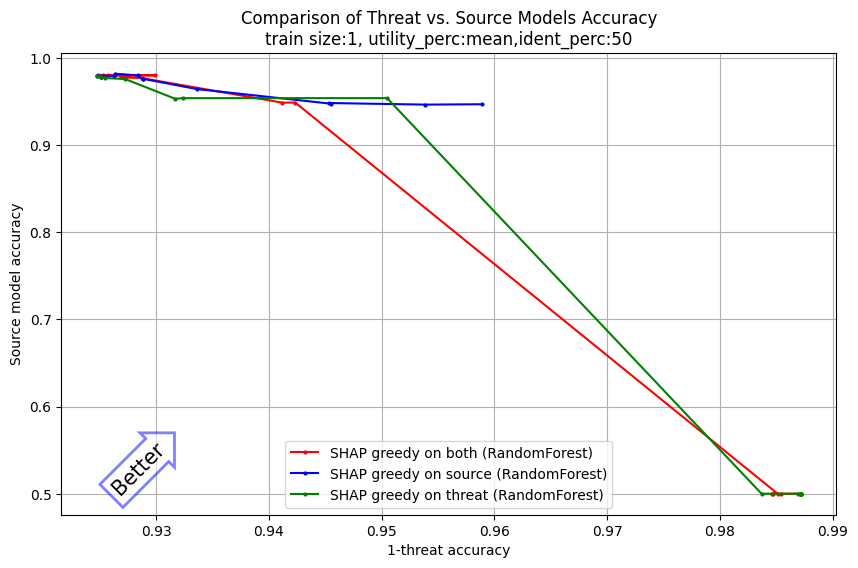

In [146]:
ident_perc, utility_perc = 50, 'mean'
shap_feature_selection(df_X_train, df_Y_train, utility_perc=utility_perc, ident_perc=ident_perc, custom_text=f'train size:1', custom_text_ext=f'utility_perc:{utility_perc},ident_perc:{ident_perc}')

In [158]:
ident_perc, utility_perc = 90, 'mean'
shap_feature_selection(df_X_train, df_Y_train, utility_perc=utility_perc, ident_perc=ident_perc, custom_text=f'train size:1', custom_text_ext=f'utility_perc:{utility_perc},ident_perc:{ident_perc}')

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

[1.05756613e-04 7.66554528e-05 8.43550789e-05 8.82960348e-05
 7.37374918e-05 1.78308155e-04 8.71069348e-05 1.29067783e-04
 4.36207393e-05 6.29013457e-05 8.30962522e-05 5.57225532e-05
 6.23344529e-06 1.97339891e-04 1.13818711e-04 2.31812928e-04
 1.68852642e-04 1.16453511e-04 1.52040987e-04 9.28218729e-05
 1.31367519e-04 6.58994327e-05 1.86705582e-04 8.97306224e-05
 7.34965534e-05 8.02681939e-05 8.22256728e-06 6.81696705e-05
 8.65316354e-05 1.06090123e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.83294553e-04 8.42640731e-05 9.84446950e-05
 1.63820482e-04 7.20592145e-05 1.42265973e-04 1.37204182e-04
 5.93379668e-05 7.81059169e-05 4.04864157e-05 1.69741699e-05
 0.00000000e+00 4.34679338e-05 2.29332712e-04 3.63499335e-04
 0.00000000e+00 0.00000000e+00 2.82003684e-05 1.13241369e-04
 2.18233843e-04 1.30146282e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.71853289e-05 7.69388534e-05 6.03180198e-05 1.01951045e-04
 1.10958680e-04 1.839753

y_pred contains classes not in y_true


[1.16847101e-02 2.81594630e-03 4.48673747e-03 1.80695105e-02
 2.68333344e-03 1.66920256e-02 2.27785022e-03 2.18046248e-02
 3.78969105e-03 1.71911089e-03 0.00000000e+00 9.31260210e-04
 1.37315060e-03 1.71188046e-02 1.76097709e-02 1.83970639e-02
 1.07986413e-02 6.72241486e-03 7.82110187e-03 6.97102690e-03
 9.14155712e-03 2.69202789e-02 1.12926208e-02 1.62336162e-02
 1.88899759e-03 2.11853078e-03 3.08260840e-03 2.94807011e-03
 2.63708049e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.13449112e-02 4.61736252e-03 1.26783007e-02
 7.58493822e-03 1.93481079e-03 4.45583519e-02 1.86801629e-02
 1.05767983e-03 2.92295191e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.77324017e-03 1.42494087e-03 3.42226649e-03
 0.00000000e+00 0.00000000e+00 1.15623825e-03 2.99081773e-02
 1.96757282e-02 2.49447998e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.46787956e-03 2.06525416e-02 2.62696519e-03 1.08598939e-03
 3.21824796e-03 2.689241

y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


[9.05085469e-03 2.72219157e-02 1.88009839e-02 4.88646523e-03
 2.74798095e-02 1.06822359e-02 3.82408528e-02 5.91928477e-03
 1.15103682e-02 3.65894639e-02 2.67215880e-01 5.98356427e-02
 4.53952048e-03 1.15276677e-02 6.46338399e-03 1.26005394e-02
 1.56364710e-02 1.73231663e-02 1.94398423e-02 1.33153801e-02
 1.43703657e-02 2.44794762e-03 1.65334146e-02 5.52745742e-03
 3.89077009e-02 3.78886135e-02 2.66740572e-03 2.31234902e-02
 3.28134221e-02 2.67215880e-01 1.61565436e-02 1.82493951e-02
 7.76481780e-03 2.15981301e-02 3.72435458e-02 3.19280150e-03
 7.34491355e-03 5.61020122e-02 2.67215880e-01 2.67215880e-01
 2.67215880e-01 5.59199676e-03 1.60941915e-01 1.06215964e-01
 2.43897555e-02 3.78630124e-03 1.10915256e-02 5.21737129e-02
 2.51408180e-02 3.72539395e-03 2.29611036e-02 9.38784911e-02
 3.44779771e-02 6.84116198e-02 2.52542543e-04 1.56245016e-02
 8.86592879e-04 2.69982774e-04 7.63753210e-04 0.00000000e+00
 6.92539016e-04 8.09792769e-04]
Percentile of features to keep: 3; Number of features

y_pred contains classes not in y_true


[1.05756613e-04 7.66554528e-05 8.43550789e-05 8.82960348e-05
 7.37374918e-05 1.78308155e-04 8.71069348e-05 1.29067783e-04
 4.36207393e-05 6.29013457e-05 8.30962522e-05 5.57225532e-05
 6.23344529e-06 1.97339891e-04 1.13818711e-04 2.31812928e-04
 1.68852642e-04 1.16453511e-04 1.52040987e-04 9.28218729e-05
 1.31367519e-04 6.58994327e-05 1.86705582e-04 8.97306224e-05
 7.34965534e-05 8.02681939e-05 8.22256728e-06 6.81696705e-05
 8.65316354e-05 1.06090123e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.83294553e-04 8.42640731e-05 9.84446950e-05
 1.63820482e-04 7.20592145e-05 1.42265973e-04 1.37204182e-04
 5.93379668e-05 7.81059169e-05 4.04864157e-05 1.69741699e-05
 0.00000000e+00 4.34679338e-05 2.29332712e-04 3.63499335e-04
 0.00000000e+00 0.00000000e+00 2.82003684e-05 1.13241369e-04
 2.18233843e-04 1.30146282e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.71853289e-05 7.69388534e-05 6.03180198e-05 1.01951045e-04
 1.10958680e-04 1.839753

y_pred contains classes not in y_true


[1.16847101e-02 2.81594630e-03 4.48673747e-03 1.80695105e-02
 2.68333344e-03 1.66920256e-02 2.27785022e-03 2.18046248e-02
 3.78969105e-03 1.71911089e-03 0.00000000e+00 9.31260210e-04
 1.37315060e-03 1.71188046e-02 1.76097709e-02 1.83970639e-02
 1.07986413e-02 6.72241486e-03 7.82110187e-03 6.97102690e-03
 9.14155712e-03 2.69202789e-02 1.12926208e-02 1.62336162e-02
 1.88899759e-03 2.11853078e-03 3.08260840e-03 2.94807011e-03
 2.63708049e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.13449112e-02 4.61736252e-03 1.26783007e-02
 7.58493822e-03 1.93481079e-03 4.45583519e-02 1.86801629e-02
 1.05767983e-03 2.92295191e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.77324017e-03 1.42494087e-03 3.42226649e-03
 0.00000000e+00 0.00000000e+00 1.15623825e-03 2.99081773e-02
 1.96757282e-02 2.49447998e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.46787956e-03 2.06525416e-02 2.62696519e-03 1.08598939e-03
 3.21824796e-03 2.689241

y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


[9.05085469e-03 2.72219157e-02 1.88009839e-02 4.88646523e-03
 2.74798095e-02 1.06822359e-02 3.82408528e-02 5.91928477e-03
 1.15103682e-02 3.65894639e-02 2.67215880e-01 5.98356427e-02
 4.53952048e-03 1.15276677e-02 6.46338399e-03 1.26005394e-02
 1.56364710e-02 1.73231663e-02 1.94398423e-02 1.33153801e-02
 1.43703657e-02 2.44794762e-03 1.65334146e-02 5.52745742e-03
 3.89077009e-02 3.78886135e-02 2.66740572e-03 2.31234902e-02
 3.28134221e-02 2.67215880e-01 1.61565436e-02 1.82493951e-02
 7.76481780e-03 2.15981301e-02 3.72435458e-02 3.19280150e-03
 7.34491355e-03 5.61020122e-02 2.67215880e-01 2.67215880e-01
 2.67215880e-01 5.59199676e-03 1.60941915e-01 1.06215964e-01
 2.43897555e-02 3.78630124e-03 1.10915256e-02 5.21737129e-02
 2.51408180e-02 3.72539395e-03 2.29611036e-02 9.38784911e-02
 3.44779771e-02 6.84116198e-02 2.52542543e-04 1.56245016e-02
 8.86592879e-04 2.69982774e-04 7.63753210e-04 0.00000000e+00
 6.92539016e-04 8.09792769e-04]
Percentile of features to keep: 5; Number of features

y_pred contains classes not in y_true


[1.16847101e-02 2.81594630e-03 4.48673747e-03 1.80695105e-02
 2.68333344e-03 1.66920256e-02 2.27785022e-03 2.18046248e-02
 3.78969105e-03 1.71911089e-03 0.00000000e+00 9.31260210e-04
 1.37315060e-03 1.71188046e-02 1.76097709e-02 1.83970639e-02
 1.07986413e-02 6.72241486e-03 7.82110187e-03 6.97102690e-03
 9.14155712e-03 2.69202789e-02 1.12926208e-02 1.62336162e-02
 1.88899759e-03 2.11853078e-03 3.08260840e-03 2.94807011e-03
 2.63708049e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.13449112e-02 4.61736252e-03 1.26783007e-02
 7.58493822e-03 1.93481079e-03 4.45583519e-02 1.86801629e-02
 1.05767983e-03 2.92295191e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.77324017e-03 1.42494087e-03 3.42226649e-03
 0.00000000e+00 0.00000000e+00 1.15623825e-03 2.99081773e-02
 1.96757282e-02 2.49447998e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.46787956e-03 2.06525416e-02 2.62696519e-03 1.08598939e-03
 3.21824796e-03 2.689241

y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


[9.05085469e-03 2.72219157e-02 1.88009839e-02 4.88646523e-03
 2.74798095e-02 1.06822359e-02 3.82408528e-02 5.91928477e-03
 1.15103682e-02 3.65894639e-02 2.67215880e-01 5.98356427e-02
 4.53952048e-03 1.15276677e-02 6.46338399e-03 1.26005394e-02
 1.56364710e-02 1.73231663e-02 1.94398423e-02 1.33153801e-02
 1.43703657e-02 2.44794762e-03 1.65334146e-02 5.52745742e-03
 3.89077009e-02 3.78886135e-02 2.66740572e-03 2.31234902e-02
 3.28134221e-02 2.67215880e-01 1.61565436e-02 1.82493951e-02
 7.76481780e-03 2.15981301e-02 3.72435458e-02 3.19280150e-03
 7.34491355e-03 5.61020122e-02 2.67215880e-01 2.67215880e-01
 2.67215880e-01 5.59199676e-03 1.60941915e-01 1.06215964e-01
 2.43897555e-02 3.78630124e-03 1.10915256e-02 5.21737129e-02
 2.51408180e-02 3.72539395e-03 2.29611036e-02 9.38784911e-02
 3.44779771e-02 6.84116198e-02 2.52542543e-04 1.56245016e-02
 8.86592879e-04 2.69982774e-04 7.63753210e-04 0.00000000e+00
 6.92539016e-04 8.09792769e-04]
Percentile of features to keep: 7; Number of features

y_pred contains classes not in y_true


[1.16847101e-02 2.81594630e-03 4.48673747e-03 1.80695105e-02
 2.68333344e-03 1.66920256e-02 2.27785022e-03 2.18046248e-02
 3.78969105e-03 1.71911089e-03 0.00000000e+00 9.31260210e-04
 1.37315060e-03 1.71188046e-02 1.76097709e-02 1.83970639e-02
 1.07986413e-02 6.72241486e-03 7.82110187e-03 6.97102690e-03
 9.14155712e-03 2.69202789e-02 1.12926208e-02 1.62336162e-02
 1.88899759e-03 2.11853078e-03 3.08260840e-03 2.94807011e-03
 2.63708049e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.13449112e-02 4.61736252e-03 1.26783007e-02
 7.58493822e-03 1.93481079e-03 4.45583519e-02 1.86801629e-02
 1.05767983e-03 2.92295191e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.77324017e-03 1.42494087e-03 3.42226649e-03
 0.00000000e+00 0.00000000e+00 1.15623825e-03 2.99081773e-02
 1.96757282e-02 2.49447998e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.46787956e-03 2.06525416e-02 2.62696519e-03 1.08598939e-03
 3.21824796e-03 2.689241

y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


[9.05085469e-03 2.72219157e-02 1.88009839e-02 4.88646523e-03
 2.74798095e-02 1.06822359e-02 3.82408528e-02 5.91928477e-03
 1.15103682e-02 3.65894639e-02 2.67215880e-01 5.98356427e-02
 4.53952048e-03 1.15276677e-02 6.46338399e-03 1.26005394e-02
 1.56364710e-02 1.73231663e-02 1.94398423e-02 1.33153801e-02
 1.43703657e-02 2.44794762e-03 1.65334146e-02 5.52745742e-03
 3.89077009e-02 3.78886135e-02 2.66740572e-03 2.31234902e-02
 3.28134221e-02 2.67215880e-01 1.61565436e-02 1.82493951e-02
 7.76481780e-03 2.15981301e-02 3.72435458e-02 3.19280150e-03
 7.34491355e-03 5.61020122e-02 2.67215880e-01 2.67215880e-01
 2.67215880e-01 5.59199676e-03 1.60941915e-01 1.06215964e-01
 2.43897555e-02 3.78630124e-03 1.10915256e-02 5.21737129e-02
 2.51408180e-02 3.72539395e-03 2.29611036e-02 9.38784911e-02
 3.44779771e-02 6.84116198e-02 2.52542543e-04 1.56245016e-02
 8.86592879e-04 2.69982774e-04 7.63753210e-04 0.00000000e+00
 6.92539016e-04 8.09792769e-04]
Percentile of features to keep: 9; Number of features

y_pred contains classes not in y_true


[1.16847101e-02 2.81594630e-03 4.48673747e-03 1.80695105e-02
 2.68333344e-03 1.66920256e-02 2.27785022e-03 2.18046248e-02
 3.78969105e-03 1.71911089e-03 0.00000000e+00 9.31260210e-04
 1.37315060e-03 1.71188046e-02 1.76097709e-02 1.83970639e-02
 1.07986413e-02 6.72241486e-03 7.82110187e-03 6.97102690e-03
 9.14155712e-03 2.69202789e-02 1.12926208e-02 1.62336162e-02
 1.88899759e-03 2.11853078e-03 3.08260840e-03 2.94807011e-03
 2.63708049e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.13449112e-02 4.61736252e-03 1.26783007e-02
 7.58493822e-03 1.93481079e-03 4.45583519e-02 1.86801629e-02
 1.05767983e-03 2.92295191e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.77324017e-03 1.42494087e-03 3.42226649e-03
 0.00000000e+00 0.00000000e+00 1.15623825e-03 2.99081773e-02
 1.96757282e-02 2.49447998e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.46787956e-03 2.06525416e-02 2.62696519e-03 1.08598939e-03
 3.21824796e-03 2.689241

y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


[9.05085469e-03 2.72219157e-02 1.88009839e-02 4.88646523e-03
 2.74798095e-02 1.06822359e-02 3.82408528e-02 5.91928477e-03
 1.15103682e-02 3.65894639e-02 2.67215880e-01 5.98356427e-02
 4.53952048e-03 1.15276677e-02 6.46338399e-03 1.26005394e-02
 1.56364710e-02 1.73231663e-02 1.94398423e-02 1.33153801e-02
 1.43703657e-02 2.44794762e-03 1.65334146e-02 5.52745742e-03
 3.89077009e-02 3.78886135e-02 2.66740572e-03 2.31234902e-02
 3.28134221e-02 2.67215880e-01 1.61565436e-02 1.82493951e-02
 7.76481780e-03 2.15981301e-02 3.72435458e-02 3.19280150e-03
 7.34491355e-03 5.61020122e-02 2.67215880e-01 2.67215880e-01
 2.67215880e-01 5.59199676e-03 1.60941915e-01 1.06215964e-01
 2.43897555e-02 3.78630124e-03 1.10915256e-02 5.21737129e-02
 2.51408180e-02 3.72539395e-03 2.29611036e-02 9.38784911e-02
 3.44779771e-02 6.84116198e-02 2.52542543e-04 1.56245016e-02
 8.86592879e-04 2.69982774e-04 7.63753210e-04 0.00000000e+00
 6.92539016e-04 8.09792769e-04]
Percentile of features to keep: 10; Number of feature

y_pred contains classes not in y_true


[1.16847101e-02 2.81594630e-03 4.48673747e-03 1.80695105e-02
 2.68333344e-03 1.66920256e-02 2.27785022e-03 2.18046248e-02
 3.78969105e-03 1.71911089e-03 0.00000000e+00 9.31260210e-04
 1.37315060e-03 1.71188046e-02 1.76097709e-02 1.83970639e-02
 1.07986413e-02 6.72241486e-03 7.82110187e-03 6.97102690e-03
 9.14155712e-03 2.69202789e-02 1.12926208e-02 1.62336162e-02
 1.88899759e-03 2.11853078e-03 3.08260840e-03 2.94807011e-03
 2.63708049e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.13449112e-02 4.61736252e-03 1.26783007e-02
 7.58493822e-03 1.93481079e-03 4.45583519e-02 1.86801629e-02
 1.05767983e-03 2.92295191e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.77324017e-03 1.42494087e-03 3.42226649e-03
 0.00000000e+00 0.00000000e+00 1.15623825e-03 2.99081773e-02
 1.96757282e-02 2.49447998e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.46787956e-03 2.06525416e-02 2.62696519e-03 1.08598939e-03
 3.21824796e-03 2.689241

y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


[9.05085469e-03 2.72219157e-02 1.88009839e-02 4.88646523e-03
 2.74798095e-02 1.06822359e-02 3.82408528e-02 5.91928477e-03
 1.15103682e-02 3.65894639e-02 2.67215880e-01 5.98356427e-02
 4.53952048e-03 1.15276677e-02 6.46338399e-03 1.26005394e-02
 1.56364710e-02 1.73231663e-02 1.94398423e-02 1.33153801e-02
 1.43703657e-02 2.44794762e-03 1.65334146e-02 5.52745742e-03
 3.89077009e-02 3.78886135e-02 2.66740572e-03 2.31234902e-02
 3.28134221e-02 2.67215880e-01 1.61565436e-02 1.82493951e-02
 7.76481780e-03 2.15981301e-02 3.72435458e-02 3.19280150e-03
 7.34491355e-03 5.61020122e-02 2.67215880e-01 2.67215880e-01
 2.67215880e-01 5.59199676e-03 1.60941915e-01 1.06215964e-01
 2.43897555e-02 3.78630124e-03 1.10915256e-02 5.21737129e-02
 2.51408180e-02 3.72539395e-03 2.29611036e-02 9.38784911e-02
 3.44779771e-02 6.84116198e-02 2.52542543e-04 1.56245016e-02
 8.86592879e-04 2.69982774e-04 7.63753210e-04 0.00000000e+00
 6.92539016e-04 8.09792769e-04]
Percentile of features to keep: 20; Number of feature

y_pred contains classes not in y_true


[1.05756613e-04 7.66554528e-05 8.43550789e-05 8.82960348e-05
 7.37374918e-05 1.78308155e-04 8.71069348e-05 1.29067783e-04
 4.36207393e-05 6.29013457e-05 8.30962522e-05 5.57225532e-05
 6.23344529e-06 1.97339891e-04 1.13818711e-04 2.31812928e-04
 1.68852642e-04 1.16453511e-04 1.52040987e-04 9.28218729e-05
 1.31367519e-04 6.58994327e-05 1.86705582e-04 8.97306224e-05
 7.34965534e-05 8.02681939e-05 8.22256728e-06 6.81696705e-05
 8.65316354e-05 1.06090123e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.83294553e-04 8.42640731e-05 9.84446950e-05
 1.63820482e-04 7.20592145e-05 1.42265973e-04 1.37204182e-04
 5.93379668e-05 7.81059169e-05 4.04864157e-05 1.69741699e-05
 0.00000000e+00 4.34679338e-05 2.29332712e-04 3.63499335e-04
 0.00000000e+00 0.00000000e+00 2.82003684e-05 1.13241369e-04
 2.18233843e-04 1.30146282e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.71853289e-05 7.69388534e-05 6.03180198e-05 1.01951045e-04
 1.10958680e-04 1.839753

y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


[9.05085469e-03 2.72219157e-02 1.88009839e-02 4.88646523e-03
 2.74798095e-02 1.06822359e-02 3.82408528e-02 5.91928477e-03
 1.15103682e-02 3.65894639e-02 2.67215880e-01 5.98356427e-02
 4.53952048e-03 1.15276677e-02 6.46338399e-03 1.26005394e-02
 1.56364710e-02 1.73231663e-02 1.94398423e-02 1.33153801e-02
 1.43703657e-02 2.44794762e-03 1.65334146e-02 5.52745742e-03
 3.89077009e-02 3.78886135e-02 2.66740572e-03 2.31234902e-02
 3.28134221e-02 2.67215880e-01 1.61565436e-02 1.82493951e-02
 7.76481780e-03 2.15981301e-02 3.72435458e-02 3.19280150e-03
 7.34491355e-03 5.61020122e-02 2.67215880e-01 2.67215880e-01
 2.67215880e-01 5.59199676e-03 1.60941915e-01 1.06215964e-01
 2.43897555e-02 3.78630124e-03 1.10915256e-02 5.21737129e-02
 2.51408180e-02 3.72539395e-03 2.29611036e-02 9.38784911e-02
 3.44779771e-02 6.84116198e-02 2.52542543e-04 1.56245016e-02
 8.86592879e-04 2.69982774e-04 7.63753210e-04 0.00000000e+00
 6.92539016e-04 8.09792769e-04]
Percentile of features to keep: 30; Number of feature

y_pred contains classes not in y_true


[1.05756613e-04 7.66554528e-05 8.43550789e-05 8.82960348e-05
 7.37374918e-05 1.78308155e-04 8.71069348e-05 1.29067783e-04
 4.36207393e-05 6.29013457e-05 8.30962522e-05 5.57225532e-05
 6.23344529e-06 1.97339891e-04 1.13818711e-04 2.31812928e-04
 1.68852642e-04 1.16453511e-04 1.52040987e-04 9.28218729e-05
 1.31367519e-04 6.58994327e-05 1.86705582e-04 8.97306224e-05
 7.34965534e-05 8.02681939e-05 8.22256728e-06 6.81696705e-05
 8.65316354e-05 1.06090123e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.83294553e-04 8.42640731e-05 9.84446950e-05
 1.63820482e-04 7.20592145e-05 1.42265973e-04 1.37204182e-04
 5.93379668e-05 7.81059169e-05 4.04864157e-05 1.69741699e-05
 0.00000000e+00 4.34679338e-05 2.29332712e-04 3.63499335e-04
 0.00000000e+00 0.00000000e+00 2.82003684e-05 1.13241369e-04
 2.18233843e-04 1.30146282e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.71853289e-05 7.69388534e-05 6.03180198e-05 1.01951045e-04
 1.10958680e-04 1.839753

y_pred contains classes not in y_true


[1.16847101e-02 2.81594630e-03 4.48673747e-03 1.80695105e-02
 2.68333344e-03 1.66920256e-02 2.27785022e-03 2.18046248e-02
 3.78969105e-03 1.71911089e-03 0.00000000e+00 9.31260210e-04
 1.37315060e-03 1.71188046e-02 1.76097709e-02 1.83970639e-02
 1.07986413e-02 6.72241486e-03 7.82110187e-03 6.97102690e-03
 9.14155712e-03 2.69202789e-02 1.12926208e-02 1.62336162e-02
 1.88899759e-03 2.11853078e-03 3.08260840e-03 2.94807011e-03
 2.63708049e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.13449112e-02 4.61736252e-03 1.26783007e-02
 7.58493822e-03 1.93481079e-03 4.45583519e-02 1.86801629e-02
 1.05767983e-03 2.92295191e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.77324017e-03 1.42494087e-03 3.42226649e-03
 0.00000000e+00 0.00000000e+00 1.15623825e-03 2.99081773e-02
 1.96757282e-02 2.49447998e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.46787956e-03 2.06525416e-02 2.62696519e-03 1.08598939e-03
 3.21824796e-03 2.689241

y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


[9.05085469e-03 2.72219157e-02 1.88009839e-02 4.88646523e-03
 2.74798095e-02 1.06822359e-02 3.82408528e-02 5.91928477e-03
 1.15103682e-02 3.65894639e-02 2.67215880e-01 5.98356427e-02
 4.53952048e-03 1.15276677e-02 6.46338399e-03 1.26005394e-02
 1.56364710e-02 1.73231663e-02 1.94398423e-02 1.33153801e-02
 1.43703657e-02 2.44794762e-03 1.65334146e-02 5.52745742e-03
 3.89077009e-02 3.78886135e-02 2.66740572e-03 2.31234902e-02
 3.28134221e-02 2.67215880e-01 1.61565436e-02 1.82493951e-02
 7.76481780e-03 2.15981301e-02 3.72435458e-02 3.19280150e-03
 7.34491355e-03 5.61020122e-02 2.67215880e-01 2.67215880e-01
 2.67215880e-01 5.59199676e-03 1.60941915e-01 1.06215964e-01
 2.43897555e-02 3.78630124e-03 1.10915256e-02 5.21737129e-02
 2.51408180e-02 3.72539395e-03 2.29611036e-02 9.38784911e-02
 3.44779771e-02 6.84116198e-02 2.52542543e-04 1.56245016e-02
 8.86592879e-04 2.69982774e-04 7.63753210e-04 0.00000000e+00
 6.92539016e-04 8.09792769e-04]
Percentile of features to keep: 40; Number of feature

y_pred contains classes not in y_true


[1.05756613e-04 7.66554528e-05 8.43550789e-05 8.82960348e-05
 7.37374918e-05 1.78308155e-04 8.71069348e-05 1.29067783e-04
 4.36207393e-05 6.29013457e-05 8.30962522e-05 5.57225532e-05
 6.23344529e-06 1.97339891e-04 1.13818711e-04 2.31812928e-04
 1.68852642e-04 1.16453511e-04 1.52040987e-04 9.28218729e-05
 1.31367519e-04 6.58994327e-05 1.86705582e-04 8.97306224e-05
 7.34965534e-05 8.02681939e-05 8.22256728e-06 6.81696705e-05
 8.65316354e-05 1.06090123e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.83294553e-04 8.42640731e-05 9.84446950e-05
 1.63820482e-04 7.20592145e-05 1.42265973e-04 1.37204182e-04
 5.93379668e-05 7.81059169e-05 4.04864157e-05 1.69741699e-05
 0.00000000e+00 4.34679338e-05 2.29332712e-04 3.63499335e-04
 0.00000000e+00 0.00000000e+00 2.82003684e-05 1.13241369e-04
 2.18233843e-04 1.30146282e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.71853289e-05 7.69388534e-05 6.03180198e-05 1.01951045e-04
 1.10958680e-04 1.839753

y_pred contains classes not in y_true


[1.16847101e-02 2.81594630e-03 4.48673747e-03 1.80695105e-02
 2.68333344e-03 1.66920256e-02 2.27785022e-03 2.18046248e-02
 3.78969105e-03 1.71911089e-03 0.00000000e+00 9.31260210e-04
 1.37315060e-03 1.71188046e-02 1.76097709e-02 1.83970639e-02
 1.07986413e-02 6.72241486e-03 7.82110187e-03 6.97102690e-03
 9.14155712e-03 2.69202789e-02 1.12926208e-02 1.62336162e-02
 1.88899759e-03 2.11853078e-03 3.08260840e-03 2.94807011e-03
 2.63708049e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.13449112e-02 4.61736252e-03 1.26783007e-02
 7.58493822e-03 1.93481079e-03 4.45583519e-02 1.86801629e-02
 1.05767983e-03 2.92295191e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.77324017e-03 1.42494087e-03 3.42226649e-03
 0.00000000e+00 0.00000000e+00 1.15623825e-03 2.99081773e-02
 1.96757282e-02 2.49447998e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.46787956e-03 2.06525416e-02 2.62696519e-03 1.08598939e-03
 3.21824796e-03 2.689241

y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


[9.05085469e-03 2.72219157e-02 1.88009839e-02 4.88646523e-03
 2.74798095e-02 1.06822359e-02 3.82408528e-02 5.91928477e-03
 1.15103682e-02 3.65894639e-02 2.67215880e-01 5.98356427e-02
 4.53952048e-03 1.15276677e-02 6.46338399e-03 1.26005394e-02
 1.56364710e-02 1.73231663e-02 1.94398423e-02 1.33153801e-02
 1.43703657e-02 2.44794762e-03 1.65334146e-02 5.52745742e-03
 3.89077009e-02 3.78886135e-02 2.66740572e-03 2.31234902e-02
 3.28134221e-02 2.67215880e-01 1.61565436e-02 1.82493951e-02
 7.76481780e-03 2.15981301e-02 3.72435458e-02 3.19280150e-03
 7.34491355e-03 5.61020122e-02 2.67215880e-01 2.67215880e-01
 2.67215880e-01 5.59199676e-03 1.60941915e-01 1.06215964e-01
 2.43897555e-02 3.78630124e-03 1.10915256e-02 5.21737129e-02
 2.51408180e-02 3.72539395e-03 2.29611036e-02 9.38784911e-02
 3.44779771e-02 6.84116198e-02 2.52542543e-04 1.56245016e-02
 8.86592879e-04 2.69982774e-04 7.63753210e-04 0.00000000e+00
 6.92539016e-04 8.09792769e-04]
Percentile of features to keep: 50; Number of feature

y_pred contains classes not in y_true


[1.05756613e-04 7.66554528e-05 8.43550789e-05 8.82960348e-05
 7.37374918e-05 1.78308155e-04 8.71069348e-05 1.29067783e-04
 4.36207393e-05 6.29013457e-05 8.30962522e-05 5.57225532e-05
 6.23344529e-06 1.97339891e-04 1.13818711e-04 2.31812928e-04
 1.68852642e-04 1.16453511e-04 1.52040987e-04 9.28218729e-05
 1.31367519e-04 6.58994327e-05 1.86705582e-04 8.97306224e-05
 7.34965534e-05 8.02681939e-05 8.22256728e-06 6.81696705e-05
 8.65316354e-05 1.06090123e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.83294553e-04 8.42640731e-05 9.84446950e-05
 1.63820482e-04 7.20592145e-05 1.42265973e-04 1.37204182e-04
 5.93379668e-05 7.81059169e-05 4.04864157e-05 1.69741699e-05
 0.00000000e+00 4.34679338e-05 2.29332712e-04 3.63499335e-04
 0.00000000e+00 0.00000000e+00 2.82003684e-05 1.13241369e-04
 2.18233843e-04 1.30146282e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.71853289e-05 7.69388534e-05 6.03180198e-05 1.01951045e-04
 1.10958680e-04 1.839753

y_pred contains classes not in y_true


[1.16847101e-02 2.81594630e-03 4.48673747e-03 1.80695105e-02
 2.68333344e-03 1.66920256e-02 2.27785022e-03 2.18046248e-02
 3.78969105e-03 1.71911089e-03 0.00000000e+00 9.31260210e-04
 1.37315060e-03 1.71188046e-02 1.76097709e-02 1.83970639e-02
 1.07986413e-02 6.72241486e-03 7.82110187e-03 6.97102690e-03
 9.14155712e-03 2.69202789e-02 1.12926208e-02 1.62336162e-02
 1.88899759e-03 2.11853078e-03 3.08260840e-03 2.94807011e-03
 2.63708049e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.13449112e-02 4.61736252e-03 1.26783007e-02
 7.58493822e-03 1.93481079e-03 4.45583519e-02 1.86801629e-02
 1.05767983e-03 2.92295191e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.77324017e-03 1.42494087e-03 3.42226649e-03
 0.00000000e+00 0.00000000e+00 1.15623825e-03 2.99081773e-02
 1.96757282e-02 2.49447998e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.46787956e-03 2.06525416e-02 2.62696519e-03 1.08598939e-03
 3.21824796e-03 2.689241

y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


[9.05085469e-03 2.72219157e-02 1.88009839e-02 4.88646523e-03
 2.74798095e-02 1.06822359e-02 3.82408528e-02 5.91928477e-03
 1.15103682e-02 3.65894639e-02 2.67215880e-01 5.98356427e-02
 4.53952048e-03 1.15276677e-02 6.46338399e-03 1.26005394e-02
 1.56364710e-02 1.73231663e-02 1.94398423e-02 1.33153801e-02
 1.43703657e-02 2.44794762e-03 1.65334146e-02 5.52745742e-03
 3.89077009e-02 3.78886135e-02 2.66740572e-03 2.31234902e-02
 3.28134221e-02 2.67215880e-01 1.61565436e-02 1.82493951e-02
 7.76481780e-03 2.15981301e-02 3.72435458e-02 3.19280150e-03
 7.34491355e-03 5.61020122e-02 2.67215880e-01 2.67215880e-01
 2.67215880e-01 5.59199676e-03 1.60941915e-01 1.06215964e-01
 2.43897555e-02 3.78630124e-03 1.10915256e-02 5.21737129e-02
 2.51408180e-02 3.72539395e-03 2.29611036e-02 9.38784911e-02
 3.44779771e-02 6.84116198e-02 2.52542543e-04 1.56245016e-02
 8.86592879e-04 2.69982774e-04 7.63753210e-04 0.00000000e+00
 6.92539016e-04 8.09792769e-04]
Percentile of features to keep: 60; Number of feature

y_pred contains classes not in y_true


[1.05756613e-04 7.66554528e-05 8.43550789e-05 8.82960348e-05
 7.37374918e-05 1.78308155e-04 8.71069348e-05 1.29067783e-04
 4.36207393e-05 6.29013457e-05 8.30962522e-05 5.57225532e-05
 6.23344529e-06 1.97339891e-04 1.13818711e-04 2.31812928e-04
 1.68852642e-04 1.16453511e-04 1.52040987e-04 9.28218729e-05
 1.31367519e-04 6.58994327e-05 1.86705582e-04 8.97306224e-05
 7.34965534e-05 8.02681939e-05 8.22256728e-06 6.81696705e-05
 8.65316354e-05 1.06090123e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.83294553e-04 8.42640731e-05 9.84446950e-05
 1.63820482e-04 7.20592145e-05 1.42265973e-04 1.37204182e-04
 5.93379668e-05 7.81059169e-05 4.04864157e-05 1.69741699e-05
 0.00000000e+00 4.34679338e-05 2.29332712e-04 3.63499335e-04
 0.00000000e+00 0.00000000e+00 2.82003684e-05 1.13241369e-04
 2.18233843e-04 1.30146282e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.71853289e-05 7.69388534e-05 6.03180198e-05 1.01951045e-04
 1.10958680e-04 1.839753

y_pred contains classes not in y_true


[1.16847101e-02 2.81594630e-03 4.48673747e-03 1.80695105e-02
 2.68333344e-03 1.66920256e-02 2.27785022e-03 2.18046248e-02
 3.78969105e-03 1.71911089e-03 0.00000000e+00 9.31260210e-04
 1.37315060e-03 1.71188046e-02 1.76097709e-02 1.83970639e-02
 1.07986413e-02 6.72241486e-03 7.82110187e-03 6.97102690e-03
 9.14155712e-03 2.69202789e-02 1.12926208e-02 1.62336162e-02
 1.88899759e-03 2.11853078e-03 3.08260840e-03 2.94807011e-03
 2.63708049e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.13449112e-02 4.61736252e-03 1.26783007e-02
 7.58493822e-03 1.93481079e-03 4.45583519e-02 1.86801629e-02
 1.05767983e-03 2.92295191e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.77324017e-03 1.42494087e-03 3.42226649e-03
 0.00000000e+00 0.00000000e+00 1.15623825e-03 2.99081773e-02
 1.96757282e-02 2.49447998e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.46787956e-03 2.06525416e-02 2.62696519e-03 1.08598939e-03
 3.21824796e-03 2.689241

y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


[9.05085469e-03 2.72219157e-02 1.88009839e-02 4.88646523e-03
 2.74798095e-02 1.06822359e-02 3.82408528e-02 5.91928477e-03
 1.15103682e-02 3.65894639e-02 2.67215880e-01 5.98356427e-02
 4.53952048e-03 1.15276677e-02 6.46338399e-03 1.26005394e-02
 1.56364710e-02 1.73231663e-02 1.94398423e-02 1.33153801e-02
 1.43703657e-02 2.44794762e-03 1.65334146e-02 5.52745742e-03
 3.89077009e-02 3.78886135e-02 2.66740572e-03 2.31234902e-02
 3.28134221e-02 2.67215880e-01 1.61565436e-02 1.82493951e-02
 7.76481780e-03 2.15981301e-02 3.72435458e-02 3.19280150e-03
 7.34491355e-03 5.61020122e-02 2.67215880e-01 2.67215880e-01
 2.67215880e-01 5.59199676e-03 1.60941915e-01 1.06215964e-01
 2.43897555e-02 3.78630124e-03 1.10915256e-02 5.21737129e-02
 2.51408180e-02 3.72539395e-03 2.29611036e-02 9.38784911e-02
 3.44779771e-02 6.84116198e-02 2.52542543e-04 1.56245016e-02
 8.86592879e-04 2.69982774e-04 7.63753210e-04 0.00000000e+00
 6.92539016e-04 8.09792769e-04]
Percentile of features to keep: 70; Number of feature

y_pred contains classes not in y_true


[1.05756613e-04 7.66554528e-05 8.43550789e-05 8.82960348e-05
 7.37374918e-05 1.78308155e-04 8.71069348e-05 1.29067783e-04
 4.36207393e-05 6.29013457e-05 8.30962522e-05 5.57225532e-05
 6.23344529e-06 1.97339891e-04 1.13818711e-04 2.31812928e-04
 1.68852642e-04 1.16453511e-04 1.52040987e-04 9.28218729e-05
 1.31367519e-04 6.58994327e-05 1.86705582e-04 8.97306224e-05
 7.34965534e-05 8.02681939e-05 8.22256728e-06 6.81696705e-05
 8.65316354e-05 1.06090123e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.83294553e-04 8.42640731e-05 9.84446950e-05
 1.63820482e-04 7.20592145e-05 1.42265973e-04 1.37204182e-04
 5.93379668e-05 7.81059169e-05 4.04864157e-05 1.69741699e-05
 0.00000000e+00 4.34679338e-05 2.29332712e-04 3.63499335e-04
 0.00000000e+00 0.00000000e+00 2.82003684e-05 1.13241369e-04
 2.18233843e-04 1.30146282e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.71853289e-05 7.69388534e-05 6.03180198e-05 1.01951045e-04
 1.10958680e-04 1.839753

y_pred contains classes not in y_true


[1.16847101e-02 2.81594630e-03 4.48673747e-03 1.80695105e-02
 2.68333344e-03 1.66920256e-02 2.27785022e-03 2.18046248e-02
 3.78969105e-03 1.71911089e-03 0.00000000e+00 9.31260210e-04
 1.37315060e-03 1.71188046e-02 1.76097709e-02 1.83970639e-02
 1.07986413e-02 6.72241486e-03 7.82110187e-03 6.97102690e-03
 9.14155712e-03 2.69202789e-02 1.12926208e-02 1.62336162e-02
 1.88899759e-03 2.11853078e-03 3.08260840e-03 2.94807011e-03
 2.63708049e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.13449112e-02 4.61736252e-03 1.26783007e-02
 7.58493822e-03 1.93481079e-03 4.45583519e-02 1.86801629e-02
 1.05767983e-03 2.92295191e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.77324017e-03 1.42494087e-03 3.42226649e-03
 0.00000000e+00 0.00000000e+00 1.15623825e-03 2.99081773e-02
 1.96757282e-02 2.49447998e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.46787956e-03 2.06525416e-02 2.62696519e-03 1.08598939e-03
 3.21824796e-03 2.689241

y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


[9.05085469e-03 2.72219157e-02 1.88009839e-02 4.88646523e-03
 2.74798095e-02 1.06822359e-02 3.82408528e-02 5.91928477e-03
 1.15103682e-02 3.65894639e-02 2.67215880e-01 5.98356427e-02
 4.53952048e-03 1.15276677e-02 6.46338399e-03 1.26005394e-02
 1.56364710e-02 1.73231663e-02 1.94398423e-02 1.33153801e-02
 1.43703657e-02 2.44794762e-03 1.65334146e-02 5.52745742e-03
 3.89077009e-02 3.78886135e-02 2.66740572e-03 2.31234902e-02
 3.28134221e-02 2.67215880e-01 1.61565436e-02 1.82493951e-02
 7.76481780e-03 2.15981301e-02 3.72435458e-02 3.19280150e-03
 7.34491355e-03 5.61020122e-02 2.67215880e-01 2.67215880e-01
 2.67215880e-01 5.59199676e-03 1.60941915e-01 1.06215964e-01
 2.43897555e-02 3.78630124e-03 1.10915256e-02 5.21737129e-02
 2.51408180e-02 3.72539395e-03 2.29611036e-02 9.38784911e-02
 3.44779771e-02 6.84116198e-02 2.52542543e-04 1.56245016e-02
 8.86592879e-04 2.69982774e-04 7.63753210e-04 0.00000000e+00
 6.92539016e-04 8.09792769e-04]
Percentile of features to keep: 80; Number of feature

y_pred contains classes not in y_true


[1.05756613e-04 7.66554528e-05 8.43550789e-05 8.82960348e-05
 7.37374918e-05 1.78308155e-04 8.71069348e-05 1.29067783e-04
 4.36207393e-05 6.29013457e-05 8.30962522e-05 5.57225532e-05
 6.23344529e-06 1.97339891e-04 1.13818711e-04 2.31812928e-04
 1.68852642e-04 1.16453511e-04 1.52040987e-04 9.28218729e-05
 1.31367519e-04 6.58994327e-05 1.86705582e-04 8.97306224e-05
 7.34965534e-05 8.02681939e-05 8.22256728e-06 6.81696705e-05
 8.65316354e-05 1.06090123e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.83294553e-04 8.42640731e-05 9.84446950e-05
 1.63820482e-04 7.20592145e-05 1.42265973e-04 1.37204182e-04
 5.93379668e-05 7.81059169e-05 4.04864157e-05 1.69741699e-05
 0.00000000e+00 4.34679338e-05 2.29332712e-04 3.63499335e-04
 0.00000000e+00 0.00000000e+00 2.82003684e-05 1.13241369e-04
 2.18233843e-04 1.30146282e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.71853289e-05 7.69388534e-05 6.03180198e-05 1.01951045e-04
 1.10958680e-04 1.839753

y_pred contains classes not in y_true


[1.16847101e-02 2.81594630e-03 4.48673747e-03 1.80695105e-02
 2.68333344e-03 1.66920256e-02 2.27785022e-03 2.18046248e-02
 3.78969105e-03 1.71911089e-03 0.00000000e+00 9.31260210e-04
 1.37315060e-03 1.71188046e-02 1.76097709e-02 1.83970639e-02
 1.07986413e-02 6.72241486e-03 7.82110187e-03 6.97102690e-03
 9.14155712e-03 2.69202789e-02 1.12926208e-02 1.62336162e-02
 1.88899759e-03 2.11853078e-03 3.08260840e-03 2.94807011e-03
 2.63708049e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.13449112e-02 4.61736252e-03 1.26783007e-02
 7.58493822e-03 1.93481079e-03 4.45583519e-02 1.86801629e-02
 1.05767983e-03 2.92295191e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.77324017e-03 1.42494087e-03 3.42226649e-03
 0.00000000e+00 0.00000000e+00 1.15623825e-03 2.99081773e-02
 1.96757282e-02 2.49447998e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.46787956e-03 2.06525416e-02 2.62696519e-03 1.08598939e-03
 3.21824796e-03 2.689241

y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


[9.05085469e-03 2.72219157e-02 1.88009839e-02 4.88646523e-03
 2.74798095e-02 1.06822359e-02 3.82408528e-02 5.91928477e-03
 1.15103682e-02 3.65894639e-02 2.67215880e-01 5.98356427e-02
 4.53952048e-03 1.15276677e-02 6.46338399e-03 1.26005394e-02
 1.56364710e-02 1.73231663e-02 1.94398423e-02 1.33153801e-02
 1.43703657e-02 2.44794762e-03 1.65334146e-02 5.52745742e-03
 3.89077009e-02 3.78886135e-02 2.66740572e-03 2.31234902e-02
 3.28134221e-02 2.67215880e-01 1.61565436e-02 1.82493951e-02
 7.76481780e-03 2.15981301e-02 3.72435458e-02 3.19280150e-03
 7.34491355e-03 5.61020122e-02 2.67215880e-01 2.67215880e-01
 2.67215880e-01 5.59199676e-03 1.60941915e-01 1.06215964e-01
 2.43897555e-02 3.78630124e-03 1.10915256e-02 5.21737129e-02
 2.51408180e-02 3.72539395e-03 2.29611036e-02 9.38784911e-02
 3.44779771e-02 6.84116198e-02 2.52542543e-04 1.56245016e-02
 8.86592879e-04 2.69982774e-04 7.63753210e-04 0.00000000e+00
 6.92539016e-04 8.09792769e-04]
Percentile of features to keep: 90; Number of feature

y_pred contains classes not in y_true


[1.05756613e-04 7.66554528e-05 8.43550789e-05 8.82960348e-05
 7.37374918e-05 1.78308155e-04 8.71069348e-05 1.29067783e-04
 4.36207393e-05 6.29013457e-05 8.30962522e-05 5.57225532e-05
 6.23344529e-06 1.97339891e-04 1.13818711e-04 2.31812928e-04
 1.68852642e-04 1.16453511e-04 1.52040987e-04 9.28218729e-05
 1.31367519e-04 6.58994327e-05 1.86705582e-04 8.97306224e-05
 7.34965534e-05 8.02681939e-05 8.22256728e-06 6.81696705e-05
 8.65316354e-05 1.06090123e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.83294553e-04 8.42640731e-05 9.84446950e-05
 1.63820482e-04 7.20592145e-05 1.42265973e-04 1.37204182e-04
 5.93379668e-05 7.81059169e-05 4.04864157e-05 1.69741699e-05
 0.00000000e+00 4.34679338e-05 2.29332712e-04 3.63499335e-04
 0.00000000e+00 0.00000000e+00 2.82003684e-05 1.13241369e-04
 2.18233843e-04 1.30146282e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.71853289e-05 7.69388534e-05 6.03180198e-05 1.01951045e-04
 1.10958680e-04 1.839753

y_pred contains classes not in y_true


[1.16847101e-02 2.81594630e-03 4.48673747e-03 1.80695105e-02
 2.68333344e-03 1.66920256e-02 2.27785022e-03 2.18046248e-02
 3.78969105e-03 1.71911089e-03 0.00000000e+00 9.31260210e-04
 1.37315060e-03 1.71188046e-02 1.76097709e-02 1.83970639e-02
 1.07986413e-02 6.72241486e-03 7.82110187e-03 6.97102690e-03
 9.14155712e-03 2.69202789e-02 1.12926208e-02 1.62336162e-02
 1.88899759e-03 2.11853078e-03 3.08260840e-03 2.94807011e-03
 2.63708049e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.13449112e-02 4.61736252e-03 1.26783007e-02
 7.58493822e-03 1.93481079e-03 4.45583519e-02 1.86801629e-02
 1.05767983e-03 2.92295191e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.77324017e-03 1.42494087e-03 3.42226649e-03
 0.00000000e+00 0.00000000e+00 1.15623825e-03 2.99081773e-02
 1.96757282e-02 2.49447998e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.46787956e-03 2.06525416e-02 2.62696519e-03 1.08598939e-03
 3.21824796e-03 2.689241

y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


[9.05085469e-03 2.72219157e-02 1.88009839e-02 4.88646523e-03
 2.74798095e-02 1.06822359e-02 3.82408528e-02 5.91928477e-03
 1.15103682e-02 3.65894639e-02 2.67215880e-01 5.98356427e-02
 4.53952048e-03 1.15276677e-02 6.46338399e-03 1.26005394e-02
 1.56364710e-02 1.73231663e-02 1.94398423e-02 1.33153801e-02
 1.43703657e-02 2.44794762e-03 1.65334146e-02 5.52745742e-03
 3.89077009e-02 3.78886135e-02 2.66740572e-03 2.31234902e-02
 3.28134221e-02 2.67215880e-01 1.61565436e-02 1.82493951e-02
 7.76481780e-03 2.15981301e-02 3.72435458e-02 3.19280150e-03
 7.34491355e-03 5.61020122e-02 2.67215880e-01 2.67215880e-01
 2.67215880e-01 5.59199676e-03 1.60941915e-01 1.06215964e-01
 2.43897555e-02 3.78630124e-03 1.10915256e-02 5.21737129e-02
 2.51408180e-02 3.72539395e-03 2.29611036e-02 9.38784911e-02
 3.44779771e-02 6.84116198e-02 2.52542543e-04 1.56245016e-02
 8.86592879e-04 2.69982774e-04 7.63753210e-04 0.00000000e+00
 6.92539016e-04 8.09792769e-04]
Percentile of features to keep: 100; Number of featur

y_pred contains classes not in y_true
100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:25<00:00, 85.47s/it]

Results: train size:1, utility_perc:mean,ident_perc:90
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.011421   
1     SHAP greedy on both (RandomForest)         0.014480   
2     SHAP greedy on both (RandomForest)         0.015437   
3     SHAP greedy on both (RandomForest)         0.016409   
4     SHAP greedy on both (RandomForest)         0.015727   
5     SHAP greedy on both (RandomForest)         0.058643   
6     SHAP greedy on both (RandomForest)         0.071491   
7     SHAP greedy on both (RandomForest)         0.072615   
8     SHAP greedy on both (RandomForest)         0.072427   
9     SHAP greedy on both (RandomForest)         0.072956   
10    SHAP greedy on both (RandomForest)         0.072917   
11    SHAP greedy on both (RandomForest)         0.074354   
12    SHAP greedy on both (RandomForest)         0.071073   
13    SHAP greedy on both (RandomForest)         0.074282   
14  SHAP greedy on source (Ran

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

3.9760225375562084e-09
Percentile of features to keep: 3; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09


y_pred contains classes not in y_true


-0.0259483046287807
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.0259483046287807


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 1.0267947755109346e-05


y_pred contains classes not in y_true


3.9760225375562084e-09
Percentile of features to keep: 5; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09


y_pred contains classes not in y_true


-0.021055770686732467
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.021055770686732467


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 2.036551022284549e-05


y_pred contains classes not in y_true


3.9760225375562084e-09
Percentile of features to keep: 7; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09


y_pred contains classes not in y_true


-0.019566215999852567
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.019566215999852567


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 2.5034905872997977e-05


y_pred contains classes not in y_true


3.9760225375562084e-09
Percentile of features to keep: 9; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09


y_pred contains classes not in y_true


-0.018518796471866567
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.018518796471866567


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 6.638909338046528e-05
3.9760225375562084e-09
Percentile of features to keep: 10; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09


y_pred contains classes not in y_true


-0.018298797875781588
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.018298797875781588


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 9.918466918233623e-05
1.8051797480973213e-08
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 1.8051797480973213e-08


y_pred contains classes not in y_true


-0.011480830745940428
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.011480830745940428


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 0.0008145389930097145


y_pred contains classes not in y_true


9.378546362341515e-07
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 9.378546362341515e-07
-0.007032418034195749
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.007032418034195749


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 0.0012208930751894406


y_pred contains classes not in y_true


9.167330963282947e-06
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 9.167330963282947e-06


y_pred contains classes not in y_true


-0.0032641488662918327
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.0032641488662918327


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 0.001997477570481198


y_pred contains classes not in y_true


1.533239007913022e-05
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 1.533239007913022e-05


y_pred contains classes not in y_true


-0.0026320228393253977
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.0026320228393253977


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 0.0028582338947832934


y_pred contains classes not in y_true


1.7403752007480012e-05
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 1.7403752007480012e-05


y_pred contains classes not in y_true


-0.0018981602316618072
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.0018981602316618072


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 0.004031097059157718


y_pred contains classes not in y_true


2.0590769289333242e-05
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 2.0590769289333242e-05


y_pred contains classes not in y_true


-0.001045037868649539
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.001045037868649539


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 0.006335047531285966


y_pred contains classes not in y_true


2.6912971013156287e-05
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 2.6912971013156287e-05


y_pred contains classes not in y_true


4.010057997261147e-05
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 4.010057997261147e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 0.008108088662218006


y_pred contains classes not in y_true


3.4411598868195356e-05
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 3.4411598868195356e-05


y_pred contains classes not in y_true


4.010057997261147e-05
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 4.010057997261147e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 55; Ratio Threshold: 0.017570336220296155


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 58; Ratio Threshold: inf


y_pred contains classes not in y_true
100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:09<00:00, 69.97s/it]


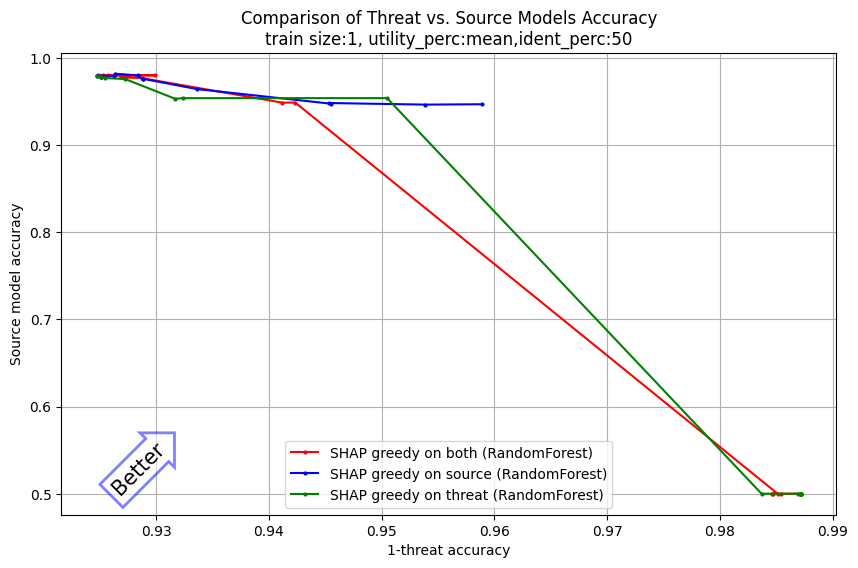

In [148]:
ident_perc, utility_perc = 50, 'mean'
shap_feature_selection(df_X_train, df_Y_train, utility_perc=utility_perc, ident_perc=ident_perc, custom_text=f'train size:1', custom_text_ext=f'utility_perc:{utility_perc},ident_perc:{ident_perc}')

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

5.52971636834093e-07
Percentile of features to keep: 3; Number of features to keep: 12; Ratio Threshold: 5.52971636834093e-07
-0.0259483046287807
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.0259483046287807


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 0.0008527996769367118


y_pred contains classes not in y_true


5.52971636834093e-07
Percentile of features to keep: 5; Number of features to keep: 12; Ratio Threshold: 5.52971636834093e-07
-0.021055770686732467
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.021055770686732467


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 0.0011694156062055448
5.52971636834093e-07
Percentile of features to keep: 7; Number of features to keep: 12; Ratio Threshold: 5.52971636834093e-07
-0.019566215999852567
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.019566215999852567


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 0.0012092401054816238
5.52971636834093e-07
Percentile of features to keep: 9; Number of features to keep: 12; Ratio Threshold: 5.52971636834093e-07
-0.018518796471866567
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.018518796471866567


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 0.001550433010566276
5.52971636834093e-07
Percentile of features to keep: 10; Number of features to keep: 12; Ratio Threshold: 5.52971636834093e-07
-0.018298797875781588
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.018298797875781588


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 0.0019512035001043727
1.0738523448795462e-06
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 1.0738523448795462e-06


y_pred contains classes not in y_true


-0.011480830745940428
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.011480830745940428


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 0.003540150136960812


y_pred contains classes not in y_true


7.4473481823623585e-06
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 7.4473481823623585e-06
-0.007032418034195749
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.007032418034195749


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 0.005954675166720335


y_pred contains classes not in y_true


4.370925465699916e-05
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 4.370925465699916e-05


y_pred contains classes not in y_true


-0.0032641488662918327
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.0032641488662918327


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 0.008784968133008463


y_pred contains classes not in y_true


5.2563956116483164e-05
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 5.2563956116483164e-05


y_pred contains classes not in y_true


-0.0026320228393253977
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.0026320228393253977


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 0.01149823256264472


y_pred contains classes not in y_true


6.269861312275739e-05
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 6.269861312275739e-05


y_pred contains classes not in y_true


-0.0018981602316618072
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.0018981602316618072


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 0.01698610429557865


y_pred contains classes not in y_true


7.172080048587431e-05
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 7.172080048587431e-05


y_pred contains classes not in y_true


-0.001045037868649539
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.001045037868649539


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 0.021633890506299755


y_pred contains classes not in y_true


9.649269708208486e-05
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 9.649269708208486e-05


y_pred contains classes not in y_true


4.010057997261147e-05
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 4.010057997261147e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 0.026622866721873282


y_pred contains classes not in y_true


0.00011466803282836221
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 0.00011466803282836221


y_pred contains classes not in y_true


4.010057997261147e-05
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 4.010057997261147e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 55; Ratio Threshold: 0.05563090625939295


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 58; Ratio Threshold: inf


y_pred contains classes not in y_true
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [02:36<00:00, 156.04s/it]


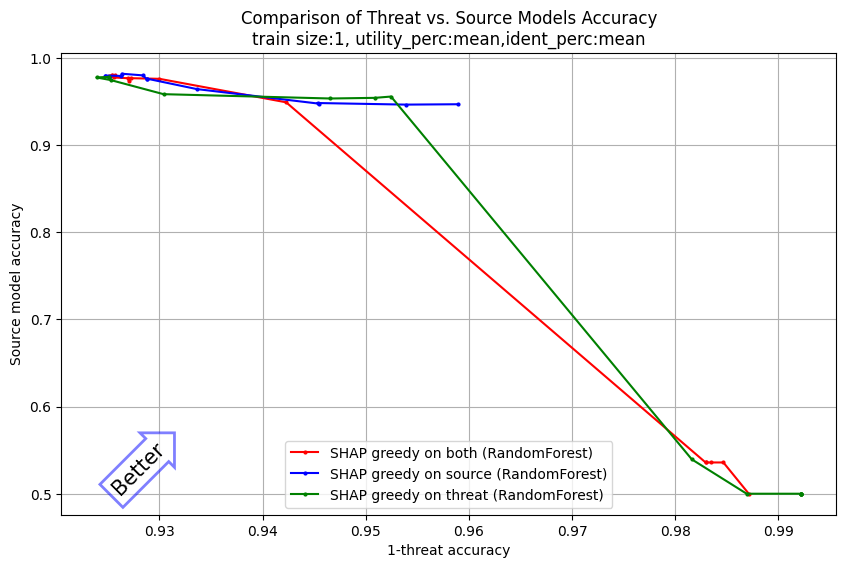

In [149]:
ident_perc, utility_perc = 'mean', 'mean'
shap_feature_selection(df_X_train, df_Y_train, utility_perc=utility_perc, ident_perc=ident_perc, custom_text=f'train size:1', custom_text_ext=f'utility_perc:{utility_perc},ident_perc:{ident_perc}')

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

3.9760225375562084e-09
Percentile of features to keep: 3; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09


y_pred contains classes not in y_true


-0.017186058932801878
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.017186058932801878


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 2.915544935587888e-05


y_pred contains classes not in y_true


3.9760225375562084e-09
Percentile of features to keep: 5; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09


y_pred contains classes not in y_true


-0.014324794859580516
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.014324794859580516


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 3.5810367630048756e-05
3.9760225375562084e-09
Percentile of features to keep: 7; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09


y_pred contains classes not in y_true


-0.013924149665299406
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.013924149665299406


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 5.426675108147531e-05


y_pred contains classes not in y_true


3.9760225375562084e-09
Percentile of features to keep: 9; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09


y_pred contains classes not in y_true


-0.012922438937072558
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.012922438937072558


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 0.0001152574222004342
3.9760225375562084e-09
Percentile of features to keep: 10; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09


y_pred contains classes not in y_true


-0.01230915873344437
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.01230915873344437


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 0.0001579244573719578
1.8051797480973213e-08
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 1.8051797480973213e-08


y_pred contains classes not in y_true


-0.010060251140668669
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.010060251140668669


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 0.0013353297199298168


y_pred contains classes not in y_true


9.378546362341515e-07
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 9.378546362341515e-07
-0.00558057558115986
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.00558057558115986


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 0.0017347674267638392


y_pred contains classes not in y_true


9.167330963282947e-06
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 9.167330963282947e-06


y_pred contains classes not in y_true


-0.0022942646701500646
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.0022942646701500646


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 0.002869613282084465


y_pred contains classes not in y_true


1.533239007913022e-05
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 1.533239007913022e-05


y_pred contains classes not in y_true


-0.0016862628171452156
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.0016862628171452156


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 0.0035524082450544324


y_pred contains classes not in y_true


1.7403752007480012e-05
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 1.7403752007480012e-05


y_pred contains classes not in y_true


-0.0013306225225515917
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.0013306225225515917


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 0.005865562559324223


y_pred contains classes not in y_true


2.0590769289333242e-05
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 2.0590769289333242e-05


y_pred contains classes not in y_true


-0.0006269908425126871
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.0006269908425126871


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 0.0077996423904796745


y_pred contains classes not in y_true


2.6912971013156287e-05
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 2.6912971013156287e-05


y_pred contains classes not in y_true


1.2532187113267354e-05
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 1.2532187113267354e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 0.010099306467981682


y_pred contains classes not in y_true


3.4411598868195356e-05
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 3.4411598868195356e-05


y_pred contains classes not in y_true


1.2532187113267354e-05
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 1.2532187113267354e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 55; Ratio Threshold: 0.06464870045075671


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 58; Ratio Threshold: inf


y_pred contains classes not in y_true
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [02:49<00:00, 169.58s/it]


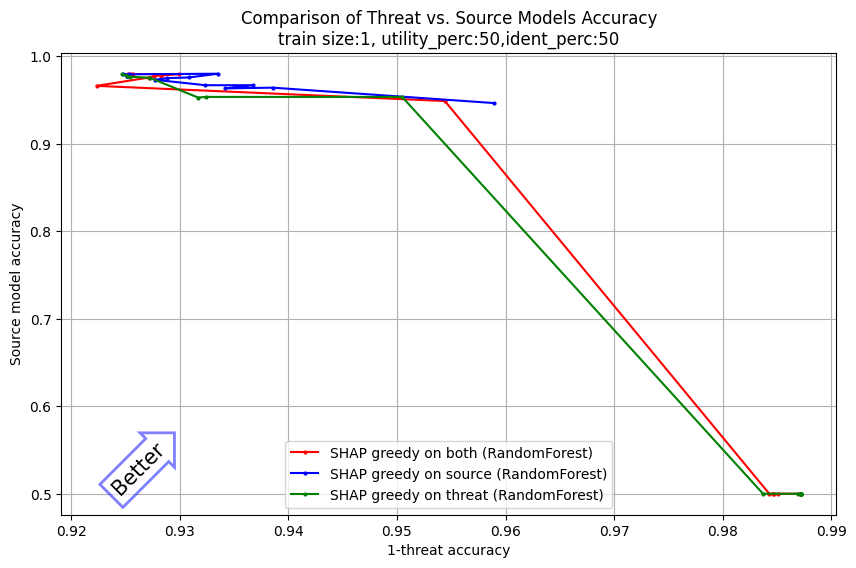

In [150]:
ident_perc, utility_perc = 50, 50
shap_feature_selection(df_X_train, df_Y_train, utility_perc=utility_perc, ident_perc=ident_perc, custom_text=f'train size:1', custom_text_ext=f'utility_perc:{utility_perc},ident_perc:{ident_perc}')

In [245]:
for ident_perc in [25, 50, 75, 90, 95, 'mean', 'max']:
    for utility_perc in [25, 50, 75, 90, 95, 'mean', 'max']:
        print('utility_perc:', utility_perc, 'ident_perc:', ident_perc)
        shap_feature_selection(df_X_train, df_Y_train, utility_perc=utility_perc, ident_perc=ident_perc, custom_text=f'train size:1,quantized', custom_text_ext=f'utility_perc:{utility_perc},ident_perc:{ident_perc}')

utility_perc: 25 ident_perc: 25


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 44; Ratio Threshold: 0.0
0.008749989254134144
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.008749989254134144
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 9.692583931603435e-06
0.0
Percentile of features to keep: 5; Number of features to keep: 44; Ratio Threshold: 0.0
0.008386391740548482
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.008386391740548482
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 8.81090331893688e-06
0.0
Percentile of features to keep: 7; Number of features to keep: 44; Ratio Threshold: 0.0
0.007985497009513202
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.007985497009513202
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 6.701883429868598e-06
0.0
Percentile of features to kee

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:26<00:00, 206.70s/it]


Results: train size:1,quantized, utility_perc:25,ident_perc:25
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.514901   
1     SHAP greedy on both (RandomForest)         0.526364   
2     SHAP greedy on both (RandomForest)         0.534159   
3     SHAP greedy on both (RandomForest)         0.558918   
4     SHAP greedy on both (RandomForest)         0.556625   
5     SHAP greedy on both (RandomForest)         0.567630   
6     SHAP greedy on both (RandomForest)         0.572673   
7     SHAP greedy on both (RandomForest)         0.573590   
8     SHAP greedy on both (RandomForest)         0.576800   
9     SHAP greedy on both (RandomForest)         0.576800   
10    SHAP greedy on both (RandomForest)         0.583219   
11    SHAP greedy on both (RandomForest)         0.581385   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on sou

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 44; Ratio Threshold: 0.0
0.01076427552090304
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.01076427552090304
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 9.67695785833673e-06
0.0
Percentile of features to keep: 5; Number of features to keep: 44; Ratio Threshold: 0.0
0.00975068860289725
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.00975068860289725
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 8.796793832079774e-06
0.0
Percentile of features to keep: 7; Number of features to keep: 44; Ratio Threshold: 0.0
0.008927134930195082
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.008927134930195082
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 6.697516477683664e-06
0.0
Percentile of features to keep: 9

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:29<00:00, 209.43s/it]


Results: train size:1,quantized, utility_perc:50,ident_perc:25
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.514901   
1     SHAP greedy on both (RandomForest)         0.526364   
2     SHAP greedy on both (RandomForest)         0.534159   
3     SHAP greedy on both (RandomForest)         0.558918   
4     SHAP greedy on both (RandomForest)         0.556625   
5     SHAP greedy on both (RandomForest)         0.567630   
6     SHAP greedy on both (RandomForest)         0.572673   
7     SHAP greedy on both (RandomForest)         0.573590   
8     SHAP greedy on both (RandomForest)         0.576800   
9     SHAP greedy on both (RandomForest)         0.576800   
10    SHAP greedy on both (RandomForest)         0.583219   
11    SHAP greedy on both (RandomForest)         0.581385   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on sou

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 44; Ratio Threshold: 0.0
0.02767580963220014
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.02767580963220014
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 9.649027906285346e-06
0.0
Percentile of features to keep: 5; Number of features to keep: 44; Ratio Threshold: 0.0
0.02460536889622709
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.02460536889622709
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 8.78451603500944e-06
0.0
Percentile of features to keep: 7; Number of features to keep: 44; Ratio Threshold: 0.0
0.02104414965907005
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.02104414965907005
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 6.676893817573074e-06
0.0
Percentile of features to keep: 9; 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:23<00:00, 203.73s/it]


Results: train size:1,quantized, utility_perc:75,ident_perc:25
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.514901   
1     SHAP greedy on both (RandomForest)         0.526364   
2     SHAP greedy on both (RandomForest)         0.534159   
3     SHAP greedy on both (RandomForest)         0.558918   
4     SHAP greedy on both (RandomForest)         0.556625   
5     SHAP greedy on both (RandomForest)         0.567630   
6     SHAP greedy on both (RandomForest)         0.572673   
7     SHAP greedy on both (RandomForest)         0.573590   
8     SHAP greedy on both (RandomForest)         0.576800   
9     SHAP greedy on both (RandomForest)         0.576800   
10    SHAP greedy on both (RandomForest)         0.583219   
11    SHAP greedy on both (RandomForest)         0.581385   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on sou

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 44; Ratio Threshold: 0.0
0.033006876341061135
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.033006876341061135
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 9.592959457149337e-06
0.0
Percentile of features to keep: 5; Number of features to keep: 44; Ratio Threshold: 0.0
0.02934016355860164
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.02934016355860164
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 8.716002814659853e-06
0.0
Percentile of features to keep: 7; Number of features to keep: 44; Ratio Threshold: 0.0
0.024130035707898824
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.024130035707898824
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 6.6638645561902356e-06
0.0
Percentile of features to kee

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:25<00:00, 205.51s/it]


Results: train size:1,quantized, utility_perc:90,ident_perc:25
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.514901   
1     SHAP greedy on both (RandomForest)         0.526364   
2     SHAP greedy on both (RandomForest)         0.534159   
3     SHAP greedy on both (RandomForest)         0.558918   
4     SHAP greedy on both (RandomForest)         0.556625   
5     SHAP greedy on both (RandomForest)         0.567630   
6     SHAP greedy on both (RandomForest)         0.572673   
7     SHAP greedy on both (RandomForest)         0.573590   
8     SHAP greedy on both (RandomForest)         0.576800   
9     SHAP greedy on both (RandomForest)         0.576800   
10    SHAP greedy on both (RandomForest)         0.583219   
11    SHAP greedy on both (RandomForest)         0.581385   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on sou

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 44; Ratio Threshold: 0.0
0.03325916187627049
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.03325916187627049
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 9.542980771136827e-06
0.0
Percentile of features to keep: 5; Number of features to keep: 44; Ratio Threshold: 0.0
0.02943699019666367
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.02943699019666367
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 8.692189742540743e-06
0.0
Percentile of features to keep: 7; Number of features to keep: 44; Ratio Threshold: 0.0
0.025584808291998325
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.025584808291998325
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 6.657008201111565e-06
0.0
Percentile of features to keep: 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:24<00:00, 204.36s/it]


Results: train size:1,quantized, utility_perc:95,ident_perc:25
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.514901   
1     SHAP greedy on both (RandomForest)         0.526364   
2     SHAP greedy on both (RandomForest)         0.534159   
3     SHAP greedy on both (RandomForest)         0.558918   
4     SHAP greedy on both (RandomForest)         0.556625   
5     SHAP greedy on both (RandomForest)         0.567630   
6     SHAP greedy on both (RandomForest)         0.572673   
7     SHAP greedy on both (RandomForest)         0.573590   
8     SHAP greedy on both (RandomForest)         0.576800   
9     SHAP greedy on both (RandomForest)         0.576800   
10    SHAP greedy on both (RandomForest)         0.583219   
11    SHAP greedy on both (RandomForest)         0.581385   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on sou

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 44; Ratio Threshold: 0.0
0.015692184980321464
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.015692184980321464
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 9.660237525333097e-06
0.0
Percentile of features to keep: 5; Number of features to keep: 44; Ratio Threshold: 0.0
0.013829370694345007
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.013829370694345007
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 8.783199990957472e-06
0.0
Percentile of features to keep: 7; Number of features to keep: 44; Ratio Threshold: 0.0
0.011680919131494107
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.011680919131494107
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 6.689563880253898e-06
0.0
Percentile of features to ke

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:23<00:00, 203.55s/it]


Results: train size:1,quantized, utility_perc:mean,ident_perc:25
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.514901   
1     SHAP greedy on both (RandomForest)         0.526364   
2     SHAP greedy on both (RandomForest)         0.534159   
3     SHAP greedy on both (RandomForest)         0.558918   
4     SHAP greedy on both (RandomForest)         0.556625   
5     SHAP greedy on both (RandomForest)         0.567630   
6     SHAP greedy on both (RandomForest)         0.572673   
7     SHAP greedy on both (RandomForest)         0.573590   
8     SHAP greedy on both (RandomForest)         0.576800   
9     SHAP greedy on both (RandomForest)         0.576800   
10    SHAP greedy on both (RandomForest)         0.583219   
11    SHAP greedy on both (RandomForest)         0.581385   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on s

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 44; Ratio Threshold: 0.0
0.09023465086171831
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.09023465086171831
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 9.276458244347703e-06
0.0
Percentile of features to keep: 5; Number of features to keep: 44; Ratio Threshold: 0.0
0.06717201481922483
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.06717201481922483
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 8.403622637064637e-06
0.0
Percentile of features to keep: 7; Number of features to keep: 44; Ratio Threshold: 0.0
0.060616769428626635
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.060616769428626635
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 6.584606047075362e-06
0.0
Percentile of features to keep: 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:23<00:00, 203.71s/it]


Results: train size:1,quantized, utility_perc:max,ident_perc:25
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.514901   
1     SHAP greedy on both (RandomForest)         0.526364   
2     SHAP greedy on both (RandomForest)         0.534159   
3     SHAP greedy on both (RandomForest)         0.558918   
4     SHAP greedy on both (RandomForest)         0.563503   
5     SHAP greedy on both (RandomForest)         0.567630   
6     SHAP greedy on both (RandomForest)         0.572673   
7     SHAP greedy on both (RandomForest)         0.573590   
8     SHAP greedy on both (RandomForest)         0.576800   
9     SHAP greedy on both (RandomForest)         0.576800   
10    SHAP greedy on both (RandomForest)         0.583219   
11    SHAP greedy on both (RandomForest)         0.581385   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on so

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 34; Ratio Threshold: 0.0
0.008749989254134144
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.008749989254134144
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 3.507942246247641e-05
0.0
Percentile of features to keep: 5; Number of features to keep: 34; Ratio Threshold: 0.0
0.008386391740548482
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.008386391740548482
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 3.3847276325958124e-05
0.0
Percentile of features to keep: 7; Number of features to keep: 34; Ratio Threshold: 0.0
0.007985497009513202
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.007985497009513202
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 2.779993141151727e-05
0.0
Percentile of features to k

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:20<00:00, 200.75s/it]


Results: train size:1,quantized, utility_perc:25,ident_perc:50
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.539661   
1     SHAP greedy on both (RandomForest)         0.535993   
2     SHAP greedy on both (RandomForest)         0.547914   
3     SHAP greedy on both (RandomForest)         0.555250   
4     SHAP greedy on both (RandomForest)         0.556625   
5     SHAP greedy on both (RandomForest)         0.577717   
6     SHAP greedy on both (RandomForest)         0.579092   
7     SHAP greedy on both (RandomForest)         0.573132   
8     SHAP greedy on both (RandomForest)         0.569005   
9     SHAP greedy on both (RandomForest)         0.574049   
10    SHAP greedy on both (RandomForest)         0.574049   
11    SHAP greedy on both (RandomForest)         0.581385   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on sou

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 34; Ratio Threshold: 0.0
0.01076427552090304
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.01076427552090304
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 3.506772525570372e-05
0.0
Percentile of features to keep: 5; Number of features to keep: 34; Ratio Threshold: 0.0
0.00975068860289725
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.00975068860289725
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 3.3791248224300444e-05
0.0
Percentile of features to keep: 7; Number of features to keep: 34; Ratio Threshold: 0.0
0.008927134930195082
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.008927134930195082
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 2.7785197604354154e-05
0.0
Percentile of features to keep

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:22<00:00, 202.94s/it]


Results: train size:1,quantized, utility_perc:50,ident_perc:50
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.539661   
1     SHAP greedy on both (RandomForest)         0.535993   
2     SHAP greedy on both (RandomForest)         0.547914   
3     SHAP greedy on both (RandomForest)         0.555250   
4     SHAP greedy on both (RandomForest)         0.556625   
5     SHAP greedy on both (RandomForest)         0.577717   
6     SHAP greedy on both (RandomForest)         0.579092   
7     SHAP greedy on both (RandomForest)         0.573132   
8     SHAP greedy on both (RandomForest)         0.569005   
9     SHAP greedy on both (RandomForest)         0.574049   
10    SHAP greedy on both (RandomForest)         0.574049   
11    SHAP greedy on both (RandomForest)         0.581385   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on sou

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 34; Ratio Threshold: 0.0
0.02767580963220014
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.02767580963220014
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 3.4850876632993694e-05
0.0
Percentile of features to keep: 5; Number of features to keep: 34; Ratio Threshold: 0.0
0.02460536889622709
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.02460536889622709
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 3.369478753482577e-05
0.0
Percentile of features to keep: 7; Number of features to keep: 34; Ratio Threshold: 0.0
0.02104414965907005
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.02104414965907005
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 2.774048994251394e-05
0.0
Percentile of features to keep: 9

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:17<00:00, 197.50s/it]


Results: train size:1,quantized, utility_perc:75,ident_perc:50
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.541495   
1     SHAP greedy on both (RandomForest)         0.535993   
2     SHAP greedy on both (RandomForest)         0.547914   
3     SHAP greedy on both (RandomForest)         0.555250   
4     SHAP greedy on both (RandomForest)         0.556625   
5     SHAP greedy on both (RandomForest)         0.577717   
6     SHAP greedy on both (RandomForest)         0.579092   
7     SHAP greedy on both (RandomForest)         0.574507   
8     SHAP greedy on both (RandomForest)         0.569005   
9     SHAP greedy on both (RandomForest)         0.574049   
10    SHAP greedy on both (RandomForest)         0.574049   
11    SHAP greedy on both (RandomForest)         0.581385   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on sou

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 34; Ratio Threshold: 0.0
0.033006876341061135
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.033006876341061135
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 3.479688488890815e-05
0.0
Percentile of features to keep: 5; Number of features to keep: 34; Ratio Threshold: 0.0
0.02934016355860164
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.02934016355860164
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 3.364836252449475e-05
0.0
Percentile of features to keep: 7; Number of features to keep: 34; Ratio Threshold: 0.0
0.024130035707898824
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.024130035707898824
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 2.7675512522066276e-05
0.0
Percentile of features to kee

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:19<00:00, 199.42s/it]


Results: train size:1,quantized, utility_perc:90,ident_perc:50
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.539661   
1     SHAP greedy on both (RandomForest)         0.535993   
2     SHAP greedy on both (RandomForest)         0.547914   
3     SHAP greedy on both (RandomForest)         0.555250   
4     SHAP greedy on both (RandomForest)         0.556625   
5     SHAP greedy on both (RandomForest)         0.577717   
6     SHAP greedy on both (RandomForest)         0.579092   
7     SHAP greedy on both (RandomForest)         0.574507   
8     SHAP greedy on both (RandomForest)         0.569005   
9     SHAP greedy on both (RandomForest)         0.574049   
10    SHAP greedy on both (RandomForest)         0.574049   
11    SHAP greedy on both (RandomForest)         0.581385   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on sou

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 34; Ratio Threshold: 0.0
0.03325916187627049
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.03325916187627049
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 3.4647009595772624e-05
0.0
Percentile of features to keep: 5; Number of features to keep: 34; Ratio Threshold: 0.0
0.02943699019666367
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.02943699019666367
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 3.354498145903141e-05
0.0
Percentile of features to keep: 7; Number of features to keep: 34; Ratio Threshold: 0.0
0.025584808291998325
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.025584808291998325
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 2.7610573066631473e-05
0.0
Percentile of features to keep

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:18<00:00, 198.88s/it]


Results: train size:1,quantized, utility_perc:95,ident_perc:50
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.541495   
1     SHAP greedy on both (RandomForest)         0.535993   
2     SHAP greedy on both (RandomForest)         0.547914   
3     SHAP greedy on both (RandomForest)         0.555250   
4     SHAP greedy on both (RandomForest)         0.556625   
5     SHAP greedy on both (RandomForest)         0.569464   
6     SHAP greedy on both (RandomForest)         0.579092   
7     SHAP greedy on both (RandomForest)         0.574507   
8     SHAP greedy on both (RandomForest)         0.569005   
9     SHAP greedy on both (RandomForest)         0.574049   
10    SHAP greedy on both (RandomForest)         0.574049   
11    SHAP greedy on both (RandomForest)         0.581385   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on sou

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 34; Ratio Threshold: 0.0
0.015692184980321464
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.015692184980321464
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 3.496190266258559e-05
0.0
Percentile of features to keep: 5; Number of features to keep: 34; Ratio Threshold: 0.0
0.013829370694345007
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.013829370694345007
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 3.3751272377861296e-05
0.0
Percentile of features to keep: 7; Number of features to keep: 34; Ratio Threshold: 0.0
0.011680919131494107
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.011680919131494107
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 2.77550342805586e-05
0.0
Percentile of features to ke

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:16<00:00, 196.88s/it]


Results: train size:1,quantized, utility_perc:mean,ident_perc:50
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.539661   
1     SHAP greedy on both (RandomForest)         0.535993   
2     SHAP greedy on both (RandomForest)         0.547914   
3     SHAP greedy on both (RandomForest)         0.555250   
4     SHAP greedy on both (RandomForest)         0.556625   
5     SHAP greedy on both (RandomForest)         0.577717   
6     SHAP greedy on both (RandomForest)         0.579092   
7     SHAP greedy on both (RandomForest)         0.573132   
8     SHAP greedy on both (RandomForest)         0.569005   
9     SHAP greedy on both (RandomForest)         0.574049   
10    SHAP greedy on both (RandomForest)         0.574049   
11    SHAP greedy on both (RandomForest)         0.581385   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on s

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 34; Ratio Threshold: 0.0
0.09023465086171831
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.09023465086171831
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 3.325414733607894e-05
0.0
Percentile of features to keep: 5; Number of features to keep: 34; Ratio Threshold: 0.0
0.06717201481922483
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.06717201481922483
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 3.184622405061679e-05
0.0
Percentile of features to keep: 7; Number of features to keep: 34; Ratio Threshold: 0.0
0.060616769428626635
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.060616769428626635
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 2.7249778616293557e-05
0.0
Percentile of features to keep:

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:17<00:00, 197.98s/it]


Results: train size:1,quantized, utility_perc:max,ident_perc:50
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.541495   
1     SHAP greedy on both (RandomForest)         0.537368   
2     SHAP greedy on both (RandomForest)         0.547914   
3     SHAP greedy on both (RandomForest)         0.549748   
4     SHAP greedy on both (RandomForest)         0.556625   
5     SHAP greedy on both (RandomForest)         0.569464   
6     SHAP greedy on both (RandomForest)         0.579092   
7     SHAP greedy on both (RandomForest)         0.565337   
8     SHAP greedy on both (RandomForest)         0.569005   
9     SHAP greedy on both (RandomForest)         0.574049   
10    SHAP greedy on both (RandomForest)         0.574049   
11    SHAP greedy on both (RandomForest)         0.581385   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on so

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 32; Ratio Threshold: 0.0
0.008749989254134144
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.008749989254134144
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.00023810531910134014
0.0
Percentile of features to keep: 5; Number of features to keep: 32; Ratio Threshold: 0.0
0.008386391740548482
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.008386391740548482
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.00020970049671582532
0.0
Percentile of features to keep: 7; Number of features to keep: 32; Ratio Threshold: 0.0
0.007985497009513202
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.007985497009513202
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.0001699173243784383
0.0
Percentile of features to 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:17<00:00, 197.91s/it]


Results: train size:1,quantized, utility_perc:25,ident_perc:75
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.520403   
1     SHAP greedy on both (RandomForest)         0.527740   
2     SHAP greedy on both (RandomForest)         0.550665   
3     SHAP greedy on both (RandomForest)         0.557084   
4     SHAP greedy on both (RandomForest)         0.558001   
5     SHAP greedy on both (RandomForest)         0.566713   
6     SHAP greedy on both (RandomForest)         0.573132   
7     SHAP greedy on both (RandomForest)         0.574507   
8     SHAP greedy on both (RandomForest)         0.578175   
9     SHAP greedy on both (RandomForest)         0.570839   
10    SHAP greedy on both (RandomForest)         0.578175   
11    SHAP greedy on both (RandomForest)         0.581385   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on sou

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 32; Ratio Threshold: 0.0
0.01076427552090304
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.01076427552090304
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.0002379827585659371
0.0
Percentile of features to keep: 5; Number of features to keep: 32; Ratio Threshold: 0.0
0.00975068860289725
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.00975068860289725
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.00020948109464647652
0.0
Percentile of features to keep: 7; Number of features to keep: 32; Ratio Threshold: 0.0
0.008927134930195082
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.008927134930195082
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.00016976318117025682
0.0
Percentile of features to keep

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:19<00:00, 199.90s/it]


Results: train size:1,quantized, utility_perc:50,ident_perc:75
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.520403   
1     SHAP greedy on both (RandomForest)         0.527740   
2     SHAP greedy on both (RandomForest)         0.550665   
3     SHAP greedy on both (RandomForest)         0.557084   
4     SHAP greedy on both (RandomForest)         0.558001   
5     SHAP greedy on both (RandomForest)         0.566713   
6     SHAP greedy on both (RandomForest)         0.573132   
7     SHAP greedy on both (RandomForest)         0.574507   
8     SHAP greedy on both (RandomForest)         0.578175   
9     SHAP greedy on both (RandomForest)         0.570839   
10    SHAP greedy on both (RandomForest)         0.578175   
11    SHAP greedy on both (RandomForest)         0.581385   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on sou

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 32; Ratio Threshold: 0.0
0.02767580963220014
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.02767580963220014
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.00023783057953010497
0.0
Percentile of features to keep: 5; Number of features to keep: 32; Ratio Threshold: 0.0
0.02460536889622709
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.02460536889622709
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.00020816975619979505
0.0
Percentile of features to keep: 7; Number of features to keep: 32; Ratio Threshold: 0.0
0.02104414965907005
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.02104414965907005
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.00016943119203395994
0.0
Percentile of features to keep:

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:14<00:00, 194.86s/it]


Results: train size:1,quantized, utility_perc:75,ident_perc:75
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.520403   
1     SHAP greedy on both (RandomForest)         0.527740   
2     SHAP greedy on both (RandomForest)         0.550665   
3     SHAP greedy on both (RandomForest)         0.557084   
4     SHAP greedy on both (RandomForest)         0.558001   
5     SHAP greedy on both (RandomForest)         0.566713   
6     SHAP greedy on both (RandomForest)         0.573132   
7     SHAP greedy on both (RandomForest)         0.574507   
8     SHAP greedy on both (RandomForest)         0.578175   
9     SHAP greedy on both (RandomForest)         0.570839   
10    SHAP greedy on both (RandomForest)         0.578175   
11    SHAP greedy on both (RandomForest)         0.581385   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on sou

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 32; Ratio Threshold: 0.0
0.033006876341061135
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.033006876341061135
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.00023746679279416062
0.0
Percentile of features to keep: 5; Number of features to keep: 32; Ratio Threshold: 0.0
0.02934016355860164
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.02934016355860164
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.00020776138662911242
0.0
Percentile of features to keep: 7; Number of features to keep: 32; Ratio Threshold: 0.0
0.024130035707898824
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.024130035707898824
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.00016899314161773155
0.0
Percentile of features to k

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:16<00:00, 196.63s/it]


Results: train size:1,quantized, utility_perc:90,ident_perc:75
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.520403   
1     SHAP greedy on both (RandomForest)         0.527740   
2     SHAP greedy on both (RandomForest)         0.550665   
3     SHAP greedy on both (RandomForest)         0.557084   
4     SHAP greedy on both (RandomForest)         0.558001   
5     SHAP greedy on both (RandomForest)         0.566713   
6     SHAP greedy on both (RandomForest)         0.573132   
7     SHAP greedy on both (RandomForest)         0.574507   
8     SHAP greedy on both (RandomForest)         0.578175   
9     SHAP greedy on both (RandomForest)         0.570839   
10    SHAP greedy on both (RandomForest)         0.578175   
11    SHAP greedy on both (RandomForest)         0.581385   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on sou

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 32; Ratio Threshold: 0.0
0.03325916187627049
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.03325916187627049
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.00023663658595497907
0.0
Percentile of features to keep: 5; Number of features to keep: 32; Ratio Threshold: 0.0
0.02943699019666367
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.02943699019666367
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.00020755879843217898
0.0
Percentile of features to keep: 7; Number of features to keep: 32; Ratio Threshold: 0.0
0.025584808291998325
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.025584808291998325
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.00016826677198089555
0.0
Percentile of features to kee

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:15<00:00, 195.79s/it]


Results: train size:1,quantized, utility_perc:95,ident_perc:75
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.520403   
1     SHAP greedy on both (RandomForest)         0.527740   
2     SHAP greedy on both (RandomForest)         0.555708   
3     SHAP greedy on both (RandomForest)         0.557084   
4     SHAP greedy on both (RandomForest)         0.558001   
5     SHAP greedy on both (RandomForest)         0.566713   
6     SHAP greedy on both (RandomForest)         0.573132   
7     SHAP greedy on both (RandomForest)         0.574507   
8     SHAP greedy on both (RandomForest)         0.578175   
9     SHAP greedy on both (RandomForest)         0.570839   
10    SHAP greedy on both (RandomForest)         0.578175   
11    SHAP greedy on both (RandomForest)         0.581385   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on sou

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 32; Ratio Threshold: 0.0
0.015692184980321464
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.015692184980321464
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.00023781803774125578
0.0
Percentile of features to keep: 5; Number of features to keep: 32; Ratio Threshold: 0.0
0.013829370694345007
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.013829370694345007
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.0002090785756809776
0.0
Percentile of features to keep: 7; Number of features to keep: 32; Ratio Threshold: 0.0
0.011680919131494107
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.011680919131494107
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.00016964001607493894
0.0
Percentile of features to 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:14<00:00, 194.01s/it]


Results: train size:1,quantized, utility_perc:mean,ident_perc:75
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.520403   
1     SHAP greedy on both (RandomForest)         0.527740   
2     SHAP greedy on both (RandomForest)         0.550665   
3     SHAP greedy on both (RandomForest)         0.557084   
4     SHAP greedy on both (RandomForest)         0.558001   
5     SHAP greedy on both (RandomForest)         0.566713   
6     SHAP greedy on both (RandomForest)         0.573132   
7     SHAP greedy on both (RandomForest)         0.574507   
8     SHAP greedy on both (RandomForest)         0.578175   
9     SHAP greedy on both (RandomForest)         0.570839   
10    SHAP greedy on both (RandomForest)         0.578175   
11    SHAP greedy on both (RandomForest)         0.581385   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on s

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 32; Ratio Threshold: 0.0
0.09023465086171831
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.09023465086171831
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.00023262200934782534
0.0
Percentile of features to keep: 5; Number of features to keep: 32; Ratio Threshold: 0.0
0.06717201481922483
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.06717201481922483
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.00020530082762245711
0.0
Percentile of features to keep: 7; Number of features to keep: 32; Ratio Threshold: 0.0
0.060616769428626635
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.060616769428626635
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.00016692126994729997
0.0
Percentile of features to kee

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:14<00:00, 194.77s/it]


Results: train size:1,quantized, utility_perc:max,ident_perc:75
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.520403   
1     SHAP greedy on both (RandomForest)         0.527740   
2     SHAP greedy on both (RandomForest)         0.555708   
3     SHAP greedy on both (RandomForest)         0.557084   
4     SHAP greedy on both (RandomForest)         0.558459   
5     SHAP greedy on both (RandomForest)         0.566713   
6     SHAP greedy on both (RandomForest)         0.569005   
7     SHAP greedy on both (RandomForest)         0.569464   
8     SHAP greedy on both (RandomForest)         0.573590   
9     SHAP greedy on both (RandomForest)         0.574966   
10    SHAP greedy on both (RandomForest)         0.578175   
11    SHAP greedy on both (RandomForest)         0.581385   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on so

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 28; Ratio Threshold: 0.0
0.008749989254134144
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.008749989254134144
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.00024096872790252438
0.0
Percentile of features to keep: 5; Number of features to keep: 28; Ratio Threshold: 0.0
0.008386391740548482
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.008386391740548482
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.0002278986051159551
0.0
Percentile of features to keep: 7; Number of features to keep: 28; Ratio Threshold: 0.0
0.007985497009513202
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.007985497009513202
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.0001917153077167267
0.0
Percentile of features to k

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:14<00:00, 194.89s/it]


Results: train size:1,quantized, utility_perc:25,ident_perc:90
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.520403   
1     SHAP greedy on both (RandomForest)         0.522238   
2     SHAP greedy on both (RandomForest)         0.550206   
3     SHAP greedy on both (RandomForest)         0.562586   
4     SHAP greedy on both (RandomForest)         0.558459   
5     SHAP greedy on both (RandomForest)         0.568088   
6     SHAP greedy on both (RandomForest)         0.568547   
7     SHAP greedy on both (RandomForest)         0.569464   
8     SHAP greedy on both (RandomForest)         0.574966   
9     SHAP greedy on both (RandomForest)         0.577717   
10    SHAP greedy on both (RandomForest)         0.573590   
11    SHAP greedy on both (RandomForest)         0.581385   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on sou

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 28; Ratio Threshold: 0.0
0.01076427552090304
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.01076427552090304
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.0002407117399410709
0.0
Percentile of features to keep: 5; Number of features to keep: 28; Ratio Threshold: 0.0
0.00975068860289725
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.00975068860289725
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.00022770438531753275
0.0
Percentile of features to keep: 7; Number of features to keep: 28; Ratio Threshold: 0.0
0.008927134930195082
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.008927134930195082
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.00019163666305266967
0.0
Percentile of features to keep

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:17<00:00, 197.20s/it]


Results: train size:1,quantized, utility_perc:50,ident_perc:90
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.520403   
1     SHAP greedy on both (RandomForest)         0.522238   
2     SHAP greedy on both (RandomForest)         0.550206   
3     SHAP greedy on both (RandomForest)         0.562586   
4     SHAP greedy on both (RandomForest)         0.558459   
5     SHAP greedy on both (RandomForest)         0.568088   
6     SHAP greedy on both (RandomForest)         0.568547   
7     SHAP greedy on both (RandomForest)         0.569464   
8     SHAP greedy on both (RandomForest)         0.574966   
9     SHAP greedy on both (RandomForest)         0.577717   
10    SHAP greedy on both (RandomForest)         0.573590   
11    SHAP greedy on both (RandomForest)         0.581385   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on sou

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 28; Ratio Threshold: 0.0
0.02767580963220014
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.02767580963220014
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.00024044408938482965
0.0
Percentile of features to keep: 5; Number of features to keep: 28; Ratio Threshold: 0.0
0.02460536889622709
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.02460536889622709
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.00022731632008641191
0.0
Percentile of features to keep: 7; Number of features to keep: 28; Ratio Threshold: 0.0
0.02104414965907005
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.02104414965907005
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.00019133089920860149
0.0
Percentile of features to keep:

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:11<00:00, 191.85s/it]


Results: train size:1,quantized, utility_perc:75,ident_perc:90
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.520403   
1     SHAP greedy on both (RandomForest)         0.522238   
2     SHAP greedy on both (RandomForest)         0.550206   
3     SHAP greedy on both (RandomForest)         0.562586   
4     SHAP greedy on both (RandomForest)         0.558459   
5     SHAP greedy on both (RandomForest)         0.568088   
6     SHAP greedy on both (RandomForest)         0.568547   
7     SHAP greedy on both (RandomForest)         0.569464   
8     SHAP greedy on both (RandomForest)         0.574966   
9     SHAP greedy on both (RandomForest)         0.577717   
10    SHAP greedy on both (RandomForest)         0.573590   
11    SHAP greedy on both (RandomForest)         0.581385   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on sou

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 28; Ratio Threshold: 0.0
0.033006876341061135
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.033006876341061135
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.00024024575257544574
0.0
Percentile of features to keep: 5; Number of features to keep: 28; Ratio Threshold: 0.0
0.02934016355860164
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.02934016355860164
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.00022659753280333868
0.0
Percentile of features to keep: 7; Number of features to keep: 28; Ratio Threshold: 0.0
0.024130035707898824
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.024130035707898824
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.00019114055094852065
0.0
Percentile of features to k

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:13<00:00, 193.92s/it]


Results: train size:1,quantized, utility_perc:90,ident_perc:90
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.520403   
1     SHAP greedy on both (RandomForest)         0.522238   
2     SHAP greedy on both (RandomForest)         0.550206   
3     SHAP greedy on both (RandomForest)         0.562586   
4     SHAP greedy on both (RandomForest)         0.558459   
5     SHAP greedy on both (RandomForest)         0.568088   
6     SHAP greedy on both (RandomForest)         0.568547   
7     SHAP greedy on both (RandomForest)         0.569464   
8     SHAP greedy on both (RandomForest)         0.574966   
9     SHAP greedy on both (RandomForest)         0.577717   
10    SHAP greedy on both (RandomForest)         0.573590   
11    SHAP greedy on both (RandomForest)         0.581385   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on sou

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 28; Ratio Threshold: 0.0
0.03325916187627049
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.03325916187627049
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.00023973751250404586
0.0
Percentile of features to keep: 5; Number of features to keep: 28; Ratio Threshold: 0.0
0.02943699019666367
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.02943699019666367
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.00022525430987832838
0.0
Percentile of features to keep: 7; Number of features to keep: 28; Ratio Threshold: 0.0
0.025584808291998325
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.025584808291998325
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.00019064664810223281
0.0
Percentile of features to kee

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:13<00:00, 193.11s/it]


Results: train size:1,quantized, utility_perc:95,ident_perc:90
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.520403   
1     SHAP greedy on both (RandomForest)         0.522238   
2     SHAP greedy on both (RandomForest)         0.550206   
3     SHAP greedy on both (RandomForest)         0.562586   
4     SHAP greedy on both (RandomForest)         0.558459   
5     SHAP greedy on both (RandomForest)         0.568088   
6     SHAP greedy on both (RandomForest)         0.568547   
7     SHAP greedy on both (RandomForest)         0.569464   
8     SHAP greedy on both (RandomForest)         0.574966   
9     SHAP greedy on both (RandomForest)         0.577717   
10    SHAP greedy on both (RandomForest)         0.573590   
11    SHAP greedy on both (RandomForest)         0.581385   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on sou

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 28; Ratio Threshold: 0.0
0.015692184980321464
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.015692184980321464
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.00024056656350129188
0.0
Percentile of features to keep: 5; Number of features to keep: 28; Ratio Threshold: 0.0
0.013829370694345007
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.013829370694345007
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.00022741338774073114
0.0
Percentile of features to keep: 7; Number of features to keep: 28; Ratio Threshold: 0.0
0.011680919131494107
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.011680919131494107
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.0001915410964247778
0.0
Percentile of features to 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:11<00:00, 191.29s/it]


Results: train size:1,quantized, utility_perc:mean,ident_perc:90
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.520403   
1     SHAP greedy on both (RandomForest)         0.522238   
2     SHAP greedy on both (RandomForest)         0.550206   
3     SHAP greedy on both (RandomForest)         0.562586   
4     SHAP greedy on both (RandomForest)         0.558459   
5     SHAP greedy on both (RandomForest)         0.568088   
6     SHAP greedy on both (RandomForest)         0.568547   
7     SHAP greedy on both (RandomForest)         0.569464   
8     SHAP greedy on both (RandomForest)         0.574966   
9     SHAP greedy on both (RandomForest)         0.577717   
10    SHAP greedy on both (RandomForest)         0.573590   
11    SHAP greedy on both (RandomForest)         0.581385   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on s

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 28; Ratio Threshold: 0.0
0.09023465086171831
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.09023465086171831
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.00023717685082335317
0.0
Percentile of features to keep: 5; Number of features to keep: 28; Ratio Threshold: 0.0
0.06717201481922483
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.06717201481922483
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.00022036187868074703
0.0
Percentile of features to keep: 7; Number of features to keep: 28; Ratio Threshold: 0.0
0.060616769428626635
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.060616769428626635
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.00018969704345865628
0.0
Percentile of features to kee

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:12<00:00, 192.30s/it]


Results: train size:1,quantized, utility_perc:max,ident_perc:90
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.520403   
1     SHAP greedy on both (RandomForest)         0.522238   
2     SHAP greedy on both (RandomForest)         0.550206   
3     SHAP greedy on both (RandomForest)         0.562586   
4     SHAP greedy on both (RandomForest)         0.558459   
5     SHAP greedy on both (RandomForest)         0.568088   
6     SHAP greedy on both (RandomForest)         0.570381   
7     SHAP greedy on both (RandomForest)         0.569005   
8     SHAP greedy on both (RandomForest)         0.573590   
9     SHAP greedy on both (RandomForest)         0.580468   
10    SHAP greedy on both (RandomForest)         0.573590   
11    SHAP greedy on both (RandomForest)         0.581385   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on so

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 26; Ratio Threshold: 0.0
0.008749989254134144
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.008749989254134144
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.0003313191901942945
0.0
Percentile of features to keep: 5; Number of features to keep: 26; Ratio Threshold: 0.0
0.008386391740548482
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.008386391740548482
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.00026373526873807603
0.0
Percentile of features to keep: 7; Number of features to keep: 26; Ratio Threshold: 0.0
0.007985497009513202
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.007985497009513202
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.00023176108931557323
0.0
Percentile of features to 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:13<00:00, 193.37s/it]


Results: train size:1,quantized, utility_perc:25,ident_perc:95
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.504814   
1     SHAP greedy on both (RandomForest)         0.531408   
2     SHAP greedy on both (RandomForest)         0.535534   
3     SHAP greedy on both (RandomForest)         0.547455   
4     SHAP greedy on both (RandomForest)         0.564878   
5     SHAP greedy on both (RandomForest)         0.564420   
6     SHAP greedy on both (RandomForest)         0.570839   
7     SHAP greedy on both (RandomForest)         0.567630   
8     SHAP greedy on both (RandomForest)         0.572215   
9     SHAP greedy on both (RandomForest)         0.574049   
10    SHAP greedy on both (RandomForest)         0.581385   
11    SHAP greedy on both (RandomForest)         0.581385   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on sou

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 26; Ratio Threshold: 0.0
0.01076427552090304
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.01076427552090304
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.0003312299734570701
0.0
Percentile of features to keep: 5; Number of features to keep: 26; Ratio Threshold: 0.0
0.00975068860289725
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.00975068860289725
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.00026330591149681127
0.0
Percentile of features to keep: 7; Number of features to keep: 26; Ratio Threshold: 0.0
0.008927134930195082
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.008927134930195082
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.00023153901138437503
0.0
Percentile of features to keep

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:15<00:00, 196.00s/it]


Results: train size:1,quantized, utility_perc:50,ident_perc:95
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.504814   
1     SHAP greedy on both (RandomForest)         0.531408   
2     SHAP greedy on both (RandomForest)         0.535534   
3     SHAP greedy on both (RandomForest)         0.547455   
4     SHAP greedy on both (RandomForest)         0.564878   
5     SHAP greedy on both (RandomForest)         0.564420   
6     SHAP greedy on both (RandomForest)         0.570839   
7     SHAP greedy on both (RandomForest)         0.567630   
8     SHAP greedy on both (RandomForest)         0.572215   
9     SHAP greedy on both (RandomForest)         0.574049   
10    SHAP greedy on both (RandomForest)         0.581385   
11    SHAP greedy on both (RandomForest)         0.581385   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on sou

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 26; Ratio Threshold: 0.0
0.02767580963220014
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.02767580963220014
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.00032982110435738027
0.0
Percentile of features to keep: 5; Number of features to keep: 26; Ratio Threshold: 0.0
0.02460536889622709
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.02460536889622709
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.00026281910105497886
0.0
Percentile of features to keep: 7; Number of features to keep: 26; Ratio Threshold: 0.0
0.02104414965907005
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.02104414965907005
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.00023131824751259586
0.0
Percentile of features to keep:

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:10<00:00, 190.33s/it]


Results: train size:1,quantized, utility_perc:75,ident_perc:95
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.504814   
1     SHAP greedy on both (RandomForest)         0.531408   
2     SHAP greedy on both (RandomForest)         0.535534   
3     SHAP greedy on both (RandomForest)         0.547455   
4     SHAP greedy on both (RandomForest)         0.564878   
5     SHAP greedy on both (RandomForest)         0.564420   
6     SHAP greedy on both (RandomForest)         0.570839   
7     SHAP greedy on both (RandomForest)         0.567630   
8     SHAP greedy on both (RandomForest)         0.572215   
9     SHAP greedy on both (RandomForest)         0.574049   
10    SHAP greedy on both (RandomForest)         0.581385   
11    SHAP greedy on both (RandomForest)         0.581385   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on sou

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 26; Ratio Threshold: 0.0
0.033006876341061135
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.033006876341061135
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.0003292227098371667
0.0
Percentile of features to keep: 5; Number of features to keep: 26; Ratio Threshold: 0.0
0.02934016355860164
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.02934016355860164
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.0002624575279540622
0.0
Percentile of features to keep: 7; Number of features to keep: 26; Ratio Threshold: 0.0
0.024130035707898824
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.024130035707898824
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.0002306395796339542
0.0
Percentile of features to keep

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:11<00:00, 191.84s/it]


Results: train size:1,quantized, utility_perc:90,ident_perc:95
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.504814   
1     SHAP greedy on both (RandomForest)         0.531408   
2     SHAP greedy on both (RandomForest)         0.535534   
3     SHAP greedy on both (RandomForest)         0.547455   
4     SHAP greedy on both (RandomForest)         0.564878   
5     SHAP greedy on both (RandomForest)         0.559835   
6     SHAP greedy on both (RandomForest)         0.570839   
7     SHAP greedy on both (RandomForest)         0.567630   
8     SHAP greedy on both (RandomForest)         0.572215   
9     SHAP greedy on both (RandomForest)         0.574049   
10    SHAP greedy on both (RandomForest)         0.581385   
11    SHAP greedy on both (RandomForest)         0.581385   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on sou

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 26; Ratio Threshold: 0.0
0.03325916187627049
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.03325916187627049
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.00032910442724937226
0.0
Percentile of features to keep: 5; Number of features to keep: 26; Ratio Threshold: 0.0
0.02943699019666367
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.02943699019666367
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.00026160774132033044
0.0
Percentile of features to keep: 7; Number of features to keep: 26; Ratio Threshold: 0.0
0.025584808291998325
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.025584808291998325
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.00022868490696432512
0.0
Percentile of features to kee

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:10<00:00, 190.88s/it]


Results: train size:1,quantized, utility_perc:95,ident_perc:95
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.504814   
1     SHAP greedy on both (RandomForest)         0.531408   
2     SHAP greedy on both (RandomForest)         0.535534   
3     SHAP greedy on both (RandomForest)         0.547455   
4     SHAP greedy on both (RandomForest)         0.564878   
5     SHAP greedy on both (RandomForest)         0.559835   
6     SHAP greedy on both (RandomForest)         0.570839   
7     SHAP greedy on both (RandomForest)         0.567630   
8     SHAP greedy on both (RandomForest)         0.572215   
9     SHAP greedy on both (RandomForest)         0.574049   
10    SHAP greedy on both (RandomForest)         0.581385   
11    SHAP greedy on both (RandomForest)         0.581385   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on sou

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 26; Ratio Threshold: 0.0
0.015692184980321464
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.015692184980321464
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.00033067169650109334
0.0
Percentile of features to keep: 5; Number of features to keep: 26; Ratio Threshold: 0.0
0.013829370694345007
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.013829370694345007
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.0002630604125925394
0.0
Percentile of features to keep: 7; Number of features to keep: 26; Ratio Threshold: 0.0
0.011680919131494107
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.011680919131494107
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.00023149180339705338
0.0
Percentile of features to 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:09<00:00, 189.66s/it]


Results: train size:1,quantized, utility_perc:mean,ident_perc:95
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.504814   
1     SHAP greedy on both (RandomForest)         0.531408   
2     SHAP greedy on both (RandomForest)         0.535534   
3     SHAP greedy on both (RandomForest)         0.547455   
4     SHAP greedy on both (RandomForest)         0.564878   
5     SHAP greedy on both (RandomForest)         0.564420   
6     SHAP greedy on both (RandomForest)         0.570839   
7     SHAP greedy on both (RandomForest)         0.567630   
8     SHAP greedy on both (RandomForest)         0.572215   
9     SHAP greedy on both (RandomForest)         0.574049   
10    SHAP greedy on both (RandomForest)         0.581385   
11    SHAP greedy on both (RandomForest)         0.581385   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on s

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 26; Ratio Threshold: 0.0
0.09023465086171831
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.09023465086171831
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.0003176038550897117
0.0
Percentile of features to keep: 5; Number of features to keep: 26; Ratio Threshold: 0.0
0.06717201481922483
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.06717201481922483
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.0002544598460359717
0.0
Percentile of features to keep: 7; Number of features to keep: 26; Ratio Threshold: 0.0
0.060616769428626635
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.060616769428626635
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.0002238241973252322
0.0
Percentile of features to keep: 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:09<00:00, 189.84s/it]


Results: train size:1,quantized, utility_perc:max,ident_perc:95
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.504814   
1     SHAP greedy on both (RandomForest)         0.531408   
2     SHAP greedy on both (RandomForest)         0.535534   
3     SHAP greedy on both (RandomForest)         0.547455   
4     SHAP greedy on both (RandomForest)         0.564878   
5     SHAP greedy on both (RandomForest)         0.560752   
6     SHAP greedy on both (RandomForest)         0.570839   
7     SHAP greedy on both (RandomForest)         0.571756   
8     SHAP greedy on both (RandomForest)         0.572673   
9     SHAP greedy on both (RandomForest)         0.574049   
10    SHAP greedy on both (RandomForest)         0.579551   
11    SHAP greedy on both (RandomForest)         0.581385   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on so

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 24; Ratio Threshold: 0.0
0.008749989254134144
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.008749989254134144
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.00012613187318488597
0.0
Percentile of features to keep: 5; Number of features to keep: 24; Ratio Threshold: 0.0
0.008386391740548482
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.008386391740548482
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.00011305763219384892
0.0
Percentile of features to keep: 7; Number of features to keep: 24; Ratio Threshold: 0.0
0.007985497009513202
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.007985497009513202
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 9.689297977766935e-05
0.0
Percentile of features to 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:17<00:00, 197.19s/it]


Results: train size:1,quantized, utility_perc:25,ident_perc:mean
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.512609   
1     SHAP greedy on both (RandomForest)         0.520862   
2     SHAP greedy on both (RandomForest)         0.556167   
3     SHAP greedy on both (RandomForest)         0.559376   
4     SHAP greedy on both (RandomForest)         0.551123   
5     SHAP greedy on both (RandomForest)         0.563503   
6     SHAP greedy on both (RandomForest)         0.571756   
7     SHAP greedy on both (RandomForest)         0.575883   
8     SHAP greedy on both (RandomForest)         0.571756   
9     SHAP greedy on both (RandomForest)         0.578175   
10    SHAP greedy on both (RandomForest)         0.578634   
11    SHAP greedy on both (RandomForest)         0.581843   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on s

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 24; Ratio Threshold: 0.0
0.01076427552090304
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.01076427552090304
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.00012595109028397551
0.0
Percentile of features to keep: 5; Number of features to keep: 24; Ratio Threshold: 0.0
0.00975068860289725
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.00975068860289725
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.00011294555988242225
0.0
Percentile of features to keep: 7; Number of features to keep: 24; Ratio Threshold: 0.0
0.008927134930195082
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.008927134930195082
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 9.676464460709438e-05
0.0
Percentile of features to keep

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:19<00:00, 199.34s/it]


Results: train size:1,quantized, utility_perc:50,ident_perc:mean
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.512609   
1     SHAP greedy on both (RandomForest)         0.520862   
2     SHAP greedy on both (RandomForest)         0.556167   
3     SHAP greedy on both (RandomForest)         0.559376   
4     SHAP greedy on both (RandomForest)         0.551123   
5     SHAP greedy on both (RandomForest)         0.563503   
6     SHAP greedy on both (RandomForest)         0.571756   
7     SHAP greedy on both (RandomForest)         0.575883   
8     SHAP greedy on both (RandomForest)         0.571756   
9     SHAP greedy on both (RandomForest)         0.578175   
10    SHAP greedy on both (RandomForest)         0.578634   
11    SHAP greedy on both (RandomForest)         0.581843   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on s

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 24; Ratio Threshold: 0.0
0.02767580963220014
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.02767580963220014
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.00012568572009904975
0.0
Percentile of features to keep: 5; Number of features to keep: 24; Ratio Threshold: 0.0
0.02460536889622709
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.02460536889622709
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.00011266157935968857
0.0
Percentile of features to keep: 7; Number of features to keep: 24; Ratio Threshold: 0.0
0.02104414965907005
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.02104414965907005
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 9.525393888947894e-05
0.0
Percentile of features to keep: 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:14<00:00, 194.14s/it]


Results: train size:1,quantized, utility_perc:75,ident_perc:mean
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.512609   
1     SHAP greedy on both (RandomForest)         0.520862   
2     SHAP greedy on both (RandomForest)         0.556167   
3     SHAP greedy on both (RandomForest)         0.559376   
4     SHAP greedy on both (RandomForest)         0.551123   
5     SHAP greedy on both (RandomForest)         0.565796   
6     SHAP greedy on both (RandomForest)         0.571756   
7     SHAP greedy on both (RandomForest)         0.574507   
8     SHAP greedy on both (RandomForest)         0.571298   
9     SHAP greedy on both (RandomForest)         0.578175   
10    SHAP greedy on both (RandomForest)         0.578634   
11    SHAP greedy on both (RandomForest)         0.581843   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on s

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 24; Ratio Threshold: 0.0
0.033006876341061135
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.033006876341061135
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.00012553151139586098
0.0
Percentile of features to keep: 5; Number of features to keep: 24; Ratio Threshold: 0.0
0.02934016355860164
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.02934016355860164
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.00011232950792789422
0.0
Percentile of features to keep: 7; Number of features to keep: 24; Ratio Threshold: 0.0
0.024130035707898824
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.024130035707898824
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 9.50040304393307e-05
0.0
Percentile of features to kee

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:15<00:00, 195.79s/it]


Results: train size:1,quantized, utility_perc:90,ident_perc:mean
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.512609   
1     SHAP greedy on both (RandomForest)         0.520862   
2     SHAP greedy on both (RandomForest)         0.556167   
3     SHAP greedy on both (RandomForest)         0.559376   
4     SHAP greedy on both (RandomForest)         0.551123   
5     SHAP greedy on both (RandomForest)         0.565796   
6     SHAP greedy on both (RandomForest)         0.571756   
7     SHAP greedy on both (RandomForest)         0.574507   
8     SHAP greedy on both (RandomForest)         0.571298   
9     SHAP greedy on both (RandomForest)         0.578175   
10    SHAP greedy on both (RandomForest)         0.578634   
11    SHAP greedy on both (RandomForest)         0.581843   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on s

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 24; Ratio Threshold: 0.0
0.03325916187627049
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.03325916187627049
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.00012518784172940508
0.0
Percentile of features to keep: 5; Number of features to keep: 24; Ratio Threshold: 0.0
0.02943699019666367
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.02943699019666367
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.00011156940504379843
0.0
Percentile of features to keep: 7; Number of features to keep: 24; Ratio Threshold: 0.0
0.025584808291998325
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.025584808291998325
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 9.499537467436946e-05
0.0
Percentile of features to keep

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:14<00:00, 194.92s/it]


Results: train size:1,quantized, utility_perc:95,ident_perc:mean
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.512609   
1     SHAP greedy on both (RandomForest)         0.520862   
2     SHAP greedy on both (RandomForest)         0.556167   
3     SHAP greedy on both (RandomForest)         0.559376   
4     SHAP greedy on both (RandomForest)         0.551123   
5     SHAP greedy on both (RandomForest)         0.565796   
6     SHAP greedy on both (RandomForest)         0.571756   
7     SHAP greedy on both (RandomForest)         0.574507   
8     SHAP greedy on both (RandomForest)         0.571298   
9     SHAP greedy on both (RandomForest)         0.578175   
10    SHAP greedy on both (RandomForest)         0.578634   
11    SHAP greedy on both (RandomForest)         0.581843   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on s

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 24; Ratio Threshold: 0.0
0.015692184980321464
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.015692184980321464
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.000125835523160333
0.0
Percentile of features to keep: 5; Number of features to keep: 24; Ratio Threshold: 0.0
0.013829370694345007
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.013829370694345007
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.00011283830482211684
0.0
Percentile of features to keep: 7; Number of features to keep: 24; Ratio Threshold: 0.0
0.011680919131494107
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.011680919131494107
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 9.631616347481659e-05
0.0
Percentile of features to ke

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:13<00:00, 193.42s/it]


Results: train size:1,quantized, utility_perc:mean,ident_perc:mean
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.512609   
1     SHAP greedy on both (RandomForest)         0.520862   
2     SHAP greedy on both (RandomForest)         0.556167   
3     SHAP greedy on both (RandomForest)         0.559376   
4     SHAP greedy on both (RandomForest)         0.551123   
5     SHAP greedy on both (RandomForest)         0.563503   
6     SHAP greedy on both (RandomForest)         0.571756   
7     SHAP greedy on both (RandomForest)         0.575883   
8     SHAP greedy on both (RandomForest)         0.571756   
9     SHAP greedy on both (RandomForest)         0.578175   
10    SHAP greedy on both (RandomForest)         0.578634   
11    SHAP greedy on both (RandomForest)         0.581843   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 24; Ratio Threshold: 0.0
0.09023465086171831
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.09023465086171831
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.00012235413351920326
0.0
Percentile of features to keep: 5; Number of features to keep: 24; Ratio Threshold: 0.0
0.06717201481922483
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.06717201481922483
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.00011017576498659944
0.0
Percentile of features to keep: 7; Number of features to keep: 24; Ratio Threshold: 0.0
0.060616769428626635
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.060616769428626635
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 9.479685673933883e-05
0.0
Percentile of features to keep

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:12<00:00, 192.96s/it]


Results: train size:1,quantized, utility_perc:max,ident_perc:mean
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.530032   
1     SHAP greedy on both (RandomForest)         0.520862   
2     SHAP greedy on both (RandomForest)         0.556167   
3     SHAP greedy on both (RandomForest)         0.559376   
4     SHAP greedy on both (RandomForest)         0.551123   
5     SHAP greedy on both (RandomForest)         0.565796   
6     SHAP greedy on both (RandomForest)         0.565796   
7     SHAP greedy on both (RandomForest)         0.571298   
8     SHAP greedy on both (RandomForest)         0.571298   
9     SHAP greedy on both (RandomForest)         0.578634   
10    SHAP greedy on both (RandomForest)         0.578634   
11    SHAP greedy on both (RandomForest)         0.581843   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on 

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 24; Ratio Threshold: 0.0
0.008749989254134144
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.008749989254134144
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.02412787265019418
0.0
Percentile of features to keep: 5; Number of features to keep: 24; Ratio Threshold: 0.0
0.008386391740548482
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.008386391740548482
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.02184322486393519
0.0
Percentile of features to keep: 7; Number of features to keep: 24; Ratio Threshold: 0.0
0.007985497009513202
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.007985497009513202
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.01632645090600699
0.0
Percentile of features to keep: 9;

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:24<00:00, 204.27s/it]


Results: train size:1,quantized, utility_perc:25,ident_perc:max
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.491976   
1     SHAP greedy on both (RandomForest)         0.525906   
2     SHAP greedy on both (RandomForest)         0.535076   
3     SHAP greedy on both (RandomForest)         0.547914   
4     SHAP greedy on both (RandomForest)         0.542870   
5     SHAP greedy on both (RandomForest)         0.570381   
6     SHAP greedy on both (RandomForest)         0.573590   
7     SHAP greedy on both (RandomForest)         0.571298   
8     SHAP greedy on both (RandomForest)         0.574049   
9     SHAP greedy on both (RandomForest)         0.575424   
10    SHAP greedy on both (RandomForest)         0.575424   
11    SHAP greedy on both (RandomForest)         0.579551   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on so

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 24; Ratio Threshold: 0.0
0.01076427552090304
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.01076427552090304
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.02408824609658435
0.0
Percentile of features to keep: 5; Number of features to keep: 24; Ratio Threshold: 0.0
0.00975068860289725
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.00975068860289725
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.02181579427909727
0.0
Percentile of features to keep: 7; Number of features to keep: 24; Ratio Threshold: 0.0
0.008927134930195082
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.008927134930195082
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.016316075175232574
0.0
Percentile of features to keep: 9; Nu

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:26<00:00, 206.56s/it]


Results: train size:1,quantized, utility_perc:50,ident_perc:max
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.491976   
1     SHAP greedy on both (RandomForest)         0.525906   
2     SHAP greedy on both (RandomForest)         0.535076   
3     SHAP greedy on both (RandomForest)         0.547914   
4     SHAP greedy on both (RandomForest)         0.542870   
5     SHAP greedy on both (RandomForest)         0.570381   
6     SHAP greedy on both (RandomForest)         0.573590   
7     SHAP greedy on both (RandomForest)         0.571298   
8     SHAP greedy on both (RandomForest)         0.574049   
9     SHAP greedy on both (RandomForest)         0.575424   
10    SHAP greedy on both (RandomForest)         0.575424   
11    SHAP greedy on both (RandomForest)         0.579551   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on so

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 24; Ratio Threshold: 0.0
0.02767580963220014
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.02767580963220014
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.024029735897732267
0.0
Percentile of features to keep: 5; Number of features to keep: 24; Ratio Threshold: 0.0
0.02460536889622709
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.02460536889622709
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.02178574026773985
0.0
Percentile of features to keep: 7; Number of features to keep: 24; Ratio Threshold: 0.0
0.02104414965907005
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.02104414965907005
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.016278370856909318
0.0
Percentile of features to keep: 9; Num

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:21<00:00, 201.18s/it]


Results: train size:1,quantized, utility_perc:75,ident_perc:max
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.491976   
1     SHAP greedy on both (RandomForest)         0.525906   
2     SHAP greedy on both (RandomForest)         0.535076   
3     SHAP greedy on both (RandomForest)         0.547914   
4     SHAP greedy on both (RandomForest)         0.542870   
5     SHAP greedy on both (RandomForest)         0.569005   
6     SHAP greedy on both (RandomForest)         0.573590   
7     SHAP greedy on both (RandomForest)         0.571298   
8     SHAP greedy on both (RandomForest)         0.574049   
9     SHAP greedy on both (RandomForest)         0.575424   
10    SHAP greedy on both (RandomForest)         0.575424   
11    SHAP greedy on both (RandomForest)         0.579551   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on so

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 24; Ratio Threshold: 0.0
0.033006876341061135
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.033006876341061135
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.023863851964216014
0.0
Percentile of features to keep: 5; Number of features to keep: 24; Ratio Threshold: 0.0
0.02934016355860164
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.02934016355860164
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.021681072626503584
0.0
Percentile of features to keep: 7; Number of features to keep: 24; Ratio Threshold: 0.0
0.024130035707898824
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.024130035707898824
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.016208656044638874
0.0
Percentile of features to keep: 9

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:22<00:00, 202.79s/it]


Results: train size:1,quantized, utility_perc:90,ident_perc:max
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.491976   
1     SHAP greedy on both (RandomForest)         0.525906   
2     SHAP greedy on both (RandomForest)         0.535076   
3     SHAP greedy on both (RandomForest)         0.547914   
4     SHAP greedy on both (RandomForest)         0.542870   
5     SHAP greedy on both (RandomForest)         0.569005   
6     SHAP greedy on both (RandomForest)         0.573590   
7     SHAP greedy on both (RandomForest)         0.571298   
8     SHAP greedy on both (RandomForest)         0.574049   
9     SHAP greedy on both (RandomForest)         0.575424   
10    SHAP greedy on both (RandomForest)         0.575424   
11    SHAP greedy on both (RandomForest)         0.579551   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on so

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 24; Ratio Threshold: 0.0
0.03325916187627049
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.03325916187627049
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.023773257522427954
0.0
Percentile of features to keep: 5; Number of features to keep: 24; Ratio Threshold: 0.0
0.02943699019666367
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.02943699019666367
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.021547071865361225
0.0
Percentile of features to keep: 7; Number of features to keep: 24; Ratio Threshold: 0.0
0.025584808291998325
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.025584808291998325
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.01611838050979518
0.0
Percentile of features to keep: 9; N

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:22<00:00, 202.01s/it]


Results: train size:1,quantized, utility_perc:95,ident_perc:max
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.491976   
1     SHAP greedy on both (RandomForest)         0.525906   
2     SHAP greedy on both (RandomForest)         0.535076   
3     SHAP greedy on both (RandomForest)         0.547914   
4     SHAP greedy on both (RandomForest)         0.545621   
5     SHAP greedy on both (RandomForest)         0.569005   
6     SHAP greedy on both (RandomForest)         0.576341   
7     SHAP greedy on both (RandomForest)         0.571298   
8     SHAP greedy on both (RandomForest)         0.574049   
9     SHAP greedy on both (RandomForest)         0.575424   
10    SHAP greedy on both (RandomForest)         0.575424   
11    SHAP greedy on both (RandomForest)         0.579551   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on so

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 24; Ratio Threshold: 0.0
0.015692184980321464
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.015692184980321464
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.024040420561473704
0.0
Percentile of features to keep: 5; Number of features to keep: 24; Ratio Threshold: 0.0
0.013829370694345007
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.013829370694345007
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.0217851264691547
0.0
Percentile of features to keep: 7; Number of features to keep: 24; Ratio Threshold: 0.0
0.011680919131494107
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.011680919131494107
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.016296264202356393
0.0
Percentile of features to keep: 9

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:20<00:00, 200.54s/it]


Results: train size:1,quantized, utility_perc:mean,ident_perc:max
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.491976   
1     SHAP greedy on both (RandomForest)         0.525906   
2     SHAP greedy on both (RandomForest)         0.535076   
3     SHAP greedy on both (RandomForest)         0.547914   
4     SHAP greedy on both (RandomForest)         0.542870   
5     SHAP greedy on both (RandomForest)         0.569005   
6     SHAP greedy on both (RandomForest)         0.573590   
7     SHAP greedy on both (RandomForest)         0.571298   
8     SHAP greedy on both (RandomForest)         0.574049   
9     SHAP greedy on both (RandomForest)         0.575424   
10    SHAP greedy on both (RandomForest)         0.575424   
11    SHAP greedy on both (RandomForest)         0.579551   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on 

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0
Percentile of features to keep: 3; Number of features to keep: 24; Ratio Threshold: 0.0
0.09023465086171831
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.09023465086171831
Percentile of features to keep: 3; Number of features to keep: 5; Ratio Threshold: 0.022991452468524697
0.0
Percentile of features to keep: 5; Number of features to keep: 24; Ratio Threshold: 0.0
0.06717201481922483
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.06717201481922483
Percentile of features to keep: 5; Number of features to keep: 8; Ratio Threshold: 0.02093804408810951
0.0
Percentile of features to keep: 7; Number of features to keep: 24; Ratio Threshold: 0.0
0.060616769428626635
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.060616769428626635
Percentile of features to keep: 7; Number of features to keep: 11; Ratio Threshold: 0.015934564244003448
0.0
Percentile of features to keep: 9; N

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:21<00:00, 201.12s/it]

Results: train size:1,quantized, utility_perc:max,ident_perc:max
                                   Model  Threat accuracy  \
0     SHAP greedy on both (RandomForest)         0.491976   
1     SHAP greedy on both (RandomForest)         0.525906   
2     SHAP greedy on both (RandomForest)         0.535076   
3     SHAP greedy on both (RandomForest)         0.547914   
4     SHAP greedy on both (RandomForest)         0.542870   
5     SHAP greedy on both (RandomForest)         0.569005   
6     SHAP greedy on both (RandomForest)         0.570839   
7     SHAP greedy on both (RandomForest)         0.573132   
8     SHAP greedy on both (RandomForest)         0.574049   
9     SHAP greedy on both (RandomForest)         0.575424   
10    SHAP greedy on both (RandomForest)         0.575424   
11    SHAP greedy on both (RandomForest)         0.579551   
12    SHAP greedy on both (RandomForest)         0.581385   
13    SHAP greedy on both (RandomForest)         0.581385   
14  SHAP greedy on s

utility_perc: 50 ident_perc: 50


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

3.9760225375562084e-09
Percentile of features to keep: 3; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09


y_pred contains classes not in y_true


-0.017186058932801878
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.017186058932801878


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 2.915544935587888e-05


y_pred contains classes not in y_true


3.9760225375562084e-09
Percentile of features to keep: 5; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09


y_pred contains classes not in y_true


-0.014324794859580516
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.014324794859580516


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 3.5810367630048756e-05
3.9760225375562084e-09
Percentile of features to keep: 7; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09


y_pred contains classes not in y_true


-0.013924149665299406
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.013924149665299406


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 5.426675108147531e-05


y_pred contains classes not in y_true


3.9760225375562084e-09
Percentile of features to keep: 9; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09


y_pred contains classes not in y_true


-0.012922438937072558
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.012922438937072558


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 0.0001152574222004342
3.9760225375562084e-09
Percentile of features to keep: 10; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09


y_pred contains classes not in y_true


-0.01230915873344437
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.01230915873344437


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 0.0001579244573719578
1.8051797480973213e-08
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 1.8051797480973213e-08


y_pred contains classes not in y_true


-0.010060251140668669
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.010060251140668669


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 0.0013353297199298168


y_pred contains classes not in y_true


9.378546362341515e-07
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 9.378546362341515e-07
-0.00558057558115986
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.00558057558115986


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 0.0017347674267638392


y_pred contains classes not in y_true


9.167330963282947e-06
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 9.167330963282947e-06


y_pred contains classes not in y_true


-0.0022942646701500646
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.0022942646701500646


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 0.002869613282084465


y_pred contains classes not in y_true


1.533239007913022e-05
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 1.533239007913022e-05


y_pred contains classes not in y_true


-0.0016862628171452156
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.0016862628171452156


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 0.0035524082450544324


y_pred contains classes not in y_true


1.7403752007480012e-05
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 1.7403752007480012e-05


y_pred contains classes not in y_true


-0.0013306225225515917
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.0013306225225515917


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 0.005865562559324223


y_pred contains classes not in y_true


2.0590769289333242e-05
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 2.0590769289333242e-05


y_pred contains classes not in y_true


-0.0006269908425126871
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.0006269908425126871


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 0.0077996423904796745


y_pred contains classes not in y_true


2.6912971013156287e-05
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 2.6912971013156287e-05


y_pred contains classes not in y_true


1.2532187113267354e-05
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 1.2532187113267354e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 0.010099306467981682


y_pred contains classes not in y_true


3.4411598868195356e-05
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 3.4411598868195356e-05


y_pred contains classes not in y_true


1.2532187113267354e-05
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 1.2532187113267354e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 55; Ratio Threshold: 0.06464870045075671


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 58; Ratio Threshold: inf


y_pred contains classes not in y_true
100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:10<00:00, 70.22s/it]


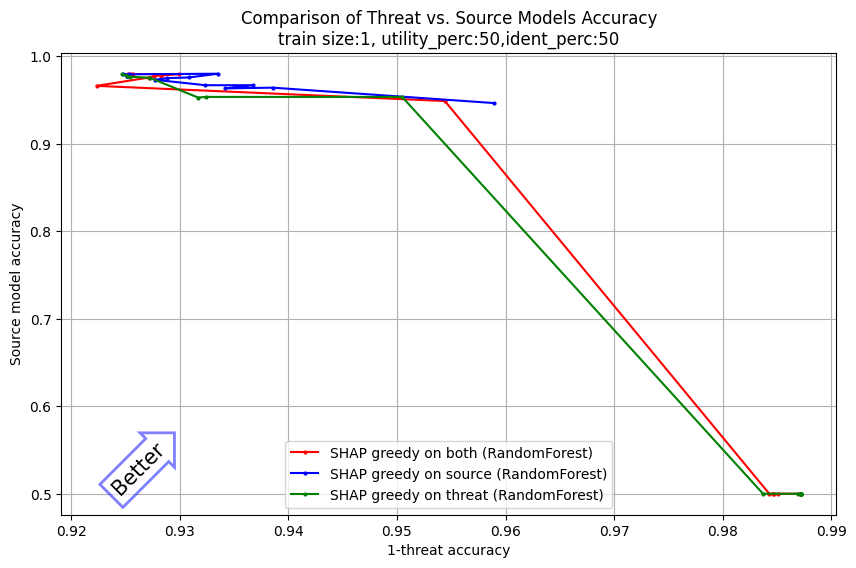

utility_perc: 75 ident_perc: 50


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

3.9760225375562084e-09
Percentile of features to keep: 3; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09


y_pred contains classes not in y_true


-0.03945059346270276
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.03945059346270276


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 6.512871220871145e-06


y_pred contains classes not in y_true


3.9760225375562084e-09
Percentile of features to keep: 5; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09


y_pred contains classes not in y_true


-0.039024620880503076
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.039024620880503076


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 1.6908712559311328e-05


y_pred contains classes not in y_true


3.9760225375562084e-09
Percentile of features to keep: 7; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09


y_pred contains classes not in y_true


-0.03719208079191146
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.03719208079191146


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 2.0626049493629663e-05


y_pred contains classes not in y_true


3.9760225375562084e-09
Percentile of features to keep: 9; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09


y_pred contains classes not in y_true


-0.032724735489875596
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.032724735489875596


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 7.399094223423003e-05
3.9760225375562084e-09
Percentile of features to keep: 10; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09


y_pred contains classes not in y_true


-0.030528141252439064
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.030528141252439064


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 0.00012599827985585753
1.8051797480973213e-08
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 1.8051797480973213e-08


y_pred contains classes not in y_true


-0.014033325289469148
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.014033325289469148


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 0.000555330711886128


y_pred contains classes not in y_true


9.378546362341515e-07
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 9.378546362341515e-07
-0.008161181080517534
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.008161181080517534


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 0.0008260039925160453


y_pred contains classes not in y_true


9.167330963282947e-06
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 9.167330963282947e-06


y_pred contains classes not in y_true


-0.003798830152061578
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.003798830152061578


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 0.00157949425667073


y_pred contains classes not in y_true


1.533239007913022e-05
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 1.533239007913022e-05


y_pred contains classes not in y_true


-0.002994875399528907
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.002994875399528907


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 0.002564591238040659


y_pred contains classes not in y_true


1.7403752007480012e-05
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 1.7403752007480012e-05


y_pred contains classes not in y_true


-0.0024765229168436154
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.0024765229168436154


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 0.0038911625496031747


y_pred contains classes not in y_true


2.0590769289333242e-05
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 2.0590769289333242e-05


y_pred contains classes not in y_true


-0.0011128758624084829
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.0011128758624084829


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 0.004985208244771151


y_pred contains classes not in y_true


2.6912971013156287e-05
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 2.6912971013156287e-05


y_pred contains classes not in y_true


3.213758878396574e-05
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 3.213758878396574e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 0.006788900938572894


y_pred contains classes not in y_true


3.4411598868195356e-05
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 3.4411598868195356e-05


y_pred contains classes not in y_true


3.213758878396574e-05
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 3.213758878396574e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 55; Ratio Threshold: 0.018425489913863353


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 58; Ratio Threshold: inf


y_pred contains classes not in y_true
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:27<00:00, 207.71s/it]


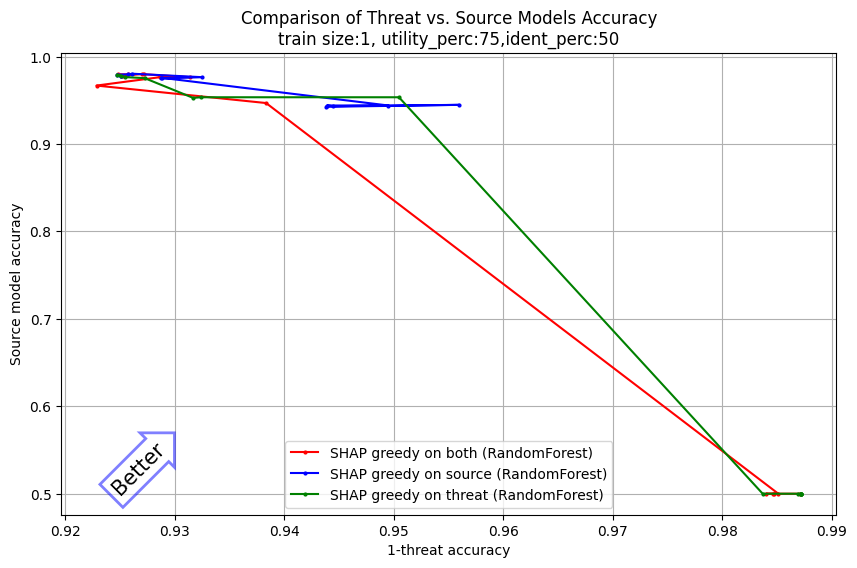

utility_perc: 90 ident_perc: 50


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

3.9760225375562084e-09
Percentile of features to keep: 3; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09


y_pred contains classes not in y_true


-0.04086720052566033
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.04086720052566033


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 3.908638808176568e-06


y_pred contains classes not in y_true


3.9760225375562084e-09
Percentile of features to keep: 5; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09


y_pred contains classes not in y_true


-0.040430395546674644
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.040430395546674644


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 9.05325360258258e-06


y_pred contains classes not in y_true


3.9760225375562084e-09
Percentile of features to keep: 7; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09


y_pred contains classes not in y_true


-0.039370377856861524
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.039370377856861524


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 1.2165747576843906e-05


y_pred contains classes not in y_true


3.9760225375562084e-09
Percentile of features to keep: 9; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09


y_pred contains classes not in y_true


-0.03673468233329452
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.03673468233329452


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 3.727358797360576e-05
3.9760225375562084e-09
Percentile of features to keep: 10; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09


y_pred contains classes not in y_true


-0.035776265985610727
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.035776265985610727


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 6.72666742395503e-05
1.8051797480973213e-08
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 1.8051797480973213e-08


y_pred contains classes not in y_true


-0.02135573061779886
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.02135573061779886


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 0.0004970174560986376


y_pred contains classes not in y_true


9.378546362341515e-07
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 9.378546362341515e-07
-0.012061937618049356
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.012061937618049356


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 0.0006668288149472866


y_pred contains classes not in y_true


9.167330963282947e-06
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 9.167330963282947e-06


y_pred contains classes not in y_true


-0.005784019191779126
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.005784019191779126


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 0.0010586370623624569


y_pred contains classes not in y_true


1.533239007913022e-05
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 1.533239007913022e-05


y_pred contains classes not in y_true


-0.0042775804168549165
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.0042775804168549165


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 0.0015747704839713186


y_pred contains classes not in y_true


1.7403752007480012e-05
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 1.7403752007480012e-05


y_pred contains classes not in y_true


-0.0030427312144867846
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.0030427312144867846


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 0.002588957140751485


y_pred contains classes not in y_true


2.0590769289333242e-05
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 2.0590769289333242e-05


y_pred contains classes not in y_true


-0.0018702918787782841
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.0018702918787782841


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 0.003675441210796661


y_pred contains classes not in y_true


2.6912971013156287e-05
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 2.6912971013156287e-05


y_pred contains classes not in y_true


3.213758878396574e-05
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 3.213758878396574e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 0.0053264859389998065


y_pred contains classes not in y_true


3.4411598868195356e-05
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 3.4411598868195356e-05


y_pred contains classes not in y_true


3.213758878396574e-05
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 3.213758878396574e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 55; Ratio Threshold: 0.008915639423063929


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 58; Ratio Threshold: inf


y_pred contains classes not in y_true
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:31<00:00, 211.23s/it]


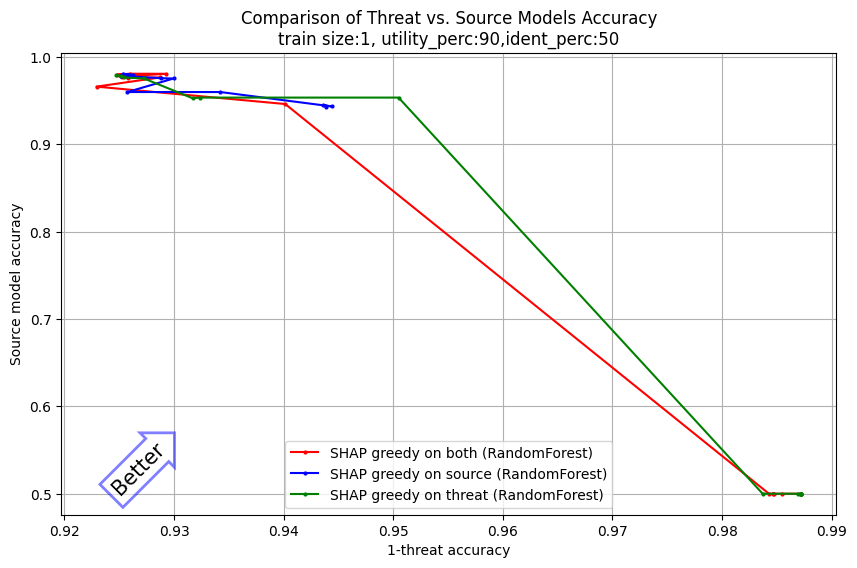

utility_perc: 95 ident_perc: 50


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

3.9760225375562084e-09
Percentile of features to keep: 3; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09


y_pred contains classes not in y_true


-0.05459593333017934
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.05459593333017934


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 2.835862276402423e-06


y_pred contains classes not in y_true


3.9760225375562084e-09
Percentile of features to keep: 5; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09


y_pred contains classes not in y_true


-0.041033604885966225
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.041033604885966225


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 7.008621204068931e-06


y_pred contains classes not in y_true


3.9760225375562084e-09
Percentile of features to keep: 7; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09


y_pred contains classes not in y_true


-0.04068842921831709
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.04068842921831709


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 9.186927069378189e-06


y_pred contains classes not in y_true


3.9760225375562084e-09
Percentile of features to keep: 9; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09


y_pred contains classes not in y_true


-0.04031626946973479
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.04031626946973479


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 2.5626553299800604e-05
3.9760225375562084e-09
Percentile of features to keep: 10; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09


y_pred contains classes not in y_true


-0.03901865298996735
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.03901865298996735


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 4.547448858376625e-05
1.8051797480973213e-08
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 1.8051797480973213e-08


y_pred contains classes not in y_true


-0.027701512069382303
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.027701512069382303


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 0.000396233592427822


y_pred contains classes not in y_true


9.378546362341515e-07
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 9.378546362341515e-07
-0.016602156664246172
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.016602156664246172


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 0.0006375745336327725


y_pred contains classes not in y_true


9.167330963282947e-06
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 9.167330963282947e-06


y_pred contains classes not in y_true


-0.008753547030012424
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.008753547030012424


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 0.0008921266920811932


y_pred contains classes not in y_true


1.533239007913022e-05
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 1.533239007913022e-05


y_pred contains classes not in y_true


-0.00576223911990981
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.00576223911990981


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 0.0012720812818262854


y_pred contains classes not in y_true


1.7403752007480012e-05
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 1.7403752007480012e-05


y_pred contains classes not in y_true


-0.0039916616721647775
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.0039916616721647775


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 0.0015596487075177842


y_pred contains classes not in y_true


2.0590769289333242e-05
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 2.0590769289333242e-05


y_pred contains classes not in y_true


-0.0025056274567876436
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.0025056274567876436


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 0.002595242534054613


y_pred contains classes not in y_true


2.6912971013156287e-05
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 2.6912971013156287e-05


y_pred contains classes not in y_true


4.2756508783457295e-05
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 4.2756508783457295e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 0.0039310159310139555


y_pred contains classes not in y_true


3.4411598868195356e-05
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 3.4411598868195356e-05


y_pred contains classes not in y_true


4.2756508783457295e-05
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 4.2756508783457295e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 55; Ratio Threshold: 0.0058693341937394675


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 58; Ratio Threshold: inf


y_pred contains classes not in y_true
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:33<00:00, 213.69s/it]


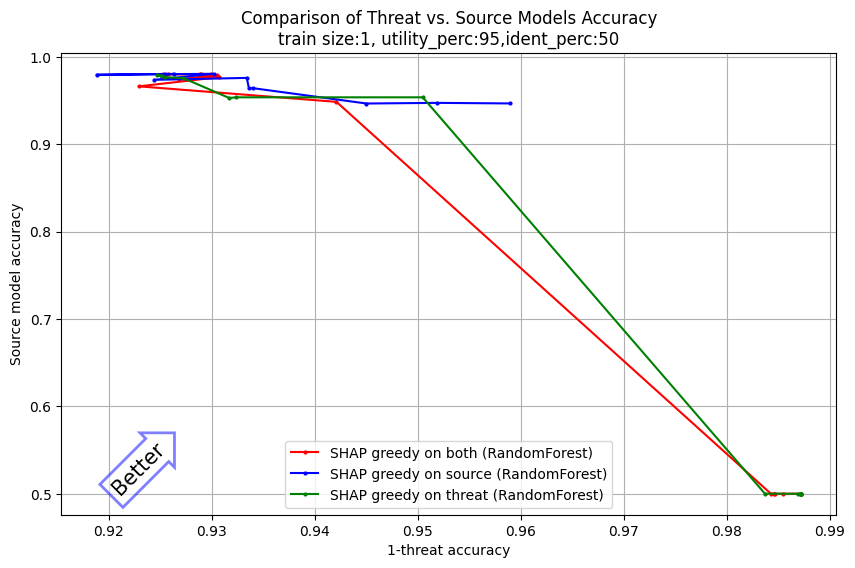

utility_perc: mean ident_perc: 50


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

3.9760225375562084e-09
Percentile of features to keep: 3; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09


y_pred contains classes not in y_true


-0.0259483046287807
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.0259483046287807


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 1.0267947755109346e-05


y_pred contains classes not in y_true


3.9760225375562084e-09
Percentile of features to keep: 5; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09


y_pred contains classes not in y_true


-0.021055770686732467
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.021055770686732467


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 2.036551022284549e-05


y_pred contains classes not in y_true


3.9760225375562084e-09
Percentile of features to keep: 7; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09


y_pred contains classes not in y_true


-0.019566215999852567
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.019566215999852567


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 2.5034905872997977e-05


y_pred contains classes not in y_true


3.9760225375562084e-09
Percentile of features to keep: 9; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09


y_pred contains classes not in y_true


-0.018518796471866567
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.018518796471866567


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 6.638909338046528e-05
3.9760225375562084e-09
Percentile of features to keep: 10; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09


y_pred contains classes not in y_true


-0.018298797875781588
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.018298797875781588


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 9.918466918233623e-05
1.8051797480973213e-08
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 1.8051797480973213e-08


y_pred contains classes not in y_true


-0.011480830745940428
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.011480830745940428


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 0.0008145389930097145


y_pred contains classes not in y_true


9.378546362341515e-07
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 9.378546362341515e-07
-0.007032418034195749
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.007032418034195749


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 0.0012208930751894406


y_pred contains classes not in y_true


9.167330963282947e-06
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 9.167330963282947e-06


y_pred contains classes not in y_true


-0.0032641488662918327
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.0032641488662918327


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 0.001997477570481198


y_pred contains classes not in y_true


1.533239007913022e-05
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 1.533239007913022e-05


y_pred contains classes not in y_true


-0.0026320228393253977
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.0026320228393253977


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 0.0028582338947832934


y_pred contains classes not in y_true


1.7403752007480012e-05
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 1.7403752007480012e-05


y_pred contains classes not in y_true


-0.0018981602316618072
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.0018981602316618072


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 0.004031097059157718


y_pred contains classes not in y_true


2.0590769289333242e-05
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 2.0590769289333242e-05


y_pred contains classes not in y_true


-0.001045037868649539
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.001045037868649539


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 0.006335047531285966


y_pred contains classes not in y_true


2.6912971013156287e-05
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 2.6912971013156287e-05


y_pred contains classes not in y_true


4.010057997261147e-05
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 4.010057997261147e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 0.008108088662218006


y_pred contains classes not in y_true


3.4411598868195356e-05
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 3.4411598868195356e-05


y_pred contains classes not in y_true


4.010057997261147e-05
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 4.010057997261147e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 55; Ratio Threshold: 0.017570336220296155


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 58; Ratio Threshold: inf


y_pred contains classes not in y_true
100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:09<00:00, 69.13s/it]


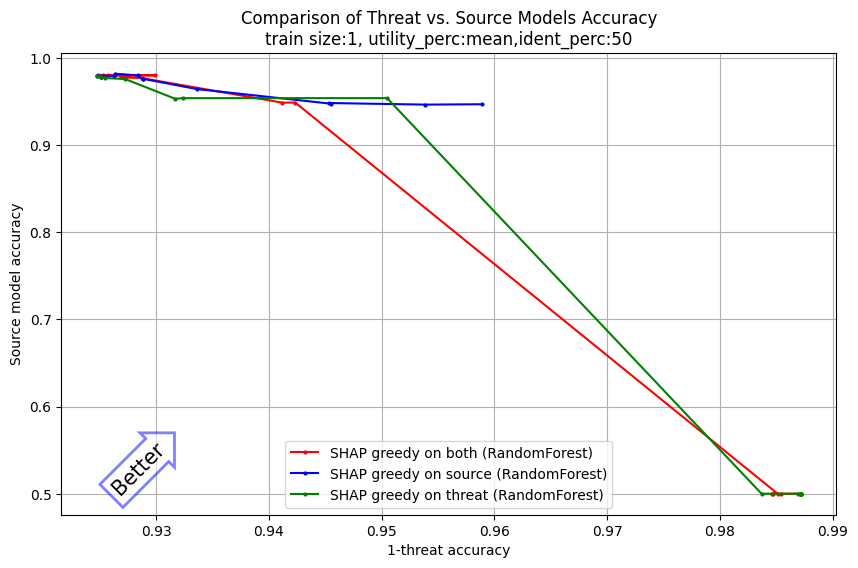

utility_perc: max ident_perc: 50


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

3.9760225375562084e-09
Percentile of features to keep: 3; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09


y_pred contains classes not in y_true


-0.1016866075608704
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.1016866075608704


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 5.310739838815323e-07


y_pred contains classes not in y_true


3.9760225375562084e-09
Percentile of features to keep: 5; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09


y_pred contains classes not in y_true


-0.09271234153429635
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.09271234153429635


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 1.3220359093129496e-06


y_pred contains classes not in y_true


3.9760225375562084e-09
Percentile of features to keep: 7; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09


y_pred contains classes not in y_true


-0.08986603190891636
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.08986603190891636


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 2.900662180004852e-06


y_pred contains classes not in y_true


3.9760225375562084e-09
Percentile of features to keep: 9; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09


y_pred contains classes not in y_true


-0.0871483882831555
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.0871483882831555


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 3.481115092287562e-06
3.9760225375562084e-09
Percentile of features to keep: 10; Number of features to keep: 14; Ratio Threshold: 3.9760225375562084e-09


y_pred contains classes not in y_true


-0.0846134257187882
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.0846134257187882


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 3.854904894386281e-06
1.8051797480973213e-08
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 1.8051797480973213e-08


y_pred contains classes not in y_true


-0.060634260505662216
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.060634260505662216


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 8.551801243088018e-05


y_pred contains classes not in y_true


9.378546362341515e-07
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 9.378546362341515e-07
-0.05257643291437132
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.05257643291437132


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 0.00024870088519078447


y_pred contains classes not in y_true


9.167330963282947e-06
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 9.167330963282947e-06


y_pred contains classes not in y_true


-0.040647567732224485
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.040647567732224485


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 0.0003404627572980091


y_pred contains classes not in y_true


1.533239007913022e-05
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 1.533239007913022e-05


y_pred contains classes not in y_true


-0.032259991762437816
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.032259991762437816


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 0.0004262675452416379


y_pred contains classes not in y_true


1.7403752007480012e-05
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 1.7403752007480012e-05


y_pred contains classes not in y_true


-0.023236954334763874
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.023236954334763874


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 0.0005342805121504882


y_pred contains classes not in y_true


2.0590769289333242e-05
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 2.0590769289333242e-05


y_pred contains classes not in y_true


-0.011443154446650549
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.011443154446650549


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 0.0006187104758188166


y_pred contains classes not in y_true


2.6912971013156287e-05
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 2.6912971013156287e-05


y_pred contains classes not in y_true


0.006214009359019575
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 0.006214009359019575


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 0.0007816284427355714


y_pred contains classes not in y_true


3.4411598868195356e-05
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 3.4411598868195356e-05


y_pred contains classes not in y_true


0.006214009359019575
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 0.006214009359019575


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 55; Ratio Threshold: 0.001654856822031393


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 58; Ratio Threshold: inf


y_pred contains classes not in y_true
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:20<00:00, 200.20s/it]


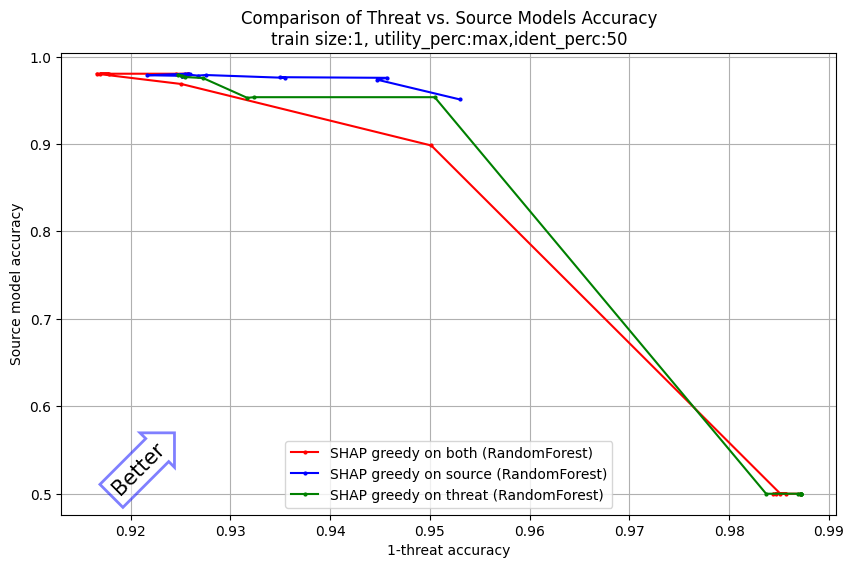

utility_perc: 50 ident_perc: 75


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

4.155116407929307e-09
Percentile of features to keep: 3; Number of features to keep: 14; Ratio Threshold: 4.155116407929307e-09


y_pred contains classes not in y_true


-0.017186058932801878
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.017186058932801878


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 5.900273324462614e-05


y_pred contains classes not in y_true


4.155116407929307e-09
Percentile of features to keep: 5; Number of features to keep: 14; Ratio Threshold: 4.155116407929307e-09


y_pred contains classes not in y_true


-0.014324794859580516
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.014324794859580516


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 9.853753185609399e-05


y_pred contains classes not in y_true


4.155116407929307e-09
Percentile of features to keep: 7; Number of features to keep: 14; Ratio Threshold: 4.155116407929307e-09


y_pred contains classes not in y_true


-0.013924149665299406
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.013924149665299406


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 0.00022260385184002938
4.155116407929307e-09
Percentile of features to keep: 9; Number of features to keep: 14; Ratio Threshold: 4.155116407929307e-09


y_pred contains classes not in y_true


-0.012922438937072558
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.012922438937072558


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 0.0002835552289979429
4.155116407929307e-09
Percentile of features to keep: 10; Number of features to keep: 14; Ratio Threshold: 4.155116407929307e-09


y_pred contains classes not in y_true


-0.01230915873344437
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.01230915873344437


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 0.0003214004718162805
5.4105315569817286e-08
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 5.4105315569817286e-08


y_pred contains classes not in y_true


-0.010060251140668669
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.010060251140668669


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 0.00276667824112661


y_pred contains classes not in y_true


1.967713782230954e-06
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 1.967713782230954e-06


y_pred contains classes not in y_true


-0.00558057558115986
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.00558057558115986


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 0.005214700530792825


y_pred contains classes not in y_true


2.452825215104885e-05
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 2.452825215104885e-05


y_pred contains classes not in y_true


-0.0022942646701500646
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.0022942646701500646


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 0.008182952052254085


y_pred contains classes not in y_true


3.768605924792595e-05
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 3.768605924792595e-05


y_pred contains classes not in y_true


-0.0016862628171452156
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.0016862628171452156


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 0.014184500049633788


y_pred contains classes not in y_true


4.9349972199096595e-05
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 4.9349972199096595e-05


y_pred contains classes not in y_true


-0.0013306225225515917
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.0013306225225515917


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 0.016461160208935247


y_pred contains classes not in y_true


6.720487320607391e-05
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 6.720487320607391e-05


y_pred contains classes not in y_true


-0.0006269908425126871
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.0006269908425126871


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 0.022159770895486392


y_pred contains classes not in y_true


0.00010716156979501502
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 0.00010716156979501502


y_pred contains classes not in y_true


1.2532187113267354e-05
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 1.2532187113267354e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 0.031137662132626604


y_pred contains classes not in y_true


0.000154967709365266
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 0.000154967709365266


y_pred contains classes not in y_true


1.2532187113267354e-05
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 1.2532187113267354e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 55; Ratio Threshold: 0.1847497594488441


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 58; Ratio Threshold: inf


y_pred contains classes not in y_true
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:37<00:00, 217.79s/it]


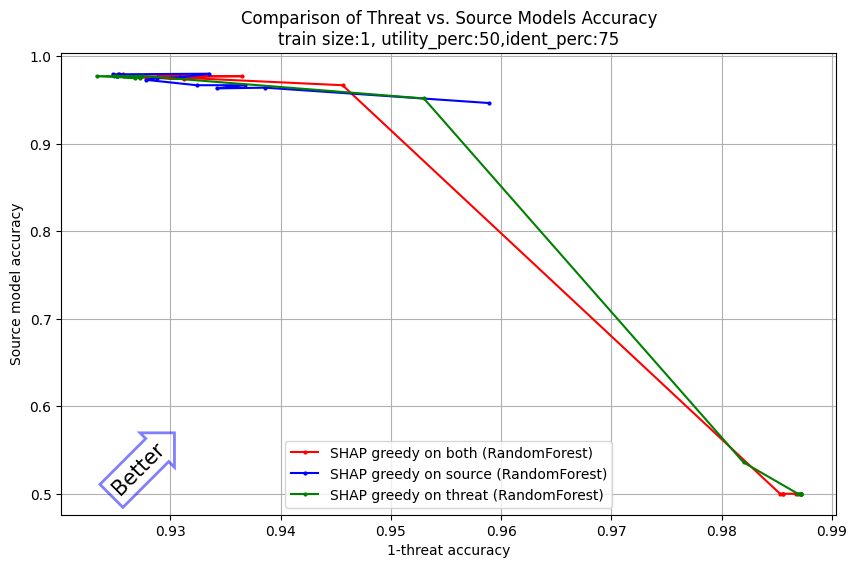

utility_perc: 75 ident_perc: 75


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

4.155116407929307e-09
Percentile of features to keep: 3; Number of features to keep: 14; Ratio Threshold: 4.155116407929307e-09


y_pred contains classes not in y_true


-0.03945059346270276
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.03945059346270276


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 2.426246716197172e-05


y_pred contains classes not in y_true


4.155116407929307e-09
Percentile of features to keep: 5; Number of features to keep: 14; Ratio Threshold: 4.155116407929307e-09


y_pred contains classes not in y_true


-0.039024620880503076
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.039024620880503076


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 3.877743659818509e-05


y_pred contains classes not in y_true


4.155116407929307e-09
Percentile of features to keep: 7; Number of features to keep: 14; Ratio Threshold: 4.155116407929307e-09


y_pred contains classes not in y_true


-0.03719208079191146
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.03719208079191146


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 8.409912695914853e-05


y_pred contains classes not in y_true


4.155116407929307e-09
Percentile of features to keep: 9; Number of features to keep: 14; Ratio Threshold: 4.155116407929307e-09


y_pred contains classes not in y_true


-0.032724735489875596
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.032724735489875596


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 0.00014055001587977208


y_pred contains classes not in y_true


4.155116407929307e-09
Percentile of features to keep: 10; Number of features to keep: 14; Ratio Threshold: 4.155116407929307e-09


y_pred contains classes not in y_true


-0.030528141252439064
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.030528141252439064


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 0.00015793850089042705
5.4105315569817286e-08
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 5.4105315569817286e-08


y_pred contains classes not in y_true


-0.014033325289469148
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.014033325289469148


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 0.001319801358247901


y_pred contains classes not in y_true


1.967713782230954e-06
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 1.967713782230954e-06


y_pred contains classes not in y_true


-0.008161181080517534
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.008161181080517534


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 0.0031478557996782583


y_pred contains classes not in y_true


2.452825215104885e-05
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 2.452825215104885e-05


y_pred contains classes not in y_true


-0.003798830152061578
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.003798830152061578


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 0.005102870408999891


y_pred contains classes not in y_true


3.768605924792595e-05
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 3.768605924792595e-05


y_pred contains classes not in y_true


-0.002994875399528907
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.002994875399528907


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 0.007468070325575802


y_pred contains classes not in y_true


4.9349972199096595e-05
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 4.9349972199096595e-05


y_pred contains classes not in y_true


-0.0024765229168436154
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.0024765229168436154


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 0.01207935735326374


y_pred contains classes not in y_true


6.720487320607391e-05
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 6.720487320607391e-05


y_pred contains classes not in y_true


-0.0011128758624084829
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.0011128758624084829


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 0.016489251498604376


y_pred contains classes not in y_true


0.00010716156979501502
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 0.00010716156979501502


y_pred contains classes not in y_true


3.213758878396574e-05
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 3.213758878396574e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 0.020867526057865952


y_pred contains classes not in y_true


0.000154967709365266
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 0.000154967709365266


y_pred contains classes not in y_true


3.213758878396574e-05
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 3.213758878396574e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 55; Ratio Threshold: 0.05371836697314234


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 58; Ratio Threshold: inf


y_pred contains classes not in y_true
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:31<00:00, 211.73s/it]


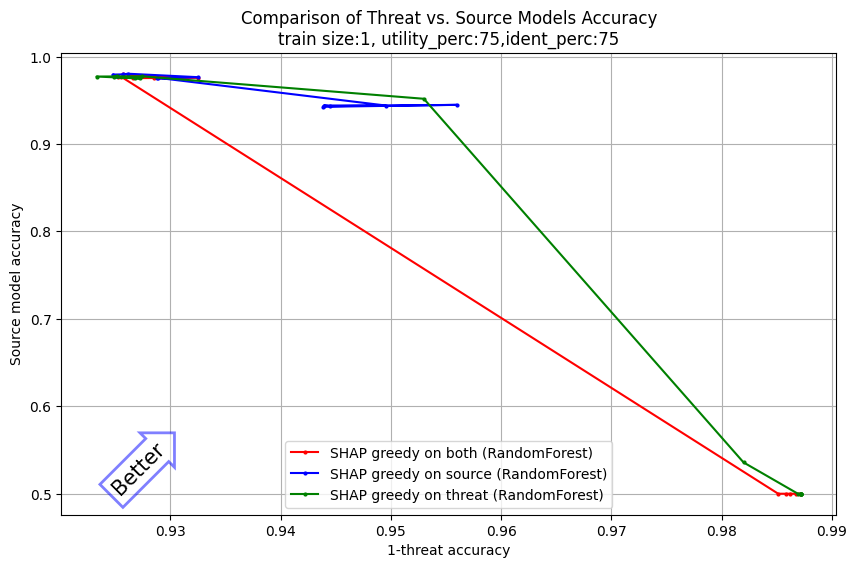

utility_perc: 90 ident_perc: 75


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

4.155116407929307e-09
Percentile of features to keep: 3; Number of features to keep: 14; Ratio Threshold: 4.155116407929307e-09


y_pred contains classes not in y_true


-0.04086720052566033
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.04086720052566033


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 1.3405348469485688e-05


y_pred contains classes not in y_true


4.155116407929307e-09
Percentile of features to keep: 5; Number of features to keep: 14; Ratio Threshold: 4.155116407929307e-09


y_pred contains classes not in y_true


-0.040430395546674644
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.040430395546674644


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 1.9067482546699158e-05


y_pred contains classes not in y_true


4.155116407929307e-09
Percentile of features to keep: 7; Number of features to keep: 14; Ratio Threshold: 4.155116407929307e-09


y_pred contains classes not in y_true


-0.039370377856861524
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.039370377856861524


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 5.3010038145388455e-05


y_pred contains classes not in y_true


4.155116407929307e-09
Percentile of features to keep: 9; Number of features to keep: 14; Ratio Threshold: 4.155116407929307e-09


y_pred contains classes not in y_true


-0.03673468233329452
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.03673468233329452


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 9.45259773757695e-05


y_pred contains classes not in y_true


4.155116407929307e-09
Percentile of features to keep: 10; Number of features to keep: 14; Ratio Threshold: 4.155116407929307e-09


y_pred contains classes not in y_true


-0.035776265985610727
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.035776265985610727


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 0.00010505631730544622
5.4105315569817286e-08
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 5.4105315569817286e-08


y_pred contains classes not in y_true


-0.02135573061779886
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.02135573061779886


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 0.0011403862962788155


y_pred contains classes not in y_true


1.967713782230954e-06
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 1.967713782230954e-06


y_pred contains classes not in y_true


-0.012061937618049356
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.012061937618049356


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 0.0024879161235950064


y_pred contains classes not in y_true


2.452825215104885e-05
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 2.452825215104885e-05


y_pred contains classes not in y_true


-0.005784019191779126
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.005784019191779126


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 0.00362050274373767


y_pred contains classes not in y_true


3.768605924792595e-05
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 3.768605924792595e-05


y_pred contains classes not in y_true


-0.0042775804168549165
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.0042775804168549165


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 0.005682699609872164


y_pred contains classes not in y_true


4.9349972199096595e-05
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 4.9349972199096595e-05


y_pred contains classes not in y_true


-0.0030427312144867846
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.0030427312144867846


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 0.008217012743486593


y_pred contains classes not in y_true


6.720487320607391e-05
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 6.720487320607391e-05


y_pred contains classes not in y_true


-0.0018702918787782841
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.0018702918787782841


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 0.011599314280031494


y_pred contains classes not in y_true


0.00010716156979501502
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 0.00010716156979501502


y_pred contains classes not in y_true


3.213758878396574e-05
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 3.213758878396574e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 0.01543452453856249


y_pred contains classes not in y_true


0.000154967709365266
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 0.000154967709365266


y_pred contains classes not in y_true


3.213758878396574e-05
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 3.213758878396574e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 55; Ratio Threshold: 0.050699757229897245


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 58; Ratio Threshold: inf


y_pred contains classes not in y_true
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:32<00:00, 212.84s/it]


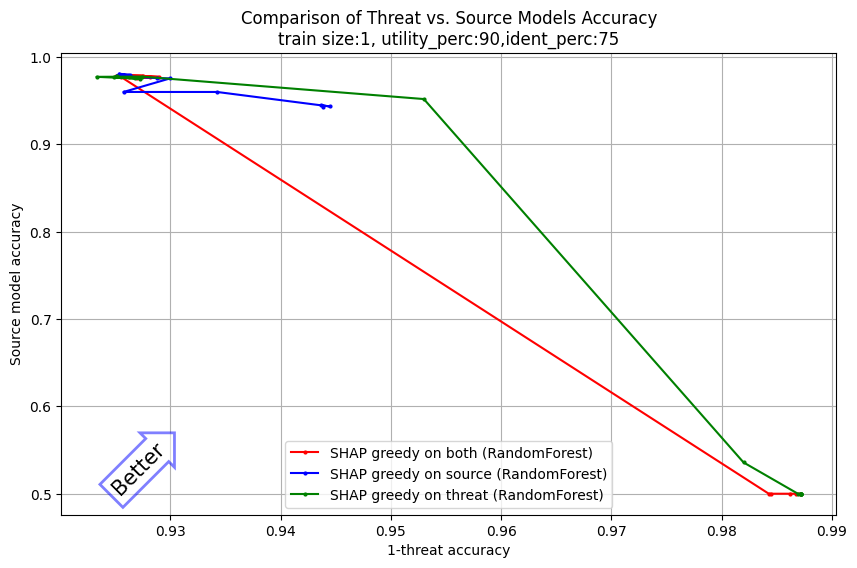

utility_perc: 95 ident_perc: 75


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

4.155116407929307e-09
Percentile of features to keep: 3; Number of features to keep: 14; Ratio Threshold: 4.155116407929307e-09


y_pred contains classes not in y_true


-0.05459593333017934
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.05459593333017934


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 1.0764195455416011e-05


y_pred contains classes not in y_true


4.155116407929307e-09
Percentile of features to keep: 5; Number of features to keep: 14; Ratio Threshold: 4.155116407929307e-09


y_pred contains classes not in y_true


-0.041033604885966225
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.041033604885966225


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 1.4710192110894954e-05


y_pred contains classes not in y_true


4.155116407929307e-09
Percentile of features to keep: 7; Number of features to keep: 14; Ratio Threshold: 4.155116407929307e-09


y_pred contains classes not in y_true


-0.04068842921831709
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.04068842921831709


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 3.6897693666222406e-05


y_pred contains classes not in y_true


4.155116407929307e-09
Percentile of features to keep: 9; Number of features to keep: 14; Ratio Threshold: 4.155116407929307e-09


y_pred contains classes not in y_true


-0.04031626946973479
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.04031626946973479


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 6.597840963523045e-05


y_pred contains classes not in y_true


4.155116407929307e-09
Percentile of features to keep: 10; Number of features to keep: 14; Ratio Threshold: 4.155116407929307e-09


y_pred contains classes not in y_true


-0.03901865298996735
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.03901865298996735


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 7.72003166363092e-05
5.4105315569817286e-08
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 5.4105315569817286e-08


y_pred contains classes not in y_true


-0.027701512069382303
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.027701512069382303


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 0.000942932078632172


y_pred contains classes not in y_true


1.967713782230954e-06
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 1.967713782230954e-06


y_pred contains classes not in y_true


-0.016602156664246172
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.016602156664246172


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 0.0019965209016986484


y_pred contains classes not in y_true


2.452825215104885e-05
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 2.452825215104885e-05


y_pred contains classes not in y_true


-0.008753547030012424
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.008753547030012424


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 0.003021844472387949


y_pred contains classes not in y_true


3.768605924792595e-05
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 3.768605924792595e-05


y_pred contains classes not in y_true


-0.00576223911990981
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.00576223911990981


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 0.004739403313108468


y_pred contains classes not in y_true


4.9349972199096595e-05
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 4.9349972199096595e-05


y_pred contains classes not in y_true


-0.0039916616721647775
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.0039916616721647775


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 0.00590538142989767


y_pred contains classes not in y_true


6.720487320607391e-05
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 6.720487320607391e-05


y_pred contains classes not in y_true


-0.0025056274567876436
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.0025056274567876436


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 0.00860923939079851


y_pred contains classes not in y_true


0.00010716156979501502
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 0.00010716156979501502


y_pred contains classes not in y_true


4.2756508783457295e-05
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 4.2756508783457295e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 0.01116139562360278


y_pred contains classes not in y_true


0.000154967709365266
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 0.000154967709365266


y_pred contains classes not in y_true


4.2756508783457295e-05
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 4.2756508783457295e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 55; Ratio Threshold: 0.03581920734812532


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 58; Ratio Threshold: inf


y_pred contains classes not in y_true
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:35<00:00, 215.34s/it]


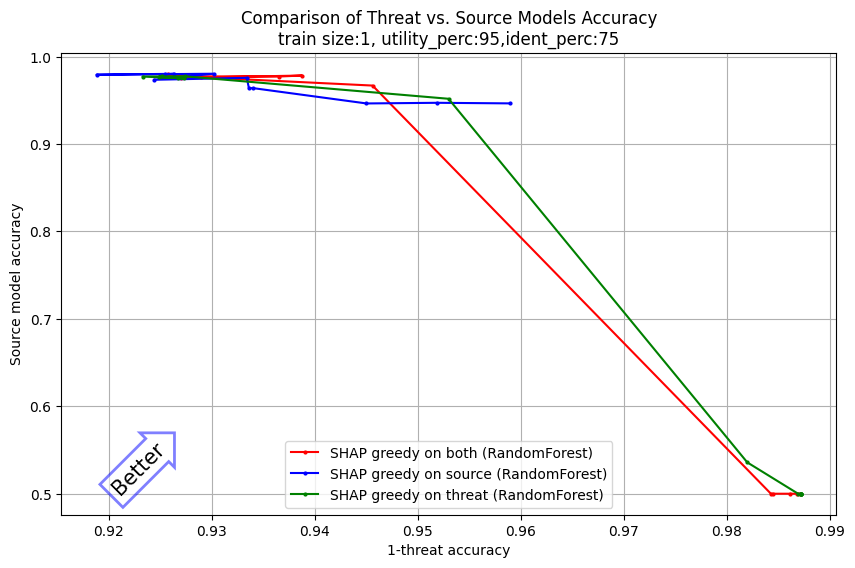

utility_perc: mean ident_perc: 75


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

4.155116407929307e-09
Percentile of features to keep: 3; Number of features to keep: 14; Ratio Threshold: 4.155116407929307e-09


y_pred contains classes not in y_true


-0.0259483046287807
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.0259483046287807


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 3.231362313669952e-05


y_pred contains classes not in y_true


4.155116407929307e-09
Percentile of features to keep: 5; Number of features to keep: 14; Ratio Threshold: 4.155116407929307e-09


y_pred contains classes not in y_true


-0.021055770686732467
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.021055770686732467


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 4.393247814583739e-05


y_pred contains classes not in y_true


4.155116407929307e-09
Percentile of features to keep: 7; Number of features to keep: 14; Ratio Threshold: 4.155116407929307e-09


y_pred contains classes not in y_true


-0.019566215999852567
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.019566215999852567


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 0.000104324210114755


y_pred contains classes not in y_true


4.155116407929307e-09
Percentile of features to keep: 9; Number of features to keep: 14; Ratio Threshold: 4.155116407929307e-09


y_pred contains classes not in y_true


-0.018518796471866567
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.018518796471866567


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 0.00012370889042182605


y_pred contains classes not in y_true


4.155116407929307e-09
Percentile of features to keep: 10; Number of features to keep: 14; Ratio Threshold: 4.155116407929307e-09


y_pred contains classes not in y_true


-0.018298797875781588
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.018298797875781588


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 0.00014706055305019428


y_pred contains classes not in y_true


5.4105315569817286e-08
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 5.4105315569817286e-08


y_pred contains classes not in y_true


-0.011480830745940428
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.011480830745940428


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 0.0019320796138886783


y_pred contains classes not in y_true


1.967713782230954e-06
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 1.967713782230954e-06


y_pred contains classes not in y_true


-0.007032418034195749
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.007032418034195749


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 0.004489836995600294


y_pred contains classes not in y_true


2.452825215104885e-05
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 2.452825215104885e-05


y_pred contains classes not in y_true


-0.0032641488662918327
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.0032641488662918327


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 0.006422333865250442


y_pred contains classes not in y_true


3.768605924792595e-05
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 3.768605924792595e-05


y_pred contains classes not in y_true


-0.0026320228393253977
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.0026320228393253977


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 0.010698127918523823


y_pred contains classes not in y_true


4.9349972199096595e-05
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 4.9349972199096595e-05


y_pred contains classes not in y_true


-0.0018981602316618072
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.0018981602316618072


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 0.014798947208163878


y_pred contains classes not in y_true


6.720487320607391e-05
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 6.720487320607391e-05


y_pred contains classes not in y_true


-0.001045037868649539
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.001045037868649539


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 0.017881327892199414


y_pred contains classes not in y_true


0.00010716156979501502
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 0.00010716156979501502


y_pred contains classes not in y_true


4.010057997261147e-05
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 4.010057997261147e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 0.023841838921090267


y_pred contains classes not in y_true


0.000154967709365266
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 0.000154967709365266


y_pred contains classes not in y_true


4.010057997261147e-05
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 4.010057997261147e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 55; Ratio Threshold: 0.09698366121607054


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 58; Ratio Threshold: inf


y_pred contains classes not in y_true
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:33<00:00, 213.78s/it]


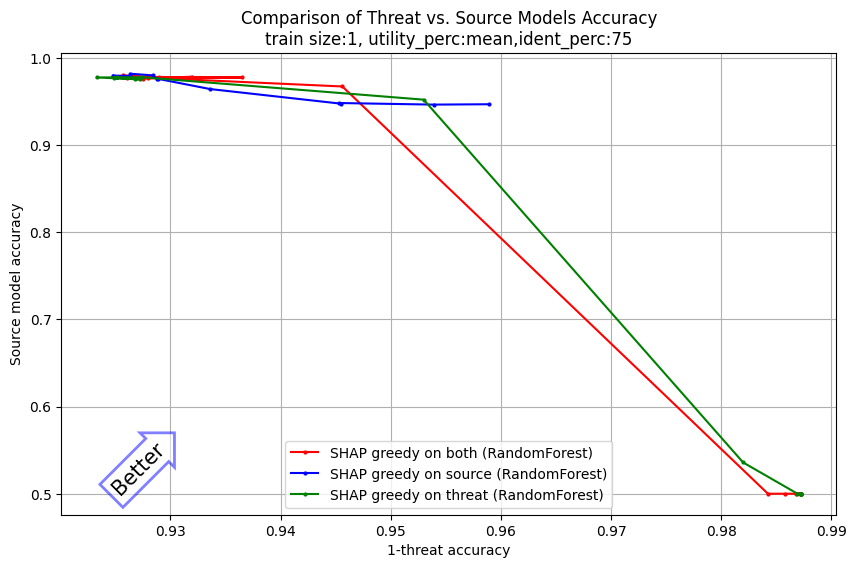

utility_perc: max ident_perc: 75


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

4.155116407929307e-09
Percentile of features to keep: 3; Number of features to keep: 14; Ratio Threshold: 4.155116407929307e-09


y_pred contains classes not in y_true


-0.1016866075608704
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.1016866075608704


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 5.549954014110876e-07


y_pred contains classes not in y_true


4.155116407929307e-09
Percentile of features to keep: 5; Number of features to keep: 14; Ratio Threshold: 4.155116407929307e-09


y_pred contains classes not in y_true


-0.09271234153429635
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.09271234153429635


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 4.055178839527932e-06


y_pred contains classes not in y_true


4.155116407929307e-09
Percentile of features to keep: 7; Number of features to keep: 14; Ratio Threshold: 4.155116407929307e-09


y_pred contains classes not in y_true


-0.08986603190891636
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.08986603190891636


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 6.455267833317103e-06


y_pred contains classes not in y_true


4.155116407929307e-09
Percentile of features to keep: 9; Number of features to keep: 14; Ratio Threshold: 4.155116407929307e-09


y_pred contains classes not in y_true


-0.0871483882831555
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.0871483882831555


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 9.921641256282797e-06
4.155116407929307e-09
Percentile of features to keep: 10; Number of features to keep: 14; Ratio Threshold: 4.155116407929307e-09


y_pred contains classes not in y_true


-0.0846134257187882
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.0846134257187882


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 1.1548552305692824e-05


y_pred contains classes not in y_true


5.4105315569817286e-08
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 5.4105315569817286e-08


y_pred contains classes not in y_true


-0.060634260505662216
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.060634260505662216


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 0.00023401978272894695


y_pred contains classes not in y_true


1.967713782230954e-06
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 1.967713782230954e-06


y_pred contains classes not in y_true


-0.05257643291437132
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.05257643291437132


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 0.0006140778591871484


y_pred contains classes not in y_true


2.452825215104885e-05
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 2.452825215104885e-05


y_pred contains classes not in y_true


-0.040647567732224485
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.040647567732224485


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 0.0011045304752252422


y_pred contains classes not in y_true


3.768605924792595e-05
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 3.768605924792595e-05


y_pred contains classes not in y_true


-0.032259991762437816
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.032259991762437816


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 0.0013984039122055425


y_pred contains classes not in y_true


4.9349972199096595e-05
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 4.9349972199096595e-05


y_pred contains classes not in y_true


-0.023236954334763874
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.023236954334763874


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 0.0018336809816160405


y_pred contains classes not in y_true


6.720487320607391e-05
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 6.720487320607391e-05


y_pred contains classes not in y_true


-0.011443154446650549
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.011443154446650549


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 0.002172838580393961


y_pred contains classes not in y_true


0.00010716156979501502
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 0.00010716156979501502


y_pred contains classes not in y_true


0.006214009359019575
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 0.006214009359019575


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 0.002774280411917566


y_pred contains classes not in y_true


0.000154967709365266
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 0.000154967709365266


y_pred contains classes not in y_true


0.006214009359019575
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 0.006214009359019575


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 55; Ratio Threshold: 0.004749038990681634


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 58; Ratio Threshold: inf


y_pred contains classes not in y_true
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:24<00:00, 204.64s/it]


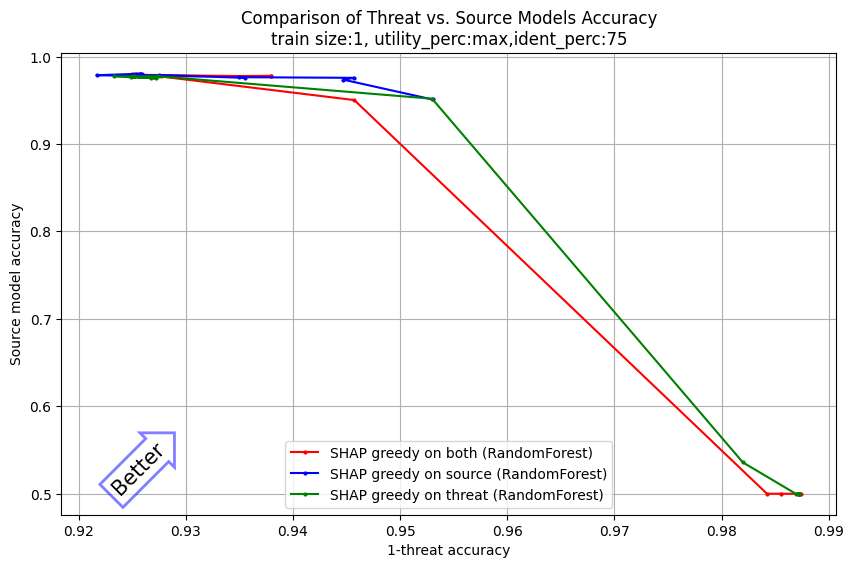

utility_perc: 50 ident_perc: 90


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

1.237458988101425e-07
Percentile of features to keep: 3; Number of features to keep: 13; Ratio Threshold: 1.237458988101425e-07


y_pred contains classes not in y_true


-0.017186058932801878
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.017186058932801878


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 0.0010463796555728988


y_pred contains classes not in y_true


1.237458988101425e-07
Percentile of features to keep: 5; Number of features to keep: 13; Ratio Threshold: 1.237458988101425e-07


y_pred contains classes not in y_true


-0.014324794859580516
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.014324794859580516


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 0.0011478324653835924
1.237458988101425e-07
Percentile of features to keep: 7; Number of features to keep: 13; Ratio Threshold: 1.237458988101425e-07


y_pred contains classes not in y_true


-0.013924149665299406
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.013924149665299406


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 0.0013271507592877714
1.237458988101425e-07
Percentile of features to keep: 9; Number of features to keep: 13; Ratio Threshold: 1.237458988101425e-07


y_pred contains classes not in y_true


-0.012922438937072558
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.012922438937072558


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 0.0020323244565171516
1.237458988101425e-07
Percentile of features to keep: 10; Number of features to keep: 13; Ratio Threshold: 1.237458988101425e-07


y_pred contains classes not in y_true


-0.01230915873344437
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.01230915873344437


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 0.0025440457148423663
5.641148096500045e-07
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 5.641148096500045e-07


y_pred contains classes not in y_true


-0.010060251140668669
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.010060251140668669


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 0.006440683386011633


y_pred contains classes not in y_true


1.0370367824938097e-05
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 1.0370367824938097e-05
-0.00558057558115986
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.00558057558115986


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 0.010837614211461117


y_pred contains classes not in y_true


5.9533977385968276e-05
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 5.9533977385968276e-05


y_pred contains classes not in y_true


-0.0022942646701500646
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.0022942646701500646


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 0.01650889772203064


y_pred contains classes not in y_true


7.519647230158092e-05
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 7.519647230158092e-05


y_pred contains classes not in y_true


-0.0016862628171452156
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.0016862628171452156


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 0.02010109121169959


y_pred contains classes not in y_true


8.609632407042576e-05
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 8.609632407042576e-05


y_pred contains classes not in y_true


-0.0013306225225515917
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.0013306225225515917


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 0.02736385457483892


y_pred contains classes not in y_true


0.00010233160184723627
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 0.00010233160184723627


y_pred contains classes not in y_true


-0.0006269908425126871
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.0006269908425126871


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 0.039488955837108645


y_pred contains classes not in y_true


0.00013063477703981522
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 0.00013063477703981522


y_pred contains classes not in y_true


1.2532187113267354e-05
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 1.2532187113267354e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 0.056654719596894755


y_pred contains classes not in y_true


0.00018179863338824213
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 0.00018179863338824213


y_pred contains classes not in y_true


1.2532187113267354e-05
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 1.2532187113267354e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 55; Ratio Threshold: 0.272156370814029


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 58; Ratio Threshold: inf


y_pred contains classes not in y_true
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:37<00:00, 217.59s/it]


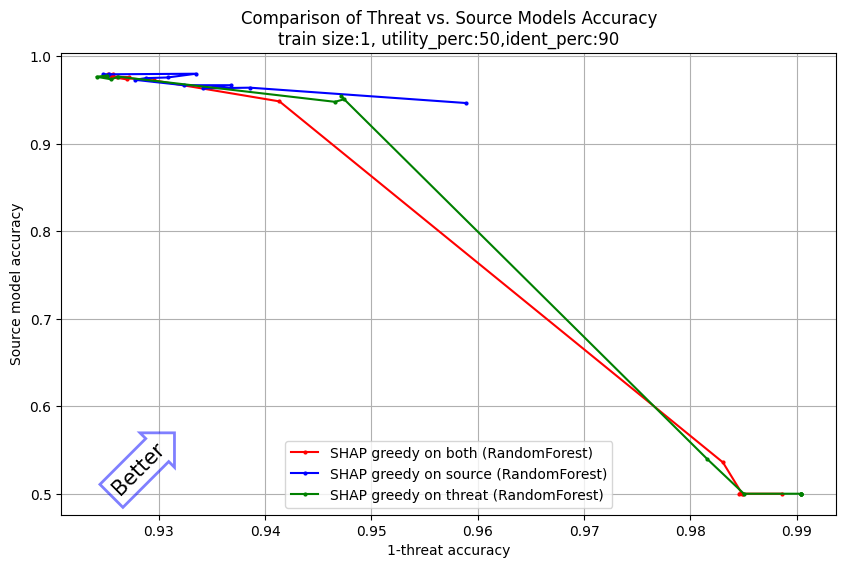

utility_perc: 75 ident_perc: 90


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

1.237458988101425e-07
Percentile of features to keep: 3; Number of features to keep: 13; Ratio Threshold: 1.237458988101425e-07


y_pred contains classes not in y_true


-0.03945059346270276
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.03945059346270276


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 0.0003838160949521327


y_pred contains classes not in y_true


1.237458988101425e-07
Percentile of features to keep: 5; Number of features to keep: 13; Ratio Threshold: 1.237458988101425e-07


y_pred contains classes not in y_true


-0.039024620880503076
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.039024620880503076


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 0.0005152045956581723


y_pred contains classes not in y_true


1.237458988101425e-07
Percentile of features to keep: 7; Number of features to keep: 13; Ratio Threshold: 1.237458988101425e-07


y_pred contains classes not in y_true


-0.03719208079191146
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.03719208079191146


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 0.000616463386574997
1.237458988101425e-07
Percentile of features to keep: 9; Number of features to keep: 13; Ratio Threshold: 1.237458988101425e-07


y_pred contains classes not in y_true


-0.032724735489875596
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.032724735489875596


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 0.0009642995080645388
1.237458988101425e-07
Percentile of features to keep: 10; Number of features to keep: 13; Ratio Threshold: 1.237458988101425e-07


y_pred contains classes not in y_true


-0.030528141252439064
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.030528141252439064


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 0.001189359269722245
5.641148096500045e-07
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 5.641148096500045e-07


y_pred contains classes not in y_true


-0.014033325289469148
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.014033325289469148


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 0.0026365739281298925


y_pred contains classes not in y_true


1.0370367824938097e-05
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 1.0370367824938097e-05
-0.008161181080517534
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.008161181080517534


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 0.00476622934691295


y_pred contains classes not in y_true


5.9533977385968276e-05
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 5.9533977385968276e-05


y_pred contains classes not in y_true


-0.003798830152061578
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.003798830152061578


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 0.010203699749201973


y_pred contains classes not in y_true


7.519647230158092e-05
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 7.519647230158092e-05


y_pred contains classes not in y_true


-0.002994875399528907
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.002994875399528907


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 0.015905623667918724


y_pred contains classes not in y_true


8.609632407042576e-05
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 8.609632407042576e-05


y_pred contains classes not in y_true


-0.0024765229168436154
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.0024765229168436154


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 0.01844814524076261


y_pred contains classes not in y_true


0.00010233160184723627
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 0.00010233160184723627


y_pred contains classes not in y_true


-0.0011128758624084829
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.0011128758624084829


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 0.02611679509305387


y_pred contains classes not in y_true


0.00013063477703981522
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 0.00013063477703981522


y_pred contains classes not in y_true


3.213758878396574e-05
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 3.213758878396574e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 0.03513737555643311


y_pred contains classes not in y_true


0.00018179863338824213
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 0.00018179863338824213


y_pred contains classes not in y_true


3.213758878396574e-05
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 3.213758878396574e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 55; Ratio Threshold: 0.08857354601232585


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 58; Ratio Threshold: inf


y_pred contains classes not in y_true
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:30<00:00, 210.01s/it]


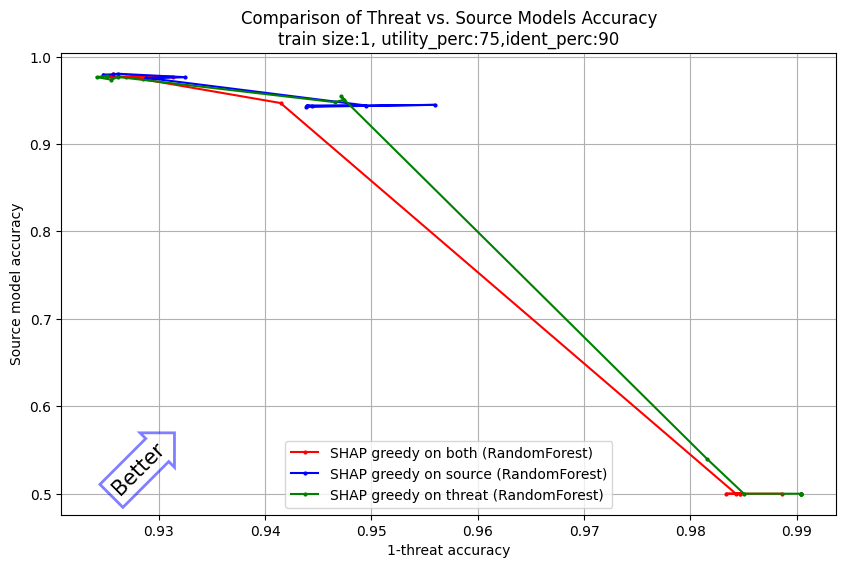

utility_perc: 90 ident_perc: 90


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

1.237458988101425e-07
Percentile of features to keep: 3; Number of features to keep: 13; Ratio Threshold: 1.237458988101425e-07


y_pred contains classes not in y_true


-0.04086720052566033
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.04086720052566033


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 9.723653963579399e-05


y_pred contains classes not in y_true


1.237458988101425e-07
Percentile of features to keep: 5; Number of features to keep: 13; Ratio Threshold: 1.237458988101425e-07


y_pred contains classes not in y_true


-0.040430395546674644
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.040430395546674644


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 0.00031115987535646915


y_pred contains classes not in y_true


1.237458988101425e-07
Percentile of features to keep: 7; Number of features to keep: 13; Ratio Threshold: 1.237458988101425e-07


y_pred contains classes not in y_true


-0.039370377856861524
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.039370377856861524


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 0.0003726766275654557
1.237458988101425e-07
Percentile of features to keep: 9; Number of features to keep: 13; Ratio Threshold: 1.237458988101425e-07


y_pred contains classes not in y_true


-0.03673468233329452
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.03673468233329452


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 0.0004283352707358252
1.237458988101425e-07
Percentile of features to keep: 10; Number of features to keep: 13; Ratio Threshold: 1.237458988101425e-07


y_pred contains classes not in y_true


-0.035776265985610727
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.035776265985610727


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 0.0005675155526603388
5.641148096500045e-07
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 5.641148096500045e-07


y_pred contains classes not in y_true


-0.02135573061779886
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.02135573061779886


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 0.0025223527532204416


y_pred contains classes not in y_true


1.0370367824938097e-05
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 1.0370367824938097e-05
-0.012061937618049356
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.012061937618049356


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 0.004255661619289774


y_pred contains classes not in y_true


5.9533977385968276e-05
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 5.9533977385968276e-05


y_pred contains classes not in y_true


-0.005784019191779126
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.005784019191779126


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 0.00602096651370014


y_pred contains classes not in y_true


7.519647230158092e-05
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 7.519647230158092e-05


y_pred contains classes not in y_true


-0.0042775804168549165
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.0042775804168549165


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 0.010381752671986159


y_pred contains classes not in y_true


8.609632407042576e-05
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 8.609632407042576e-05


y_pred contains classes not in y_true


-0.0030427312144867846
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.0030427312144867846


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 0.014335489848792368


y_pred contains classes not in y_true


0.00010233160184723627
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 0.00010233160184723627


y_pred contains classes not in y_true


-0.0018702918787782841
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.0018702918787782841


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 0.020702658475148725


y_pred contains classes not in y_true


0.00013063477703981522
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 0.00013063477703981522


y_pred contains classes not in y_true


3.213758878396574e-05
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 3.213758878396574e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 0.028375130929319523


y_pred contains classes not in y_true


0.00018179863338824213
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 0.00018179863338824213


y_pred contains classes not in y_true


3.213758878396574e-05
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 3.213758878396574e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 55; Ratio Threshold: 0.06732124736000708


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 58; Ratio Threshold: inf


y_pred contains classes not in y_true
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:31<00:00, 211.42s/it]


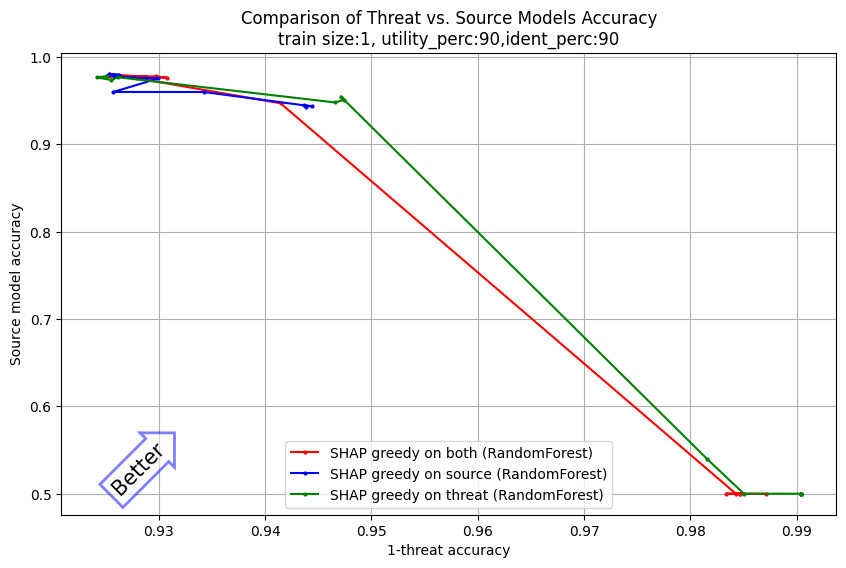

utility_perc: 95 ident_perc: 90


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

1.237458988101425e-07
Percentile of features to keep: 3; Number of features to keep: 13; Ratio Threshold: 1.237458988101425e-07


y_pred contains classes not in y_true


-0.05459593333017934
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.05459593333017934


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 7.760214147995046e-05


y_pred contains classes not in y_true


1.237458988101425e-07
Percentile of features to keep: 5; Number of features to keep: 13; Ratio Threshold: 1.237458988101425e-07


y_pred contains classes not in y_true


-0.041033604885966225
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.041033604885966225


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 0.00022588535260860746


y_pred contains classes not in y_true


1.237458988101425e-07
Percentile of features to keep: 7; Number of features to keep: 13; Ratio Threshold: 1.237458988101425e-07


y_pred contains classes not in y_true


-0.04068842921831709
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.04068842921831709


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 0.0002776612555717057
1.237458988101425e-07
Percentile of features to keep: 9; Number of features to keep: 13; Ratio Threshold: 1.237458988101425e-07


y_pred contains classes not in y_true


-0.04031626946973479
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.04031626946973479


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 0.00030572651329346235
1.237458988101425e-07
Percentile of features to keep: 10; Number of features to keep: 13; Ratio Threshold: 1.237458988101425e-07


y_pred contains classes not in y_true


-0.03901865298996735
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.03901865298996735


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 0.0003918730819705647
5.641148096500045e-07
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 5.641148096500045e-07


y_pred contains classes not in y_true


-0.027701512069382303
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.027701512069382303


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 0.002478422079146544


y_pred contains classes not in y_true


1.0370367824938097e-05
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 1.0370367824938097e-05
-0.016602156664246172
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.016602156664246172


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 0.0033869263460378366


y_pred contains classes not in y_true


5.9533977385968276e-05
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 5.9533977385968276e-05


y_pred contains classes not in y_true


-0.008753547030012424
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.008753547030012424


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 0.005448978911941043


y_pred contains classes not in y_true


7.519647230158092e-05
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 7.519647230158092e-05


y_pred contains classes not in y_true


-0.00576223911990981
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.00576223911990981


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 0.006299833832118733


y_pred contains classes not in y_true


8.609632407042576e-05
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 8.609632407042576e-05


y_pred contains classes not in y_true


-0.0039916616721647775
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.0039916616721647775


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 0.010737489907484424


y_pred contains classes not in y_true


0.00010233160184723627
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 0.00010233160184723627


y_pred contains classes not in y_true


-0.0025056274567876436
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.0025056274567876436


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 0.014571634825119978


y_pred contains classes not in y_true


0.00013063477703981522
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 0.00013063477703981522


y_pred contains classes not in y_true


4.2756508783457295e-05
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 4.2756508783457295e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 0.019872719939223668


y_pred contains classes not in y_true


0.00018179863338824213
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 0.00018179863338824213


y_pred contains classes not in y_true


4.2756508783457295e-05
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 4.2756508783457295e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 55; Ratio Threshold: 0.03887405695695438


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 58; Ratio Threshold: inf


y_pred contains classes not in y_true
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:32<00:00, 212.92s/it]


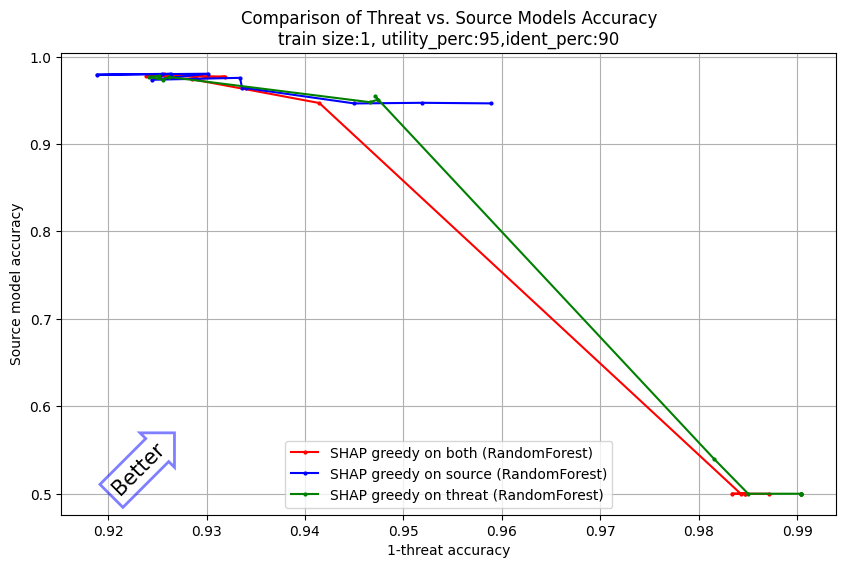

utility_perc: mean ident_perc: 90


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

1.237458988101425e-07
Percentile of features to keep: 3; Number of features to keep: 13; Ratio Threshold: 1.237458988101425e-07


y_pred contains classes not in y_true


-0.0259483046287807
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.0259483046287807


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 0.00026701793503926995


y_pred contains classes not in y_true


1.237458988101425e-07
Percentile of features to keep: 5; Number of features to keep: 13; Ratio Threshold: 1.237458988101425e-07


y_pred contains classes not in y_true


-0.021055770686732467
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.021055770686732467


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 0.0006960997252939852
1.237458988101425e-07
Percentile of features to keep: 7; Number of features to keep: 13; Ratio Threshold: 1.237458988101425e-07


y_pred contains classes not in y_true


-0.019566215999852567
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.019566215999852567


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 0.0007761838911407146
1.237458988101425e-07
Percentile of features to keep: 9; Number of features to keep: 13; Ratio Threshold: 1.237458988101425e-07


y_pred contains classes not in y_true


-0.018518796471866567
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.018518796471866567


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 0.0008474248230691936
1.237458988101425e-07
Percentile of features to keep: 10; Number of features to keep: 13; Ratio Threshold: 1.237458988101425e-07


y_pred contains classes not in y_true


-0.018298797875781588
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.018298797875781588


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 0.0010427283532551627
5.641148096500045e-07
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 5.641148096500045e-07


y_pred contains classes not in y_true


-0.011480830745940428
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.011480830745940428


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 0.0046089094349049085


y_pred contains classes not in y_true


1.0370367824938097e-05
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 1.0370367824938097e-05
-0.007032418034195749
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.007032418034195749


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 0.007470884824947333


y_pred contains classes not in y_true


5.9533977385968276e-05
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 5.9533977385968276e-05


y_pred contains classes not in y_true


-0.0032641488662918327
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.0032641488662918327


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 0.01195681635585624


y_pred contains classes not in y_true


7.519647230158092e-05
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 7.519647230158092e-05


y_pred contains classes not in y_true


-0.0026320228393253977
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.0026320228393253977


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 0.016344979097695833


y_pred contains classes not in y_true


8.609632407042576e-05
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 8.609632407042576e-05


y_pred contains classes not in y_true


-0.0018981602316618072
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.0018981602316618072


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 0.022415914207901948


y_pred contains classes not in y_true


0.00010233160184723627
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 0.00010233160184723627


y_pred contains classes not in y_true


-0.001045037868649539
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.001045037868649539


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 0.031213338328991726


y_pred contains classes not in y_true


0.00013063477703981522
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 0.00013063477703981522


y_pred contains classes not in y_true


4.010057997261147e-05
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 4.010057997261147e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 0.03877433131187983


y_pred contains classes not in y_true


0.00018179863338824213
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 0.00018179863338824213


y_pred contains classes not in y_true


4.010057997261147e-05
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 4.010057997261147e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 55; Ratio Threshold: 0.10498221701224149


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 58; Ratio Threshold: inf


y_pred contains classes not in y_true
100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:35<00:00, 95.02s/it]


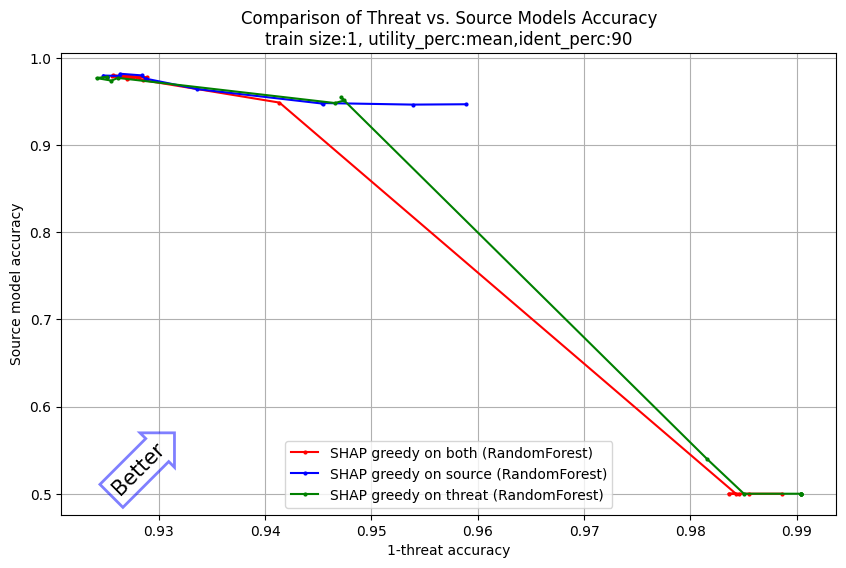

utility_perc: max ident_perc: 90


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

1.237458988101425e-07
Percentile of features to keep: 3; Number of features to keep: 13; Ratio Threshold: 1.237458988101425e-07


y_pred contains classes not in y_true


-0.1016866075608704
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.1016866075608704


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 2.3426008474717926e-05


y_pred contains classes not in y_true


1.237458988101425e-07
Percentile of features to keep: 5; Number of features to keep: 13; Ratio Threshold: 1.237458988101425e-07


y_pred contains classes not in y_true


-0.09271234153429635
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.09271234153429635


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 5.0257810379760506e-05
1.237458988101425e-07
Percentile of features to keep: 7; Number of features to keep: 13; Ratio Threshold: 1.237458988101425e-07


y_pred contains classes not in y_true


-0.08986603190891636
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.08986603190891636


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 7.254534456757054e-05
1.237458988101425e-07
Percentile of features to keep: 9; Number of features to keep: 13; Ratio Threshold: 1.237458988101425e-07


y_pred contains classes not in y_true


-0.0871483882831555
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.0871483882831555


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 9.108885831475874e-05
1.237458988101425e-07
Percentile of features to keep: 10; Number of features to keep: 13; Ratio Threshold: 1.237458988101425e-07


y_pred contains classes not in y_true


-0.0846134257187882
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.0846134257187882


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 0.00010174371101617164


y_pred contains classes not in y_true


5.641148096500045e-07
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 5.641148096500045e-07


y_pred contains classes not in y_true


-0.060634260505662216
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.060634260505662216


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 0.000743943023042577


y_pred contains classes not in y_true


1.0370367824938097e-05
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 1.0370367824938097e-05
-0.05257643291437132
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.05257643291437132


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 0.0014541202219252136


y_pred contains classes not in y_true


5.9533977385968276e-05
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 5.9533977385968276e-05


y_pred contains classes not in y_true


-0.040647567732224485
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.040647567732224485


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 0.0017202281160834645


y_pred contains classes not in y_true


7.519647230158092e-05
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 7.519647230158092e-05


y_pred contains classes not in y_true


-0.032259991762437816
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.032259991762437816


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 0.002070593447461872


y_pred contains classes not in y_true


8.609632407042576e-05
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 8.609632407042576e-05


y_pred contains classes not in y_true


-0.023236954334763874
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.023236954334763874


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 0.0025505500479144


y_pred contains classes not in y_true


0.00010233160184723627
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 0.00010233160184723627


y_pred contains classes not in y_true


-0.011443154446650549
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.011443154446650549


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 0.0028821039917364603


y_pred contains classes not in y_true


0.00013063477703981522
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 0.00013063477703981522


y_pred contains classes not in y_true


0.006214009359019575
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 0.006214009359019575


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 0.0048399310358605546


y_pred contains classes not in y_true


0.00018179863338824213
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 0.00018179863338824213


y_pred contains classes not in y_true


0.006214009359019575
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 0.006214009359019575


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 55; Ratio Threshold: 0.0074411081107101755


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 58; Ratio Threshold: inf


y_pred contains classes not in y_true
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:21<00:00, 201.86s/it]


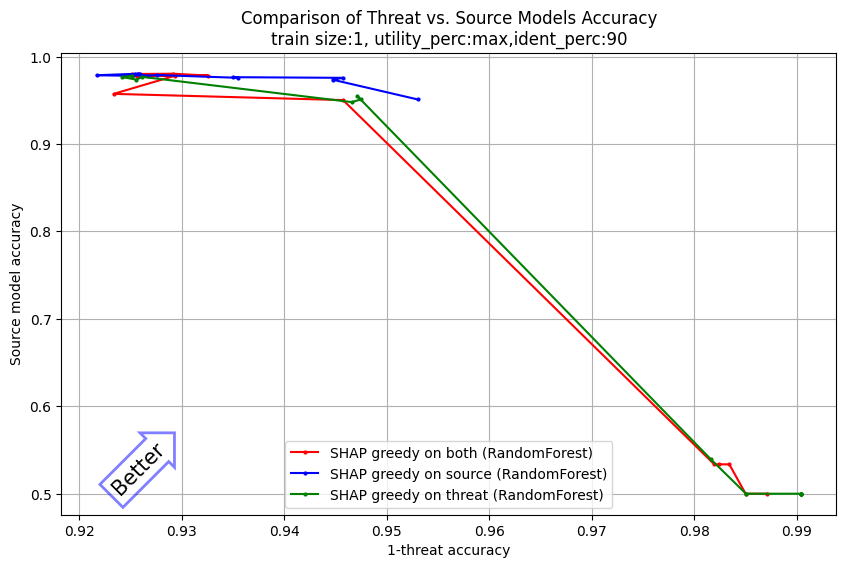

utility_perc: 50 ident_perc: 95


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

3.294000498479347e-08
Percentile of features to keep: 3; Number of features to keep: 12; Ratio Threshold: 3.294000498479347e-08
-0.017186058932801878
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.017186058932801878


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 0.0031738879149950504


y_pred contains classes not in y_true


3.294000498479347e-08
Percentile of features to keep: 5; Number of features to keep: 12; Ratio Threshold: 3.294000498479347e-08
-0.014324794859580516
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.014324794859580516


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 0.003971755525081098
3.294000498479347e-08
Percentile of features to keep: 7; Number of features to keep: 12; Ratio Threshold: 3.294000498479347e-08
-0.013924149665299406
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.013924149665299406


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 0.00416830037792582
3.294000498479347e-08
Percentile of features to keep: 9; Number of features to keep: 12; Ratio Threshold: 3.294000498479347e-08
-0.012922438937072558
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.012922438937072558


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 0.004895165597995868
3.294000498479347e-08
Percentile of features to keep: 10; Number of features to keep: 12; Ratio Threshold: 3.294000498479347e-08
-0.01230915873344437
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.01230915873344437


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 0.005404927323162974


y_pred contains classes not in y_true


1.530669248040264e-06
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 1.530669248040264e-06


y_pred contains classes not in y_true


-0.010060251140668669
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.010060251140668669


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 0.01394887669117643


y_pred contains classes not in y_true


2.076856173525295e-05
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 2.076856173525295e-05
-0.00558057558115986
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.00558057558115986


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 0.018999427787061696


y_pred contains classes not in y_true


0.00011104329608284618
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 0.00011104329608284618


y_pred contains classes not in y_true


-0.0022942646701500646
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.0022942646701500646


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 0.023715098110307427


y_pred contains classes not in y_true


0.00013472272222690934
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 0.00013472272222690934


y_pred contains classes not in y_true


-0.0016862628171452156
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.0016862628171452156


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 0.040012304795700004


y_pred contains classes not in y_true


0.00015556992067747278
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 0.00015556992067747278


y_pred contains classes not in y_true


-0.0013306225225515917
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.0013306225225515917


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 0.05107810912177906


y_pred contains classes not in y_true


0.00020047109410854694
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 0.00020047109410854694


y_pred contains classes not in y_true


-0.0006269908425126871
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.0006269908425126871


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 0.07783790928421155


y_pred contains classes not in y_true


0.00022509831526498615
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 0.00022509831526498615


y_pred contains classes not in y_true


1.2532187113267354e-05
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 1.2532187113267354e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 0.10973097563695548


y_pred contains classes not in y_true


0.00025604825749799063
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 0.00025604825749799063


y_pred contains classes not in y_true


1.2532187113267354e-05
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 1.2532187113267354e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 55; Ratio Threshold: 0.40216637241366743


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 58; Ratio Threshold: inf


y_pred contains classes not in y_true
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:35<00:00, 215.98s/it]


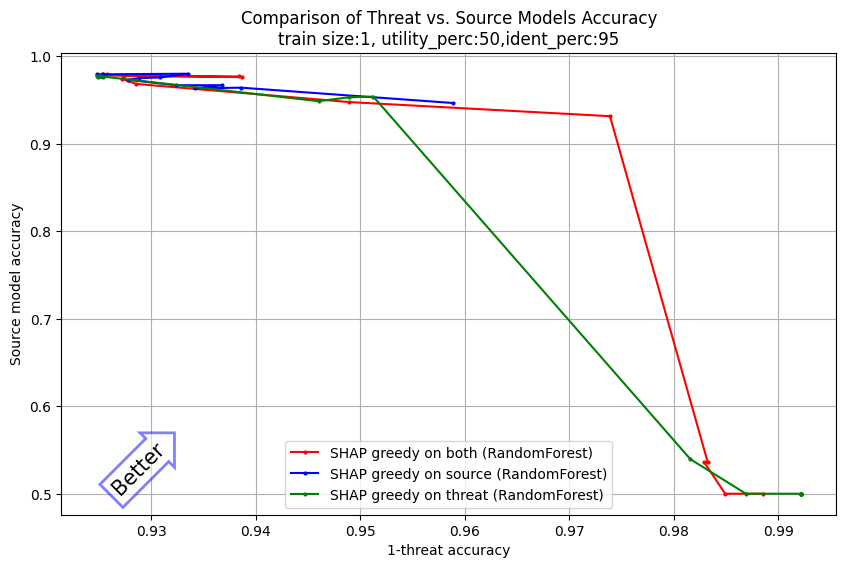

utility_perc: 75 ident_perc: 95


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

3.294000498479347e-08
Percentile of features to keep: 3; Number of features to keep: 12; Ratio Threshold: 3.294000498479347e-08
-0.03945059346270276
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.03945059346270276


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 0.0014661157349855369


y_pred contains classes not in y_true


3.294000498479347e-08
Percentile of features to keep: 5; Number of features to keep: 12; Ratio Threshold: 3.294000498479347e-08
-0.039024620880503076
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.039024620880503076


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 0.0019279784494550397


y_pred contains classes not in y_true


3.294000498479347e-08
Percentile of features to keep: 7; Number of features to keep: 12; Ratio Threshold: 3.294000498479347e-08
-0.03719208079191146
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.03719208079191146


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 0.002240272214155973
3.294000498479347e-08
Percentile of features to keep: 9; Number of features to keep: 12; Ratio Threshold: 3.294000498479347e-08
-0.032724735489875596
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.032724735489875596


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 0.002966206572996385
3.294000498479347e-08
Percentile of features to keep: 10; Number of features to keep: 12; Ratio Threshold: 3.294000498479347e-08
-0.030528141252439064
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.030528141252439064


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 0.003598007225215398


y_pred contains classes not in y_true


1.530669248040264e-06
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 1.530669248040264e-06


y_pred contains classes not in y_true


-0.014033325289469148
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.014033325289469148


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 0.00556402704376174


y_pred contains classes not in y_true


2.076856173525295e-05
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 2.076856173525295e-05
-0.008161181080517534
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.008161181080517534


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 0.008559258316358776


y_pred contains classes not in y_true


0.00011104329608284618
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 0.00011104329608284618


y_pred contains classes not in y_true


-0.003798830152061578
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.003798830152061578


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 0.016668922265587728


y_pred contains classes not in y_true


0.00013472272222690934
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 0.00013472272222690934


y_pred contains classes not in y_true


-0.002994875399528907
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.002994875399528907


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 0.0240843822109289


y_pred contains classes not in y_true


0.00015556992067747278
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 0.00015556992067747278


y_pred contains classes not in y_true


-0.0024765229168436154
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.0024765229168436154


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 0.0383913931384862


y_pred contains classes not in y_true


0.00020047109410854694
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 0.00020047109410854694


y_pred contains classes not in y_true


-0.0011128758624084829
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.0011128758624084829


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 0.04926195896946572


y_pred contains classes not in y_true


0.00022509831526498615
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 0.00022509831526498615


y_pred contains classes not in y_true


3.213758878396574e-05
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 3.213758878396574e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 0.06633669835809568


y_pred contains classes not in y_true


0.00025604825749799063
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 0.00025604825749799063


y_pred contains classes not in y_true


3.213758878396574e-05
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 3.213758878396574e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 55; Ratio Threshold: 0.1579573609584077


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 58; Ratio Threshold: inf


y_pred contains classes not in y_true
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:28<00:00, 208.38s/it]


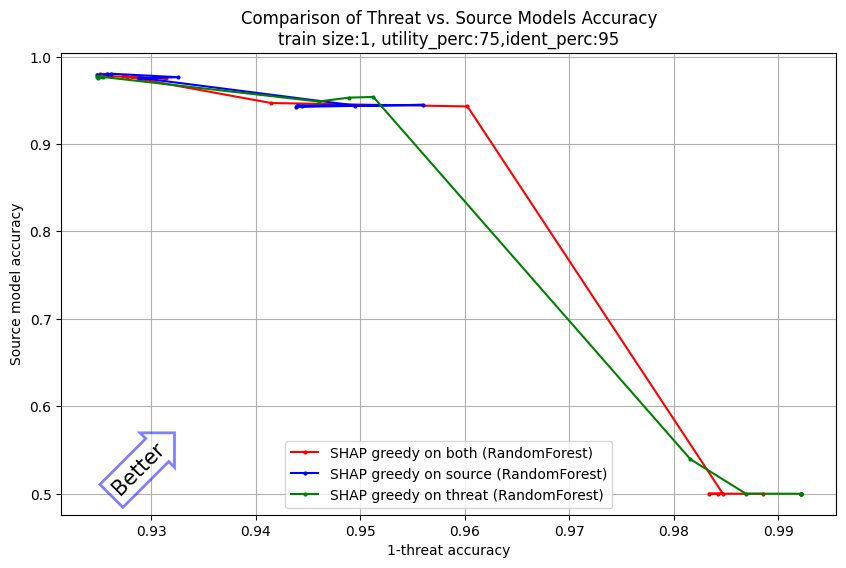

utility_perc: 90 ident_perc: 95


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

3.294000498479347e-08
Percentile of features to keep: 3; Number of features to keep: 12; Ratio Threshold: 3.294000498479347e-08
-0.04086720052566033
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.04086720052566033


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 0.0005843706672003625


y_pred contains classes not in y_true


3.294000498479347e-08
Percentile of features to keep: 5; Number of features to keep: 12; Ratio Threshold: 3.294000498479347e-08
-0.040430395546674644
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.040430395546674644


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 0.0010618722722640043
3.294000498479347e-08
Percentile of features to keep: 7; Number of features to keep: 12; Ratio Threshold: 3.294000498479347e-08
-0.039370377856861524
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.039370377856861524


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 0.0011424722817904333
3.294000498479347e-08
Percentile of features to keep: 9; Number of features to keep: 12; Ratio Threshold: 3.294000498479347e-08
-0.03673468233329452
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.03673468233329452


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 0.0013826595504560601
3.294000498479347e-08
Percentile of features to keep: 10; Number of features to keep: 12; Ratio Threshold: 3.294000498479347e-08
-0.035776265985610727
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.035776265985610727


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 0.0017226374377065366
1.530669248040264e-06
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 1.530669248040264e-06


y_pred contains classes not in y_true


-0.02135573061779886
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.02135573061779886


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 0.0053526951274963566


y_pred contains classes not in y_true


2.076856173525295e-05
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 2.076856173525295e-05
-0.012061937618049356
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.012061937618049356


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 0.007107142621013187


y_pred contains classes not in y_true


0.00011104329608284618
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 0.00011104329608284618


y_pred contains classes not in y_true


-0.005784019191779126
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.005784019191779126


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 0.011836233056062035


y_pred contains classes not in y_true


0.00013472272222690934
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 0.00013472272222690934


y_pred contains classes not in y_true


-0.0042775804168549165
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.0042775804168549165


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 0.017534881678244976


y_pred contains classes not in y_true


0.00015556992067747278
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 0.00015556992067747278


y_pred contains classes not in y_true


-0.0030427312144867846
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.0030427312144867846


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 0.022514929495415312


y_pred contains classes not in y_true


0.00020047109410854694
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 0.00020047109410854694


y_pred contains classes not in y_true


-0.0018702918787782841
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.0018702918787782841


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 0.03734085882202164


y_pred contains classes not in y_true


0.00022509831526498615
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 0.00022509831526498615


y_pred contains classes not in y_true


3.213758878396574e-05
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 3.213758878396574e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 0.05229476333813396


y_pred contains classes not in y_true


0.00025604825749799063
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 0.00025604825749799063


y_pred contains classes not in y_true


3.213758878396574e-05
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 3.213758878396574e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 55; Ratio Threshold: 0.08618955673389217


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 58; Ratio Threshold: inf


y_pred contains classes not in y_true
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:29<00:00, 209.63s/it]


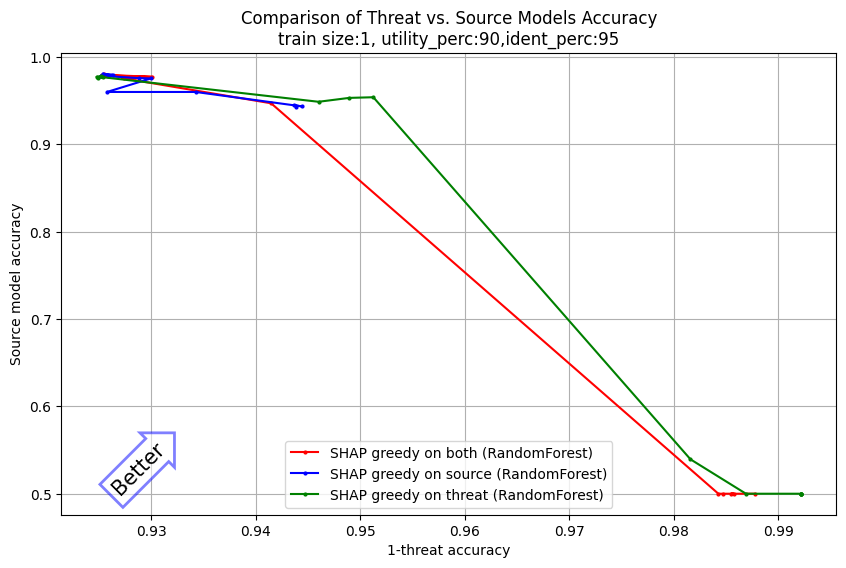

utility_perc: 95 ident_perc: 95


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

3.294000498479347e-08
Percentile of features to keep: 3; Number of features to keep: 12; Ratio Threshold: 3.294000498479347e-08
-0.05459593333017934
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.05459593333017934


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 0.00023413608451727203


y_pred contains classes not in y_true


3.294000498479347e-08
Percentile of features to keep: 5; Number of features to keep: 12; Ratio Threshold: 3.294000498479347e-08
-0.041033604885966225
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.041033604885966225


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 0.0007777234552127269
3.294000498479347e-08
Percentile of features to keep: 7; Number of features to keep: 12; Ratio Threshold: 3.294000498479347e-08
-0.04068842921831709
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.04068842921831709


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 0.0008475706486626971
3.294000498479347e-08
Percentile of features to keep: 9; Number of features to keep: 12; Ratio Threshold: 3.294000498479347e-08
-0.04031626946973479
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.04031626946973479


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 0.0009768785925165597
3.294000498479347e-08
Percentile of features to keep: 10; Number of features to keep: 12; Ratio Threshold: 3.294000498479347e-08
-0.03901865298996735
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.03901865298996735


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 0.001197979698678401
1.530669248040264e-06
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 1.530669248040264e-06


y_pred contains classes not in y_true


-0.027701512069382303
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.027701512069382303


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 0.0051597235287911165


y_pred contains classes not in y_true


2.076856173525295e-05
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 2.076856173525295e-05
-0.016602156664246172
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.016602156664246172


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 0.006533192281356477


y_pred contains classes not in y_true


0.00011104329608284618
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 0.00011104329608284618


y_pred contains classes not in y_true


-0.008753547030012424
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.008753547030012424


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 0.009261278974730792


y_pred contains classes not in y_true


0.00013472272222690934
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 0.00013472272222690934


y_pred contains classes not in y_true


-0.00576223911990981
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.00576223911990981


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 0.01178618538028428


y_pred contains classes not in y_true


0.00015556992067747278
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 0.00015556992067747278


y_pred contains classes not in y_true


-0.0039916616721647775
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.0039916616721647775


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 0.017947227080125288


y_pred contains classes not in y_true


0.00020047109410854694
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 0.00020047109410854694


y_pred contains classes not in y_true


-0.0025056274567876436
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.0025056274567876436


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 0.030208256033265414


y_pred contains classes not in y_true


0.00022509831526498615
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 0.00022509831526498615


y_pred contains classes not in y_true


4.2756508783457295e-05
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 4.2756508783457295e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 0.03814486923035725


y_pred contains classes not in y_true


0.00025604825749799063
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 0.00025604825749799063


y_pred contains classes not in y_true


4.2756508783457295e-05
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 4.2756508783457295e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 55; Ratio Threshold: 0.07198294142207277


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 58; Ratio Threshold: inf


y_pred contains classes not in y_true
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:30<00:00, 210.70s/it]


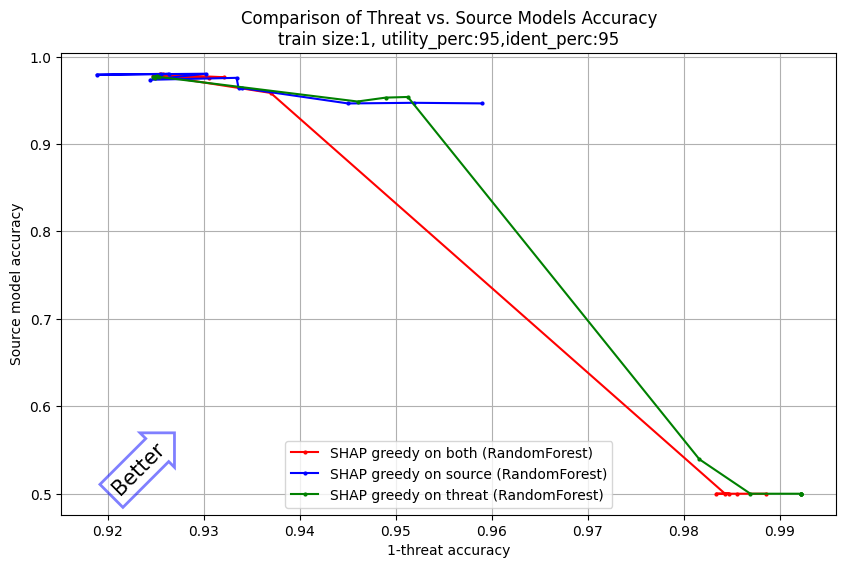

utility_perc: mean ident_perc: 95


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

3.294000498479347e-08
Percentile of features to keep: 3; Number of features to keep: 12; Ratio Threshold: 3.294000498479347e-08
-0.0259483046287807
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.0259483046287807


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 0.0012400299061280863


y_pred contains classes not in y_true


3.294000498479347e-08
Percentile of features to keep: 5; Number of features to keep: 12; Ratio Threshold: 3.294000498479347e-08
-0.021055770686732467
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.021055770686732467


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 0.0020295567074935087
3.294000498479347e-08
Percentile of features to keep: 7; Number of features to keep: 12; Ratio Threshold: 3.294000498479347e-08
-0.019566215999852567
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.019566215999852567


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 0.002608376440736077
3.294000498479347e-08
Percentile of features to keep: 9; Number of features to keep: 12; Ratio Threshold: 3.294000498479347e-08
-0.018518796471866567
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.018518796471866567


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 0.0028313469300443603
3.294000498479347e-08
Percentile of features to keep: 10; Number of features to keep: 12; Ratio Threshold: 3.294000498479347e-08
-0.018298797875781588
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.018298797875781588


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 0.0031401132197438402
1.530669248040264e-06
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 1.530669248040264e-06


y_pred contains classes not in y_true


-0.011480830745940428
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.011480830745940428


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 0.009202180538237762


y_pred contains classes not in y_true


2.076856173525295e-05
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 2.076856173525295e-05
-0.007032418034195749
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.007032418034195749


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 0.014249457903097597


y_pred contains classes not in y_true


0.00011104329608284618
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 0.00011104329608284618


y_pred contains classes not in y_true


-0.0032641488662918327
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.0032641488662918327


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 0.019953588575524952


y_pred contains classes not in y_true


0.00013472272222690934
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 0.00013472272222690934


y_pred contains classes not in y_true


-0.0026320228393253977
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.0026320228393253977


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 0.02904456765015813


y_pred contains classes not in y_true


0.00015556992067747278
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 0.00015556992067747278


y_pred contains classes not in y_true


-0.0018981602316618072
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.0018981602316618072


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 0.03849388039164199


y_pred contains classes not in y_true


0.00020047109410854694
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 0.00020047109410854694


y_pred contains classes not in y_true


-0.001045037868649539
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.001045037868649539


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 0.059194373495940415


y_pred contains classes not in y_true


0.00022509831526498615
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 0.00022509831526498615


y_pred contains classes not in y_true


4.010057997261147e-05
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 4.010057997261147e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 0.07578833401223639


y_pred contains classes not in y_true


0.00025604825749799063
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 0.00025604825749799063


y_pred contains classes not in y_true


4.010057997261147e-05
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 4.010057997261147e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 55; Ratio Threshold: 0.18793575441161064


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 58; Ratio Threshold: inf


y_pred contains classes not in y_true
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:28<00:00, 208.91s/it]


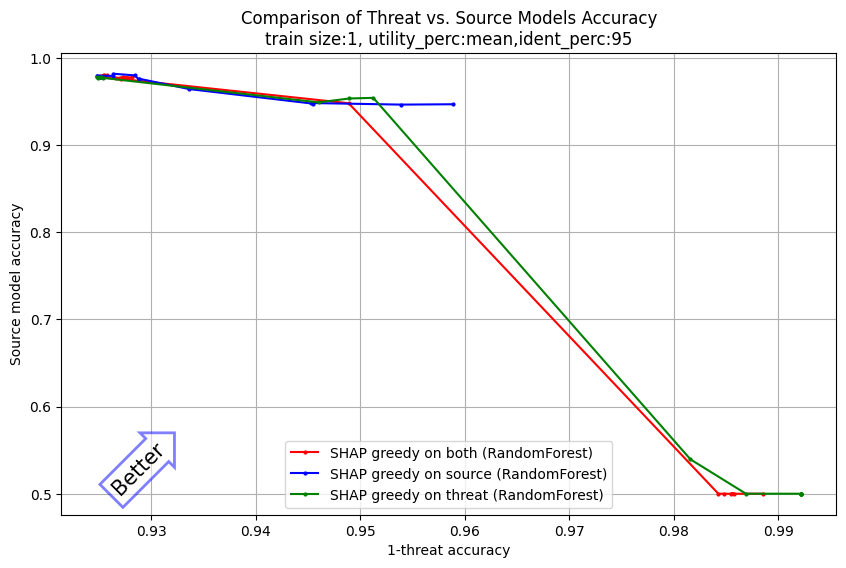

utility_perc: max ident_perc: 95


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

3.294000498479347e-08
Percentile of features to keep: 3; Number of features to keep: 12; Ratio Threshold: 3.294000498479347e-08
-0.1016866075608704
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.1016866075608704


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 5.848467842119276e-05


y_pred contains classes not in y_true


3.294000498479347e-08
Percentile of features to keep: 5; Number of features to keep: 12; Ratio Threshold: 3.294000498479347e-08
-0.09271234153429635
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.09271234153429635


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 0.00013695518752083457
3.294000498479347e-08
Percentile of features to keep: 7; Number of features to keep: 12; Ratio Threshold: 3.294000498479347e-08
-0.08986603190891636
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.08986603190891636


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 0.00018366148240774765
3.294000498479347e-08
Percentile of features to keep: 9; Number of features to keep: 12; Ratio Threshold: 3.294000498479347e-08
-0.0871483882831555
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.0871483882831555


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 0.00023048755664897082
3.294000498479347e-08
Percentile of features to keep: 10; Number of features to keep: 12; Ratio Threshold: 3.294000498479347e-08
-0.0846134257187882
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.0846134257187882


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 0.00024990648457705707
1.530669248040264e-06
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 1.530669248040264e-06


y_pred contains classes not in y_true


-0.060634260505662216
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.060634260505662216


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 0.0015889284786993407


y_pred contains classes not in y_true


2.076856173525295e-05
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 2.076856173525295e-05
-0.05257643291437132
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.05257643291437132


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 0.0025826810767780686


y_pred contains classes not in y_true


0.00011104329608284618
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 0.00011104329608284618


y_pred contains classes not in y_true


-0.040647567732224485
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.040647567732224485


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 0.003044705497944856


y_pred contains classes not in y_true


0.00013472272222690934
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 0.00013472272222690934


y_pred contains classes not in y_true


-0.032259991762437816
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.032259991762437816


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 0.003751995252822213


y_pred contains classes not in y_true


0.00015556992067747278
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 0.00015556992067747278


y_pred contains classes not in y_true


-0.023236954334763874
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.023236954334763874


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 0.004475170207176324


y_pred contains classes not in y_true


0.00020047109410854694
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 0.00020047109410854694


y_pred contains classes not in y_true


-0.011443154446650549
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.011443154446650549


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 0.005370925759858518


y_pred contains classes not in y_true


0.00022509831526498615
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 0.00022509831526498615


y_pred contains classes not in y_true


0.006214009359019575
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 0.006214009359019575


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 0.007058125660138253


y_pred contains classes not in y_true


0.00025604825749799063
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 0.00025604825749799063


y_pred contains classes not in y_true


0.006214009359019575
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 0.006214009359019575


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 55; Ratio Threshold: 0.014755023905328428


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 58; Ratio Threshold: inf


y_pred contains classes not in y_true
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:19<00:00, 199.52s/it]


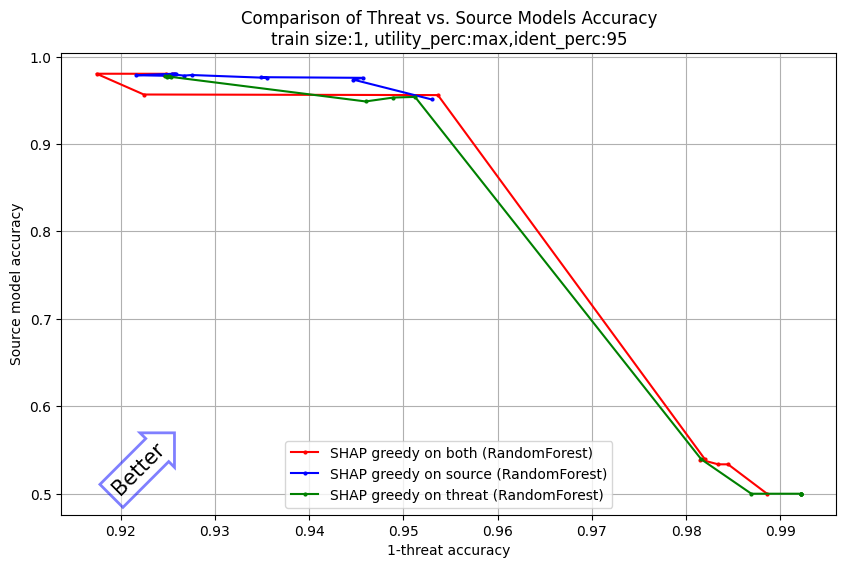

utility_perc: 50 ident_perc: mean


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

5.52971636834093e-07
Percentile of features to keep: 3; Number of features to keep: 12; Ratio Threshold: 5.52971636834093e-07
-0.017186058932801878
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.017186058932801878


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 0.0014504905996536683


y_pred contains classes not in y_true


5.52971636834093e-07
Percentile of features to keep: 5; Number of features to keep: 12; Ratio Threshold: 5.52971636834093e-07
-0.014324794859580516
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.014324794859580516


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 0.002027522892694617
5.52971636834093e-07
Percentile of features to keep: 7; Number of features to keep: 12; Ratio Threshold: 5.52971636834093e-07
-0.013924149665299406
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.013924149665299406


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 0.002597923106189082


y_pred contains classes not in y_true


5.52971636834093e-07
Percentile of features to keep: 9; Number of features to keep: 12; Ratio Threshold: 5.52971636834093e-07
-0.012922438937072558
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.012922438937072558


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 0.0027554211834265358


y_pred contains classes not in y_true


5.52971636834093e-07
Percentile of features to keep: 10; Number of features to keep: 12; Ratio Threshold: 5.52971636834093e-07
-0.01230915873344437
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.01230915873344437


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 0.0028515365517307574


y_pred contains classes not in y_true


1.0738523448795462e-06
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 1.0738523448795462e-06


y_pred contains classes not in y_true


-0.010060251140668669
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.010060251140668669


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 0.005662079505393201


y_pred contains classes not in y_true


7.4473481823623585e-06
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 7.4473481823623585e-06
-0.00558057558115986
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.00558057558115986


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 0.008962928786310902


y_pred contains classes not in y_true


4.370925465699916e-05
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 4.370925465699916e-05


y_pred contains classes not in y_true


-0.0022942646701500646
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.0022942646701500646


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 0.01021833731268387


y_pred contains classes not in y_true


5.2563956116483164e-05
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 5.2563956116483164e-05


y_pred contains classes not in y_true


-0.0016862628171452156
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.0016862628171452156


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 0.016704758332456254


y_pred contains classes not in y_true


6.269861312275739e-05
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 6.269861312275739e-05


y_pred contains classes not in y_true


-0.0013306225225515917
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.0013306225225515917


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 0.023578622827389525


y_pred contains classes not in y_true


7.172080048587431e-05
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 7.172080048587431e-05


y_pred contains classes not in y_true


-0.0006269908425126871
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.0006269908425126871


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 0.029259749063099937


y_pred contains classes not in y_true


9.649269708208486e-05
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 9.649269708208486e-05


y_pred contains classes not in y_true


1.2532187113267354e-05
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 1.2532187113267354e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 0.04396526942599619


y_pred contains classes not in y_true


0.00011466803282836221
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 0.00011466803282836221


y_pred contains classes not in y_true


1.2532187113267354e-05
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 1.2532187113267354e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 55; Ratio Threshold: 0.16070950012430085


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 58; Ratio Threshold: inf


y_pred contains classes not in y_true
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:37<00:00, 217.47s/it]


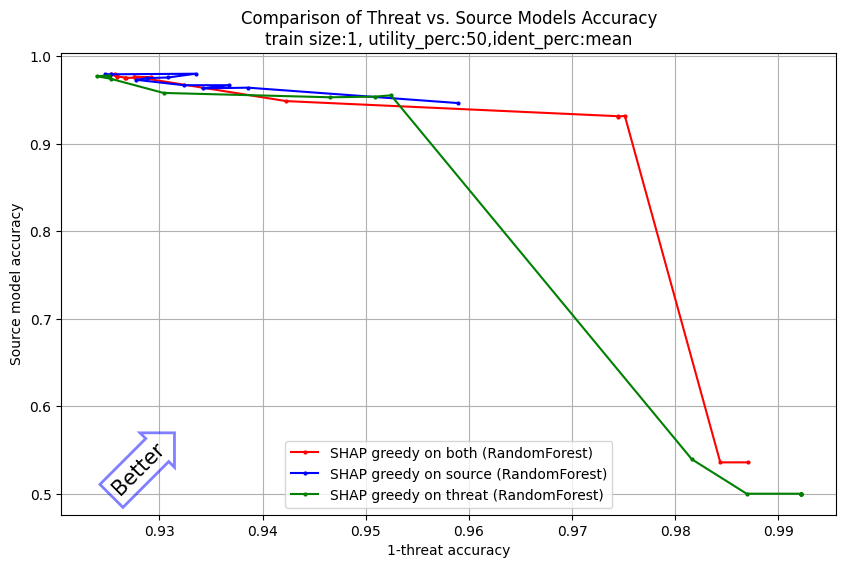

utility_perc: 75 ident_perc: mean


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

5.52971636834093e-07
Percentile of features to keep: 3; Number of features to keep: 12; Ratio Threshold: 5.52971636834093e-07
-0.03945059346270276
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.03945059346270276


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 0.0007432016277338589


y_pred contains classes not in y_true


5.52971636834093e-07
Percentile of features to keep: 5; Number of features to keep: 12; Ratio Threshold: 5.52971636834093e-07
-0.039024620880503076
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.039024620880503076


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 0.0009601262769674701
5.52971636834093e-07
Percentile of features to keep: 7; Number of features to keep: 12; Ratio Threshold: 5.52971636834093e-07
-0.03719208079191146
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.03719208079191146


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 0.0011271811518598841
5.52971636834093e-07
Percentile of features to keep: 9; Number of features to keep: 12; Ratio Threshold: 5.52971636834093e-07
-0.032724735489875596
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.032724735489875596


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 0.0015633319686979349


y_pred contains classes not in y_true


5.52971636834093e-07
Percentile of features to keep: 10; Number of features to keep: 12; Ratio Threshold: 5.52971636834093e-07
-0.030528141252439064
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.030528141252439064


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 0.0017015779824489502


y_pred contains classes not in y_true


1.0738523448795462e-06
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 1.0738523448795462e-06


y_pred contains classes not in y_true


-0.014033325289469148
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.014033325289469148


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 0.0025111863737486235


y_pred contains classes not in y_true


7.4473481823623585e-06
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 7.4473481823623585e-06
-0.008161181080517534
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.008161181080517534


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 0.0034925167758312198


y_pred contains classes not in y_true


4.370925465699916e-05
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 4.370925465699916e-05


y_pred contains classes not in y_true


-0.003798830152061578
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.003798830152061578


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 0.00790325036757802


y_pred contains classes not in y_true


5.2563956116483164e-05
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 5.2563956116483164e-05


y_pred contains classes not in y_true


-0.002994875399528907
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.002994875399528907


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 0.012305446504110756


y_pred contains classes not in y_true


6.269861312275739e-05
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 6.269861312275739e-05


y_pred contains classes not in y_true


-0.0024765229168436154
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.0024765229168436154


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 0.014413443848052751


y_pred contains classes not in y_true


7.172080048587431e-05
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 7.172080048587431e-05


y_pred contains classes not in y_true


-0.0011128758624084829
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.0011128758624084829


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 0.01848543778489581


y_pred contains classes not in y_true


9.649269708208486e-05
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 9.649269708208486e-05


y_pred contains classes not in y_true


3.213758878396574e-05
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 3.213758878396574e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 0.026678683122690273


y_pred contains classes not in y_true


0.00011466803282836221
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 0.00011466803282836221


y_pred contains classes not in y_true


3.213758878396574e-05
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 3.213758878396574e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 55; Ratio Threshold: 0.05253248749954296


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 58; Ratio Threshold: inf


y_pred contains classes not in y_true
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:27<00:00, 207.97s/it]


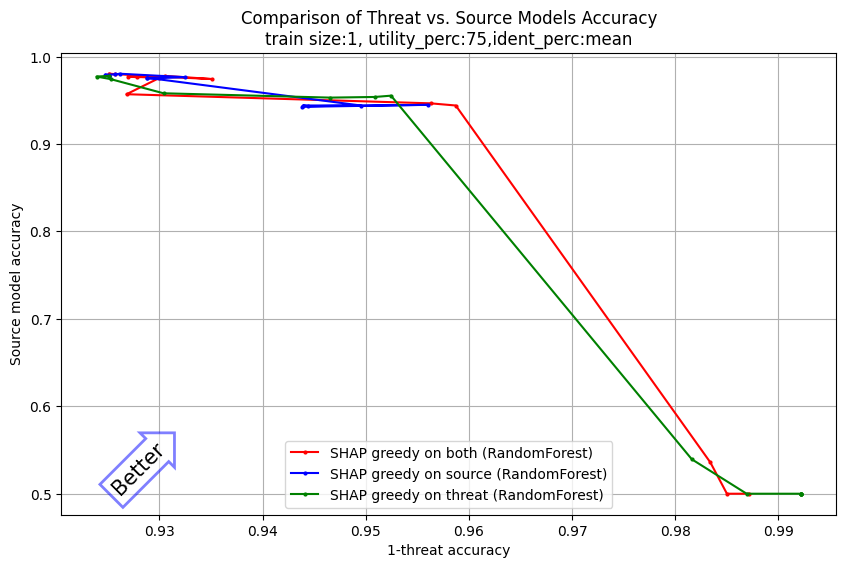

utility_perc: 90 ident_perc: mean


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

5.52971636834093e-07
Percentile of features to keep: 3; Number of features to keep: 12; Ratio Threshold: 5.52971636834093e-07
-0.04086720052566033
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.04086720052566033


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 0.00028551449978271777


y_pred contains classes not in y_true


5.52971636834093e-07
Percentile of features to keep: 5; Number of features to keep: 12; Ratio Threshold: 5.52971636834093e-07
-0.040430395546674644
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.040430395546674644


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 0.0003966281516478467
5.52971636834093e-07
Percentile of features to keep: 7; Number of features to keep: 12; Ratio Threshold: 5.52971636834093e-07
-0.039370377856861524
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.039370377856861524


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 0.0007146870296289769
5.52971636834093e-07
Percentile of features to keep: 9; Number of features to keep: 12; Ratio Threshold: 5.52971636834093e-07
-0.03673468233329452
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.03673468233329452


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 0.0010326821448936388
5.52971636834093e-07
Percentile of features to keep: 10; Number of features to keep: 12; Ratio Threshold: 5.52971636834093e-07
-0.035776265985610727
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.035776265985610727


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 0.0011653878596849213
1.0738523448795462e-06
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 1.0738523448795462e-06


y_pred contains classes not in y_true


-0.02135573061779886
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.02135573061779886


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 0.0022636892187754055


y_pred contains classes not in y_true


7.4473481823623585e-06
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 7.4473481823623585e-06
-0.012061937618049356
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.012061937618049356


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 0.0031920794256450388


y_pred contains classes not in y_true


4.370925465699916e-05
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 4.370925465699916e-05


y_pred contains classes not in y_true


-0.005784019191779126
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.005784019191779126


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 0.005511169676596845


y_pred contains classes not in y_true


5.2563956116483164e-05
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 5.2563956116483164e-05


y_pred contains classes not in y_true


-0.0042775804168549165
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.0042775804168549165


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 0.007410509748852484


y_pred contains classes not in y_true


6.269861312275739e-05
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 6.269861312275739e-05


y_pred contains classes not in y_true


-0.0030427312144867846
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.0030427312144867846


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 0.009809511458128905


y_pred contains classes not in y_true


7.172080048587431e-05
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 7.172080048587431e-05


y_pred contains classes not in y_true


-0.0018702918787782841
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.0018702918787782841


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 0.014571837587429961


y_pred contains classes not in y_true


9.649269708208486e-05
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 9.649269708208486e-05


y_pred contains classes not in y_true


3.213758878396574e-05
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 3.213758878396574e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 0.022247647419696502


y_pred contains classes not in y_true


0.00011466803282836221
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 0.00011466803282836221


y_pred contains classes not in y_true


3.213758878396574e-05
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 3.213758878396574e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 55; Ratio Threshold: 0.02955939300427109


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 58; Ratio Threshold: inf


y_pred contains classes not in y_true
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:27<00:00, 207.96s/it]


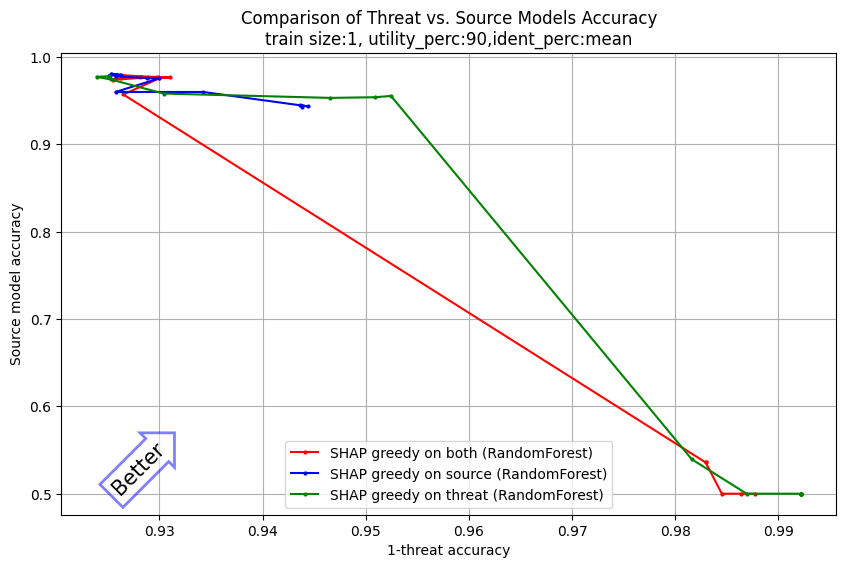

utility_perc: 95 ident_perc: mean


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

5.52971636834093e-07
Percentile of features to keep: 3; Number of features to keep: 12; Ratio Threshold: 5.52971636834093e-07
-0.05459593333017934
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.05459593333017934


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 0.00020857869716214332


y_pred contains classes not in y_true


5.52971636834093e-07
Percentile of features to keep: 5; Number of features to keep: 12; Ratio Threshold: 5.52971636834093e-07
-0.041033604885966225
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.041033604885966225


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 0.00030672254367765145
5.52971636834093e-07
Percentile of features to keep: 7; Number of features to keep: 12; Ratio Threshold: 5.52971636834093e-07
-0.04068842921831709
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.04068842921831709


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 0.0005212632788137347
5.52971636834093e-07
Percentile of features to keep: 9; Number of features to keep: 12; Ratio Threshold: 5.52971636834093e-07
-0.04031626946973479
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.04031626946973479


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 0.0007103015680802568
5.52971636834093e-07
Percentile of features to keep: 10; Number of features to keep: 12; Ratio Threshold: 5.52971636834093e-07
-0.03901865298996735
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.03901865298996735


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 0.0008034940496723506
1.0738523448795462e-06
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 1.0738523448795462e-06


y_pred contains classes not in y_true


-0.027701512069382303
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.027701512069382303


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 0.0018344162029266134


y_pred contains classes not in y_true


7.4473481823623585e-06
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 7.4473481823623585e-06
-0.016602156664246172
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.016602156664246172


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 0.003024619953112556


y_pred contains classes not in y_true


4.370925465699916e-05
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 4.370925465699916e-05


y_pred contains classes not in y_true


-0.008753547030012424
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.008753547030012424


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 0.004063993126889224


y_pred contains classes not in y_true


5.2563956116483164e-05
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 5.2563956116483164e-05


y_pred contains classes not in y_true


-0.00576223911990981
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.00576223911990981


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 0.004584780980515213


y_pred contains classes not in y_true


6.269861312275739e-05
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 6.269861312275739e-05


y_pred contains classes not in y_true


-0.0039916616721647775
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.0039916616721647775


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 0.00731147711604153


y_pred contains classes not in y_true


7.172080048587431e-05
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 7.172080048587431e-05


y_pred contains classes not in y_true


-0.0025056274567876436
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.0025056274567876436


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 0.010384930251470716


y_pred contains classes not in y_true


9.649269708208486e-05
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 9.649269708208486e-05


y_pred contains classes not in y_true


4.2756508783457295e-05
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 4.2756508783457295e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 0.015015204115166528


y_pred contains classes not in y_true


0.00011466803282836221
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 0.00011466803282836221


y_pred contains classes not in y_true


4.2756508783457295e-05
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 4.2756508783457295e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 55; Ratio Threshold: 0.021742331212022684


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 58; Ratio Threshold: inf


y_pred contains classes not in y_true
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:28<00:00, 208.80s/it]


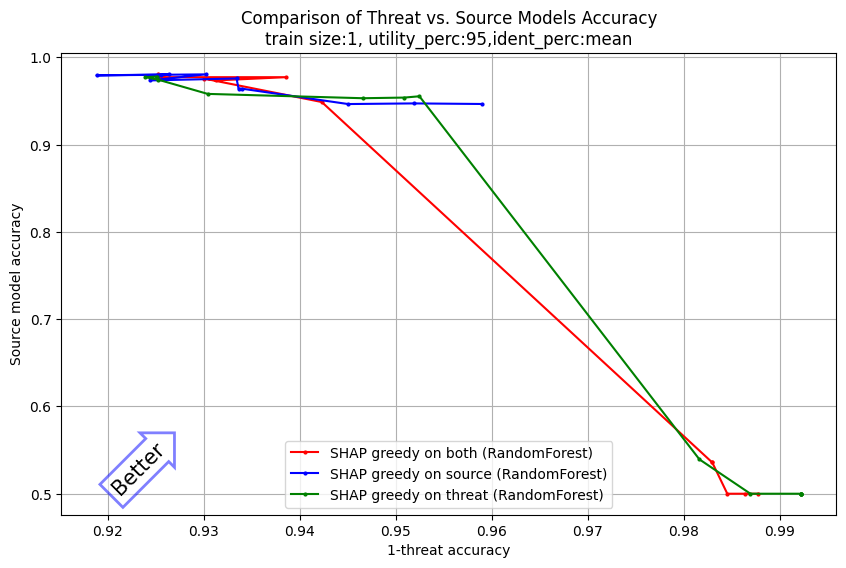

utility_perc: mean ident_perc: mean


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

5.52971636834093e-07
Percentile of features to keep: 3; Number of features to keep: 12; Ratio Threshold: 5.52971636834093e-07
-0.0259483046287807
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.0259483046287807


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 0.0008527996769367118


y_pred contains classes not in y_true


5.52971636834093e-07
Percentile of features to keep: 5; Number of features to keep: 12; Ratio Threshold: 5.52971636834093e-07
-0.021055770686732467
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.021055770686732467


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 0.0011694156062055448
5.52971636834093e-07
Percentile of features to keep: 7; Number of features to keep: 12; Ratio Threshold: 5.52971636834093e-07
-0.019566215999852567
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.019566215999852567


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 0.0012092401054816238
5.52971636834093e-07
Percentile of features to keep: 9; Number of features to keep: 12; Ratio Threshold: 5.52971636834093e-07
-0.018518796471866567
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.018518796471866567


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 0.001550433010566276
5.52971636834093e-07
Percentile of features to keep: 10; Number of features to keep: 12; Ratio Threshold: 5.52971636834093e-07
-0.018298797875781588
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.018298797875781588


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 0.0019512035001043727
1.0738523448795462e-06
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 1.0738523448795462e-06


y_pred contains classes not in y_true


-0.011480830745940428
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.011480830745940428


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 0.003540150136960812


y_pred contains classes not in y_true


7.4473481823623585e-06
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 7.4473481823623585e-06
-0.007032418034195749
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.007032418034195749


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 0.005954675166720335


y_pred contains classes not in y_true


4.370925465699916e-05
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 4.370925465699916e-05


y_pred contains classes not in y_true


-0.0032641488662918327
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.0032641488662918327


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 0.008784968133008463


y_pred contains classes not in y_true


5.2563956116483164e-05
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 5.2563956116483164e-05


y_pred contains classes not in y_true


-0.0026320228393253977
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.0026320228393253977


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 0.01149823256264472


y_pred contains classes not in y_true


6.269861312275739e-05
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 6.269861312275739e-05


y_pred contains classes not in y_true


-0.0018981602316618072
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.0018981602316618072


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 0.01698610429557865


y_pred contains classes not in y_true


7.172080048587431e-05
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 7.172080048587431e-05


y_pred contains classes not in y_true


-0.001045037868649539
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.001045037868649539


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 0.021633890506299755


y_pred contains classes not in y_true


9.649269708208486e-05
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 9.649269708208486e-05


y_pred contains classes not in y_true


4.010057997261147e-05
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 4.010057997261147e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 0.026622866721873282


y_pred contains classes not in y_true


0.00011466803282836221
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 0.00011466803282836221


y_pred contains classes not in y_true


4.010057997261147e-05
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 4.010057997261147e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 55; Ratio Threshold: 0.05563090625939295


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 58; Ratio Threshold: inf


y_pred contains classes not in y_true
100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:33<00:00, 93.10s/it]


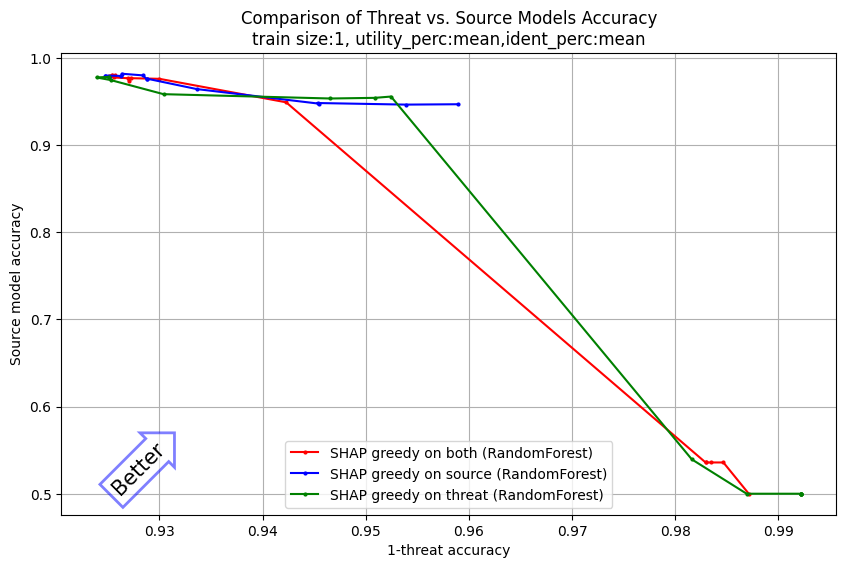

utility_perc: max ident_perc: mean


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

5.52971636834093e-07
Percentile of features to keep: 3; Number of features to keep: 12; Ratio Threshold: 5.52971636834093e-07
-0.1016866075608704
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.1016866075608704


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 5.087555481779767e-05
5.52971636834093e-07
Percentile of features to keep: 5; Number of features to keep: 12; Ratio Threshold: 5.52971636834093e-07
-0.09271234153429635
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.09271234153429635


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 5.654548855680937e-05
5.52971636834093e-07
Percentile of features to keep: 7; Number of features to keep: 12; Ratio Threshold: 5.52971636834093e-07
-0.08986603190891636
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.08986603190891636


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 6.438647384077478e-05
5.52971636834093e-07
Percentile of features to keep: 9; Number of features to keep: 12; Ratio Threshold: 5.52971636834093e-07
-0.0871483882831555
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.0871483882831555


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 9.620944962642888e-05
5.52971636834093e-07
Percentile of features to keep: 10; Number of features to keep: 12; Ratio Threshold: 5.52971636834093e-07
-0.0846134257187882
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.0846134257187882


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 0.00011726170419648518
1.0738523448795462e-06
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 1.0738523448795462e-06


y_pred contains classes not in y_true


-0.060634260505662216
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.060634260505662216


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 0.000665774418084917


y_pred contains classes not in y_true


7.4473481823623585e-06
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 7.4473481823623585e-06
-0.05257643291437132
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.05257643291437132


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 0.0010000580734225808


y_pred contains classes not in y_true


4.370925465699916e-05
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 4.370925465699916e-05


y_pred contains classes not in y_true


-0.040647567732224485
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.040647567732224485


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 0.0012552318787973883


y_pred contains classes not in y_true


5.2563956116483164e-05
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 5.2563956116483164e-05


y_pred contains classes not in y_true


-0.032259991762437816
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.032259991762437816


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 0.0014221284225085405


y_pred contains classes not in y_true


6.269861312275739e-05
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 6.269861312275739e-05


y_pred contains classes not in y_true


-0.023236954334763874
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.023236954334763874


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 0.0018395171778695272


y_pred contains classes not in y_true


7.172080048587431e-05
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 7.172080048587431e-05


y_pred contains classes not in y_true


-0.011443154446650549
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.011443154446650549


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 0.002191813478836733


y_pred contains classes not in y_true


9.649269708208486e-05
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 9.649269708208486e-05


y_pred contains classes not in y_true


0.006214009359019575
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 0.006214009359019575


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 0.002658502197851803


y_pred contains classes not in y_true


0.00011466803282836221
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 0.00011466803282836221


y_pred contains classes not in y_true


0.006214009359019575
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 0.006214009359019575


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 55; Ratio Threshold: 0.004152715179123228


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 58; Ratio Threshold: inf


y_pred contains classes not in y_true
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:17<00:00, 197.87s/it]


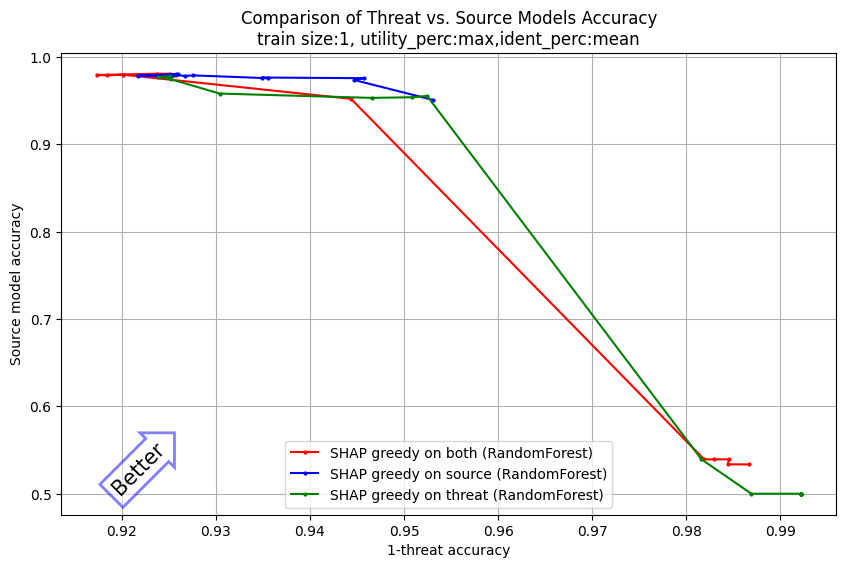

utility_perc: 50 ident_perc: max


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0002677216532795222
Percentile of features to keep: 3; Number of features to keep: 12; Ratio Threshold: 0.0002677216532795222
-0.017186058932801878
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.017186058932801878


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 0.6024957548008312


y_pred contains classes not in y_true


0.0002677216532795222
Percentile of features to keep: 5; Number of features to keep: 12; Ratio Threshold: 0.0002677216532795222
-0.014324794859580516
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.014324794859580516


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 0.6705531438961827


y_pred contains classes not in y_true


0.0002677216532795222
Percentile of features to keep: 7; Number of features to keep: 12; Ratio Threshold: 0.0002677216532795222
-0.013924149665299406
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.013924149665299406


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 0.7206733131403242


y_pred contains classes not in y_true


0.0002677216532795222
Percentile of features to keep: 9; Number of features to keep: 12; Ratio Threshold: 0.0002677216532795222
-0.012922438937072558
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.012922438937072558


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 0.8400264943467366


y_pred contains classes not in y_true


0.0002677216532795222
Percentile of features to keep: 10; Number of features to keep: 12; Ratio Threshold: 0.0002677216532795222
-0.01230915873344437
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.01230915873344437


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 0.84102332252159


y_pred contains classes not in y_true


0.0006185031594817502
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 0.0006185031594817502


y_pred contains classes not in y_true


-0.010060251140668669
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.010060251140668669


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 1.242535673775261


y_pred contains classes not in y_true


0.0015939033741877078
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 0.0015939033741877078
-0.00558057558115986
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.00558057558115986


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 1.5020969614121022


y_pred contains classes not in y_true


0.005855503979419877
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 0.005855503979419877


y_pred contains classes not in y_true


-0.0022942646701500646
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.0022942646701500646


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 2.009385309664607


y_pred contains classes not in y_true


0.008234512539767947
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 0.008234512539767947


y_pred contains classes not in y_true


-0.0016862628171452156
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.0016862628171452156


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 2.816866386783442


y_pred contains classes not in y_true


0.009964273165634663
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 0.009964273165634663


y_pred contains classes not in y_true


-0.0013306225225515917
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.0013306225225515917


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 3.624908320571127


y_pred contains classes not in y_true


0.01234353945313373
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 0.01234353945313373


y_pred contains classes not in y_true


-0.0006269908425126871
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.0006269908425126871


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 4.388443265396403


y_pred contains classes not in y_true


0.01602798581270244
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 0.01602798581270244


y_pred contains classes not in y_true


1.2532187113267354e-05
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 1.2532187113267354e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 7.222745637004678


y_pred contains classes not in y_true


0.025886622856821306
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 0.025886622856821306


y_pred contains classes not in y_true


1.2532187113267354e-05
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 1.2532187113267354e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 55; Ratio Threshold: 41.59883939597444


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 58; Ratio Threshold: inf


y_pred contains classes not in y_true
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:40<00:00, 220.36s/it]


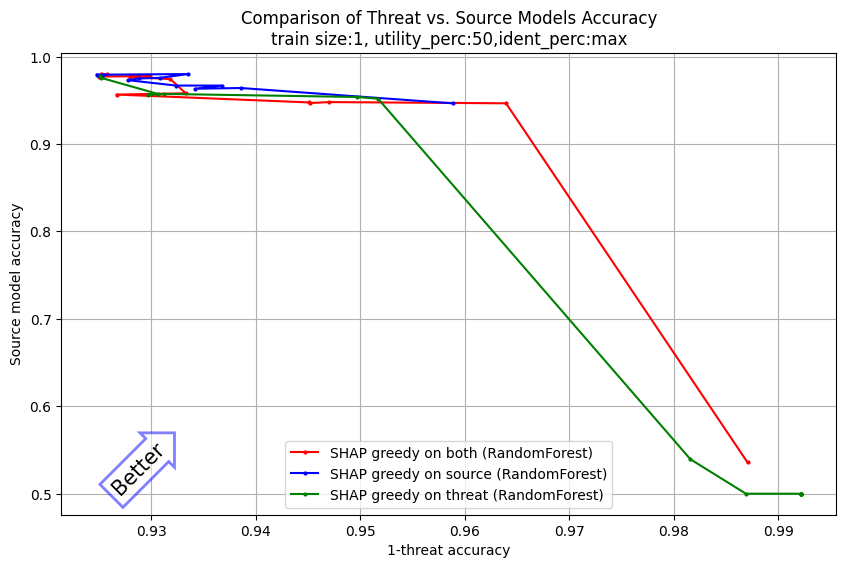

utility_perc: 75 ident_perc: max


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0002677216532795222
Percentile of features to keep: 3; Number of features to keep: 12; Ratio Threshold: 0.0002677216532795222
-0.03945059346270276
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.03945059346270276


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 0.23262117923565298


y_pred contains classes not in y_true


0.0002677216532795222
Percentile of features to keep: 5; Number of features to keep: 12; Ratio Threshold: 0.0002677216532795222
-0.039024620880503076
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.039024620880503076


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 0.24846764493643034


y_pred contains classes not in y_true


0.0002677216532795222
Percentile of features to keep: 7; Number of features to keep: 12; Ratio Threshold: 0.0002677216532795222
-0.03719208079191146
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.03719208079191146


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 0.2678232948603389


y_pred contains classes not in y_true


0.0002677216532795222
Percentile of features to keep: 9; Number of features to keep: 12; Ratio Threshold: 0.0002677216532795222
-0.032724735489875596
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.032724735489875596


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 0.28060934915610886


y_pred contains classes not in y_true


0.0002677216532795222
Percentile of features to keep: 10; Number of features to keep: 12; Ratio Threshold: 0.0002677216532795222
-0.030528141252439064
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.030528141252439064


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 0.2895966921021286


y_pred contains classes not in y_true


0.0006185031594817502
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 0.0006185031594817502


y_pred contains classes not in y_true


-0.014033325289469148
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.014033325289469148


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 0.5263540505872721


y_pred contains classes not in y_true


0.0015939033741877078
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 0.0015939033741877078
-0.008161181080517534
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.008161181080517534


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 0.9135814247117915


y_pred contains classes not in y_true


0.005855503979419877
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 0.005855503979419877


y_pred contains classes not in y_true


-0.003798830152061578
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.003798830152061578


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 1.3440217689218277


y_pred contains classes not in y_true


0.008234512539767947
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 0.008234512539767947


y_pred contains classes not in y_true


-0.002994875399528907
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.002994875399528907


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 1.8535617584913773


y_pred contains classes not in y_true


0.009964273165634663
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 0.009964273165634663


y_pred contains classes not in y_true


-0.0024765229168436154
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.0024765229168436154


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 2.552721779592796


y_pred contains classes not in y_true


0.01234353945313373
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 0.01234353945313373


y_pred contains classes not in y_true


-0.0011128758624084829
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.0011128758624084829


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 3.079543794299387


y_pred contains classes not in y_true


0.01602798581270244
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 0.01602798581270244


y_pred contains classes not in y_true


3.213758878396574e-05
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 3.213758878396574e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 6.365908862545403


y_pred contains classes not in y_true


0.025886622856821306
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 0.025886622856821306


y_pred contains classes not in y_true


3.213758878396574e-05
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 3.213758878396574e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 55; Ratio Threshold: 18.134495278283026


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 58; Ratio Threshold: inf


y_pred contains classes not in y_true
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:30<00:00, 210.93s/it]


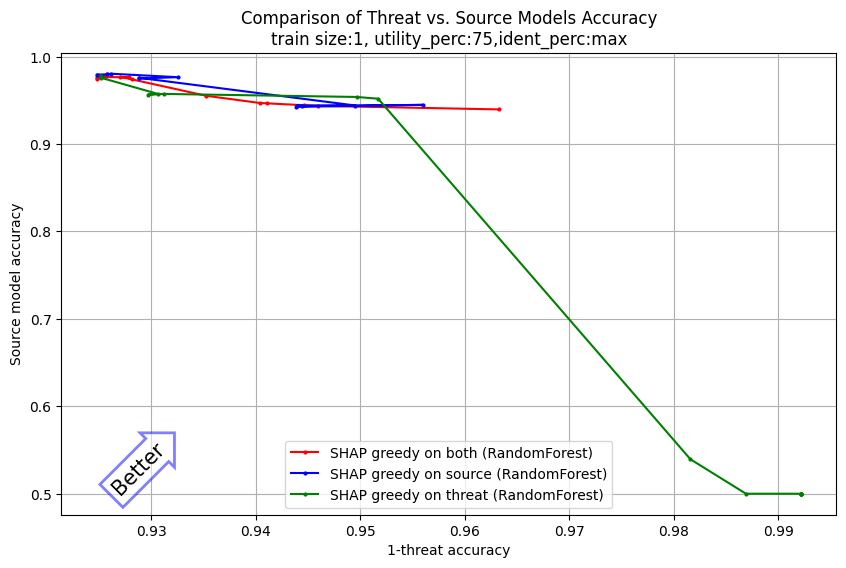

utility_perc: 90 ident_perc: max


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0002677216532795222
Percentile of features to keep: 3; Number of features to keep: 12; Ratio Threshold: 0.0002677216532795222
-0.04086720052566033
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.04086720052566033


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 0.15445032785169985


y_pred contains classes not in y_true


0.0002677216532795222
Percentile of features to keep: 5; Number of features to keep: 12; Ratio Threshold: 0.0002677216532795222
-0.040430395546674644
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.040430395546674644


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 0.21003568037800352
0.0002677216532795222
Percentile of features to keep: 7; Number of features to keep: 12; Ratio Threshold: 0.0002677216532795222
-0.039370377856861524
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.039370377856861524


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 0.21896600941172664


y_pred contains classes not in y_true


0.0002677216532795222
Percentile of features to keep: 9; Number of features to keep: 12; Ratio Threshold: 0.0002677216532795222
-0.03673468233329452
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.03673468233329452


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 0.23162244883833005


y_pred contains classes not in y_true


0.0002677216532795222
Percentile of features to keep: 10; Number of features to keep: 12; Ratio Threshold: 0.0002677216532795222
-0.035776265985610727
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.035776265985610727


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 0.23736212788212113


y_pred contains classes not in y_true


0.0006185031594817502
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 0.0006185031594817502


y_pred contains classes not in y_true


-0.02135573061779886
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.02135573061779886


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 0.377057922862335


y_pred contains classes not in y_true


0.0015939033741877078
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 0.0015939033741877078
-0.012061937618049356
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.012061937618049356


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 0.6118639074664842


y_pred contains classes not in y_true


0.005855503979419877
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 0.005855503979419877


y_pred contains classes not in y_true


-0.005784019191779126
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.005784019191779126


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 0.9047819063863854


y_pred contains classes not in y_true


0.008234512539767947
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 0.008234512539767947


y_pred contains classes not in y_true


-0.0042775804168549165
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.0042775804168549165


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 1.1447700679652573


y_pred contains classes not in y_true


0.009964273165634663
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 0.009964273165634663


y_pred contains classes not in y_true


-0.0030427312144867846
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.0030427312144867846


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 1.747644016850916


y_pred contains classes not in y_true


0.01234353945313373
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 0.01234353945313373


y_pred contains classes not in y_true


-0.0018702918787782841
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.0018702918787782841


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 2.4996142348324604


y_pred contains classes not in y_true


0.01602798581270244
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 0.01602798581270244


y_pred contains classes not in y_true


3.213758878396574e-05
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 3.213758878396574e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 3.612798142571399


y_pred contains classes not in y_true


0.025886622856821306
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 0.025886622856821306


y_pred contains classes not in y_true


3.213758878396574e-05
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 3.213758878396574e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 55; Ratio Threshold: 13.022497912539464


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 58; Ratio Threshold: inf


y_pred contains classes not in y_true
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:31<00:00, 211.34s/it]


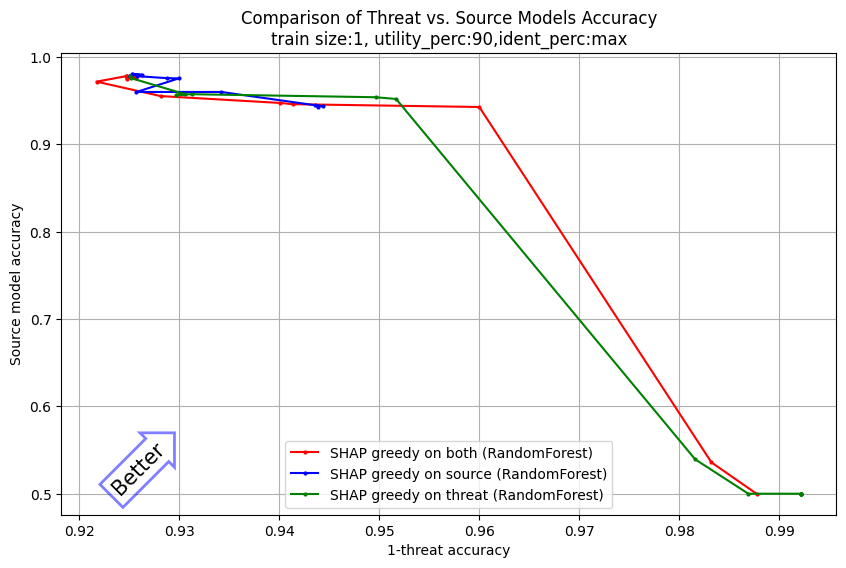

utility_perc: 95 ident_perc: max


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0002677216532795222
Percentile of features to keep: 3; Number of features to keep: 12; Ratio Threshold: 0.0002677216532795222
-0.05459593333017934
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.05459593333017934


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 0.11275048753263882


y_pred contains classes not in y_true


0.0002677216532795222
Percentile of features to keep: 5; Number of features to keep: 12; Ratio Threshold: 0.0002677216532795222
-0.041033604885966225
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.041033604885966225


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 0.1536928333167502
0.0002677216532795222
Percentile of features to keep: 7; Number of features to keep: 12; Ratio Threshold: 0.0002677216532795222
-0.04068842921831709
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.04068842921831709


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 0.19783334867791325
0.0002677216532795222
Percentile of features to keep: 9; Number of features to keep: 12; Ratio Threshold: 0.0002677216532795222
-0.04031626946973479
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.04031626946973479


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 0.21935206351250233


y_pred contains classes not in y_true


0.0002677216532795222
Percentile of features to keep: 10; Number of features to keep: 12; Ratio Threshold: 0.0002677216532795222
-0.03901865298996735
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.03901865298996735


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 0.22555928171677606


y_pred contains classes not in y_true


0.0006185031594817502
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 0.0006185031594817502


y_pred contains classes not in y_true


-0.027701512069382303
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.027701512069382303


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 0.30518662892004156


y_pred contains classes not in y_true


0.0015939033741877078
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 0.0015939033741877078
-0.016602156664246172
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.016602156664246172


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 0.4985245963354146


y_pred contains classes not in y_true


0.005855503979419877
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 0.005855503979419877


y_pred contains classes not in y_true


-0.008753547030012424
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.008753547030012424


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 0.7362427461734601


y_pred contains classes not in y_true


0.008234512539767947
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 0.008234512539767947


y_pred contains classes not in y_true


-0.00576223911990981
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.00576223911990981


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 0.8491285463464217


y_pred contains classes not in y_true


0.009964273165634663
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 0.009964273165634663


y_pred contains classes not in y_true


-0.0039916616721647775
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.0039916616721647775


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 1.3802851233823217


y_pred contains classes not in y_true


0.01234353945313373
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 0.01234353945313373


y_pred contains classes not in y_true


-0.0025056274567876436
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.0025056274567876436


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 1.7381277751260975


y_pred contains classes not in y_true


0.01602798581270244
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 0.01602798581270244


y_pred contains classes not in y_true


4.2756508783457295e-05
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 4.2756508783457295e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 2.5903231367235198


y_pred contains classes not in y_true


0.025886622856821306
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 0.025886622856821306


y_pred contains classes not in y_true


4.2756508783457295e-05
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 4.2756508783457295e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 55; Ratio Threshold: 8.123928769889092


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 58; Ratio Threshold: inf


y_pred contains classes not in y_true
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:30<00:00, 210.62s/it]


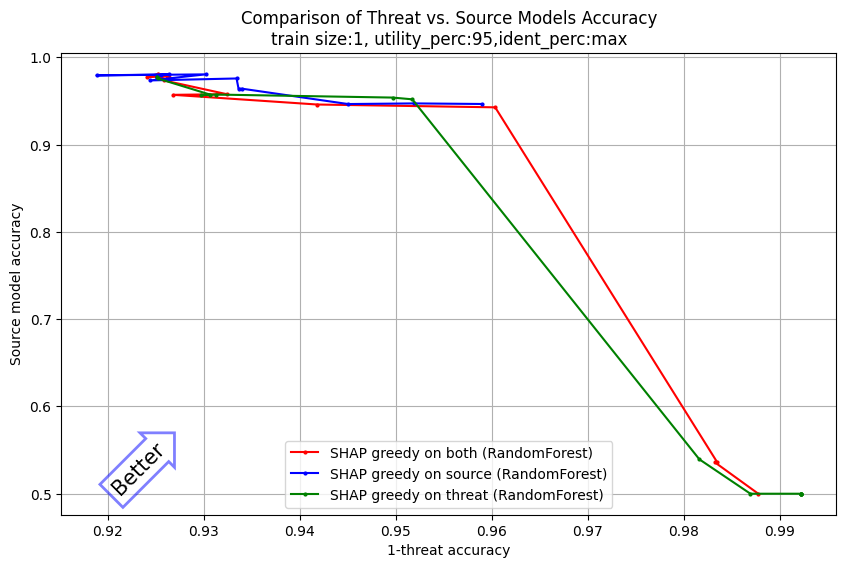

utility_perc: mean ident_perc: max


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0002677216532795222
Percentile of features to keep: 3; Number of features to keep: 12; Ratio Threshold: 0.0002677216532795222
-0.0259483046287807
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.0259483046287807


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 0.39320396679777264


y_pred contains classes not in y_true


0.0002677216532795222
Percentile of features to keep: 5; Number of features to keep: 12; Ratio Threshold: 0.0002677216532795222
-0.021055770686732467
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.021055770686732467


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 0.42901974917081165


y_pred contains classes not in y_true


0.0002677216532795222
Percentile of features to keep: 7; Number of features to keep: 12; Ratio Threshold: 0.0002677216532795222
-0.019566215999852567
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.019566215999852567


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 0.45662389352790006


y_pred contains classes not in y_true


0.0002677216532795222
Percentile of features to keep: 9; Number of features to keep: 12; Ratio Threshold: 0.0002677216532795222
-0.018518796471866567
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.018518796471866567


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 0.49742762759848896


y_pred contains classes not in y_true


0.0002677216532795222
Percentile of features to keep: 10; Number of features to keep: 12; Ratio Threshold: 0.0002677216532795222
-0.018298797875781588
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.018298797875781588


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 0.5058235565432316


y_pred contains classes not in y_true


0.0006185031594817502
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 0.0006185031594817502


y_pred contains classes not in y_true


-0.011480830745940428
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.011480830745940428


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 0.7464880754043304


y_pred contains classes not in y_true


0.0015939033741877078
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 0.0015939033741877078
-0.007032418034195749
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.007032418034195749


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 1.217593250654959


y_pred contains classes not in y_true


0.005855503979419877
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 0.005855503979419877


y_pred contains classes not in y_true


-0.0032641488662918327
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.0032641488662918327


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 1.5773617969971827


y_pred contains classes not in y_true


0.008234512539767947
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 0.008234512539767947


y_pred contains classes not in y_true


-0.0026320228393253977
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.0026320228393253977


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 1.8858427003970755


y_pred contains classes not in y_true


0.009964273165634663
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 0.009964273165634663


y_pred contains classes not in y_true


-0.0018981602316618072
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.0018981602316618072


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 3.049700090026186


y_pred contains classes not in y_true


0.01234353945313373
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 0.01234353945313373


y_pred contains classes not in y_true


-0.001045037868649539
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.001045037868649539


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 3.8089309842774464


y_pred contains classes not in y_true


0.01602798581270244
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 0.01602798581270244


y_pred contains classes not in y_true


4.010057997261147e-05
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 4.010057997261147e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 6.340426558429848


y_pred contains classes not in y_true


0.025886622856821306
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 0.025886622856821306


y_pred contains classes not in y_true


4.010057997261147e-05
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 4.010057997261147e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 55; Ratio Threshold: 18.197407113060247


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 58; Ratio Threshold: inf


y_pred contains classes not in y_true
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:40<00:00, 100.74s/it]


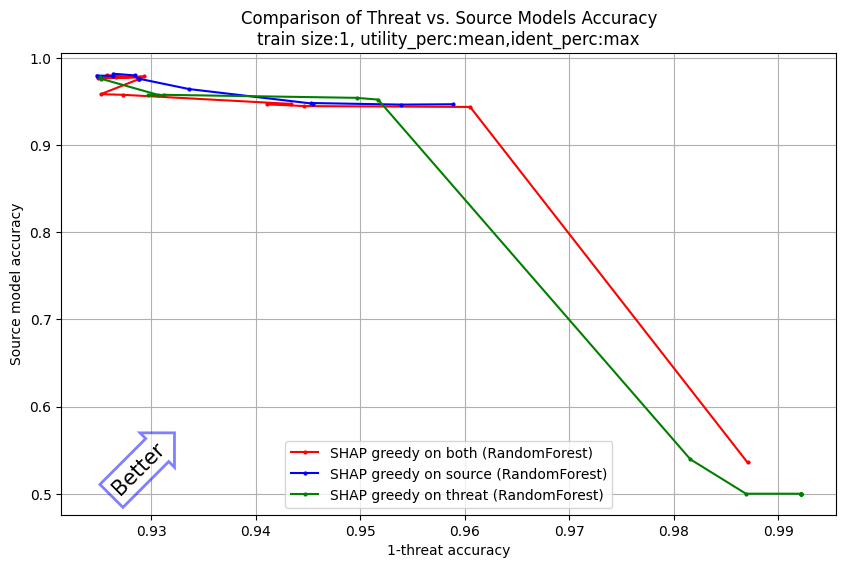

utility_perc: max ident_perc: max


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

0.0002677216532795222
Percentile of features to keep: 3; Number of features to keep: 12; Ratio Threshold: 0.0002677216532795222
-0.1016866075608704
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.1016866075608704


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 0.018620506212677173
0.0002677216532795222
Percentile of features to keep: 5; Number of features to keep: 12; Ratio Threshold: 0.0002677216532795222
-0.09271234153429635
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.09271234153429635


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 0.025947530173911555
0.0002677216532795222
Percentile of features to keep: 7; Number of features to keep: 12; Ratio Threshold: 0.0002677216532795222
-0.08986603190891636
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.08986603190891636


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 0.038913643512500616


y_pred contains classes not in y_true


0.0002677216532795222
Percentile of features to keep: 9; Number of features to keep: 12; Ratio Threshold: 0.0002677216532795222
-0.0871483882831555
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.0871483882831555


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 0.04490742907827707


y_pred contains classes not in y_true


0.0002677216532795222
Percentile of features to keep: 10; Number of features to keep: 12; Ratio Threshold: 0.0002677216532795222
-0.0846134257187882
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.0846134257187882


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 0.04809494121697336


y_pred contains classes not in y_true


0.0006185031594817502
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 0.0006185031594817502


y_pred contains classes not in y_true


-0.060634260505662216
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.060634260505662216


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 0.11625281252407761


y_pred contains classes not in y_true


0.0015939033741877078
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 0.0015939033741877078
-0.05257643291437132
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.05257643291437132


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 0.15604943566573848


y_pred contains classes not in y_true


0.005855503979419877
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 0.005855503979419877


y_pred contains classes not in y_true


-0.040647567732224485
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.040647567732224485


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 0.19241804287429862


y_pred contains classes not in y_true


0.008234512539767947
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 0.008234512539767947


y_pred contains classes not in y_true


-0.032259991762437816
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.032259991762437816


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 0.2518746822093141


y_pred contains classes not in y_true


0.009964273165634663
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 0.009964273165634663


y_pred contains classes not in y_true


-0.023236954334763874
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.023236954334763874


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 0.356698149120365


y_pred contains classes not in y_true


0.01234353945313373
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 0.01234353945313373


y_pred contains classes not in y_true


-0.011443154446650549
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.011443154446650549


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 0.3956516727692035


y_pred contains classes not in y_true


0.01602798581270244
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 0.01602798581270244


y_pred contains classes not in y_true


0.006214009359019575
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 0.006214009359019575


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 0.5019486253360623


y_pred contains classes not in y_true


0.025886622856821306
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 0.025886622856821306


y_pred contains classes not in y_true


0.006214009359019575
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 0.006214009359019575


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 55; Ratio Threshold: 1.0152174020573708


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 58; Ratio Threshold: inf


y_pred contains classes not in y_true
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:18<00:00, 198.26s/it]


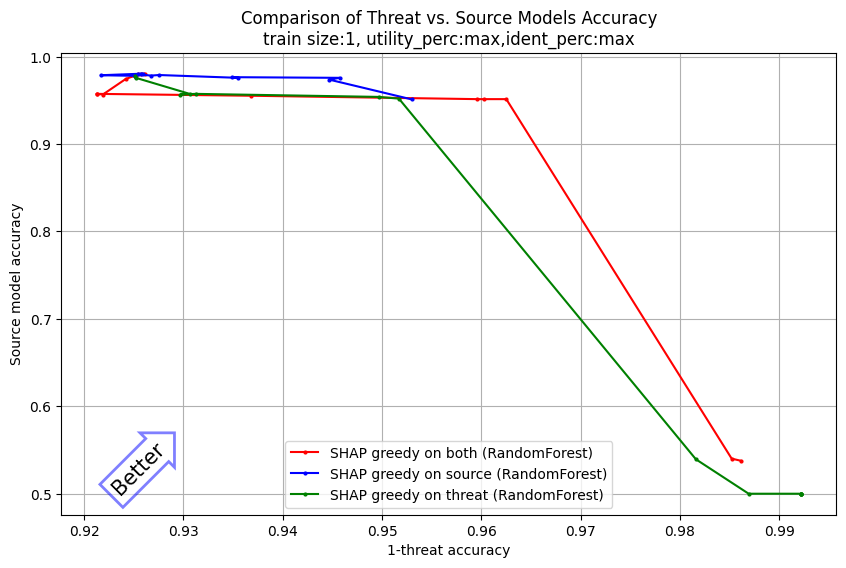

In [153]:
for ident_perc in [50, 75, 90, 95, 'mean', 'max']:
    for utility_perc in [50, 75, 90, 95, 'mean', 'max']:
        print('utility_perc:', utility_perc, 'ident_perc:', ident_perc)
        shap_feature_selection(df_X_train, df_Y_train, utility_perc=utility_perc, ident_perc=ident_perc, custom_text=f'train size:1', custom_text_ext=f'utility_perc:{utility_perc},ident_perc:{ident_perc}')

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 736.23it/s]


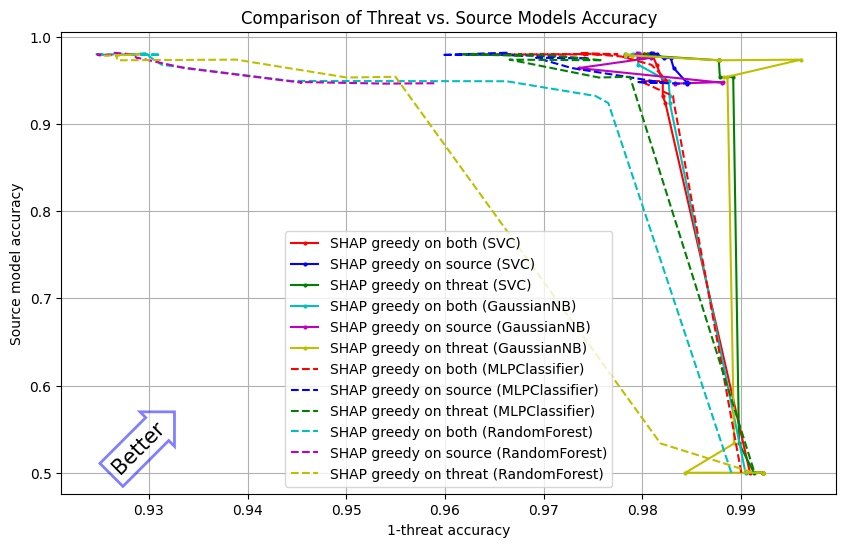

In [42]:
score_lists = []
legend_lists = []

threat_models = [
                 ('SVC', SVC(random_state=42)),
                 ('GaussianNB', GaussianNB()),
                 ('MLPClassifier', MLPClassifier(alpha=1, max_iter=1000, random_state=42)),
                 ('RandomForest', RandomForestClassifier(random_state=42))
]

custom_text = 'train size:1'
for model in tqdm(threat_models):
    score_list_both = np.loadtxt(f'shap_{custom_text}.score_list_both_{model[0]}.csv', delimiter=",")
    score_list_source = np.loadtxt(f'shap_{custom_text}.score_list_source_{model[0]}.csv', delimiter=",")
    score_list_threat = np.loadtxt(f'shap_{custom_text}.score_list_threat_{model[0]}.csv', delimiter=",")

    score_lists += [np.array(score_list_both), np.array(score_list_source), np.array(score_list_threat)]
    legend_lists += [f'SHAP greedy on both ({model[0]})', f'SHAP greedy on source ({model[0]})', f'SHAP greedy on threat ({model[0]})']
plot_multiple_accuracies(score_lists, legend_lists, custom_text, '')